In [1]:
# Start Notebook:
%reset -f
import ROOT, numpy, re
import traceback
import sys

# Add the path to sys.path temporarily
script_dir = '/w/hallb-scshelf2102/clas12/richcap/SIDIS_Analysis'
sys.path.append(script_dir)
from MyCommonAnalysisFunction_richcap import *
from ExtraAnalysisCodeValues import *
# Now you can remove the path if you wish
sys.path.remove(script_dir)
del script_dir

import math
import array
import copy


def variable_Title_name_new(variable_in):
    if(variable_in in ["k0_cut"]):
        return "E^{Cutoff}_{#gamma}"
    else:
        output = variable_Title_name(variable_in)
        output = output.replace(" (lepton energy loss fraction)", "")
        return output

def find_max_bin(hist):
    max_content = 0
    for bin_ii in range(1, hist.GetNbinsX() + 1):
        bin_content = hist.GetBinContent(bin_ii)
        if(bin_content > max_content):
            max_content = bin_content
    return max_content


ROOT.TH1.AddDirectory(0)
ROOT.gStyle.SetTitleOffset(1.3,'y')

ROOT.gStyle.SetGridColor(17)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)

ROOT.gStyle.SetOptStat(0)

print(f"{color.BBLUE}\nCode is ready to run.{color.END}\n")


Code is ready to run.



In [28]:
from pathlib import Path
# List your folders here
folders = [
    Path("/w/hallb-scshelf2102/clas12/richcap/SIDIS_Analysis/Histo_Files_ROOT/DataFrames/REAL_Data"),
    Path("/w/hallb-scshelf2102/clas12/richcap/SIDIS_Analysis/Histo_Files_ROOT/DataFrames/GEN_MC"),
    Path("/w/hallb-scshelf2102/clas12/richcap/SIDIS_Analysis/Histo_Files_ROOT/DataFrames/Matching_REC_MC")
    # Path("/w/hallb-scshelf2102/clas12/richcap/SIDIS_Analysis/Histo_Files_ROOT/DataFrames/Matching_REC_MC/Link_to_Volatile_MC_Matching")
]

all_root_files = {}

verbose = not True

class args:
    num_MC_files = 6
    


for folder in folders:
    # print(str(folder.name))
    array_name = "rdf" if("REAL_Data" in str(folder.name)) else "mdf" if(("Matching_REC_MC" in str(folder.name)) or ("Link_to_Volatile_MC_Matching" in str(folder.name))) else "gdf"
    all_root_files[array_name] = []
    if("REAL_Data" not in str(folder.name)):
        all_root_files[f"{array_name}_clasdis"] = []
    if(not folder.exists()):
        print(f"{color.Error}WARNING - Folder not found: {color.END_B}{folder}{color.END}")
        continue
    if(not folder.is_dir()):
        print(f"{color.Error}WARNING - Not a directory: {color.END_B}{folder}{color.END}")
        continue

    # Gather only files at the top level of this folder
    root_files = [p for p in folder.iterdir() if((p.is_file()) and (".root" in str(p.name)))]
    if(verbose):
        print(f"\n{color.BOLD}Files in {color.BLUE}{folder}{color.END_B}:{color.END}")
    for num, f in enumerate(root_files):
        if(verbose):
            if("Acceptance_Tests" in str(f.name)):
                if("EvGen" not in str(f.name)):
                    print(f"\t{num+1:>5.0f}:   {color.CYAN}{f.name}{color.END}")
        if("EvGen" in str(f.name)):
            if("Acceptance_Tests" not in str(f.name)):
                continue
            if("V3"               not in str(f.name)):
                continue
            # if(len(all_root_files[array_name]) < 5):
            all_root_files[array_name].append(f"{str(folder.name)}/{f.name}")
        elif("REAL" in str(folder.name)):
            if(len(all_root_files[array_name]) < 5):
                all_root_files[array_name].append(f"{str(folder.name)}/{f.name}")
        else:
            if("Acceptance_Tests" not in str(f.name)):
                continue
            if("V3"               not in str(f.name)):
                continue
            all_root_files[f"{array_name}_clasdis"].append(f"{str(folder.name)}/{f.name}")
            # if(len(all_root_files[f"{array_name}_clasdis"]) < 10):
            #     if((array_name in ["mdf"]) and (f"{str(folder.name).replace('Matching_REC_MC', 'GEN_MC')}/{str(f.name).replace('DataFrame_SIDIS_epip_MC_Matched', 'DataFrame_SIDIS_epip_MC_GEN')}" not in all_root_files["gdf_clasdis"])):
            #     # if((array_name in ["mdf"]) and (f"{str(folder.name).replace('Link_to_Volatile_MC_Matching', 'GEN_MC')}/{str(f.name).replace('DataFrame_SIDIS_epip_MC_Matched', 'DataFrame_SIDIS_epip_MC_GEN')}" not in all_root_files["gdf_clasdis"])):
            #         continue
            #     all_root_files[f"{array_name}_clasdis"].append(f"{str(folder.name)}/{f.name}")

#     all_root_files.extend(root_files)
# # If you’d like a combined list of all files across the three:
# print("\nAll root files across all folders:")
# for f in all_root_files:
#     print(f"  • {f}")

remove_list = []
for mc           in ["", "_clasdis"]:
    all_root_files[f"gdf{mc}"].sort()
    all_root_files[f"mdf{mc}"].sort()
    count = 0
    for gdf_name in all_root_files[f"gdf{mc}"]:
        mdf_name = gdf_name.replace("GEN_MC/",        "Matching_REC_MC/")
        mdf_name = mdf_name.replace("MC_GEN_Pass_2_", "MC_Matched_Pass_2_")
        mdf_name = mdf_name.replace("Tests_V",        "Tests_FC_14_V")
        if((mdf_name not in all_root_files[f"mdf{mc}"]) or (count > args.num_MC_files)):
            # print(f"Can't find {[gdf_name, mdf_name]} in 'mdf{mc}'\n")
            remove_list.append([mc, gdf_name, mdf_name])
        else:
            count += 1
    count = 0
    for mdf_name in all_root_files[f"mdf{mc}"]:
        gdf_name = mdf_name.replace("Matching_REC_MC/",   "GEN_MC/")
        gdf_name = gdf_name.replace("MC_Matched_Pass_2_", "MC_GEN_Pass_2_")
        gdf_name = gdf_name.replace("FC_14_",             "")
        if((gdf_name not in all_root_files[f"gdf{mc}"]) or (count > args.num_MC_files)):
            # print(f"Can't find {[gdf_name, mdf_name]} in 'gdf{mc}'\n")
            remove_list.append([mc, gdf_name, mdf_name])
        else:
            count += 1

for ii in remove_list:
    mc, gdf_name, mdf_name = ii
    if(gdf_name in all_root_files[f"gdf{mc}"]):
        # print(f"Removing: {gdf_name}")
        all_root_files[f"gdf{mc}"].remove(gdf_name)
    if(mdf_name in all_root_files[f"mdf{mc}"]):
        # print(f"Removing: {mdf_name}")
        all_root_files[f"mdf{mc}"].remove(mdf_name)

# all_root_files["gdf_clasdis"] = ["Matching_REC_MC/DataFrame_SIDIS_epip_MC_Matched_Pass_2_Sector_Tests_V2_8950.root"]
# all_root_files["mdf_clasdis"] = ["Matching_REC_MC/DataFrame_SIDIS_epip_MC_Matched_Pass_2_Sector_Tests_FC_14_V2_8950.root"]

print(f"\n\n{color.BOLD}Will Run With:{color.END}\n")
for ii in all_root_files:
    print(f"\n\t{color.BLUE}{ii}:{color.END}")
    for jj in all_root_files[ii]:
        print(f"\t\t{jj}")
print("\n\nDone\n")



Will Run With:


	rdf:
		REAL_Data/DataFrame_SIDIS_epip_Data_REC_Pass_2_Sector_Tests_FC_14_V2_5302.root
		REAL_Data/DataFrame_SIDIS_epip_Data_REC_Pass_2_Sector_Tests_FC_14_V2_5349.root
		REAL_Data/DataFrame_SIDIS_epip_Data_REC_Pass_2_Sector_Tests_FC_14_V2_5181.root
		REAL_Data/DataFrame_SIDIS_epip_Data_REC_Pass_2_Sector_Tests_FC_14_V2_5168.root
		REAL_Data/DataFrame_SIDIS_epip_Data_REC_Pass_2_Sector_Tests_FC_14_V2_5047.root

	gdf:
		GEN_MC/DataFrame_SIDIS_epip_MC_GEN_Pass_2_Acceptance_Tests_V3_EvGen_9575_0.root
		GEN_MC/DataFrame_SIDIS_epip_MC_GEN_Pass_2_Acceptance_Tests_V3_EvGen_9575_1.root
		GEN_MC/DataFrame_SIDIS_epip_MC_GEN_Pass_2_Acceptance_Tests_V3_EvGen_9575_2.root
		GEN_MC/DataFrame_SIDIS_epip_MC_GEN_Pass_2_Acceptance_Tests_V3_EvGen_9575_3.root
		GEN_MC/DataFrame_SIDIS_epip_MC_GEN_Pass_2_Acceptance_Tests_V3_EvGen_9575_4.root
		GEN_MC/DataFrame_SIDIS_epip_MC_GEN_Pass_2_Acceptance_Tests_V3_EvGen_9575_5.root
		GEN_MC/DataFrame_SIDIS_epip_MC_GEN_Pass_2_Acceptance_Tests_V3_EvGen_9

In [11]:
print(f"\n{color.BOLD}LOADING DATAFRAMES\n{color.END}")

rdf         = ROOT.RDataFrame("h22", all_root_files["rdf"])
mdf_EvGen   = ROOT.RDataFrame("h22", all_root_files["mdf"])
gdf_EvGen   = ROOT.RDataFrame("h22", all_root_files["gdf"])
mdf_clasdis = ROOT.RDataFrame("h22", all_root_files["mdf_clasdis"])
gdf_clasdis = ROOT.RDataFrame("h22", all_root_files["gdf_clasdis"])

# rdf         = rdf.Range(500000)
# mdf_EvGen   = mdf_EvGen.Range(500000)
# gdf_EvGen   = gdf_EvGen.Range(500000)
# mdf_clasdis = mdf_clasdis.Range(500000)
# gdf_clasdis = gdf_clasdis.Range(500000)


rdf         = rdf.Range(5000)
mdf_EvGen   = mdf_EvGen.Range(5000)
gdf_EvGen   = gdf_EvGen.Range(5000)
# mdf_clasdis = mdf_clasdis.Range(5000)
gdf_clasdis = gdf_clasdis.Range(5000)


verbose = not True

# print(f"\nrdf -> {rdf}")
print(f"\n{color.BBLUE}rdf{color.END}:")
if(verbose or (not True)):
    for ii in range(0, len(rdf.GetColumnNames()), 1):
        print(f"\t{str((rdf.GetColumnNames())[ii]).ljust(38)} (type -> {rdf.GetColumnType(rdf.GetColumnNames()[ii])})")
print(f"\tTotal entries in {color.BBLUE}rdf{color.END} files: \n{rdf.Count().GetValue():>20.0f}")

# print(f"\nmdf_clasdis -> {mdf_clasdis}")
print(f"\n{color.Error}mdf_clasdis{color.END}:")
if(verbose or (not True)):
    for ii in range(0, len(mdf_clasdis.GetColumnNames()), 1):
        print(f"\t{str((mdf_clasdis.GetColumnNames())[ii]).ljust(38)} (type -> {mdf_clasdis.GetColumnType(mdf_clasdis.GetColumnNames()[ii])})")
print(f"\tTotal entries in {color.Error}mdf_clasdis{color.END} files: \n{mdf_clasdis.Count().GetValue():>20.0f}")

# print(f"\nmdf_EvGen -> {mdf_EvGen}")
print(f"\n{color.BOLD}{color.PINK}mdf_EvGen{color.END}:")
if(verbose or (not True)):
    for ii in range(0, len(mdf_EvGen.GetColumnNames()), 1):
        print(f"\t{str((mdf_EvGen.GetColumnNames())[ii]).ljust(38)} (type -> {mdf_EvGen.GetColumnType(mdf_EvGen.GetColumnNames()[ii])})")
print(f"\tTotal entries in {color.BOLD}{color.PINK}mdf_EvGen{color.END} files: \n{mdf_EvGen.Count().GetValue():>20.0f}")


# print(f"\ngdf_clasdis -> {gdf_clasdis}")
print(f"\n{color.BGREEN}gdf_clasdis{color.END}:")
if(verbose or (not True)):
    for ii in range(0, len(gdf_clasdis.GetColumnNames()), 1):
        print(f"\t{str((gdf_clasdis.GetColumnNames())[ii]).ljust(38)} (type -> {gdf_clasdis.GetColumnType(gdf_clasdis.GetColumnNames()[ii])})")
print(f"\tTotal entries in {color.BGREEN}gdf_clasdis{color.END} files: \n{gdf_clasdis.Count().GetValue():>20.0f}")

# print(f"\ngdf_EvGen -> {gdf_EvGen}")
print(f"\n{color.BCYAN}gdf_EvGen{color.END}:")
if(verbose or (not True)):
    for ii in range(0, len(gdf_EvGen.GetColumnNames()), 1):
        print(f"\t{str((gdf_EvGen.GetColumnNames())[ii]).ljust(38)} (type -> {gdf_EvGen.GetColumnType(gdf_EvGen.GetColumnNames()[ii])})")
print(f"\tTotal entries in {color.BCYAN}gdf_EvGen{color.END} files: \n{gdf_EvGen.Count().GetValue():>20.0f}")




# print(df_array)
print(f"\n{color.BOLD}Done{color.END}\n")


LOADING DATAFRAMES


rdf:
	Total entries in rdf files: 
                5000

mdf_clasdis:
	Total entries in mdf_clasdis files: 
             1012709

mdf_EvGen:
	Total entries in mdf_EvGen files: 
                5000

gdf_clasdis:
	Total entries in gdf_clasdis files: 
                5000

gdf_EvGen:
	Total entries in gdf_EvGen files: 
                5000

Done



In [4]:
print(f"\n{color.BOLD}DEFINING CUT FUNCTIONS{color.END}\n")
Skipped_Fiducial_Cuts = ["Hpip", "DC_pip", "Electron"] # i.e. FC_14
##########################################################################################################################################################################################
##########################################################################################################################################################################################
Use_New_PF = True
def filter_Valerii(Data_Frame, Valerii_Cut, Include_Pion=Use_New_PF):
    if(("Valerii_Cut" in Valerii_Cut) or ("Complete" in Valerii_Cut)):
        Data_Frame_Clone = Data_Frame.Filter("".join(["""
            auto func = [&](double x, double k, double b){
                return k * x + b;
            };
            struct line{
                double k;
                double b;
            };
            auto isOutOfLines = [&](double x, double y, line topLine, line botLine){
                return y > func(x, topLine.k, topLine.b) || y < func(x, botLine.k, botLine.b);
            };
            auto BadElementKnockOut = [&](double hx, double hy, int sector, int cutLevel){
                double widthChange = 0;
                if (cutLevel == 0)  widthChange = -1;
                if (cutLevel == 2)  widthChange = 1;
                if (sector == 5) return true;
                if (sector == 1){
                    double k = tan(29.5*3.1415/180);
                    double b = -92;
                    bool test_sec_1 = (isOutOfLines(hx, hy, {k, b + widthChange} , {k, b - widthChange - 2.4}) && isOutOfLines(hx, hy, {k, b + widthChange - 9.1} , {k, b - widthChange - 9.1 - 2.4}) && isOutOfLines(hx, hy, {k, b + widthChange - 127} , {k, b - widthChange - 127 - 2.4}) && isOutOfLines(hx, hy, {k, b + widthChange - 127 - 8} , {k, b - widthChange -127 - 8 - 2.4}) );
                           
                    return test_sec_1;       
                }
                if (sector == 2){
                    double k = tan(30.4*3.1415/180);
                    double b = 120.5;
                    bool test_sec_2 = (isOutOfLines(hx, hy, {k, b + widthChange} , {k, b - widthChange - 4.4}));
                    return test_sec_2;
                }
                if (sector == 3){
                    bool test_sec_3 = ((hx - widthChange) > - 303 || (hx + widthChange) < -310);
                    return test_sec_3;
                }
                if (sector == 4){
                    double k = tan(-29.6*3.1415/180);
                    double b = -232.8;
                    bool test_sec_4 = (isOutOfLines(hx, hy, {k, b + widthChange} , {k, b - widthChange - 3.5}));
                    
                    return test_sec_4;
                }
                if (sector == 6){
                    double k = tan(-30.6*3.1415/180);
                    double b = -185;
                    
                    bool test_sec_6 = (isOutOfLines(hx, hy, {k, b + widthChange} , {k, b - widthChange - 2}) && isOutOfLines(hx, hy, {k, b + widthChange - 8.3} , {k, b - widthChange - 8.3 - 2.2}) );
                    
                    return test_sec_6;
                }
                return false;
            };
            """, "return BadElementKnockOut(Hx, Hy, esec, 1);" if((not Include_Pion) or True) else "return (BadElementKnockOut(Hx, Hy, esec, 1) && BadElementKnockOut(Hx_pip, Hy_pip, pipsec, 1));"]))
        return Data_Frame_Clone
    else:
        return Data_Frame

###################=======================================###################
##===============##        Full Filter + Cut Title        ##===============##
###################=======================================###################

def DF_Filter_Function_Full(DF_Out, Titles_or_DF="DF", Data_Type="rdf", Cut_Choice="no_cut", Smearing_Q=""):
    ##################################################
    ##==========## General Cuts (Start) ##==========##
    ##################################################
    cutname = " "
    if((Data_Type in ["pdf", "gen"]) and (Titles_or_DF == 'DF')):
        DF_Out = DF_Out.Filter("PID_el != 0 && PID_pip != 0")
    if((Cut_Choice in ["cut_Gen"])         and (Data_Type not in ["rdf"])):
        cutname         = "Generated MM Cut"
        if(Titles_or_DF == 'DF'):
            if(Data_Type in ["gdf"]):
                DF_Out  = DF_Out.Filter("sqrt(MM2) > 1.5")
            else:
                DF_Out  = DF_Out.Filter("sqrt(MM2_gen) > 1.5")       
    elif((Cut_Choice in ["cut_Exgen"])     and (Data_Type not in ["rdf"])):
        cutname         = "Generated MM Cut (Exclusive Events)"
        if(Titles_or_DF == 'DF'):
            if(Data_Type in ["gdf"]):
                DF_Out  = DF_Out.Filter("sqrt(MM2) < 1.5")
            else:
                DF_Out  = DF_Out.Filter("sqrt(MM2_gen) < 1.5")
    elif((Data_Type not in ["gdf", "gen"]) and ("no_cut" not in str(Cut_Choice))):
        if("Complete"   in Cut_Choice):
            cutname     = "Complete Set of "
            if(("smear" in Smearing_Q)     and (Data_Type != "rdf")):
                cutname = f"{cutname}(Smeared) "
            if(Titles_or_DF == 'DF'):
                DF_Out  = filter_Valerii(DF_Out, Cut_Choice)
                DF_Out  = New_Fiducial_Cuts_Function(Data_Frame_In=DF_Out, Skip_Options=Skipped_Fiducial_Cuts)
                if(("smear" in Smearing_Q) and (Data_Type != "rdf")):
                    if("str" in str(type(DF_Out))):
                        print(f"DF_Out = {type(DF_Out)}({DF_Out})")
                    # DF_Out  = DF_Out.Filter("smeared_vals[7] < 0.75 && smeared_vals[12] > 0 && smeared_vals[6] > 2 && smeared_vals[2] > 2 && smeared_vals[19] > 1.25 && smeared_vals[19] < 5 && 5 < smeared_vals[17] && smeared_vals[17] < 35 && 5 < smeared_vals[21] && smeared_vals[21] < 35")
                    DF_Out  = DF_Out.Filter("(y_smeared < 0.75) && (xF_smeared > 0) && (W_smeared > 2) && (Q2_smeared > 2) && (pip_smeared > 1.25) && (pip_smeared < 5) && (5 < elth_smeared) && (elth_smeared < 35) && (5 < pipth_smeared) && (pipth_smeared < 35)")
                else:
                    DF_Out  = DF_Out.Filter("y < 0.75 && xF > 0 && W > 2 && Q2 > 2 && pip > 1.25 && pip < 5 && 5 < elth && elth < 35 && 5 < pipth && pipth < 35")
            if("EDIS"   in Cut_Choice):
                cutname = f"{cutname} Exclusive "
                if(Titles_or_DF == 'DF'):
                    DF_Out      = DF_Out.Filter(str(Calculated_Exclusive_Cuts(Smearing_Q)))
            if("SIDIS"  in Cut_Choice):
                cutname = f"{cutname} SIDIS "
                # # REMOVED AS A TEST FOR THE COMPARISONS - NOT A PART OF THE ACTUAL ANALYSIS CUTS
                # if(Titles_or_DF == 'DF'):
                #     if(("smear" in Smearing_Q) and (Data_Type != "rdf")):
                #         # DF_Out  = DF_Out.Filter("sqrt(smeared_vals[1]) > 1.5")
                #         DF_Out  = DF_Out.Filter("sqrt(MM2_smeared) > 1.5")
                #     else:
                #         DF_Out  = DF_Out.Filter("sqrt(MM2) > 1.5")
            if("Proton" in Cut_Choice):
                cutname = f"{cutname} (Proton Cut) "
                if(Titles_or_DF == 'DF'):
                    DF_Out  = DF_Out.Filter("MM_pro > 1.35")
            if("RevPro" in Cut_Choice):
                cutname = f"{cutname} (Inverted Proton Cut) "
                if(Titles_or_DF == 'DF'):
                    DF_Out  = DF_Out.Filter("MM_pro < 1.35")
            # if("Binned"  in Cut_Choice):
            #     cutname = f"{cutname} (Binned) "
            #     if(Titles_or_DF == 'DF'):
            #         if(("smear" in Smearing_Q) and (Data_Type != "rdf")):
            #             if("5" in binning_option_list or "Y_bin"  in binning_option_list or "Y_Bin" in binning_option_list):
            #                 DF_Out = DF_Out.Filter("(Q2_Y_Bin_smeared > 0 && Q2_Y_Bin_smeared < 18) && (z_pT_Bin_Y_bin_smeared > 0)")
            #             else:
            #                 DF_Out = DF_Out.Filter("(Q2_y_Bin_smeared > 0 && Q2_y_Bin_smeared < 18) && (z_pT_Bin_y_bin_smeared > 0)")
            #         else:
            #             if("5" in binning_option_list or "Y_bin"  in binning_option_list or "Y_Bin" in binning_option_list):
            #                 DF_Out = DF_Out.Filter("(Q2_Y_Bin > 0 && Q2_Y_Bin < 18) && (z_pT_Bin_Y_bin > 0)")
            #             else:
            #                 DF_Out = DF_Out.Filter("(Q2_y_Bin > 0 && Q2_y_Bin < 18) && (z_pT_Bin_y_bin > 0)")
            if("MM" in Cut_Choice):
                cutname = f"{cutname} (Inverted MM) "
                if(Titles_or_DF == 'DF'):
                    if("smear" in Smearing_Q   and Data_Type != "rdf"):
                        DF_Out  = DF_Out.Filter("sqrt(smeared_vals[1]) < 1.5")
                    else:
                        DF_Out  = DF_Out.Filter("sqrt(MM2) < 1.5")
            if(("Gen" in Cut_Choice)           and (Data_Type not in ["rdf"])):
                cutname = f"{cutname} (Gen MM) "
                if(Titles_or_DF == 'DF'):
                    if(Data_Type in ["gdf"]):
                        DF_Out  = DF_Out.Filter("sqrt(MM2) > 1.5")
                    else:
                        DF_Out  = DF_Out.Filter("sqrt(MM2_gen) > 1.5")
            if(("Exgen" in Cut_Choice)         and (Data_Type not in ["rdf"])):
                cutname = f"{cutname} (Exclusive Gen MM) "
                if(Titles_or_DF == 'DF'):
                    if(Data_Type in ["gdf"]):
                        DF_Out  = DF_Out.Filter("sqrt(MM2) < 1.5")
                    else:
                        DF_Out  = DF_Out.Filter("sqrt(MM2_gen) < 1.5")
            cutname = f"{cutname} Cuts"
            # if(Skipped_Fiducial_Cuts != Default_Cut_Option):
            #     cutname = f"{cutname} (Skipped these Fiducial Cuts: {Skipped_Fiducial_Cuts})"
    else:
        # Generated Monte Carlo should not have cuts applied to it (until now...)
        cutname = "No Cuts"

    if("Integrate" in Cut_Choice):
        cutname = f"{cutname} (Bins for Integration)"
        if(Titles_or_DF == 'DF'):
            Bin_Integrate_Cuts = "((Q2_Y_Bin == 1) && ((z_pT_Bin_Y_bin == 1) || (z_pT_Bin_Y_bin == 2) || (z_pT_Bin_Y_bin == 3) || (z_pT_Bin_Y_bin == 8) || (z_pT_Bin_Y_bin == 9) || (z_pT_Bin_Y_bin == 10) || (z_pT_Bin_Y_bin == 15) || (z_pT_Bin_Y_bin == 16) || (z_pT_Bin_Y_bin == 17))) || ((Q2_Y_Bin == 2) && ((z_pT_Bin_Y_bin == 1) || (z_pT_Bin_Y_bin == 2) || (z_pT_Bin_Y_bin == 3) || (z_pT_Bin_Y_bin == 7) || (z_pT_Bin_Y_bin == 8) || (z_pT_Bin_Y_bin == 9) || (z_pT_Bin_Y_bin == 13) || (z_pT_Bin_Y_bin == 14) || (z_pT_Bin_Y_bin == 15) || (z_pT_Bin_Y_bin == 19) || (z_pT_Bin_Y_bin == 20) || (z_pT_Bin_Y_bin == 21))) || ((Q2_Y_Bin == 3) && ((z_pT_Bin_Y_bin == 1) || (z_pT_Bin_Y_bin == 2) || (z_pT_Bin_Y_bin == 3) || (z_pT_Bin_Y_bin == 7) || (z_pT_Bin_Y_bin == 8) || (z_pT_Bin_Y_bin == 9) || (z_pT_Bin_Y_bin == 13) || (z_pT_Bin_Y_bin == 14) || (z_pT_Bin_Y_bin == 15) || (z_pT_Bin_Y_bin == 19) || (z_pT_Bin_Y_bin == 20) || (z_pT_Bin_Y_bin == 21))) || ((Q2_Y_Bin == 4) && ((z_pT_Bin_Y_bin == 1) || (z_pT_Bin_Y_bin == 2) || (z_pT_Bin_Y_bin == 3) || (z_pT_Bin_Y_bin == 7) || (z_pT_Bin_Y_bin == 8) || (z_pT_Bin_Y_bin == 9) || (z_pT_Bin_Y_bin == 13) || (z_pT_Bin_Y_bin == 14) || (z_pT_Bin_Y_bin == 15) || (z_pT_Bin_Y_bin == 19) || (z_pT_Bin_Y_bin == 20) || (z_pT_Bin_Y_bin == 21) || (z_pT_Bin_Y_bin == 25) || (z_pT_Bin_Y_bin == 26) || (z_pT_Bin_Y_bin == 27))) || ((Q2_Y_Bin == 5) && ((z_pT_Bin_Y_bin == 1) || (z_pT_Bin_Y_bin == 2) || (z_pT_Bin_Y_bin == 3) || (z_pT_Bin_Y_bin == 7) || (z_pT_Bin_Y_bin == 8) || (z_pT_Bin_Y_bin == 9) || (z_pT_Bin_Y_bin == 13) || (z_pT_Bin_Y_bin == 14) || (z_pT_Bin_Y_bin == 15) || (z_pT_Bin_Y_bin == 19) || (z_pT_Bin_Y_bin == 20) || (z_pT_Bin_Y_bin == 21))) || ((Q2_Y_Bin == 6) && ((z_pT_Bin_Y_bin == 1) || (z_pT_Bin_Y_bin == 2) || (z_pT_Bin_Y_bin == 3) || (z_pT_Bin_Y_bin == 7) || (z_pT_Bin_Y_bin == 8) || (z_pT_Bin_Y_bin == 9) || (z_pT_Bin_Y_bin == 13) || (z_pT_Bin_Y_bin == 14) || (z_pT_Bin_Y_bin == 15))) || ((Q2_Y_Bin == 7) && ((z_pT_Bin_Y_bin == 1) || (z_pT_Bin_Y_bin == 2) || (z_pT_Bin_Y_bin == 3) || (z_pT_Bin_Y_bin == 7) || (z_pT_Bin_Y_bin == 8) || (z_pT_Bin_Y_bin == 9) || (z_pT_Bin_Y_bin == 13) || (z_pT_Bin_Y_bin == 14) || (z_pT_Bin_Y_bin == 15) || (z_pT_Bin_Y_bin == 19) || (z_pT_Bin_Y_bin == 20) || (z_pT_Bin_Y_bin == 21) || (z_pT_Bin_Y_bin == 25) || (z_pT_Bin_Y_bin == 26) || (z_pT_Bin_Y_bin == 27))) || ((Q2_Y_Bin == 8) && ((z_pT_Bin_Y_bin == 1) || (z_pT_Bin_Y_bin == 2) || (z_pT_Bin_Y_bin == 3) || (z_pT_Bin_Y_bin == 4) || (z_pT_Bin_Y_bin == 6) || (z_pT_Bin_Y_bin == 7) || (z_pT_Bin_Y_bin == 8) || (z_pT_Bin_Y_bin == 9) || (z_pT_Bin_Y_bin == 11) || (z_pT_Bin_Y_bin == 12) || (z_pT_Bin_Y_bin == 13) || (z_pT_Bin_Y_bin == 14) || (z_pT_Bin_Y_bin == 16) || (z_pT_Bin_Y_bin == 17) || (z_pT_Bin_Y_bin == 18) || (z_pT_Bin_Y_bin == 19) || (z_pT_Bin_Y_bin == 21) || (z_pT_Bin_Y_bin == 22) || (z_pT_Bin_Y_bin == 23) || (z_pT_Bin_Y_bin == 24) || (z_pT_Bin_Y_bin == 26) || (z_pT_Bin_Y_bin == 27) || (z_pT_Bin_Y_bin == 28) || (z_pT_Bin_Y_bin == 29) || (z_pT_Bin_Y_bin == 31) || (z_pT_Bin_Y_bin == 32) || (z_pT_Bin_Y_bin == 33) || (z_pT_Bin_Y_bin == 34))) || ((Q2_Y_Bin == 9) && ((z_pT_Bin_Y_bin == 1) || (z_pT_Bin_Y_bin == 2) || (z_pT_Bin_Y_bin == 3) || (z_pT_Bin_Y_bin == 4) || (z_pT_Bin_Y_bin == 8) || (z_pT_Bin_Y_bin == 9) || (z_pT_Bin_Y_bin == 10) || (z_pT_Bin_Y_bin == 11) || (z_pT_Bin_Y_bin == 15) || (z_pT_Bin_Y_bin == 16) || (z_pT_Bin_Y_bin == 17) || (z_pT_Bin_Y_bin == 18))) || ((Q2_Y_Bin == 10) && ((z_pT_Bin_Y_bin == 1) || (z_pT_Bin_Y_bin == 2) || (z_pT_Bin_Y_bin == 3) || (z_pT_Bin_Y_bin == 7) || (z_pT_Bin_Y_bin == 8) || (z_pT_Bin_Y_bin == 9) || (z_pT_Bin_Y_bin == 13) || (z_pT_Bin_Y_bin == 14) || (z_pT_Bin_Y_bin == 15) || (z_pT_Bin_Y_bin == 19) || (z_pT_Bin_Y_bin == 20) || (z_pT_Bin_Y_bin == 21))) || ((Q2_Y_Bin == 11) && ((z_pT_Bin_Y_bin == 1) || (z_pT_Bin_Y_bin == 2) || (z_pT_Bin_Y_bin == 3) || (z_pT_Bin_Y_bin == 6) || (z_pT_Bin_Y_bin == 7) || (z_pT_Bin_Y_bin == 8) || (z_pT_Bin_Y_bin == 11) || (z_pT_Bin_Y_bin == 12) || (z_pT_Bin_Y_bin == 13) || (z_pT_Bin_Y_bin == 16) || (z_pT_Bin_Y_bin == 17) || (z_pT_Bin_Y_bin == 18))) || ((Q2_Y_Bin == 12) && ((z_pT_Bin_Y_bin == 1) || (z_pT_Bin_Y_bin == 2) || (z_pT_Bin_Y_bin == 3) || (z_pT_Bin_Y_bin == 4) || (z_pT_Bin_Y_bin == 6) || (z_pT_Bin_Y_bin == 7) || (z_pT_Bin_Y_bin == 8) || (z_pT_Bin_Y_bin == 9) || (z_pT_Bin_Y_bin == 11) || (z_pT_Bin_Y_bin == 12) || (z_pT_Bin_Y_bin == 13) || (z_pT_Bin_Y_bin == 14) || (z_pT_Bin_Y_bin == 16) || (z_pT_Bin_Y_bin == 17) || (z_pT_Bin_Y_bin == 18) || (z_pT_Bin_Y_bin == 19) || (z_pT_Bin_Y_bin == 21) || (z_pT_Bin_Y_bin == 22) || (z_pT_Bin_Y_bin == 23) || (z_pT_Bin_Y_bin == 24))) || ((Q2_Y_Bin == 13) && ((z_pT_Bin_Y_bin == 1) || (z_pT_Bin_Y_bin == 2) || (z_pT_Bin_Y_bin == 3) || (z_pT_Bin_Y_bin == 6) || (z_pT_Bin_Y_bin == 7) || (z_pT_Bin_Y_bin == 8) || (z_pT_Bin_Y_bin == 11) || (z_pT_Bin_Y_bin == 12) || (z_pT_Bin_Y_bin == 13) || (z_pT_Bin_Y_bin == 16) || (z_pT_Bin_Y_bin == 17) || (z_pT_Bin_Y_bin == 18))) || ((Q2_Y_Bin == 14) && ((z_pT_Bin_Y_bin == 1) || (z_pT_Bin_Y_bin == 2) || (z_pT_Bin_Y_bin == 3) || (z_pT_Bin_Y_bin == 7) || (z_pT_Bin_Y_bin == 8) || (z_pT_Bin_Y_bin == 9) || (z_pT_Bin_Y_bin == 13) || (z_pT_Bin_Y_bin == 14) || (z_pT_Bin_Y_bin == 15) || (z_pT_Bin_Y_bin == 19) || (z_pT_Bin_Y_bin == 20) || (z_pT_Bin_Y_bin == 21))) || ((Q2_Y_Bin == 15) && ((z_pT_Bin_Y_bin == 1) || (z_pT_Bin_Y_bin == 2) || (z_pT_Bin_Y_bin == 3) || (z_pT_Bin_Y_bin == 6) || (z_pT_Bin_Y_bin == 7) || (z_pT_Bin_Y_bin == 8) || (z_pT_Bin_Y_bin == 11) || (z_pT_Bin_Y_bin == 12) || (z_pT_Bin_Y_bin == 13) || (z_pT_Bin_Y_bin == 16) || (z_pT_Bin_Y_bin == 17) || (z_pT_Bin_Y_bin == 18))) || ((Q2_Y_Bin == 16) && ((z_pT_Bin_Y_bin == 1) || (z_pT_Bin_Y_bin == 2) || (z_pT_Bin_Y_bin == 3) || (z_pT_Bin_Y_bin == 7) || (z_pT_Bin_Y_bin == 8) || (z_pT_Bin_Y_bin == 9) || (z_pT_Bin_Y_bin == 13) || (z_pT_Bin_Y_bin == 14) || (z_pT_Bin_Y_bin == 15))) || ((Q2_Y_Bin == 17) && ((z_pT_Bin_Y_bin == 1) || (z_pT_Bin_Y_bin == 2) || (z_pT_Bin_Y_bin == 3) || (z_pT_Bin_Y_bin == 4) || (z_pT_Bin_Y_bin == 7) || (z_pT_Bin_Y_bin == 8) || (z_pT_Bin_Y_bin == 9) || (z_pT_Bin_Y_bin == 10) || (z_pT_Bin_Y_bin == 13) || (z_pT_Bin_Y_bin == 14) || (z_pT_Bin_Y_bin == 15) || (z_pT_Bin_Y_bin == 16)))"
            if(("smear" in Smearing_Q) and (Data_Type != "rdf")):
                Bin_Integrate_Cuts = Bin_Integrate_Cuts.replace("in ==", "in_smeared ==")
            DF_Out = DF_Out.Filter(Bin_Integrate_Cuts)
    for sec in range(1, 7, 1):
        if("eS" not in Cut_Choice):
            break
        if(f"eS{sec}a" in Cut_Choice):
            cutname = f"{cutname} (Excluding Sector {sec} Electrons)"
            if(Titles_or_DF == 'DF'):
                DF_Out  = DF_Out.Filter(f"esec != {sec}")
                if(Data_Type in ["pdf", "gen"]):
                    DF_Out  = DF_Out.Filter(f"esec_gen != {sec}")
            break
        if(f"eS{sec}o" in Cut_Choice):
            cutname = f"{cutname} (Sector {sec} Electrons Only)"
            if(Titles_or_DF == 'DF'):
                DF_Out  = DF_Out.Filter(f"esec == {sec}")
                if(Data_Type in ["pdf", "gen"]):
                    DF_Out  = DF_Out.Filter(f"esec_gen == {sec}")
            break
    ##################################################
    ##==========##  General Cuts (End)  ##==========##
    ##################################################


    ###########################################
    ##=======================================##
    ##==========## Final Outputs ##==========##
    ##=======================================##
    ###########################################

    ##==========## Cut Name ##==========##
    if(Titles_or_DF == 'Cut'):
        return cutname
    ##==========## Cut Name ##==========##

    ##==========## Data Frame Output ##==========##
    if(Titles_or_DF == 'DF'): 
        return DF_Out
    ##==========## Data Frame Output ##==========##

    ###########################################
    ##=======================================##
    ##==========## Final Outputs ##==========##
    ##=======================================##
    ###########################################

###################=======================================###################
##===============##     Full Filter + Cut Title (End)     ##===============##
###################=======================================###################
    
##########################################################################################################################################################################################
##########################################################################################################################################################################################
print("Done")


DEFINING CUT FUNCTIONS

Done


In [12]:
print(f"\n{color.BOLD}APPLYING (BASE) CUTS\n{color.END}")

# # clasdis Generation Cuts
# mdf_EvGen   =   mdf_EvGen.Filter("((Q2_gen > 0.85) && (Q2_gen < 20.0)) && ((xB_gen > 0.05) && (xB_gen < 0.95)) && ((y_gen > 0.05) && (y_gen < 0.95)) && ((z_gen > 0.01) && (z_gen < 0.95)) && (((W_gen*W_gen) > 4.0) && ((W_gen*W_gen) < 50.0))")
# gdf_EvGen   =   gdf_EvGen.Filter("((Q2     > 0.85) && (Q2     < 20.0)) && ((xB     > 0.05) && (xB     < 0.95)) && ((y     > 0.05) && (y     < 0.95)) && ((z     > 0.01) && (z     < 0.95)) && (((W    *    W) > 4.0) && ((W    *    W) < 50.0))")
# mdf_clasdis = mdf_clasdis.Filter("((Q2_gen > 0.85) && (Q2_gen < 20.0)) && ((xB_gen > 0.05) && (xB_gen < 0.95)) && ((y_gen > 0.05) && (y_gen < 0.95)) && ((z_gen > 0.01) && (z_gen < 0.95)) && (((W_gen*W_gen) > 4.0) && ((W_gen*W_gen) < 50.0))")
# gdf_clasdis = gdf_clasdis.Filter("((Q2     > 0.85) && (Q2     < 20.0)) && ((xB     > 0.05) && (xB     < 0.95)) && ((y     > 0.05) && (y     < 0.95)) && ((z     > 0.01) && (z     < 0.95)) && (((W    *    W) > 4.0) && ((W    *    W) < 50.0))")

# # clasdis Generation Cuts (y ended at 0.93 apparently?)
# mdf_EvGen   =   mdf_EvGen.Filter("((y_gen > 0.05) && (y_gen < 0.93))")
# gdf_EvGen   =   gdf_EvGen.Filter("((y     > 0.05) && (y     < 0.93))")
# mdf_clasdis = mdf_clasdis.Filter("((y_gen > 0.05) && (y_gen < 0.93))")
# gdf_clasdis = gdf_clasdis.Filter("((y     > 0.05) && (y     < 0.93))")

# # EvGen Generation Cuts (OLD)
# mdf_EvGen   =   mdf_EvGen.Filter("((z_gen > 0.15) && (z_gen < 0.90))")
# gdf_EvGen   =   gdf_EvGen.Filter("((z     > 0.15) && (z     < 0.90))")
# mdf_clasdis = mdf_clasdis.Filter("((z_gen > 0.15) && (z_gen < 0.90))")
# gdf_clasdis = gdf_clasdis.Filter("((z     > 0.15) && (z     < 0.90))")


# Normal Analysis Cuts
rdf         = DF_Filter_Function_Full(DF_Out=rdf,         Titles_or_DF="DF", Data_Type="rdf", Cut_Choice="cut_Complete_SIDIS", Smearing_Q="")
mdf_EvGen   = DF_Filter_Function_Full(DF_Out=mdf_EvGen,   Titles_or_DF="DF", Data_Type="mdf", Cut_Choice="cut_Complete_SIDIS", Smearing_Q="")
mdf_clasdis = DF_Filter_Function_Full(DF_Out=mdf_clasdis, Titles_or_DF="DF", Data_Type="mdf", Cut_Choice="cut_Complete_SIDIS", Smearing_Q="smear")


print(f"\t(New) Total entries in {color.BBLUE}rdf        {color.END} files: \n{rdf.Count().GetValue():>20.0f}")
print(f"\t(New) Total entries in {color.Error}mdf_clasdis{color.END} files: \n{mdf_clasdis.Count().GetValue():>20.0f}")
print(f"\t(New) Total entries in {color.BOLD}{color.PINK}mdf_EvGen  {color.END} files: \n{mdf_EvGen.Count().GetValue():>20.0f}")
print(f"\t(New) Total entries in {color.BGREEN}gdf_clasdis{color.END} files: \n{gdf_clasdis.Count().GetValue():>20.0f}")
print(f"\t(New) Total entries in {color.BCYAN}gdf_EvGen  {color.END} files: \n{gdf_EvGen.Count().GetValue():>20.0f}")


print("Done")


APPLYING (BASE) CUTS

	(New) Total entries in rdf         files: 
                 909
	(New) Total entries in mdf_clasdis files: 
                 649
	(New) Total entries in mdf_EvGen   files: 
                 845
	(New) Total entries in gdf_clasdis files: 
                5000
	(New) Total entries in gdf_EvGen   files: 
                5000
Done



CREATING 1D MM HISTOGRAMS FOR HIGH-Mx NORMALIZATION FACTOR

rdf_name_norm_factor_HIGH_MX =                  356
mclasdis_norm_factor_HIGH_MX =                  220
mdfEvGen_norm_factor_HIGH_MX =                  339
gclasdis_norm_factor_HIGH_MX =                  879
gdfEvGen_norm_factor_HIGH_MX =                 1812
Done


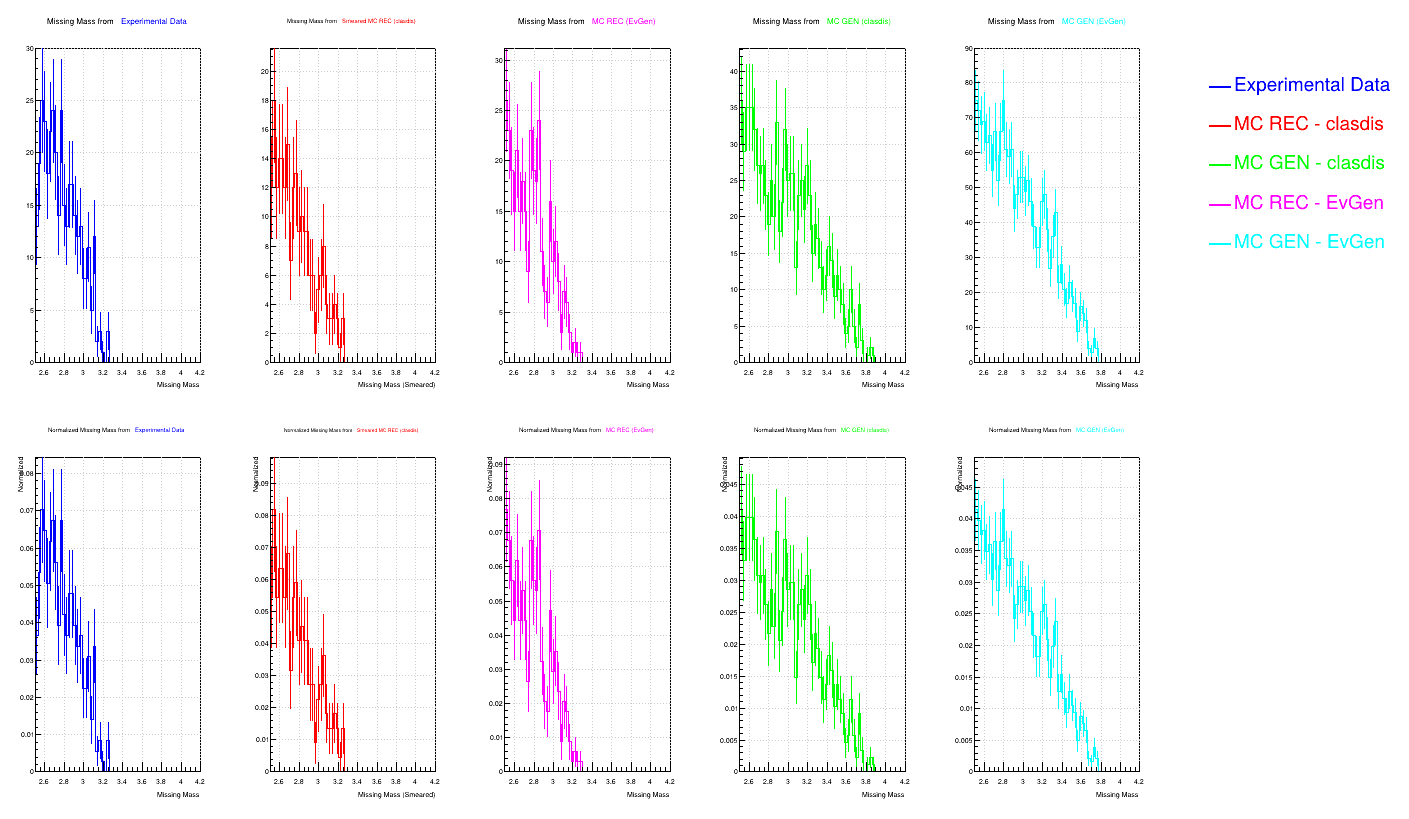

In [6]:
print(f"\n{color.BOLD}CREATING 1D MM HISTOGRAMS FOR HIGH-Mx NORMALIZATION FACTOR\n{color.END}")

MM_Binning = ['MM', 2.5, 4.2, 60]

histos = {}

var, Min_range, Max_range, Num_of_Bins = MM_Binning
rdf_name = f"{var}_rdf"
mclasdis = f"{var}_mdf_clasdis"
mdfEvGen = f"{var}_mdf_EvGen"
gclasdis = f"{var}_gdf_clasdis"
gdfEvGen = f"{var}_gdf_EvGen"

Title = f"{variable_Title_name_new(var)} from SOURCE; {variable_Title_name_new(var)}"

histos[rdf_name] =         rdf.Histo1D((rdf_name, Title.replace("SOURCE", f"#color[{ROOT.kBlue   }]{{Experimental Data}}"),         Num_of_Bins, Min_range, Max_range),    var)
histos[mclasdis] = mdf_clasdis.Histo1D((mclasdis, Title.replace("SOURCE", f"#color[{ROOT.kRed    }]{{Smeared MC REC (clasdis)}}"),  Num_of_Bins, Min_range, Max_range), f"{var}_smeared")
histos[mdfEvGen] =   mdf_EvGen.Histo1D((mdfEvGen, Title.replace("SOURCE", f"#color[{ROOT.kMagenta}]{{MC REC (EvGen)}}"),            Num_of_Bins, Min_range, Max_range),    var)
histos[gclasdis] = gdf_clasdis.Histo1D((gclasdis, Title.replace("SOURCE", f"#color[{ROOT.kGreen  }]{{MC GEN (clasdis)}}"),          Num_of_Bins, Min_range, Max_range),    var)
histos[gdfEvGen] =   gdf_EvGen.Histo1D((gdfEvGen, Title.replace("SOURCE", f"#color[{ROOT.kCyan   }]{{MC GEN (EvGen)}}"),            Num_of_Bins, Min_range, Max_range),    var)


histos[mclasdis].GetXaxis().SetTitle(f"{variable_Title_name_new(var)} (Smeared)")

histos[rdf_name].SetLineColor(ROOT.kBlue)
histos[mclasdis].SetLineColor(ROOT.kRed)
histos[mdfEvGen].SetLineColor(ROOT.kMagenta)
histos[gclasdis].SetLineColor(ROOT.kGreen)
histos[gdfEvGen].SetLineColor(ROOT.kCyan)

rdf_name_norm_factor_HIGH_MX = histos[rdf_name].Integral()
mclasdis_norm_factor_HIGH_MX = histos[mclasdis].Integral()
mdfEvGen_norm_factor_HIGH_MX = histos[mdfEvGen].Integral()
gclasdis_norm_factor_HIGH_MX = histos[gclasdis].Integral()
gdfEvGen_norm_factor_HIGH_MX = histos[gdfEvGen].Integral()


print(f"rdf_name_norm_factor_HIGH_MX = {rdf_name_norm_factor_HIGH_MX:>20.0f}")
print(f"mclasdis_norm_factor_HIGH_MX = {mclasdis_norm_factor_HIGH_MX:>20.0f}")
print(f"mdfEvGen_norm_factor_HIGH_MX = {mdfEvGen_norm_factor_HIGH_MX:>20.0f}")
print(f"gclasdis_norm_factor_HIGH_MX = {gclasdis_norm_factor_HIGH_MX:>20.0f}")
print(f"gdfEvGen_norm_factor_HIGH_MX = {gdfEvGen_norm_factor_HIGH_MX:>20.0f}")


histos[f"norm_{rdf_name}"] = histos[rdf_name].Clone(f"norm_{rdf_name}")
histos[f"norm_{mclasdis}"] = histos[mclasdis].Clone(f"norm_{mclasdis}")
histos[f"norm_{mdfEvGen}"] = histos[mdfEvGen].Clone(f"norm_{mdfEvGen}")
histos[f"norm_{gclasdis}"] = histos[gclasdis].Clone(f"norm_{gclasdis}")
histos[f"norm_{gdfEvGen}"] = histos[gdfEvGen].Clone(f"norm_{gdfEvGen}")

histos[f"norm_{rdf_name}"].Scale((1/rdf_name_norm_factor_HIGH_MX) if(rdf_name_norm_factor_HIGH_MX != 0) else 1)
histos[f"norm_{mclasdis}"].Scale((1/mclasdis_norm_factor_HIGH_MX) if(mclasdis_norm_factor_HIGH_MX != 0) else 1)
histos[f"norm_{mdfEvGen}"].Scale((1/mdfEvGen_norm_factor_HIGH_MX) if(mdfEvGen_norm_factor_HIGH_MX != 0) else 1)
histos[f"norm_{gclasdis}"].Scale((1/gclasdis_norm_factor_HIGH_MX) if(gclasdis_norm_factor_HIGH_MX != 0) else 1)
histos[f"norm_{gdfEvGen}"].Scale((1/gdfEvGen_norm_factor_HIGH_MX) if(gdfEvGen_norm_factor_HIGH_MX != 0) else 1)

histos[f"norm_{rdf_name}"].SetTitle(f"Normalized {histos[rdf_name].GetTitle()}")
histos[f"norm_{mclasdis}"].SetTitle(f"Normalized {histos[mclasdis].GetTitle()}")
histos[f"norm_{mdfEvGen}"].SetTitle(f"Normalized {histos[mdfEvGen].GetTitle()}")
histos[f"norm_{gclasdis}"].SetTitle(f"Normalized {histos[gclasdis].GetTitle()}")
histos[f"norm_{gdfEvGen}"].SetTitle(f"Normalized {histos[gdfEvGen].GetTitle()}")

histos[f"norm_{rdf_name}"].GetYaxis().SetTitle("Normalized")
histos[f"norm_{mclasdis}"].GetYaxis().SetTitle("Normalized")
histos[f"norm_{mdfEvGen}"].GetYaxis().SetTitle("Normalized")
histos[f"norm_{gclasdis}"].GetYaxis().SetTitle("Normalized")
histos[f"norm_{gdfEvGen}"].GetYaxis().SetTitle("Normalized")

canvas = ROOT.TCanvas("MM_Norm_Factor", "My Canvas", int(912*1.55), int(547*1.55))
canvas.Divide(6, 2)

for cd_num, ii in enumerate([rdf_name, mclasdis, mdfEvGen, gclasdis, gdfEvGen]):
    canvas.cd(cd_num + 1)
    histos[ii].GetYaxis().SetRangeUser(0, 1.2*find_max_bin(histos[ii]))
    histos[ii].Draw("E0 hist same")
    canvas.cd(cd_num + 7)
    histos[f"norm_{ii}"].GetYaxis().SetRangeUser(0, 1.2*find_max_bin(histos[f"norm_{ii}"]))
    histos[f"norm_{ii}"].Draw("E0 hist same")

# Draw Legend(s)
canvas.cd(6)
ROOT.gPad.Clear()
ROOT.gPad.SetLeftMargin(0.2)
ROOT.gPad.SetBottomMargin(0.2)

group_info = [(ROOT.kBlue,    "Experimental Data"),
              (ROOT.kRed,     "MC REC - clasdis"),
              (ROOT.kGreen,   "MC GEN - clasdis"),
              (ROOT.kMagenta, "MC REC - EvGen"),
              (ROOT.kCyan,    "MC GEN - EvGen"),
             ]
y = 0.8
for color_ii, label in group_info:
    line = ROOT.TLine()
    line.SetLineWidth(2)
    line.SetLineColor(color_ii)
    line.DrawLineNDC(0.1, y, 0.2, y)
    text = ROOT.TLatex()
    text.SetNDC()
    text.SetTextColor(color_ii)
    text.SetTextSize(0.1)
    text.SetTextFont(42)
    text.DrawLatex(0.22, y-0.01, label)
    y -= 0.1  # move down for next entry

canvas.Draw()

print("Done")

In [7]:
canvas_compare = None

In [8]:
print(f"\n{color.BOLD}CREATING 1D HISTOGRAMS/PLOTS\n{color.END}")

phi_t_Binning              = ['phi_t',                            0,      360,    24]
El_Binning                 = ['el',                               0,        8,   200]
El_Th_Binning              = ['elth',                             0,       40,   200]
El_Phi_Binning             = ['elPhi',                            0,      360,   200]
Pip_Binning                = ['pip',                              0,        6,   200]
Pip_Th_Binning             = ['pipth',                            0,       40,   200]
Pip_Phi_Binning            = ['pipPhi',                           0,      360,   200]
Q2_Binning                 = ['Q2',                               0,       14,   280]
y_Binning                  = ['y',                                0,        1,   100]
# y_Binning                  = ['y',                              0.9,        1,   100]
xB_Binning                 = ['xB',                            0.09,    0.826,    50]
z_Binning                  = ['z',                                0,     1.20,   120]
# z_Binning                  = ['z',                                0,     0.20,   120]
# pT_Binning                 = ['pT',                               0,     2.00,   200]
pT_Binning                 = ['pT',                               0,     1.50,   150]
MM_Binning                 = ['MM',                               0,      4.2,    60]
W_Binning                  = ['W',                              0.9,      5.1,    14]
Q2_y_z_pT_Binning          = ['Q2_y_z_pT_4D_Bin',              -0.5,    506.5,   507]
z_pT_phi_h_Binning         = ['MultiDim_z_pT_Bin_Y_bin_phi_t', -1.5,    913.5,   915]
Q2_y_z_pT_phi_h_5D_Binning = ['MultiDim_Q2_y_z_pT_phi_h',      -0.5,  11815.5, 11816]
Hx_Binning                 = ['Hx',                            -400,      400,   800]
Hy_Binning                 = ['Hy',                            -400,      400,   800]
z_pT_Bin_Y_Binning         = ['z_pT_Bin_Y_bin',                -2.5,     41.5,    44]

List_of_Quantities_1D = []
# List_of_Quantities_1D.append(MM_Binning)
# List_of_Quantities_1D.append(W_Binning)
# List_of_Quantities_1D.append(Q2_Binning)
# List_of_Quantities_1D.append(y_Binning)
# List_of_Quantities_1D.append(xB_Binning)
# List_of_Quantities_1D.append(z_Binning)
# List_of_Quantities_1D.append(pT_Binning)
# List_of_Quantities_1D.append(phi_t_Binning)
# List_of_Quantities_1D.append(z_pT_Bin_Y_Binning)

if(not canvas_compare):
    histos_compare, canvas_compare = {}, {}

for num, (var, Min_range, Max_range, Num_of_Bins) in enumerate(List_of_Quantities_1D):
    rdf_name = f"{var}_rdf"
    mclasdis = f"{var}_mdf_clasdis"
    mdfEvGen = f"{var}_mdf_EvGen"
    gclasdis = f"{var}_gdf_clasdis"
    gdfEvGen = f"{var}_gdf_EvGen"

    Title = f"Plot of {variable_Title_name_new(var)} from SOURCE; {variable_Title_name_new(var)}"
    
    histos_compare[rdf_name] =         rdf.Histo1D((rdf_name, Title.replace("SOURCE", f"#color[{ROOT.kBlue   }]{{Experimental Data}}"),         Num_of_Bins, Min_range, Max_range),    var)
    histos_compare[mclasdis] = mdf_clasdis.Histo1D((mclasdis, Title.replace("SOURCE", f"#color[{ROOT.kRed    }]{{Smeared MC REC (clasdis)}}"),  Num_of_Bins, Min_range, Max_range), f"{var}_smeared")
    histos_compare[mdfEvGen] =   mdf_EvGen.Histo1D((mdfEvGen, Title.replace("SOURCE", f"#color[{ROOT.kMagenta}]{{MC REC (EvGen)}}"),            Num_of_Bins, Min_range, Max_range),    var)
    histos_compare[gclasdis] = gdf_clasdis.Histo1D((gclasdis, Title.replace("SOURCE", f"#color[{ROOT.kGreen  }]{{MC GEN (clasdis)}}"),          Num_of_Bins, Min_range, Max_range),    var)
    histos_compare[gdfEvGen] =   gdf_EvGen.Histo1D((gdfEvGen, Title.replace("SOURCE", f"#color[{ROOT.kCyan   }]{{MC GEN (EvGen)}}"),            Num_of_Bins, Min_range, Max_range),    var)


    histos_compare[mclasdis].GetXaxis().SetTitle(f"{variable_Title_name_new(var)} (Smeared)")
    
    histos_compare[rdf_name].SetLineColor(ROOT.kBlue)
    histos_compare[mclasdis].SetLineColor(ROOT.kRed)
    histos_compare[mdfEvGen].SetLineColor(ROOT.kMagenta)
    histos_compare[gclasdis].SetLineColor(ROOT.kGreen)
    histos_compare[gdfEvGen].SetLineColor(ROOT.kCyan)

    use_HIGH_MX = True
    
    rdf_name_norm_factor = rdf_name_norm_factor_HIGH_MX if(use_HIGH_MX) else histos_compare[rdf_name].Integral()
    mclasdis_norm_factor = mclasdis_norm_factor_HIGH_MX if(use_HIGH_MX) else histos_compare[mclasdis].Integral()
    mdfEvGen_norm_factor = mdfEvGen_norm_factor_HIGH_MX if(use_HIGH_MX) else histos_compare[mdfEvGen].Integral()
    gclasdis_norm_factor = gclasdis_norm_factor_HIGH_MX if(use_HIGH_MX) else histos_compare[gclasdis].Integral()
    gdfEvGen_norm_factor = gdfEvGen_norm_factor_HIGH_MX if(use_HIGH_MX) else histos_compare[gdfEvGen].Integral()


    histos_compare[f"norm_{rdf_name}"] = histos_compare[rdf_name].Clone(f"norm_{rdf_name}")
    histos_compare[f"norm_{mclasdis}"] = histos_compare[mclasdis].Clone(f"norm_{mclasdis}")
    histos_compare[f"norm_{mdfEvGen}"] = histos_compare[mdfEvGen].Clone(f"norm_{mdfEvGen}")
    histos_compare[f"norm_{gclasdis}"] = histos_compare[gclasdis].Clone(f"norm_{gclasdis}")
    histos_compare[f"norm_{gdfEvGen}"] = histos_compare[gdfEvGen].Clone(f"norm_{gdfEvGen}")

    histos_compare[f"norm_{rdf_name}"].Scale((1/rdf_name_norm_factor) if(rdf_name_norm_factor != 0) else 1)
    histos_compare[f"norm_{mclasdis}"].Scale((1/mclasdis_norm_factor) if(mclasdis_norm_factor != 0) else 1)
    histos_compare[f"norm_{mdfEvGen}"].Scale((1/mdfEvGen_norm_factor) if(mdfEvGen_norm_factor != 0) else 1)
    histos_compare[f"norm_{gclasdis}"].Scale((1/gclasdis_norm_factor) if(gclasdis_norm_factor != 0) else 1)
    histos_compare[f"norm_{gdfEvGen}"].Scale((1/gdfEvGen_norm_factor) if(gdfEvGen_norm_factor != 0) else 1)
    
    canvas_compare[var] = ROOT.TCanvas(f"compare_{var}", "My Canvas", int(912*1.55), int(547*1.55))
    canvas_compare[var].Divide(5, 2)

    max_cd_1     = max([find_max_bin(histos_compare[f"norm_{mdfEvGen}"]), find_max_bin(histos_compare[f"norm_{mclasdis}"])])
    max_cd_3     = max([find_max_bin(histos_compare[f"norm_{mdfEvGen}"]), find_max_bin(histos_compare[f"norm_{rdf_name}"])])
    max_cd_4     = max([find_max_bin(histos_compare[f"norm_{mclasdis}"]), find_max_bin(histos_compare[f"norm_{rdf_name}"])])
    max_cd_1_3_4 = max([max_cd_1, max_cd_3, max_cd_4])

    canvas_compare[var].cd(1)
    mdf_title = f"Comparison of REC MC's for {variable_Title_name_new(var)}"
    mdf_title = f"#scale[2]{{{mdf_title}}}"
    histos_compare[f"norm_{mdfEvGen}"].SetTitle(mdf_title)
    histos_compare[f"norm_{mdfEvGen}"].GetYaxis().SetRangeUser(0, 1.2*max_cd_1_3_4)
    histos_compare[f"norm_{mdfEvGen}"].Draw("E0 hist same")
    histos_compare[f"norm_{mclasdis}"].Draw("E0 hist same")

    canvas_compare[var].cd(6)
    histos_compare[f"Diff_in_{mdfEvGen}"] = histos_compare[f"norm_{mdfEvGen}"].Clone(f"Diff_in_{mdfEvGen}")
    histos_compare[f"Diff_in_{mdfEvGen}"].Divide(histos_compare[f"norm_{mclasdis}"])
    histos_compare[f"Diff_in_{mdfEvGen}"].SetTitle("#scale[2]{Ratio of REC MC's above}")
    histos_compare[f"Diff_in_{mdfEvGen}"].GetYaxis().SetTitle("#frac{EvGen}{clasdis}")
    histos_compare[f"Diff_in_{mdfEvGen}"].SetLineColor(ROOT.kPink - 7)
    histos_compare[f"Diff_in_{mdfEvGen}"].GetYaxis().SetRangeUser(0, 1.2*find_max_bin(histos_compare[f"Diff_in_{mdfEvGen}"]))
    histos_compare[f"Diff_in_{mdfEvGen}"].Draw("E0 hist same")
    xmin = histos_compare[f"Diff_in_{mdfEvGen}"].GetXaxis().GetXmin()
    xmax = histos_compare[f"Diff_in_{mdfEvGen}"].GetXaxis().GetXmax()
    histos_compare[f"line_{mdfEvGen}"] = ROOT.TLine(xmin, 1.0, xmax, 1.0)
    histos_compare[f"line_{mdfEvGen}"].SetLineColor(ROOT.kGray + 3)
    histos_compare[f"line_{mdfEvGen}"].SetLineWidth(2)
    histos_compare[f"line_{mdfEvGen}"].SetLineStyle(2)
    histos_compare[f"line_{mdfEvGen}"].Draw("same")
    
    canvas_compare[var].cd(2)
    gdf_title = f"Comparison of GEN MC's for {variable_Title_name_new(var)}"
    gdf_title = f"#scale[2]{{{gdf_title}}}"
    histos_compare[f"norm_{gdfEvGen}"].SetTitle(gdf_title)
    max_cd_2 = max([find_max_bin(histos_compare[f"norm_{gdfEvGen}"]), find_max_bin(histos_compare[f"norm_{gclasdis}"])])
    histos_compare[f"norm_{gdfEvGen}"].GetYaxis().SetRangeUser(0, 1.2*max_cd_2)
    histos_compare[f"norm_{gdfEvGen}"].Draw("E0 hist same")
    histos_compare[f"norm_{gclasdis}"].Draw("E0 hist same")

    canvas_compare[var].cd(7)
    histos_compare[f"Diff_in_{gdfEvGen}"] = histos_compare[f"norm_{gdfEvGen}"].Clone(f"Diff_in_{gdfEvGen}")
    histos_compare[f"Diff_in_{gdfEvGen}"].Divide(histos_compare[f"norm_{gclasdis}"])
    histos_compare[f"Diff_in_{gdfEvGen}"].SetTitle("#scale[2]{Ratio of GEN MC's above}")
    histos_compare[f"Diff_in_{gdfEvGen}"].GetYaxis().SetTitle("#frac{EvGen}{clasdis}")
    histos_compare[f"Diff_in_{gdfEvGen}"].SetLineColor(ROOT.kSpring + 9)
    histos_compare[f"Diff_in_{gdfEvGen}"].GetYaxis().SetRangeUser(0, 1.2*find_max_bin(histos_compare[f"Diff_in_{gdfEvGen}"]))
    histos_compare[f"Diff_in_{gdfEvGen}"].Draw("E0 hist same")
    histos_compare[f"line_{mdfEvGen}"].Draw("same")

    canvas_compare[var].cd(3)
    rdf_title_EvGen = f"#splitline{{Comparison of}}{{Data to EvGen MC for {variable_Title_name_new(var)}}}"
    rdf_title_EvGen = f"#scale[2]{{{rdf_title_EvGen}}}"
    histos_compare[f"norm_{rdf_name}"].SetTitle(rdf_title_EvGen)
    histos_compare[f"norm_{rdf_name}"].GetYaxis().SetRangeUser(0, 1.2*max_cd_1_3_4)
    histos_compare[f"norm_{rdf_name}"].Draw("E0 hist same")
    histos_compare[f"norm_{mdfEvGen}"].Draw("E0 hist same")

    canvas_compare[var].cd(4)
    rdf_title_clasdis = f"#splitline{{Comparison of}}{{Data to clasdis MC for {variable_Title_name_new(var)}}}"
    rdf_title_clasdis = f"#scale[2]{{{rdf_title_clasdis}}}"
    histos_compare[f"norm_{mclasdis}"].SetTitle(rdf_title_clasdis)
    histos_compare[f"norm_{mclasdis}"].GetYaxis().SetRangeUser(0, 1.2*max_cd_1_3_4)
    histos_compare[f"norm_{mclasdis}"].Draw("E0 hist same")
    histos_compare[f"norm_{rdf_name}"].Draw("E0 hist same")

    # canvas_compare[var].cd(8)
    histos_compare[f"Diff_in_{rdf_name}"] = histos_compare[f"norm_{rdf_name}"].Clone(f"Diff_in_{rdf_name}")
    histos_compare[f"Diff_in_{rdf_name}"].Divide(histos_compare[f"norm_{mdfEvGen}"])
    histos_compare[f"Diff_in_{rdf_name}"].SetTitle("#scale[2]{Ratio of Data to EvGen MC above}")
    histos_compare[f"Diff_in_{rdf_name}"].GetYaxis().SetTitle("#frac{Data}{EvGen}")
    histos_compare[f"Diff_in_{rdf_name}"].SetLineColor(ROOT.kViolet + 1)
    # canvas_compare[var].cd(9)
    histos_compare[f"Diff_in_{mclasdis}"] = histos_compare[f"norm_{rdf_name}"].Clone(f"Diff_in_{mclasdis}")
    histos_compare[f"Diff_in_{mclasdis}"].Divide(histos_compare[f"norm_{mclasdis}"])
    histos_compare[f"Diff_in_{mclasdis}"].SetTitle("#scale[2]{Ratio of Data to clasdis MC above}")
    histos_compare[f"Diff_in_{mclasdis}"].GetYaxis().SetTitle("#frac{Data}{clasdis}")
    histos_compare[f"Diff_in_{mclasdis}"].SetLineColor(ROOT.kBlue + 3)
    max_cd_8_9 = max([find_max_bin(histos_compare[f"Diff_in_{rdf_name}"]), find_max_bin(histos_compare[f"Diff_in_{mclasdis}"])])
    
    canvas_compare[var].cd(8)
    histos_compare[f"Diff_in_{rdf_name}"].GetYaxis().SetRangeUser(0, 1.2*max_cd_8_9)
    histos_compare[f"Diff_in_{rdf_name}"].Draw("E0 hist same")
    histos_compare[f"line_{mdfEvGen}"].Draw("same")

    canvas_compare[var].cd(9)
    histos_compare[f"Diff_in_{mclasdis}"].GetYaxis().SetRangeUser(0, 1.2*max_cd_8_9)
    histos_compare[f"Diff_in_{mclasdis}"].Draw("E0 hist same")
    histos_compare[f"line_{mdfEvGen}"].Draw("same")


    # Draw Legend(s)
    canvas_compare[var].cd(5)
    ROOT.gPad.Clear()
    ROOT.gPad.SetLeftMargin(0.2)
    ROOT.gPad.SetBottomMargin(0.2)
    
    group_info = [(ROOT.kBlue,    "Experimental Data"),
                  (ROOT.kRed,     "MC REC - clasdis"),
                  (ROOT.kGreen,   "MC GEN - clasdis"),
                  (ROOT.kMagenta, "MC REC - EvGen"),
                  (ROOT.kCyan,    "MC GEN - EvGen"),
                 ]
    y = 0.8
    for color_ii, label in group_info:
        line = ROOT.TLine()
        line.SetLineWidth(2)
        line.SetLineColor(color_ii)
        line.DrawLineNDC(0.1, y, 0.2, y)
        text = ROOT.TLatex()
        text.SetNDC()
        text.SetTextColor(color_ii)
        text.SetTextSize(0.1)
        text.SetTextFont(42)
        text.DrawLatex(0.22, y-0.01, label)
        y -= 0.1  # move down for next entry

    canvas_compare[var].Draw()



print("Done")


CREATING 1D HISTOGRAMS/PLOTS

Done


In [9]:
print(f"\n{color.BOLD}DRAWING ALL AVAILABLE 'canvas_compare' TCanvas\n{color.END}")
for ii in canvas_compare:
    print(f"Drawing: {ii}")
    canvas_compare[ii].Draw()
print("Done")


DRAWING ALL AVAILABLE 'canvas_compare' TCanvas

Done


In [10]:
canvas_acceptance = None

In [11]:
print(f"\n{color.BOLD}CREATING 1D ACCEPTANCE HISTOGRAMS/PLOTS\n{color.END}")

phi_t_Binning              = ['phi_t',                            0,      360,    24]
El_Binning                 = ['el',                               0,        8,   200]
El_Th_Binning              = ['elth',                             0,       40,   200]
El_Phi_Binning             = ['elPhi',                            0,      360,   200]
Pip_Binning                = ['pip',                              0,        6,   200]
Pip_Th_Binning             = ['pipth',                            0,       40,   200]
Pip_Phi_Binning            = ['pipPhi',                           0,      360,   200]
Q2_Binning                 = ['Q2',                               0,       14,   280]
y_Binning                  = ['y',                                0,        1,   100]
xB_Binning                 = ['xB',                            0.09,    0.826,    50]
z_Binning                  = ['z',                                0,     1.20,   120]
# z_Binning                  = ['z',                                0,     0.20,   120]
pT_Binning                 = ['pT',                               0,     2.00,   200]
MM_Binning                 = ['MM',                               0,      4.2,    60]
# W_Binning                  = ['W',                              0.9,      5.1,    14]
W_Binning                  = ['W',                              0.9,      5.1,    56]
Q2_y_z_pT_Binning          = ['Q2_y_z_pT_4D_Bin',              -0.5,    506.5,   507]
z_pT_phi_h_Binning         = ['MultiDim_z_pT_Bin_Y_bin_phi_t', -1.5,    913.5,   915]
Q2_y_z_pT_phi_h_5D_Binning = ['MultiDim_Q2_y_z_pT_phi_h',      -0.5,  11815.5, 11816]
Hx_Binning                 = ['Hx',                            -400,      400,   800]
Hy_Binning                 = ['Hy',                            -400,      400,   800]


List_of_Quantities_1D = []
# List_of_Quantities_1D.append(MM_Binning)
# List_of_Quantities_1D.append(W_Binning)
# List_of_Quantities_1D.append(phi_t_Binning)
# List_of_Quantities_1D.append(Q2_Binning)
# List_of_Quantities_1D.append(y_Binning)
# List_of_Quantities_1D.append(xB_Binning)
# List_of_Quantities_1D.append(z_Binning)
# List_of_Quantities_1D.append(pT_Binning)

if(not canvas_acceptance):
    histos_acceptance, canvas_acceptance = {}, {}

for num, (var, Min_range, Max_range, Num_of_Bins) in enumerate(List_of_Quantities_1D):
    mclasdis = f"{var}_mdf_clasdis"
    mdfEvGen = f"{var}_mdf_EvGen"
    gclasdis = f"{var}_gdf_clasdis"
    gdfEvGen = f"{var}_gdf_EvGen"

    Title = f"Acceptance Plot of {variable_Title_name_new(var)} from SOURCE; {variable_Title_name_new(var)}"
    
    histos_acceptance[mclasdis] = mdf_clasdis.Histo1D((mclasdis, Title.replace("SOURCE", f"#color[{ROOT.kRed    }]{{Smeared MC REC (clasdis)}}"),  Num_of_Bins, Min_range, Max_range), f"{var}_smeared")
    histos_acceptance[mdfEvGen] =   mdf_EvGen.Histo1D((mdfEvGen, Title.replace("SOURCE", f"#color[{ROOT.kMagenta}]{{MC REC (EvGen)}}"),            Num_of_Bins, Min_range, Max_range),    var)
    histos_acceptance[gclasdis] = gdf_clasdis.Histo1D((gclasdis, Title.replace("SOURCE", f"#color[{ROOT.kGreen  }]{{MC GEN (clasdis)}}"),          Num_of_Bins, Min_range, Max_range),    var)
    histos_acceptance[gdfEvGen] =   gdf_EvGen.Histo1D((gdfEvGen, Title.replace("SOURCE", f"#color[{ROOT.kCyan   }]{{MC GEN (EvGen)}}"),            Num_of_Bins, Min_range, Max_range),    var)

    histos_acceptance[mclasdis].GetXaxis().SetTitle(f"{variable_Title_name_new(var)} (Smeared)")
    
    histos_acceptance[mclasdis].SetLineColor(ROOT.kRed)
    histos_acceptance[mdfEvGen].SetLineColor(ROOT.kMagenta)
    histos_acceptance[gclasdis].SetLineColor(ROOT.kGreen)
    histos_acceptance[gdfEvGen].SetLineColor(ROOT.kCyan)
    
    canvas_acceptance[var] = ROOT.TCanvas(f"Acceptance_{var}", "My Canvas", int(912*1.55), int(547*1.55))
    canvas_acceptance[var].Divide(3, 1)

    histos_acceptance[mdfEvGen].Sumw2()
    histos_acceptance[gdfEvGen].Sumw2()
    histos_acceptance[mclasdis].Sumw2()
    histos_acceptance[gclasdis].Sumw2()

    canvas_acceptance[var].cd(1)
    histos_acceptance[f"Acceptance_{mdfEvGen}"] = histos_acceptance[mdfEvGen].Clone(f"Acceptance_{mdfEvGen}")
    histos_acceptance[f"Acceptance_{mdfEvGen}"].Divide(histos_acceptance[gdfEvGen].GetValue())
    title_cd_1 = f"#scale[2]{{Acceptance for {variable_Title_name_new(var)}}}"
    histos_acceptance[f"Acceptance_{mdfEvGen}"].SetTitle(title_cd_1)
    histos_acceptance[f"Acceptance_{mdfEvGen}"].GetYaxis().SetTitle("Acceptance")
    histos_acceptance[f"Acceptance_{mdfEvGen}"].SetLineColor(ROOT.kAzure)

    histos_acceptance[f"Acceptance_{mclasdis}"] = histos_acceptance[mclasdis].Clone(f"Acceptance_{mclasdis}")
    histos_acceptance[f"Acceptance_{mclasdis}"].Divide(histos_acceptance[gclasdis].GetValue())
    histos_acceptance[f"Acceptance_{mclasdis}"].SetTitle(title_cd_1)
    histos_acceptance[f"Acceptance_{mclasdis}"].GetYaxis().SetTitle("Acceptance")
    histos_acceptance[f"Acceptance_{mclasdis}"].SetLineColor(ROOT.kAzure + 10)

    cd_1_max = max([find_max_bin(histos_acceptance[f"Acceptance_{mdfEvGen}"]), find_max_bin(histos_acceptance[f"Acceptance_{mclasdis}"]), 0])
    
    histos_acceptance[f"Acceptance_{mdfEvGen}"].GetYaxis().SetRangeUser(0, 1.2*cd_1_max)
    histos_acceptance[f"Acceptance_{mclasdis}"].GetYaxis().SetRangeUser(0, 1.2*cd_1_max)
    
    histos_acceptance[f"Acceptance_{mdfEvGen}"].Draw("E0 hist same")
    histos_acceptance[f"Acceptance_{mclasdis}"].Draw("E0 hist same")
    xmin = histos_acceptance[f"Acceptance_{mdfEvGen}"].GetXaxis().GetXmin()
    xmax = histos_acceptance[f"Acceptance_{mdfEvGen}"].GetXaxis().GetXmax()
    histos_acceptance[f"line_{mdfEvGen}"] = ROOT.TLine(xmin, 1.0, xmax, 1.0)
    histos_acceptance[f"line_{mdfEvGen}"].SetLineColor(ROOT.kGray + 3)
    histos_acceptance[f"line_{mdfEvGen}"].SetLineWidth(2)
    histos_acceptance[f"line_{mdfEvGen}"].SetLineStyle(2)
    histos_acceptance[f"line_{mdfEvGen}"].Draw("same")

    canvas_acceptance[var].cd(2)
    ROOT.gPad.Clear()
    ROOT.gPad.SetLeftMargin(0.2)
    ROOT.gPad.SetBottomMargin(0.2)
    
    # map colors → group labels
    group_info = [(ROOT.kAzure,       "EvGen"),
                  (ROOT.kAzure + 10,  "clasdis"),]
    y = 0.8
    text = ROOT.TLatex()
    text.SetNDC()
    text.SetTextColor(ROOT.kBlack)
    text.SetTextSize(0.1)
    text.SetTextFont(42)
    text.DrawLatex(0.22, y-0.01, "Acceptance for:")
    y -= 0.1
    for color_ii, label in group_info:
        line = ROOT.TLine()
        line.SetLineWidth(2)
        line.SetLineColor(color_ii)
        line.DrawLineNDC(0.1, y, 0.2, y)
        text = ROOT.TLatex()
        text.SetNDC()
        text.SetTextColor(color_ii)
        text.SetTextSize(0.1)
        text.SetTextFont(42)
        text.DrawLatex(0.22, y-0.01, label)
        y -= 0.1  # move down for next entry


    canvas_acceptance[var].cd(3)    
    histos_acceptance[f"Comparison_of_Acceptance_{mdfEvGen}"] = histos_acceptance[f"Acceptance_{mdfEvGen}"].Clone(f"Comparison_of_Acceptance_{mdfEvGen}")
    histos_acceptance[f"Comparison_of_Acceptance_{mdfEvGen}"].Divide(histos_acceptance[f"Acceptance_{mclasdis}"])
    # histos_acceptance[f"Comparison_of_Acceptance_{mdfEvGen}"].Scale(100)
    title_cd_3 = f"Ratio of Acceptances for {variable_Title_name_new(var)}"
    histos_acceptance[f"Comparison_of_Acceptance_{mdfEvGen}"].SetTitle(title_cd_3)
    histos_acceptance[f"Comparison_of_Acceptance_{mdfEvGen}"].SetLineColor(ROOT.kBlack)
    histos_acceptance[f"Comparison_of_Acceptance_{mdfEvGen}"].GetYaxis().SetRangeUser(0, 1.2*max([find_max_bin(histos_acceptance[f"Comparison_of_Acceptance_{mdfEvGen}"]), 0]))
    histos_acceptance[f"Comparison_of_Acceptance_{mdfEvGen}"].Draw("E0 hist same")
    histos_acceptance[f"line_{mdfEvGen}"].Draw("same")
    
    

    # canvas_acceptance[var].Draw()



print("Done")


CREATING 1D ACCEPTANCE HISTOGRAMS/PLOTS

Done


In [12]:
print(f"\n{color.BOLD}DRAWING ALL AVAILABLE 'canvas_acceptance' TCanvas\n{color.END}")
for ii in canvas_acceptance:
    print(f"Drawing: {ii}")
    canvas_acceptance[ii].Draw()
print("Done")


DRAWING ALL AVAILABLE 'canvas_acceptance' TCanvas

Done


.

.

.

.

# BINNED ACCEPTANCE PLOTS

In [13]:
print(f"\n{color.BOLD}CREATING FUNCTIONS FOR MAKING KINEMATIC BINNED ACCEPTANCE PLOTS\n{color.END}")

def Create_Binned_Acceptance_Hist(mdf_IN, gdf_IN, source, PHI_T_Binning=['phi_t', 0, 360, 24], Q2_Y_Bin=None, Z_PT_Bin=None):
    var, Min_range, Max_range, Num_of_Bins = PHI_T_Binning
    mdf_name = f"{var}_mdf_{source}"
    gdf_name = f"{var}_gdf_{source}"
    if(Q2_Y_Bin):
        mdf_IN_Binned     =        mdf_IN.Filter(f"Q2_Y_Bin == {Q2_Y_Bin}")
        gdf_IN_Binned     =        gdf_IN.Filter(f"Q2_Y_Bin == {Q2_Y_Bin}")
        if(Z_PT_Bin):
            mdf_IN_Binned = mdf_IN_Binned.Filter(f"z_pT_Bin_Y_bin == {Z_PT_Bin}")
            gdf_IN_Binned = gdf_IN_Binned.Filter(f"z_pT_Bin_Y_bin == {Z_PT_Bin}")
            mdf_name      = f"{mdf_name} Bin ({Q2_Y_Bin}-{Z_PT_Bin})"
            gdf_name      = f"{gdf_name} Bin ({Q2_Y_Bin}-{Z_PT_Bin})"
        else:
            mdf_name      = f"{mdf_name} Bin ({Q2_Y_Bin}-All)"
            gdf_name      = f"{gdf_name} Bin ({Q2_Y_Bin}-All)"
    else:
        mdf_IN_Binned     =        mdf_IN
        gdf_IN_Binned     =        gdf_IN

    mdf_hist = mdf_IN_Binned.Histo1D((mdf_name, f"{variable_Title_name_new(var)} from MC REC ({source}); {variable_Title_name_new(var)}", Num_of_Bins, Min_range, Max_range), var if(source not in ["clasdis"]) else f"{var}_smeared")
    gdf_hist = gdf_IN_Binned.Histo1D((gdf_name, f"{variable_Title_name_new(var)} from MC GEN ({source}); {variable_Title_name_new(var)}", Num_of_Bins, Min_range, Max_range), var)

    if(source in ["clasdis"]):
        mdf_hist.SetTitle(f"(Smeared) {mdf_hist.GetTitle()}")
        mdf_hist.GetXaxis().SetTitle(f"{variable_Title_name_new(var)} (Smeared)")
    if(Q2_Y_Bin):
        if(Z_PT_Bin):
            mdf_hist.SetTitle(f"#splitline{{{mdf_hist.GetTitle()}}}{{#color[{ROOT.kRed}]{{Q^{{2}}-y Bin: {Q2_Y_Bin}}} #topbar #color[{ROOT.kRed}]{{z-P_{{T}} Bin: {Z_PT_Bin}}}}}")
            gdf_hist.SetTitle(f"#splitline{{{gdf_hist.GetTitle()}}}{{#color[{ROOT.kRed}]{{Q^{{2}}-y Bin: {Q2_Y_Bin}}} #topbar #color[{ROOT.kRed}]{{z-P_{{T}} Bin: {Z_PT_Bin}}}}}")
        else:
            mdf_hist.SetTitle(f"#splitline{{{mdf_hist.GetTitle()}}}{{#color[{ROOT.kRed}]{{Q^{{2}}-y Bin: {Q2_Y_Bin}}}}}")
            gdf_hist.SetTitle(f"#splitline{{{gdf_hist.GetTitle()}}}{{#color[{ROOT.kRed}]{{Q^{{2}}-y Bin: {Q2_Y_Bin}}}}}")
            
    mdf_hist.SetLineColor(ROOT.kRed   if(source in ["clasdis"]) else ROOT.kMagenta)
    gdf_hist.SetLineColor(ROOT.kGreen if(source in ["clasdis"]) else ROOT.kCyan)
    
    mdf_hist.Sumw2()
    gdf_hist.Sumw2()
    
    acc_hist  = mdf_hist.Clone(mdf_name.replace("mdf", "Acceptance"))
    acc_hist.Divide(gdf_hist.GetValue())
    # acc_title = f"#scale[2]{{Acceptance for {variable_Title_name_new(var)} from {source}}}"
    acc_title = f"#scale[1]{{Acceptance for {variable_Title_name_new(var)} from {source}}}"
    if(Q2_Y_Bin):
        if(Z_PT_Bin):
            acc_title = f"#splitline{{{acc_title}}}{{#color[{ROOT.kRed}]{{Q^{{2}}-y Bin: {Q2_Y_Bin}}} #topbar #color[{ROOT.kRed}]{{z-P_{{T}} Bin: {Z_PT_Bin}}}}}"
        else:
            acc_title = f"#splitline{{{acc_title}}}{{#color[{ROOT.kRed}]{{Q^{{2}}-y Bin: {Q2_Y_Bin}}}}}"
    acc_hist.SetTitle(acc_title)
    acc_hist.GetYaxis().SetTitle("Acceptance")
    acc_hist.SetLineColor(ROOT.kAzure if(source not in ["clasdis"]) else ROOT.kAzure + 10)

    return mdf_hist, gdf_hist, acc_hist



def Acceptance_Compare_z_pT_Images_Together(Histogram_List_All, Q2_Y_Bin, Plot_Orientation="z_pT", Saving_Q=True, File_Save_Format=".png"):
    ################################################################################################################################################################################################################################################################################################################################################################################################################
    ####  Canvas (Main) Creation  ##################################################################################################################################################################################################################################################################################################################################################################################
    # Use above for normal size, use below for 2x size (made with PDFs)
    Save_Name = f"Acceptance_Compare_for_Q2_Y_Bin_{Q2_Y_Bin}"
    # All_z_pT_Canvas = Canvas_Create(Name=Save_Name, Num_Columns=2, Num_Rows=1, Size_X=int(1800*4), Size_Y=int(1500*4), cd_Space=0.01)
    All_z_pT_Canvas = Canvas_Create(Name=Save_Name, Num_Columns=2, Num_Rows=1, Size_X=int(1800), Size_Y=int(1500), cd_Space=0.01)
    All_z_pT_Canvas.SetFillColor(ROOT.kGray)
    All_z_pT_Canvas_cd_1       = All_z_pT_Canvas.cd(1)
    All_z_pT_Canvas_cd_1.SetFillColor(ROOT.kGray)
    All_z_pT_Canvas_cd_1.SetPad(xlow=0.005, ylow=0.015, xup=0.27, yup=0.985)
    All_z_pT_Canvas_cd_1.Divide(1, 2, 0, 0)

    All_z_pT_Canvas_cd_1_Upper = All_z_pT_Canvas_cd_1.cd(1)
    All_z_pT_Canvas_cd_1_Upper.SetPad(xlow=0, ylow=0.425, xup=1, yup=1)
    All_z_pT_Canvas_cd_1_Upper.Divide(1, 2, 0, 0)

    All_z_pT_Canvas_cd_1_Lower = All_z_pT_Canvas_cd_1.cd(2)
    All_z_pT_Canvas_cd_1_Lower.SetPad(xlow=0, ylow=0, xup=1, yup=0.42)
    All_z_pT_Canvas_cd_1_Lower.Divide(1, 1, 0, 0)
    All_z_pT_Canvas_cd_1_Lower.cd(1).SetPad(xlow=0.035, ylow=0.025, xup=0.95, yup=0.975)

    All_z_pT_Canvas_cd_2               = All_z_pT_Canvas.cd(2)
    All_z_pT_Canvas_cd_2.SetPad(xlow=0.28, ylow=0.015, xup=0.995, yup=0.9975)
    All_z_pT_Canvas_cd_2.SetFillColor(ROOT.kGray)

    if(Plot_Orientation in ["z_pT"]):
        number_of_rows, number_of_cols = Get_Num_of_z_pT_Rows_and_Columns(Q2_Y_Bin_Input=Q2_Y_Bin)
        All_z_pT_Canvas_cd_2.Divide(number_of_cols, number_of_rows, 0.0001, 0.0001)
    else:
        number_of_rows, number_of_cols = Get_Num_of_z_pT_Rows_and_Columns(Q2_Y_Bin_Input=Q2_Y_Bin)
        All_z_pT_Canvas_cd_2.Divide(1, number_of_cols, 0.0001, 0.0001)
        for ii in range(1, number_of_cols + 1, 1):
            All_z_pT_Canvas_cd_2_cols = All_z_pT_Canvas_cd_2.cd(ii)
            All_z_pT_Canvas_cd_2_cols.Divide(number_of_rows, 1, 0.0001, 0.0001)
    
    ####  Canvas (Main) Creation End ###############################################################################################################################################################################################################################################################################################################################################################################
    ################################################################################################################################################################################################################################################################################################################################################################################################################
    
    ################################################################################################################################################################################################################################################################################################################################################################################################################
    ####  Filling Canvas (Left)  ###################################################################################################################################################################################################################################################################################################################################################################################
    
    ###################################################################### ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
    ####  Upper Left - i.e., 2D Histograms  ############################## ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
    Q2_y_Name = f"Q2-y Bin ({Q2_Y_Bin}-All)"
    z_pT_Name = f"z-pT Bin ({Q2_y_Bin}-All)"
    ##===============##     Drawing Q2-y Histogram     ##===============## ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
    Draw_Canvas(All_z_pT_Canvas_cd_1_Upper, 1, 0.15)
    Histogram_List_All[Q2_y_Name].Draw("colz")
    Histogram_List_All[Q2_y_Name].SetStats(1)
    # ROOT.gStyle.SetOptStat(0)
    ROOT.gStyle.SetOptStat("i")
    stats = Histogram_List_All[Q2_y_Name].GetListOfFunctions().FindObject("stats")
    if(stats):
        stats.SetX1NDC(0.80)  # New X start position
        stats.SetX2NDC(0.90)  # New X end position
        stats.SetY1NDC(0.85) # New Y start position
        stats.SetY2NDC(0.95) # New Y end position
    else:
        print(f"{color.Error}Error in (Q2-y) stat_box of Histogram_List_All[{Q2_y_Name}]...{color.END}\n\tstats = {stats}")
    palette_move(canvas=All_z_pT_Canvas_cd_1_Upper.cd(1), histo=Histogram_List_All[Q2_y_Name], x_left=0.905, x_right=0.925, y_up=0.9, y_down=0.1)
    # Histogram_List_All[Q2_y_Name].SetStats(0)
    Q2_y_borders = {}
    for Q2_Y_Bin_ii in range(1, 18, 1):
        Q2_y_borders[Q2_Y_Bin_ii] = Draw_Q2_Y_Bins(Input_Bin=Q2_Y_Bin_ii)
        for line in Q2_y_borders[Q2_Y_Bin_ii]:
            line.Draw("same")
    if(Q2_Y_Bin in range(1,18)):
        for line_Bin in Q2_y_borders[Q2_Y_Bin]:
            line_Bin.SetLineColor(ROOT.kRed)
            line_Bin.SetLineWidth(6)
            line_Bin.Draw("same")
    ##===============##     Drawing Q2-y Histogram     ##===============## ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
    ###################################################################### ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
    ##===============##     Drawing z-pT Histogram     ##===============## ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
    Draw_Canvas(All_z_pT_Canvas_cd_1_Upper, 2, 0.15)
    Histogram_List_All[z_pT_Name].Draw("colz")
    Histogram_List_All[z_pT_Name].SetStats(1)
    ROOT.gStyle.SetOptStat("i")
    # ROOT.gStyle.SetOptStat(0)
    stats = Histogram_List_All[z_pT_Name].GetListOfFunctions().FindObject("stats")
    if(stats):
        stats.SetX1NDC(0.80)  # New X start position
        stats.SetX2NDC(0.90)  # New X end position
        stats.SetY1NDC(0.85) # New Y start position
        stats.SetY2NDC(0.95) # New Y end position
    else:
        print(f"{color.Error}Error in (z-pT) stat_box of Histogram_List_All[{z_pT_Name}]...{color.END}\n\tstats = {stats}")
    palette_move(canvas=All_z_pT_Canvas_cd_1_Upper.cd(2), histo=Histogram_List_All[z_pT_Name], x_left=0.905, x_right=0.925, y_up=0.9, y_down=0.1)
    # ROOT.gStyle.SetOptStat(1111)
    if(Plot_Orientation in ["pT_z"]):
        if(str(Q2_Y_Bin) not in ["0", "All"]):
            Histogram_List_All[z_pT_Name].GetXaxis().SetRangeUser(0, 1.2)
            Draw_z_pT_Bins_With_Migration(Q2_y_Bin_Num_In=Q2_Y_Bin, Set_Max_Y=1.2, Set_Max_X=1.2, Plot_Orientation_Input=Plot_Orientation)
            MM_z_pT_borders = {}
            MM_z_pT_legend = ROOT.TLegend(0.8, 0.1, 0.95, 0.4)
            MM_z_pT_legend.SetNColumns(1)
            MM_z_pT_borders, MM_z_pT_legend = Draw_the_MM_Cut_Lines(MM_z_pT_legend, MM_z_pT_borders, Q2_Y_Bin, Plot_Orientation)
            for MM_lines in MM_z_pT_borders:
                MM_z_pT_borders[MM_lines].Draw("same")
            MM_z_pT_legend.Draw("same")
    else:
        if(str(Q2_Y_Bin) not in ["All", "0"]):
            Histogram_List_All[z_pT_Name].GetXaxis().SetRangeUser(0, 1.2)
            Draw_z_pT_Bins_With_Migration(Q2_y_Bin_Num_In=Q2_Y_Bin, Set_Max_Y=1.2, Set_Max_X=1.2)
            MM_z_pT_borders = {}
            MM_z_pT_legend = ROOT.TLegend(0.5, 0.1, 0.9, 0.2)
            MM_z_pT_legend.SetNColumns(2)
            MM_z_pT_borders, MM_z_pT_legend = Draw_the_MM_Cut_Lines(MM_z_pT_legend, MM_z_pT_borders, Q2_Y_Bin, Plot_Orientation)
            for MM_lines in MM_z_pT_borders:
                MM_z_pT_borders[MM_lines].Draw("same")
            MM_z_pT_legend.Draw("same")
    ##===============##     Drawing z-pT Histogram     ##===============## ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
    ###################################################################### ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
    
    ####  Upper Left - i.e., 2D Histograms  ############################## ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
    ######################################################################=========================================================================================================================================================================================================================================================================#################################################################
    ######################################################################=========================================================================================================================================================================================================================================================================#################################################################
    ####  Lower Left - i.e., Integrated z-pT Bin  ######################## ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
    
    Draw_Canvas(All_z_pT_Canvas_cd_1_Lower, 1, 0.15)
    ROOT.gStyle.SetOptStat(0)
    cd_1_Lower_max = max([find_max_bin(Histogram_List_All[f"EvGen Acceptance Bin ({Q2_y_Bin}-All)"]), find_max_bin(Histogram_List_All[f"clasdis Acceptance Bin ({Q2_y_Bin}-All)"]), Histogram_List_All[f"Acceptance max for {Q2_y_Bin}"]])
    Histogram_List_All[f"EvGen Acceptance Bin ({Q2_y_Bin}-All)"].GetYaxis().SetRangeUser(0,   1.2*cd_1_Lower_max)
    Histogram_List_All[f"clasdis Acceptance Bin ({Q2_y_Bin}-All)"].GetYaxis().SetRangeUser(0, 1.2*cd_1_Lower_max)
    Histogram_List_All[f"EvGen Acceptance Bin ({Q2_y_Bin}-All)"].Draw("E0 hist")
    Histogram_List_All[f"clasdis Acceptance Bin ({Q2_y_Bin}-All)"].Draw("E0 hist same")
    
    legend = ROOT.TLegend(0.65, 0.70, 0.92, 0.88, "", "NDC")
    legend.SetNColumns(1)  # or 2 for side-by-side entries
    # legend.SetBorderSize(0)   # no border
    legend.SetFillStyle(1)    # transparent background
    legend.SetTextFont(42)
    legend.SetTextSize(0.035)
    legend.SetMargin(0.15)    # internal padding
    legend.AddEntry(Histogram_List_All[f"EvGen Acceptance Bin ({Q2_y_Bin}-All)"],   f"#color[{ROOT.kAzure   }]{{Acceptance EvGen}}",   "lep")
    legend.AddEntry(Histogram_List_All[f"clasdis Acceptance Bin ({Q2_y_Bin}-All)"], f"#color[{ROOT.kAzure+10}]{{Acceptance clasdis}}", "lep")
    legend.Draw()

    ####  Lower Left - i.e., Integrated z-pT Bin  ######################## ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
    ###################################################################### ################################################################# ################################################################# ################################################################# ################################################################# #################################################################
    ####  Filling Canvas (Left) End ################################################################################################################################################################################################################################################################################################################################################################################
    ################################################################################################################################################################################################################################################################################################################################################################################################################
    
    ################################################################################################################################################################################################################################################################################################################################################################################################################
    ####  Filling Canvas (Right) - i.e., Individual z-pT Bins  #####################################################################################################################################################################################################################################################################################################################################################
    z_pT_Bin_Range = Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_Y_Bin)[1]
    for z_pT_Bin in range(1, z_pT_Bin_Range + 1, 1):
        if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_Y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD=Binning_Method, Common_z_pT_Range_Q=False)):
            continue
        cd_number_of_z_pT_all_together = z_pT_Bin        

        try:
            if(Plot_Orientation in ["z_pT"]):
                All_z_pT_Canvas_cd_2_z_pT_Bin = All_z_pT_Canvas_cd_2.cd(cd_number_of_z_pT_all_together)
                All_z_pT_Canvas_cd_2_z_pT_Bin.SetFillColor(ROOT.kGray)
                All_z_pT_Canvas_cd_2_z_pT_Bin.Divide(1, 1, 0, 0)
            else:
                cd_row = int(cd_number_of_z_pT_all_together/number_of_cols) + 1
                if(0 == (cd_number_of_z_pT_all_together%number_of_cols)):
                    cd_row += -1
                cd_col = cd_number_of_z_pT_all_together - ((cd_row - 1)*number_of_cols)
                
                All_z_pT_Canvas_cd_2_z_pT_Bin_Row = All_z_pT_Canvas_cd_2.cd((number_of_cols - cd_col) + 1)
                All_z_pT_Canvas_cd_2_z_pT_Bin     = All_z_pT_Canvas_cd_2_z_pT_Bin_Row.cd((number_of_rows + 1) - cd_row)
    
                All_z_pT_Canvas_cd_2_z_pT_Bin.SetFillColor(ROOT.kGray)
                All_z_pT_Canvas_cd_2_z_pT_Bin.Divide(1, 1, 0, 0)
                
            Draw_Canvas(All_z_pT_Canvas_cd_2_z_pT_Bin, 1, 0.15)
            ROOT.gStyle.SetOptStat(0)
            Histogram_List_All[f"EvGen Acceptance Bin ({Q2_y_Bin}-{z_pT_Bin})"].GetYaxis().SetRangeUser(0,   1.2*Histogram_List_All[f"Acceptance max for {Q2_y_Bin}"])
            Histogram_List_All[f"clasdis Acceptance Bin ({Q2_y_Bin}-{z_pT_Bin})"].GetYaxis().SetRangeUser(0, 1.2*Histogram_List_All[f"Acceptance max for {Q2_y_Bin}"])
            Histogram_List_All[f"EvGen Acceptance Bin ({Q2_y_Bin}-{z_pT_Bin})"].Draw("E0 hist")
            Histogram_List_All[f"clasdis Acceptance Bin ({Q2_y_Bin}-{z_pT_Bin})"].Draw("E0 hist same")
        except:
            print(f"{color.Error}Error in Drawing Acceptance Plots for Bin ({Q2_y_Bin}-{z_pT_Bin}):\n{color.END_R}{str(traceback.format_exc())}{color.END}")
        
    ####  Filling Canvas (Right) - i.e., Individual z-pT Bins (End)  ###############################################################################################################################################################################################################################################################################################################################################
    ################################################################################################################################################################################################################################################################################################################################################################################################################
    
    ##################################################################### ################################################################ ################################################################ ################################################################ #####################
    #####==========#####        Saving Canvas        #####==========##### ################################################################ ################################################################ ################################################################ #####################
    ##################################################################### ################################################################ ################################################################ ################################################################ #####################
    Save_Name = f"{Save_Name}{File_Save_Format}"
    if(Saving_Q):
        All_z_pT_Canvas.SaveAs(Save_Name)
        print(f"{color.BOLD}Saved: {color.BBLUE}{Save_Name}{color.END}")
    else:
        print(f"{color.Error}Would be Saving: {color.BCYAN}{Save_Name}{color.END}")
    ##################################################################### ################################################################ ################################################################ ################################################################ #####################
    #####==========#####        Saving Canvas        #####==========##### ################################################################ ################################################################ ################################################################ #####################
    ##################################################################### ################################################################ ################################################################ ################################################################ #####################
    return All_z_pT_Canvas

print("Done")


CREATING FUNCTIONS FOR MAKING KINEMATIC BINNED ACCEPTANCE PLOTS

Done



DRAWING ACCEPTANCE AS FUNCTION OF phi_h FOR ALL KINEMATIC BINS

Saved: Acceptance_Compare_for_Q2_Y_Bin_1.png
Saved: Acceptance_Compare_for_Q2_Y_Bin_2.png
Saved: Acceptance_Compare_for_Q2_Y_Bin_3.png
Saved: Acceptance_Compare_for_Q2_Y_Bin_4.png
Saved: Acceptance_Compare_for_Q2_Y_Bin_5.png
Saved: Acceptance_Compare_for_Q2_Y_Bin_6.png
Saved: Acceptance_Compare_for_Q2_Y_Bin_7.png
Saved: Acceptance_Compare_for_Q2_Y_Bin_8.png
Saved: Acceptance_Compare_for_Q2_Y_Bin_9.png
Saved: Acceptance_Compare_for_Q2_Y_Bin_10.png
Saved: Acceptance_Compare_for_Q2_Y_Bin_11.png
Saved: Acceptance_Compare_for_Q2_Y_Bin_12.png
Saved: Acceptance_Compare_for_Q2_Y_Bin_13.png
Saved: Acceptance_Compare_for_Q2_Y_Bin_14.png
Saved: Acceptance_Compare_for_Q2_Y_Bin_15.png
Saved: Acceptance_Compare_for_Q2_Y_Bin_16.png
Saved: Acceptance_Compare_for_Q2_Y_Bin_17.png
Done


Info in <TCanvas::Print>: png file Acceptance_Compare_for_Q2_Y_Bin_1.png has been created
Info in <TCanvas::Print>: png file Acceptance_Compare_for_Q2_Y_Bin_2.png has been created
Info in <TCanvas::Print>: png file Acceptance_Compare_for_Q2_Y_Bin_3.png has been created
Info in <TCanvas::Print>: png file Acceptance_Compare_for_Q2_Y_Bin_4.png has been created
Info in <TCanvas::Print>: png file Acceptance_Compare_for_Q2_Y_Bin_5.png has been created
Info in <TCanvas::Print>: png file Acceptance_Compare_for_Q2_Y_Bin_6.png has been created
Info in <TCanvas::Print>: png file Acceptance_Compare_for_Q2_Y_Bin_7.png has been created
Info in <TCanvas::Print>: png file Acceptance_Compare_for_Q2_Y_Bin_8.png has been created
Info in <TCanvas::Print>: png file Acceptance_Compare_for_Q2_Y_Bin_9.png has been created
Info in <TCanvas::Print>: png file Acceptance_Compare_for_Q2_Y_Bin_10.png has been created
Info in <TCanvas::Print>: png file Acceptance_Compare_for_Q2_Y_Bin_11.png has been created
Info in 

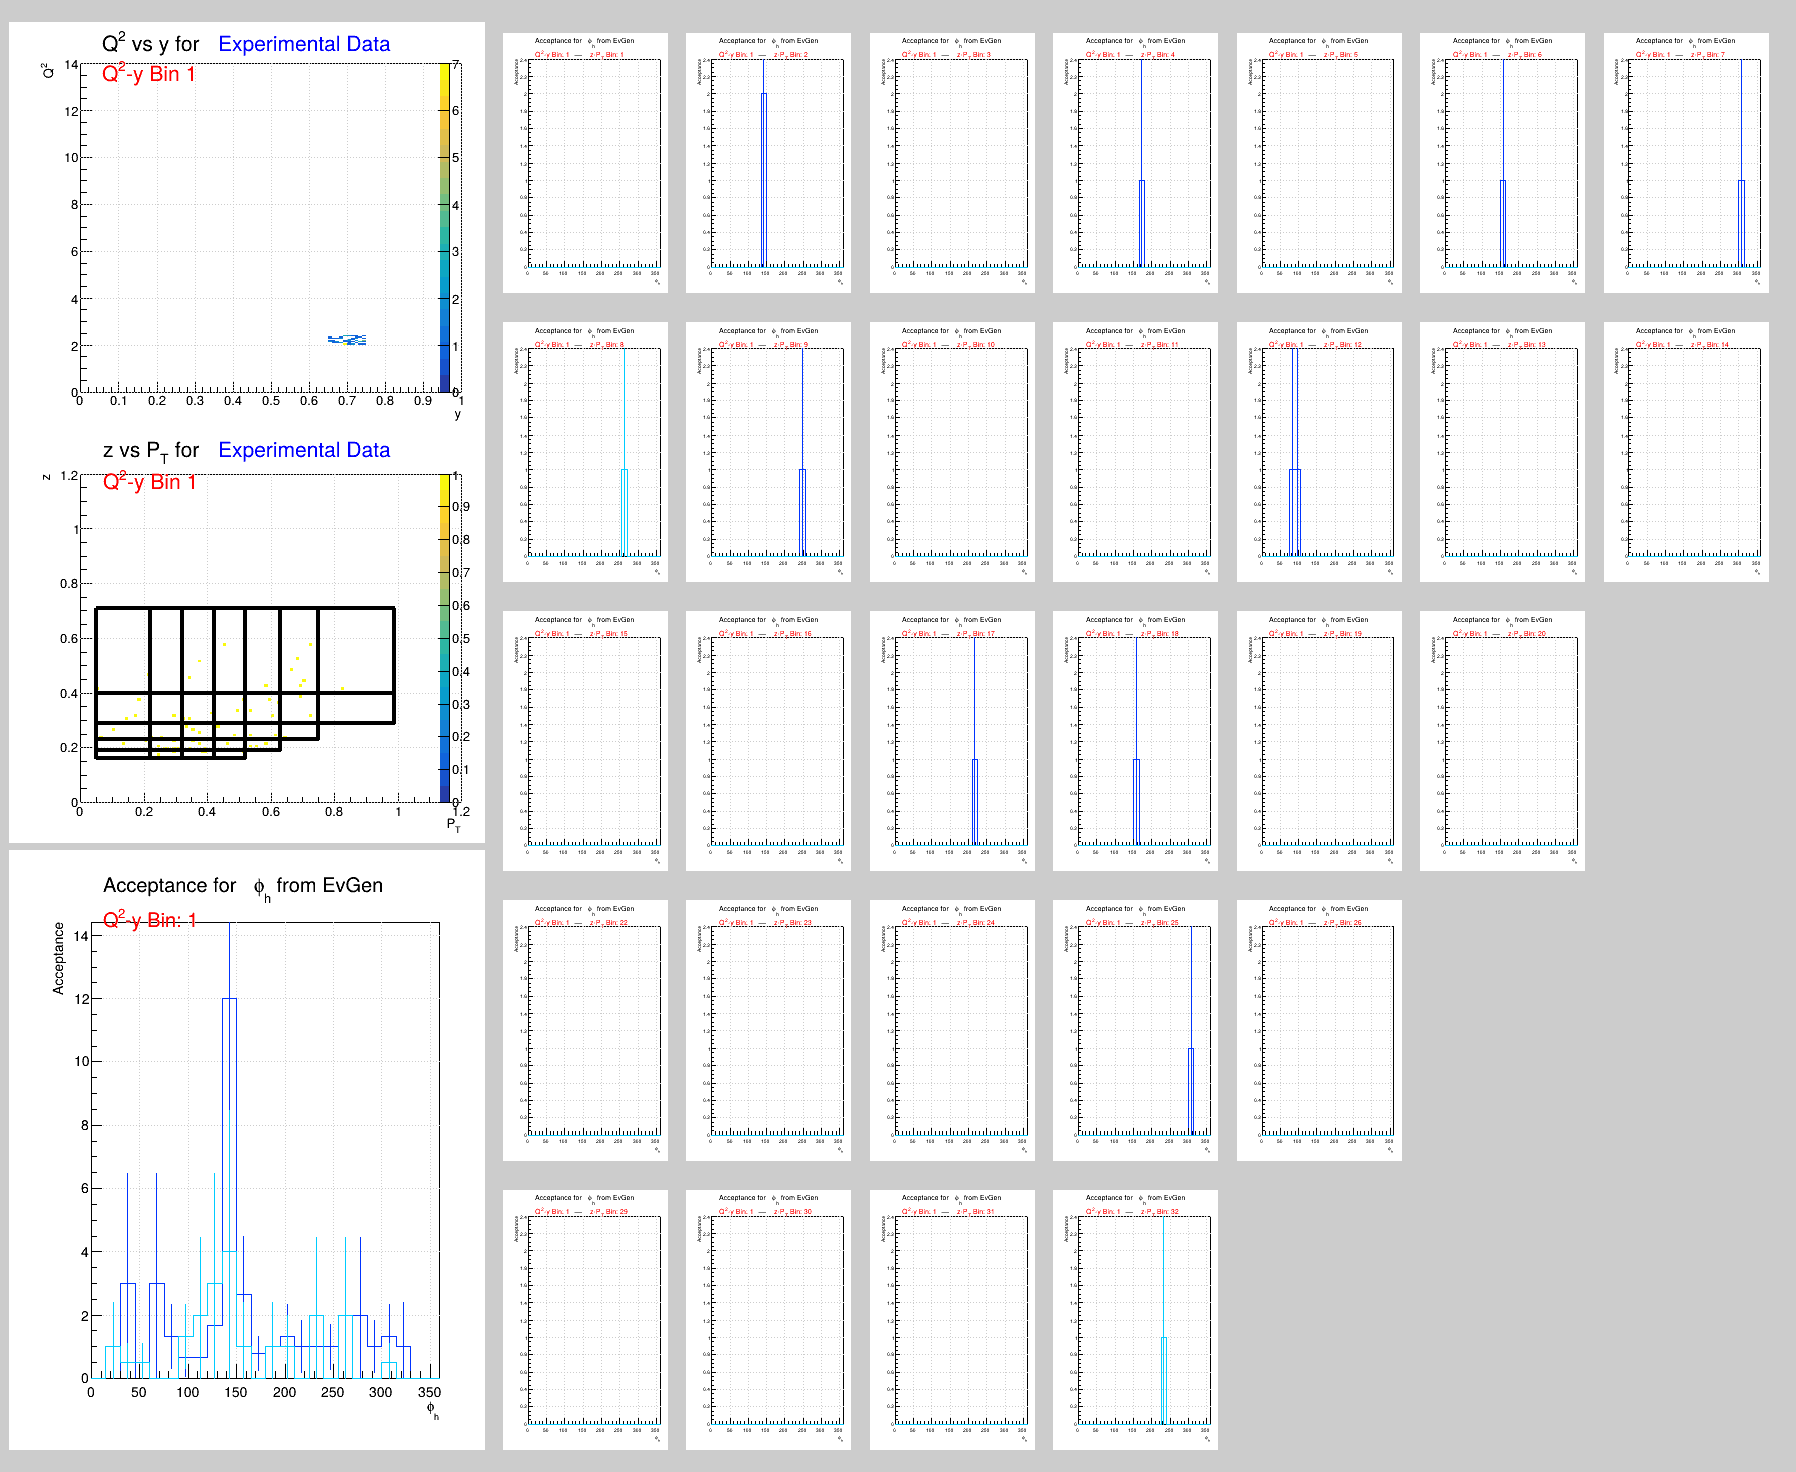

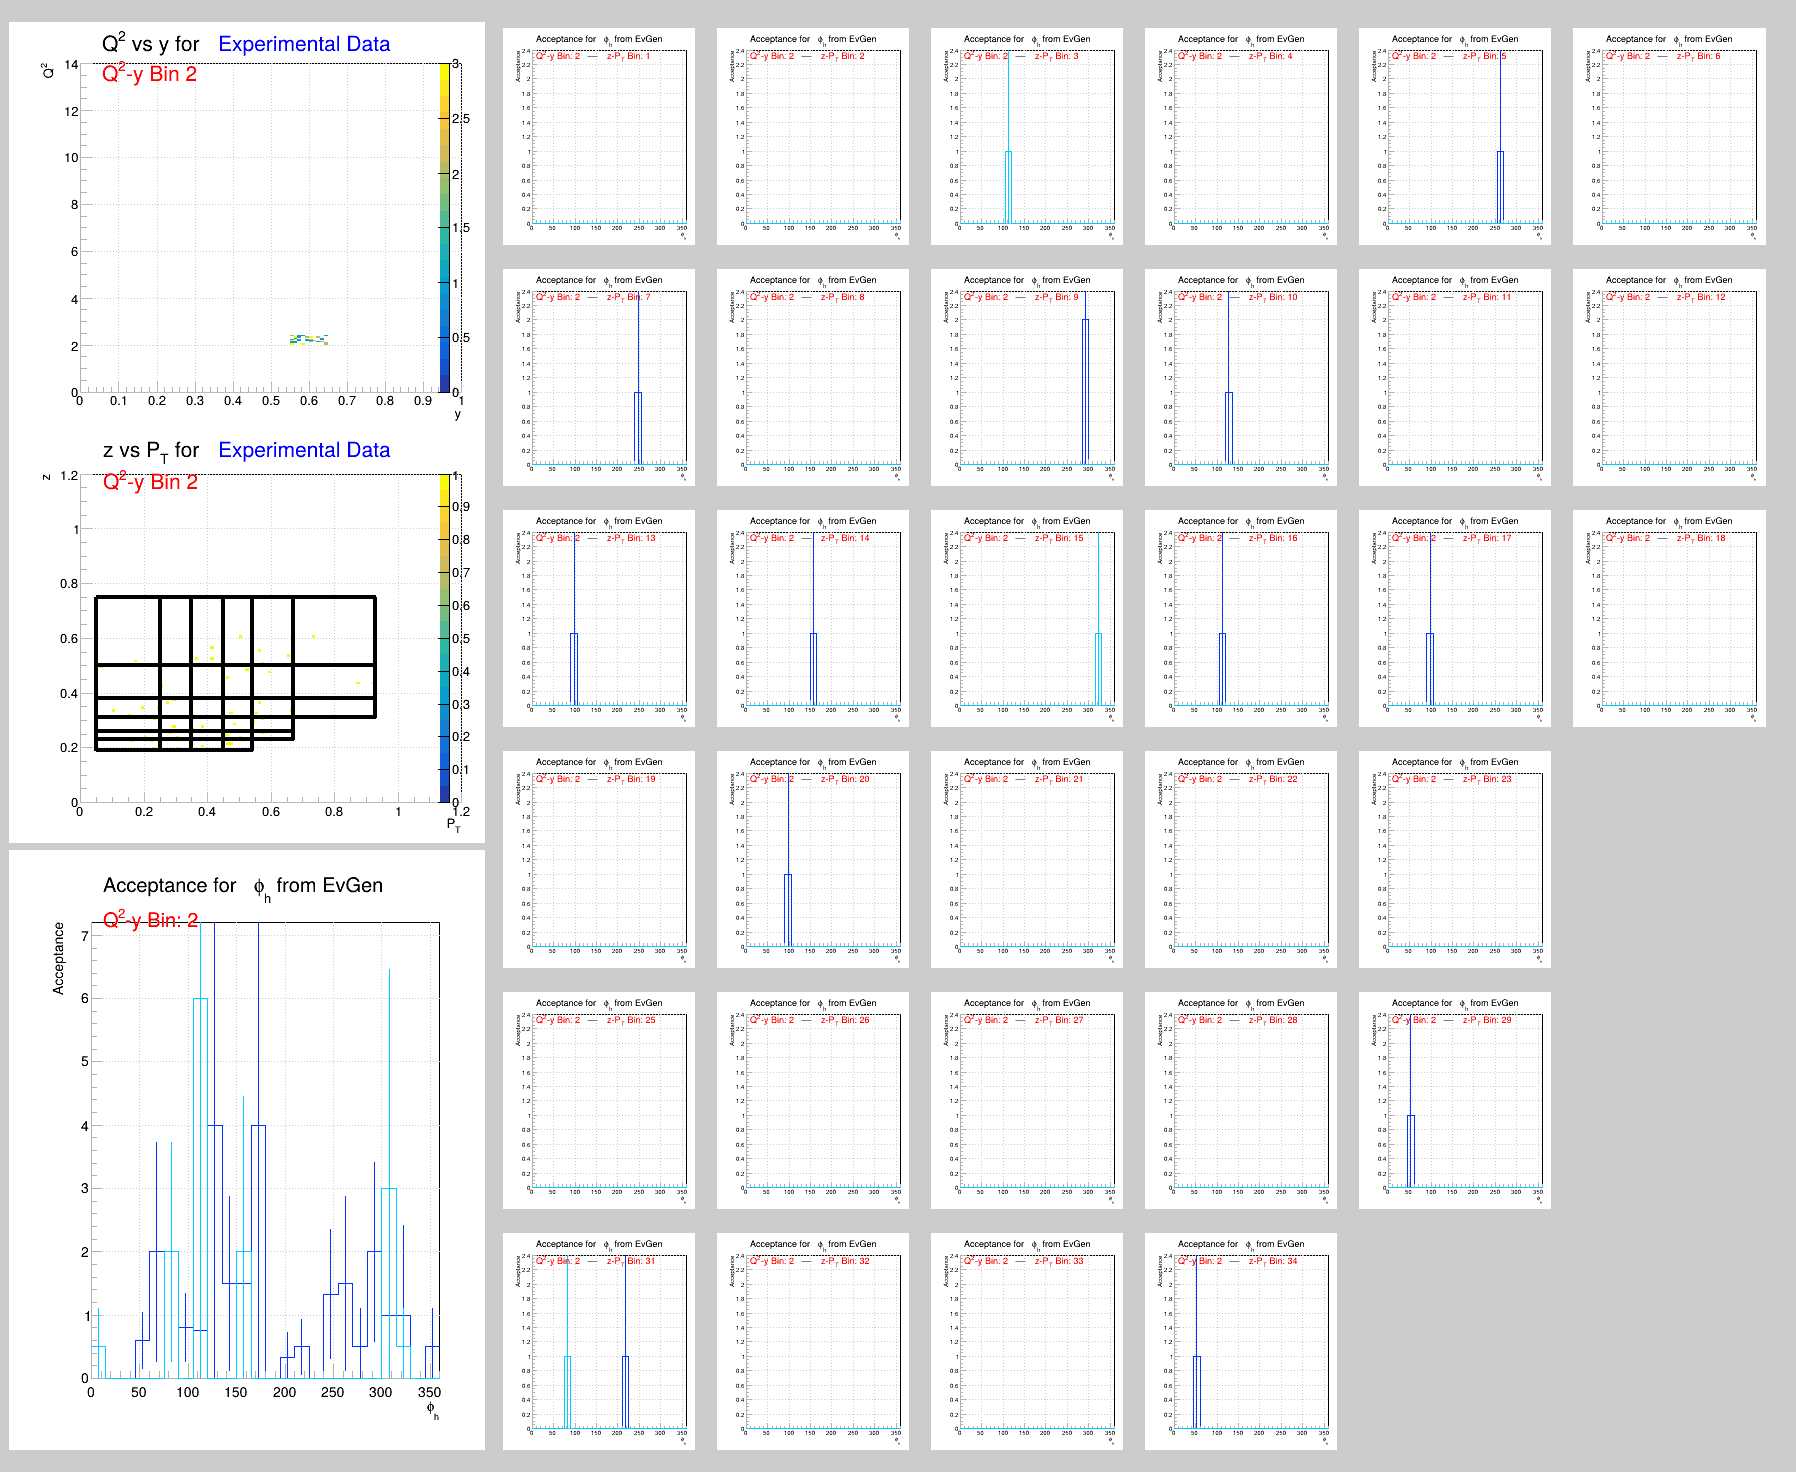

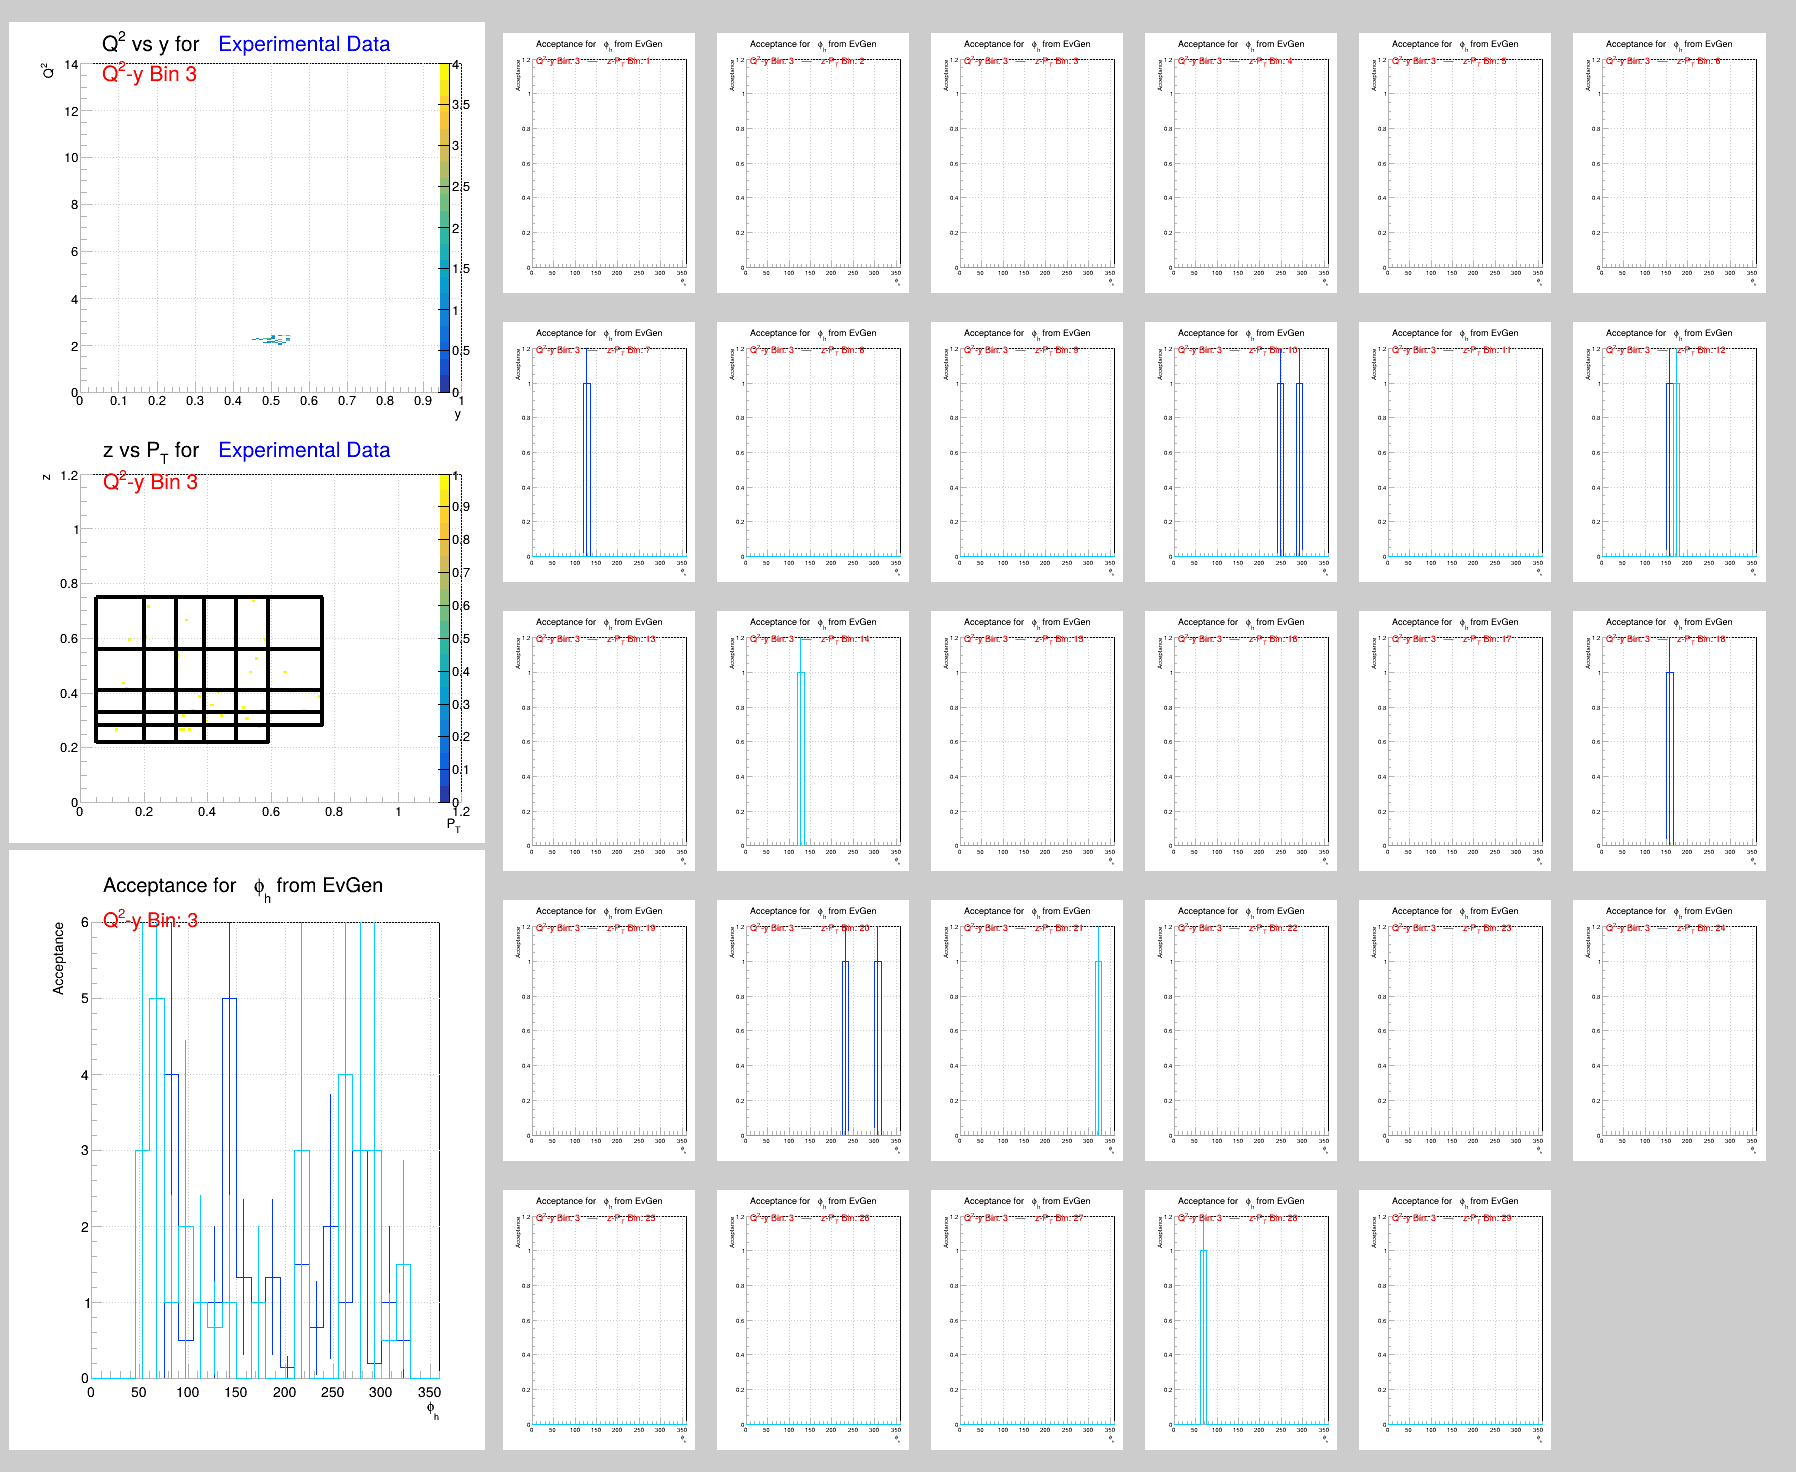

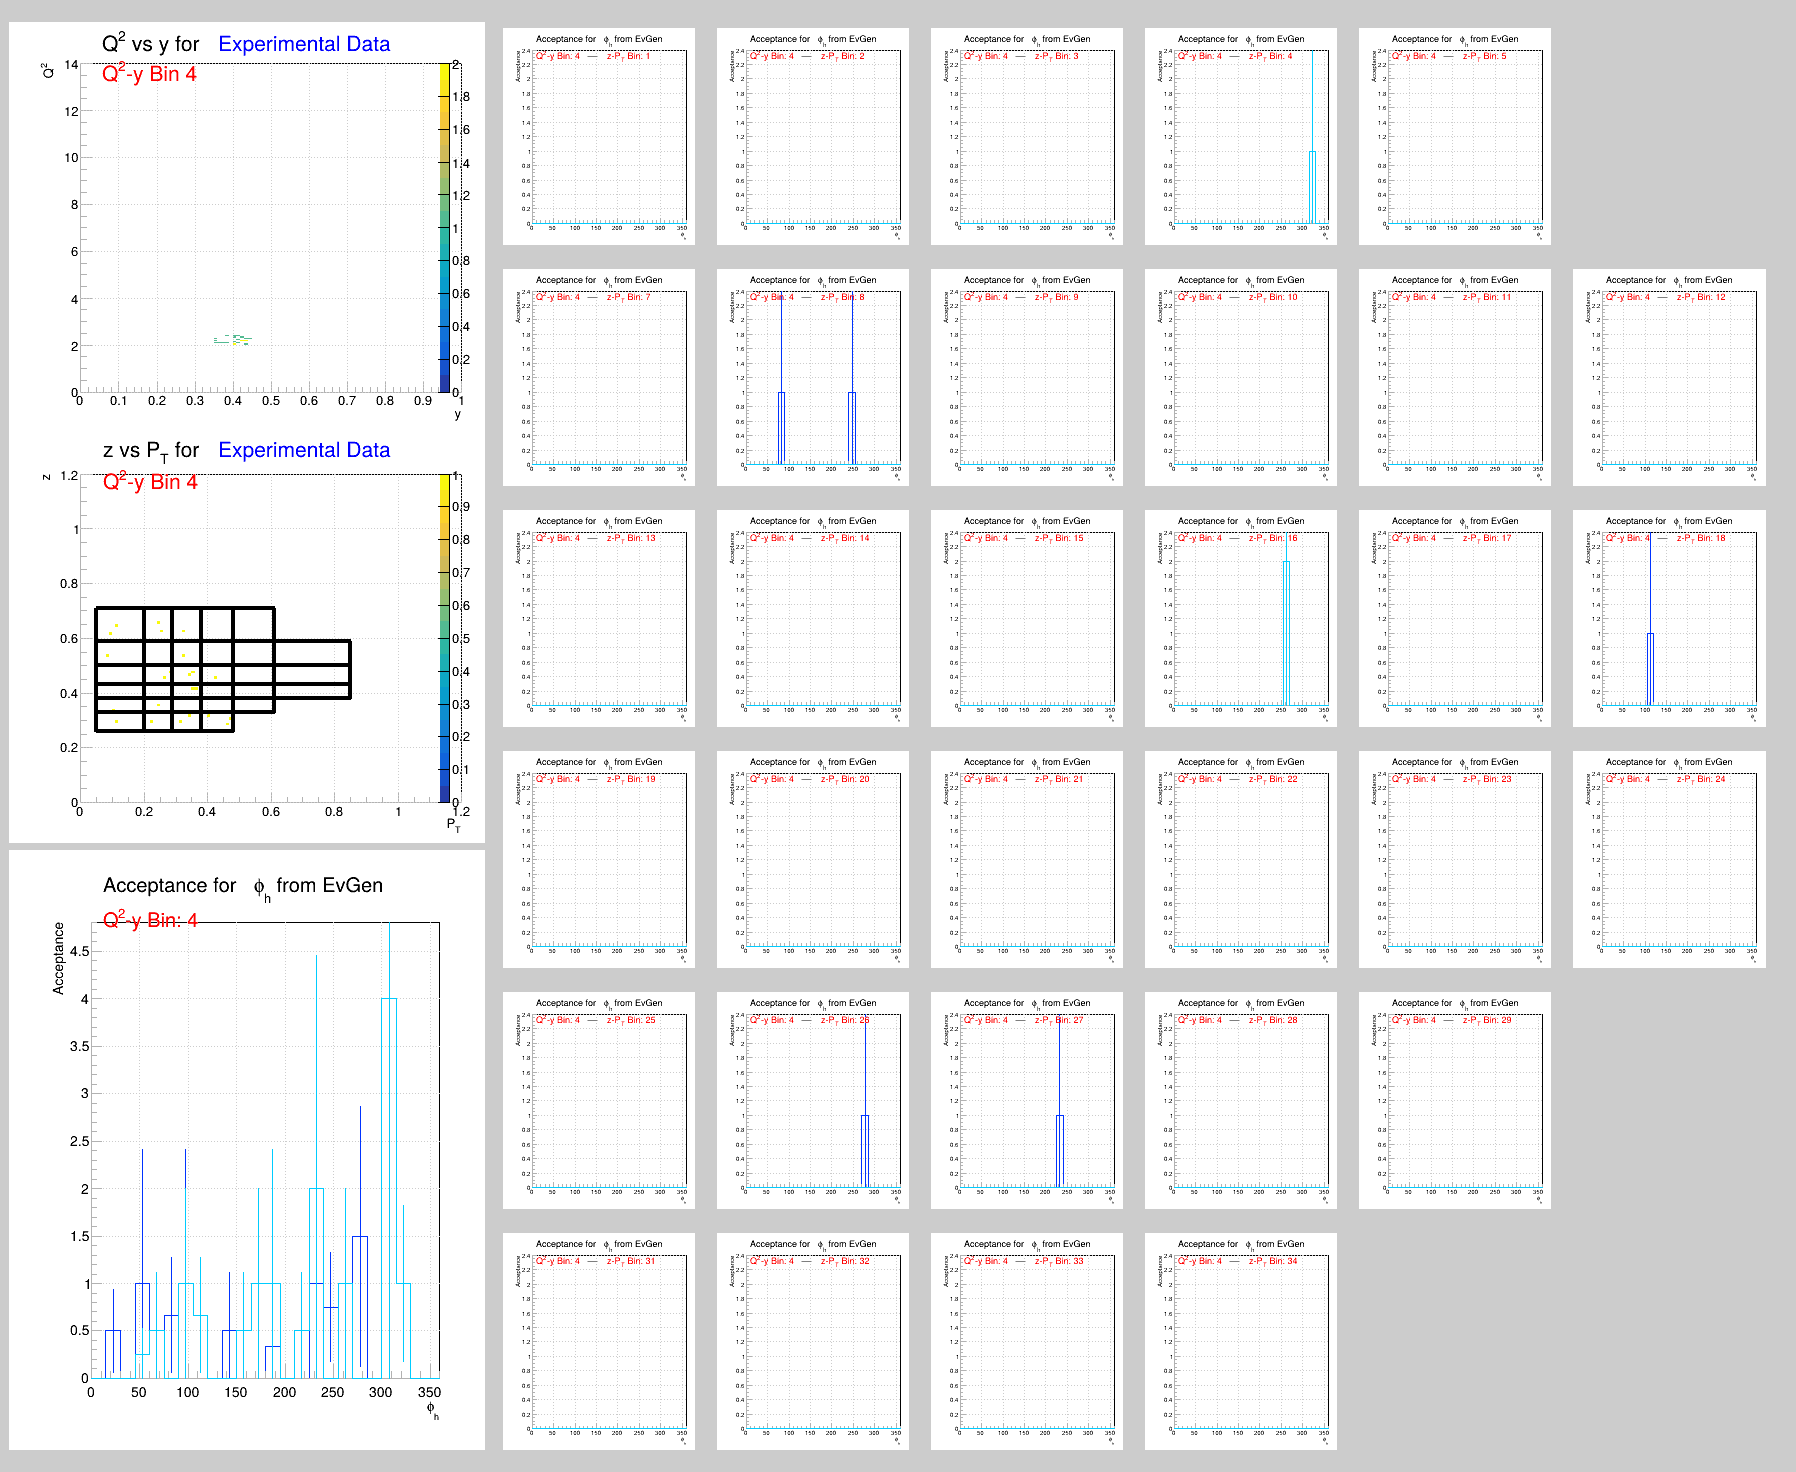

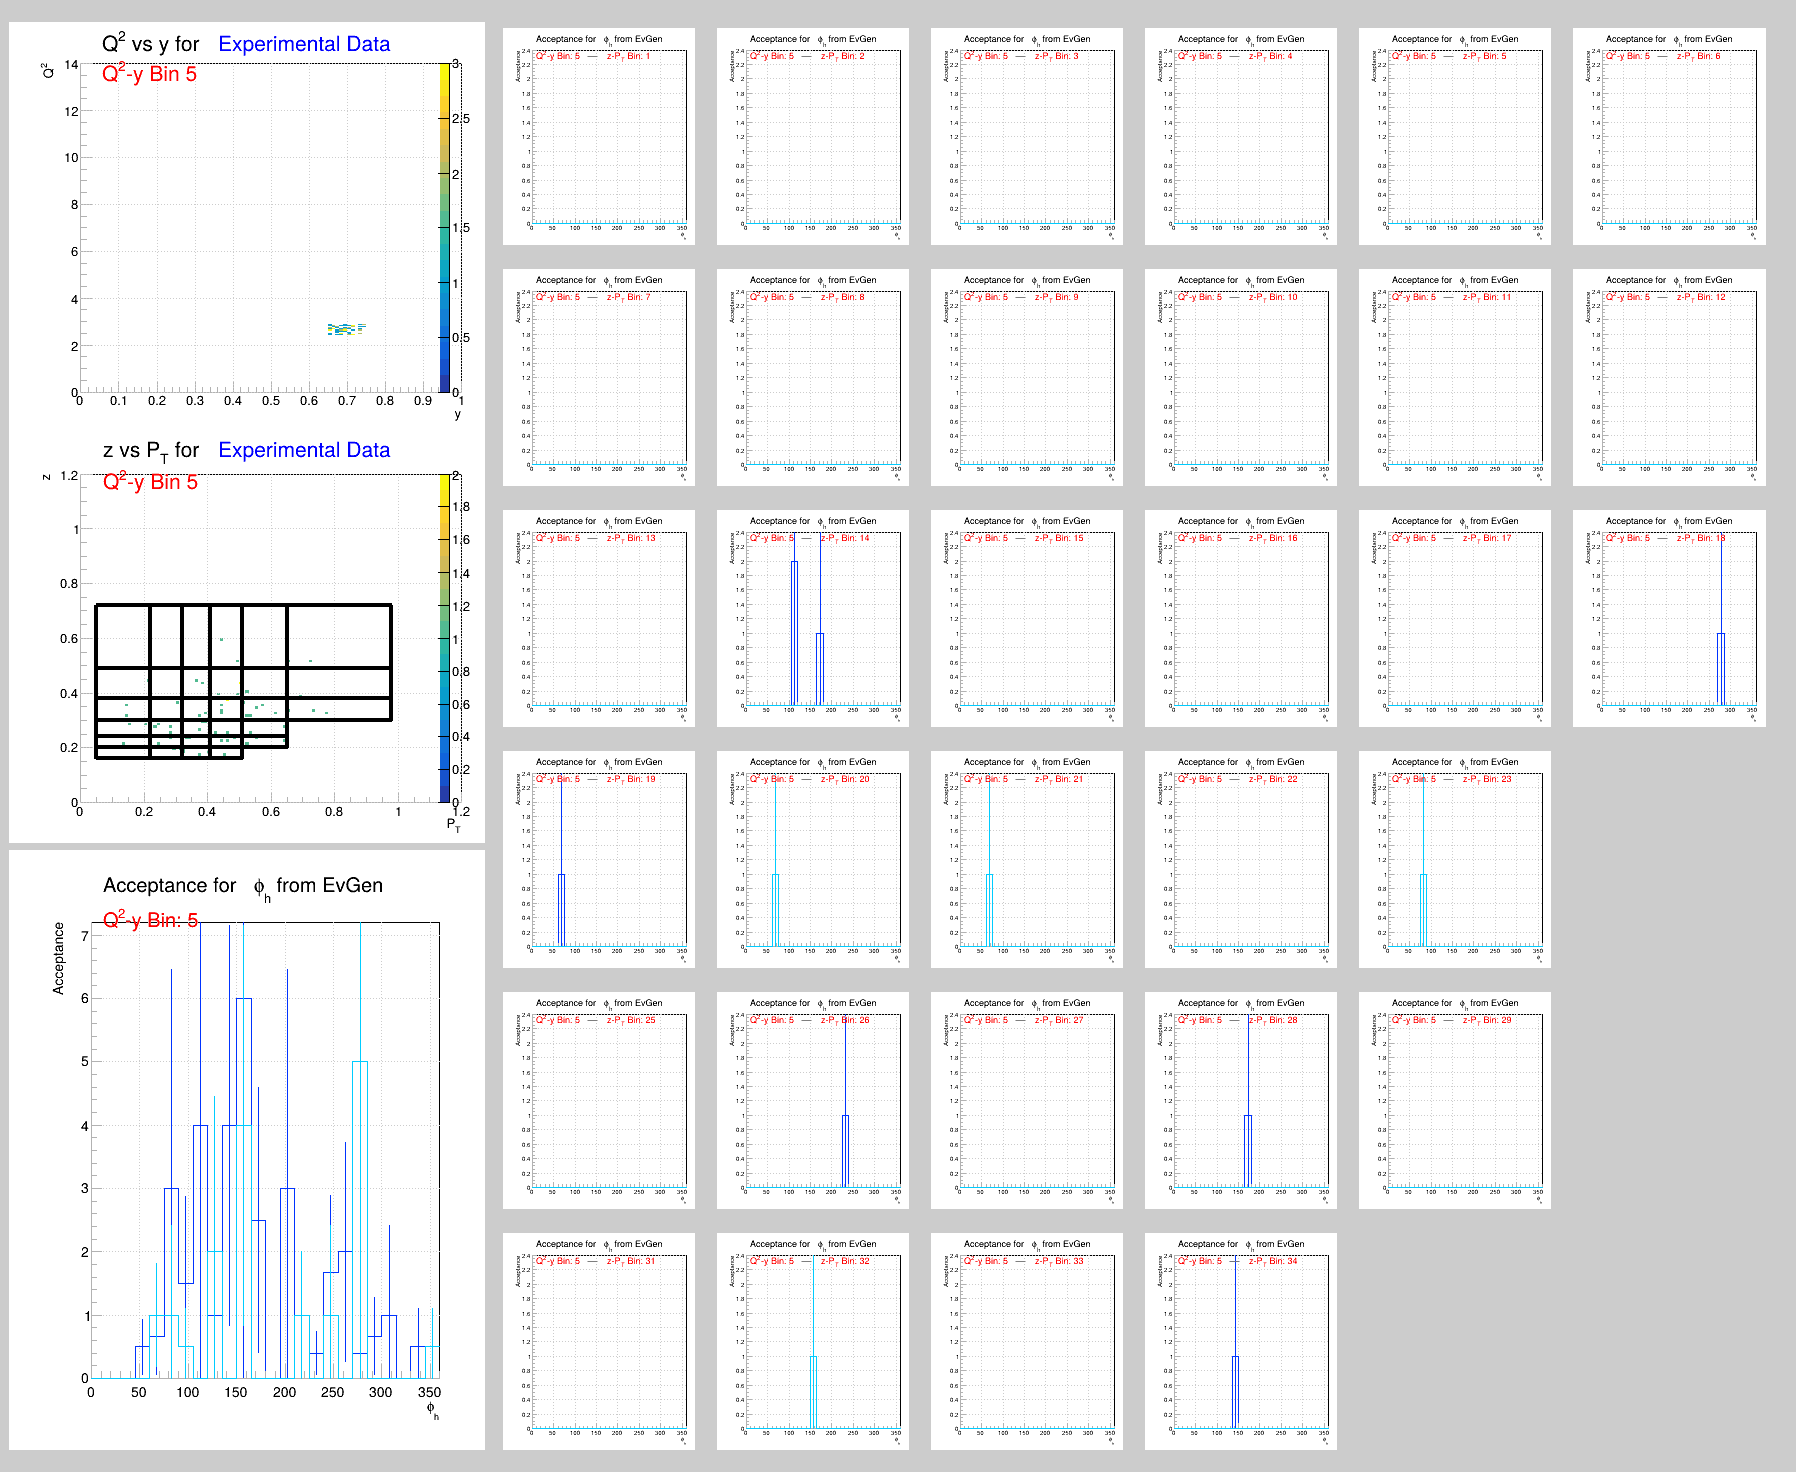

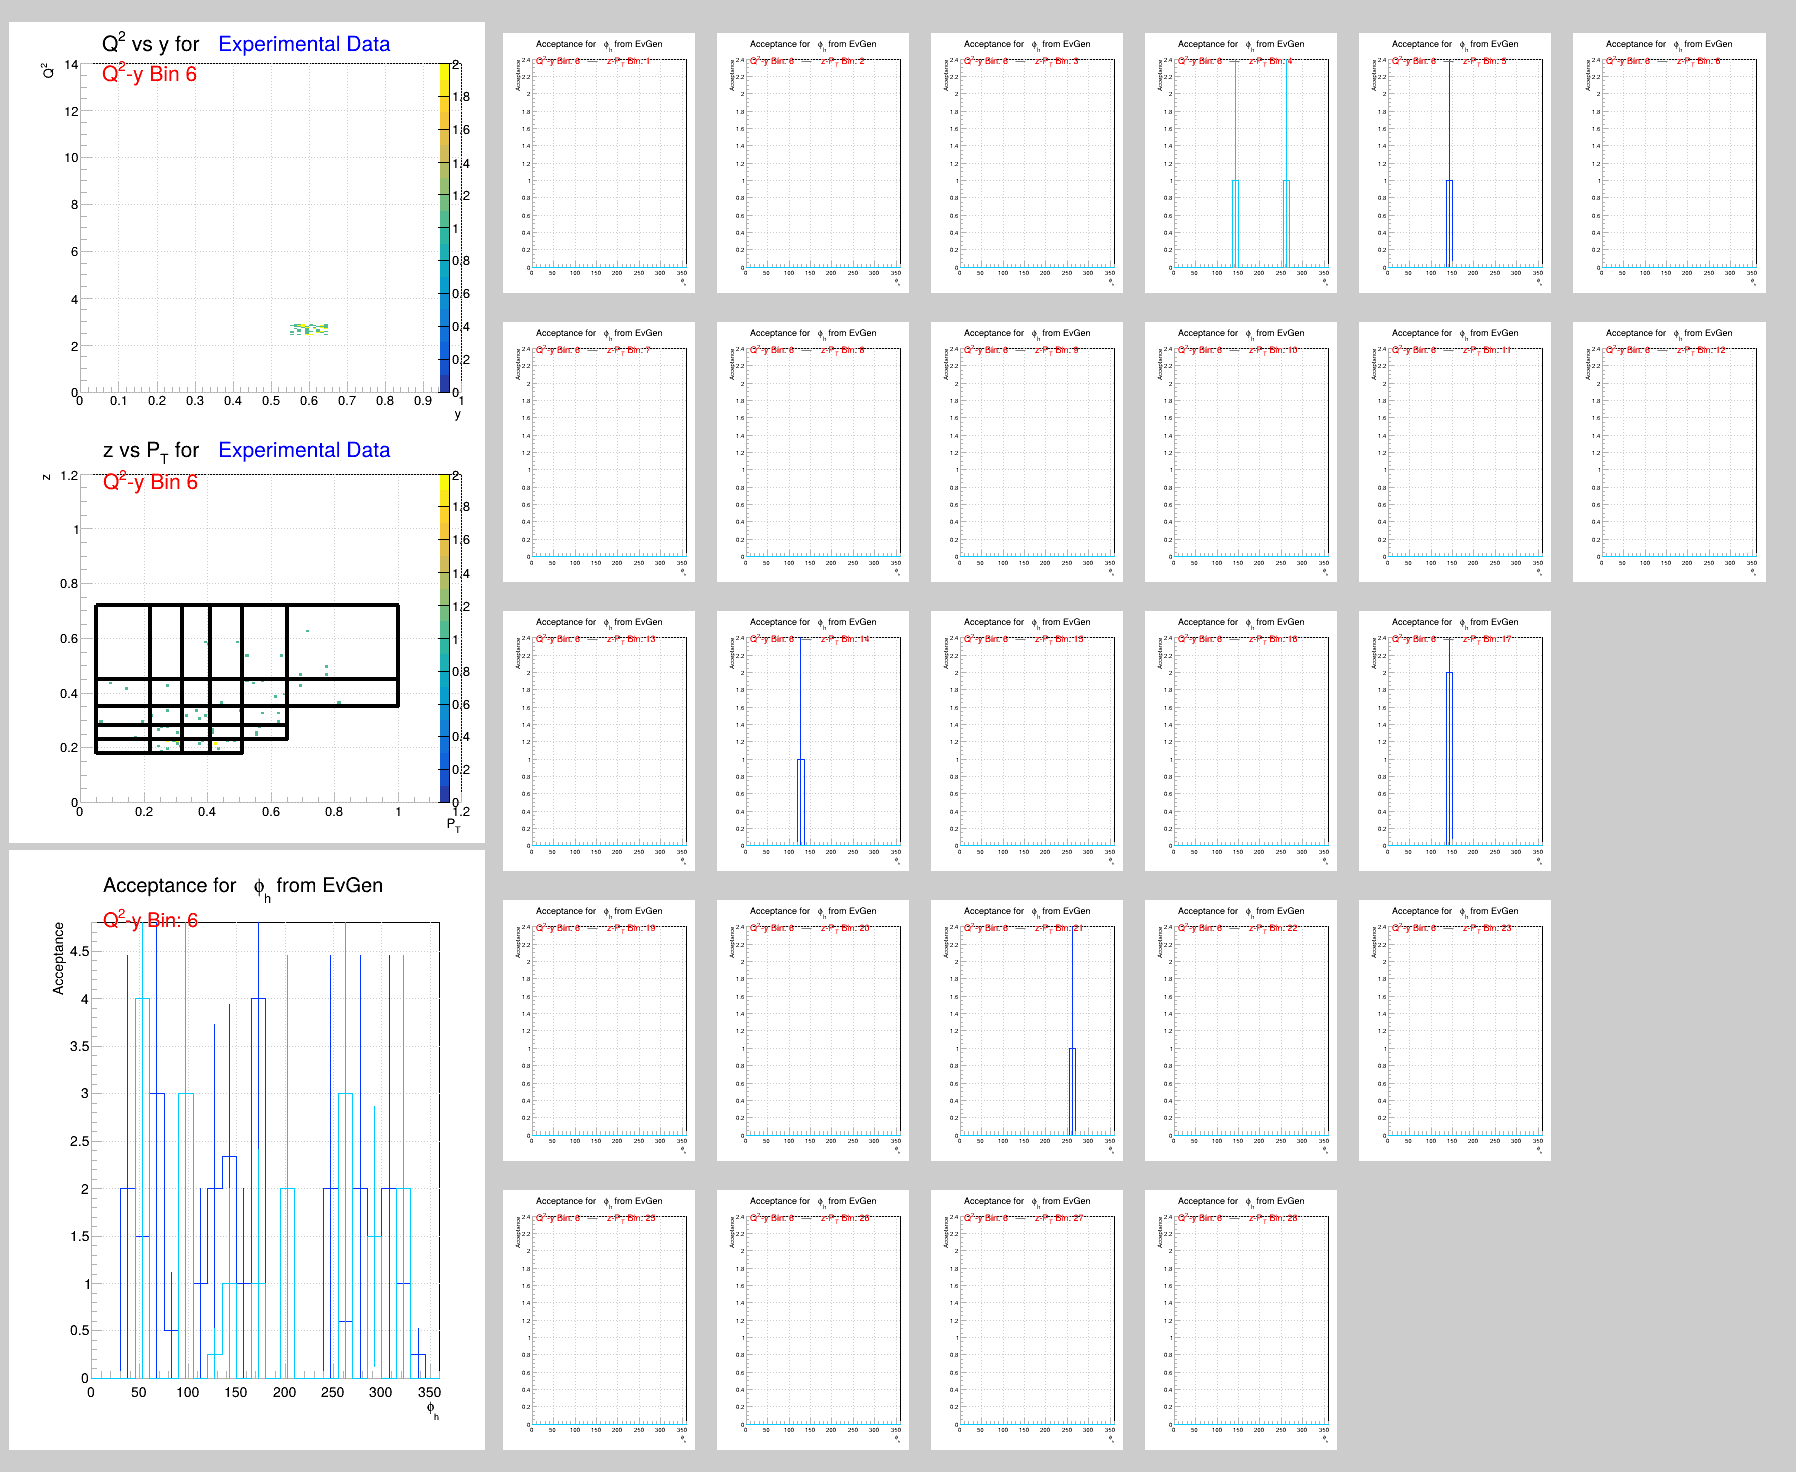

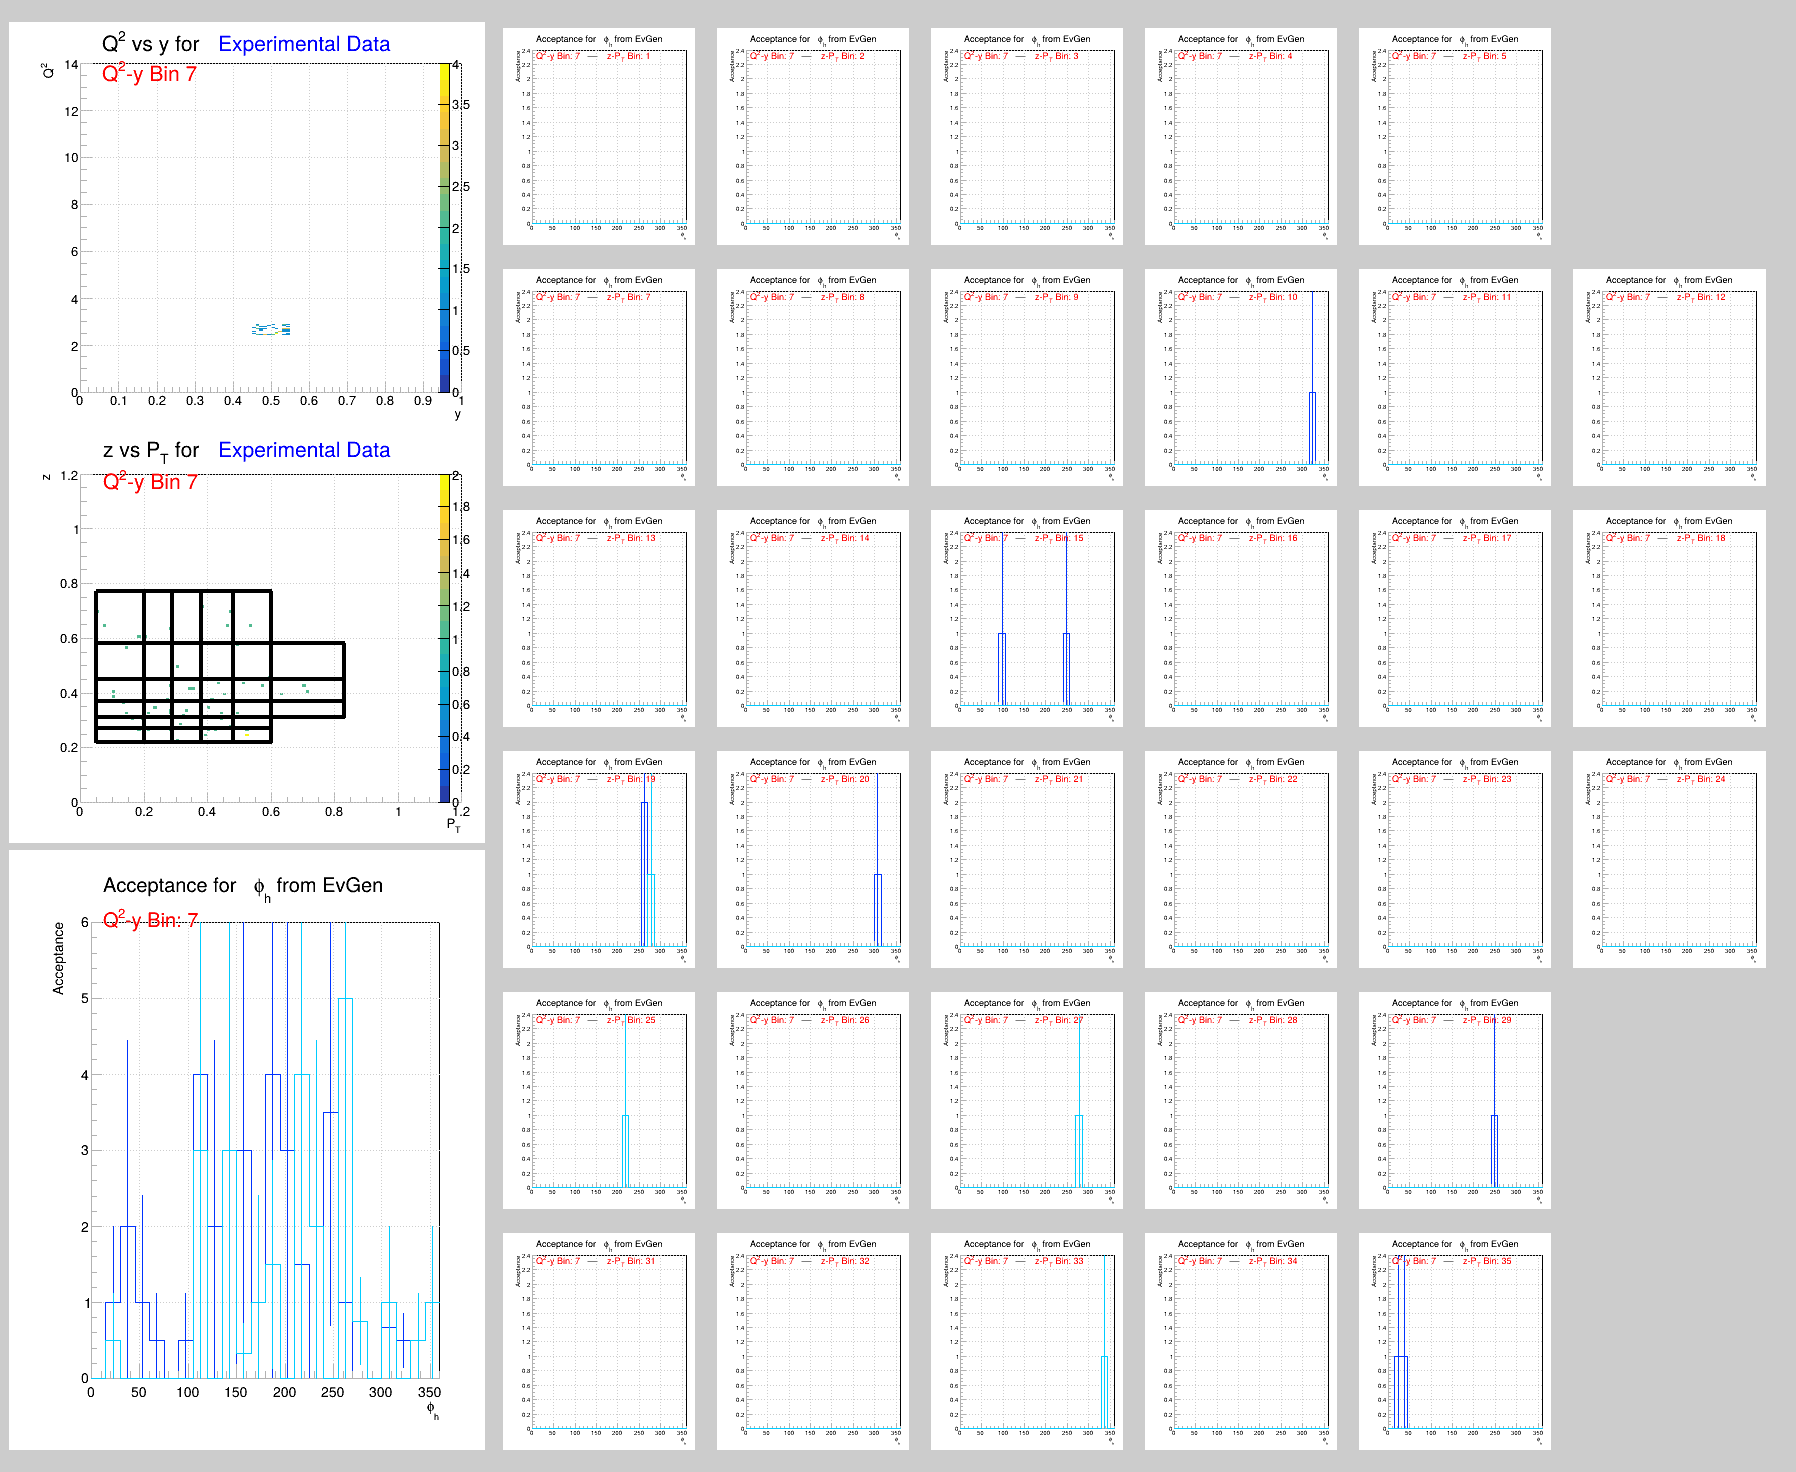

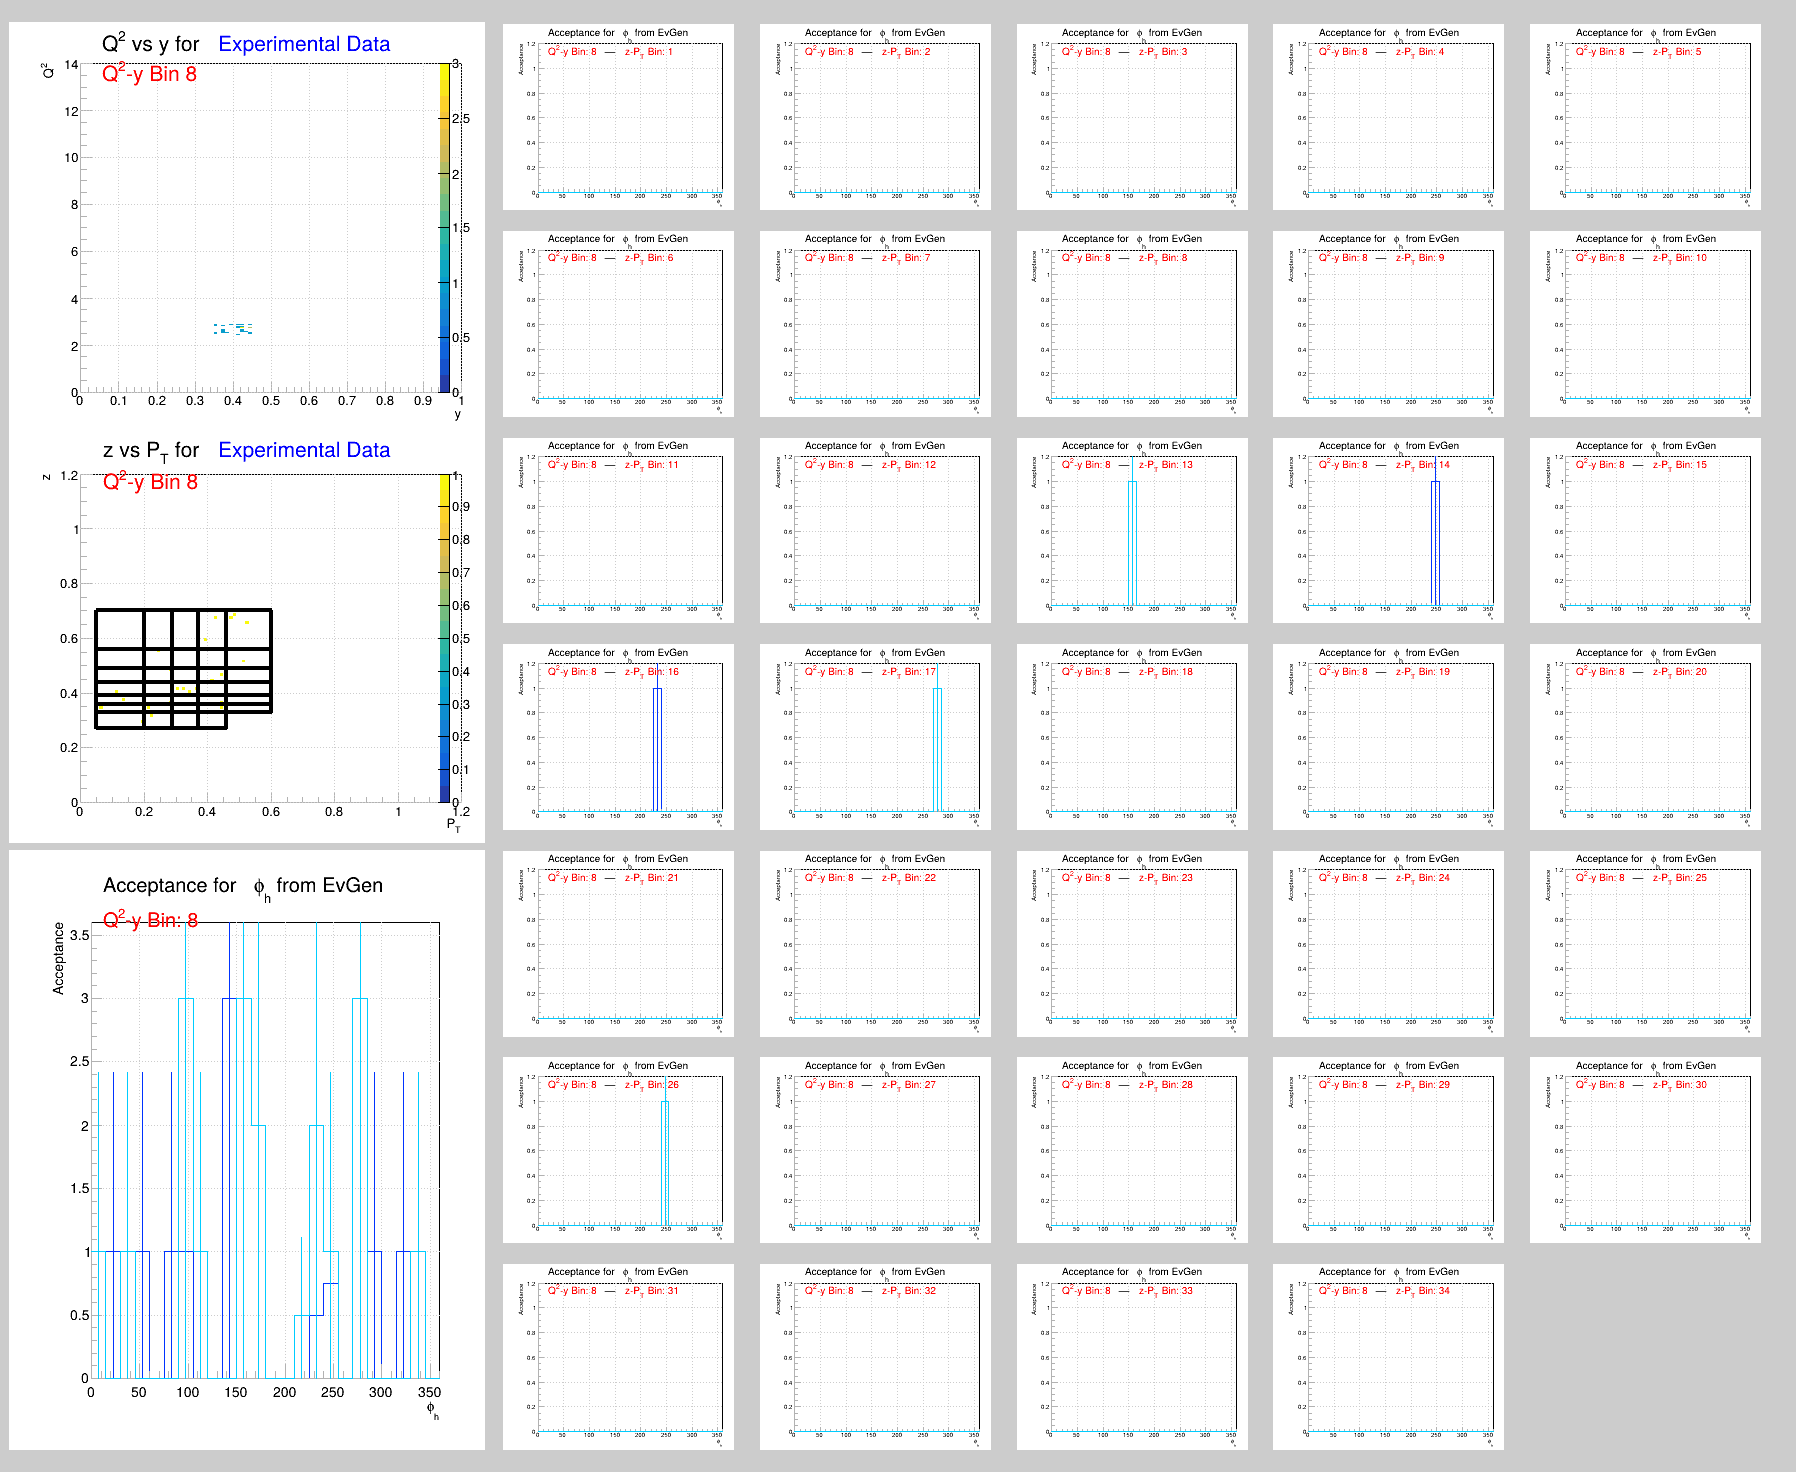

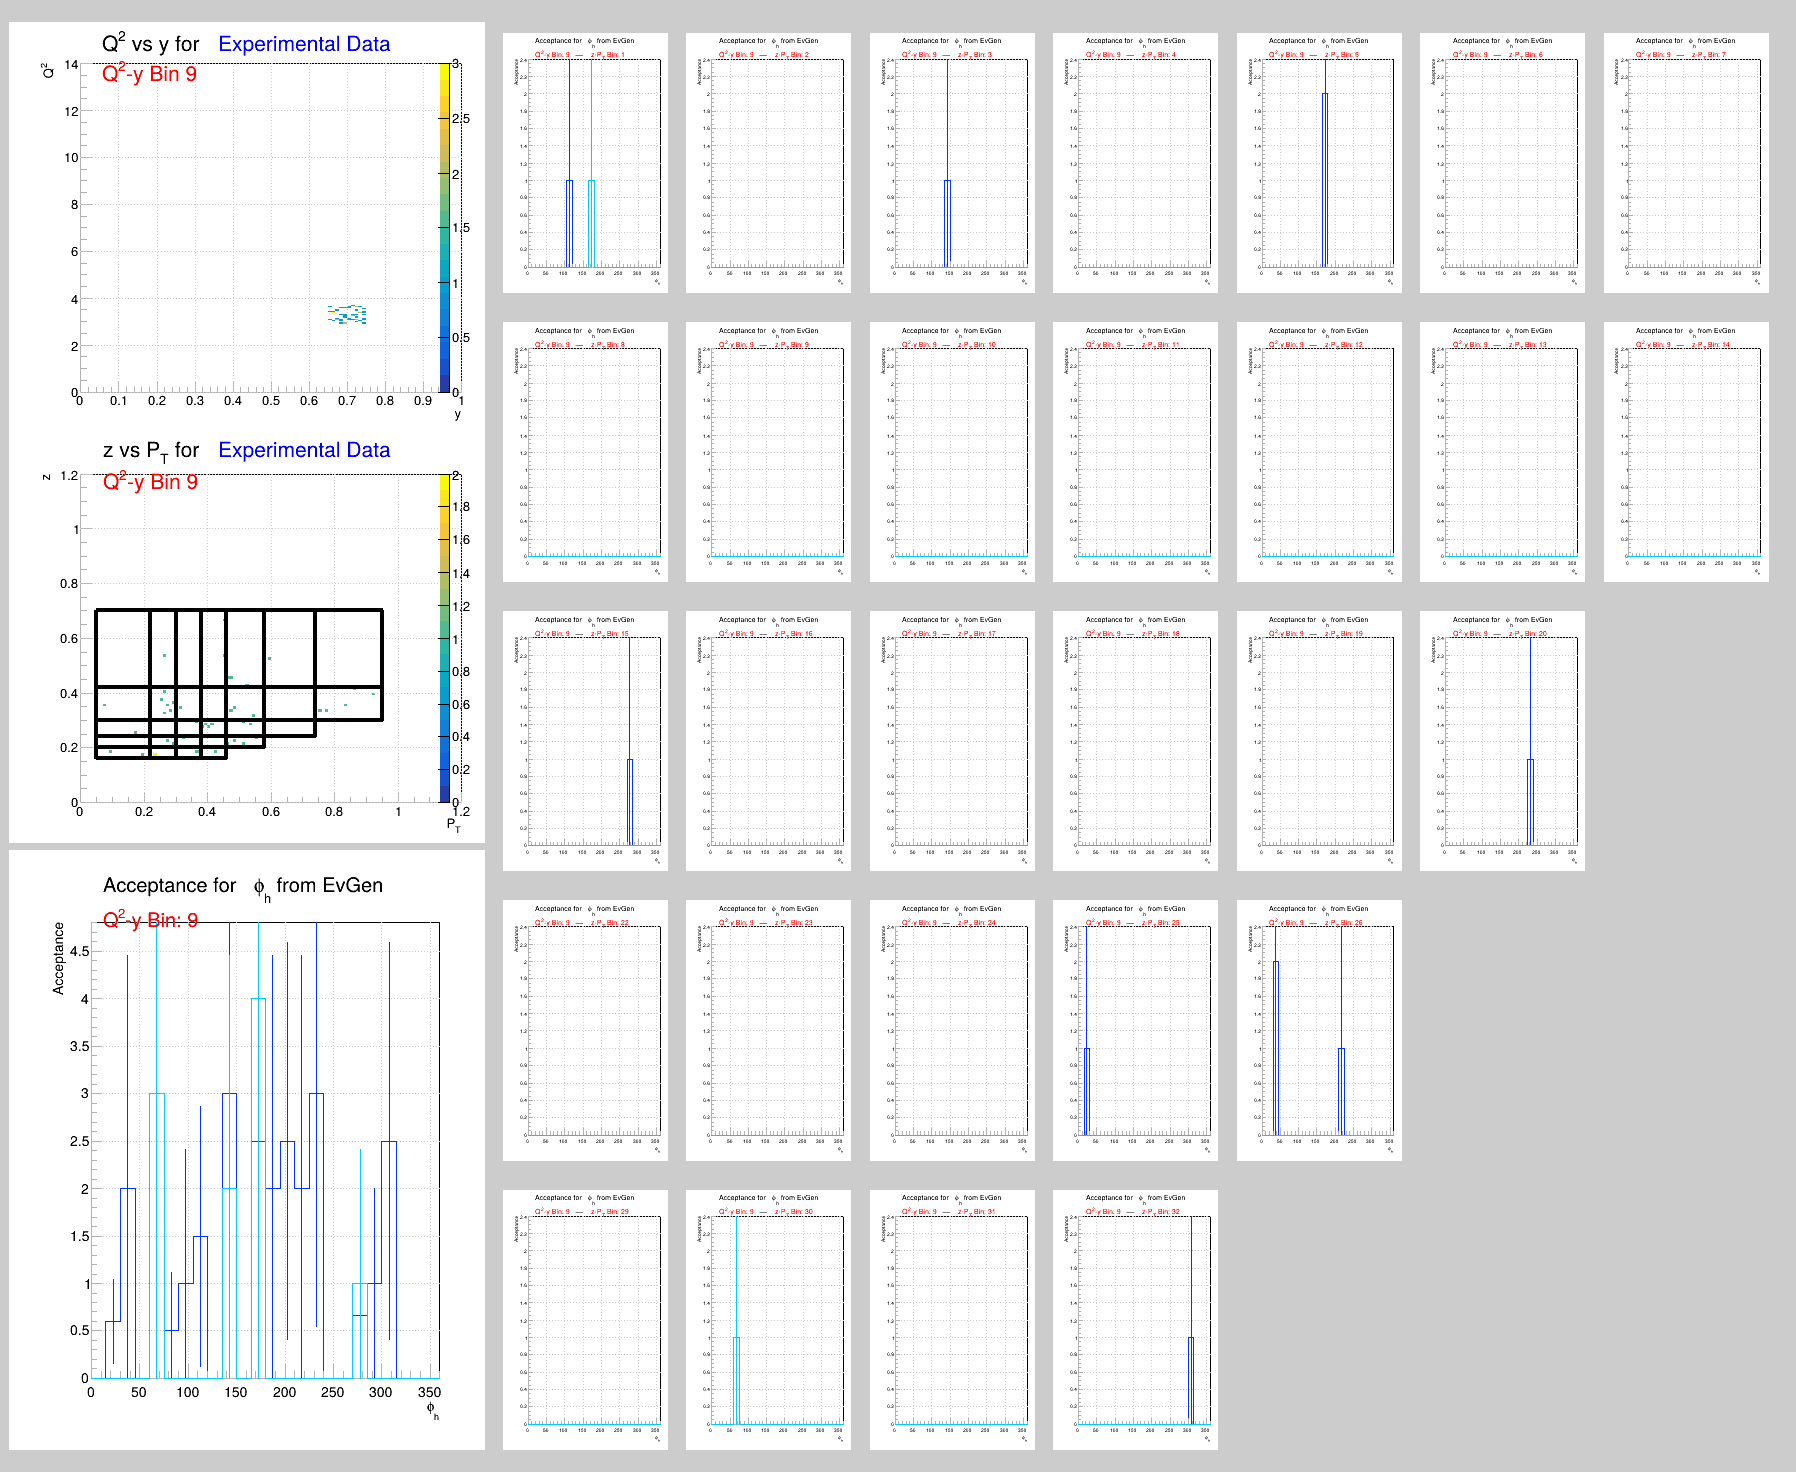

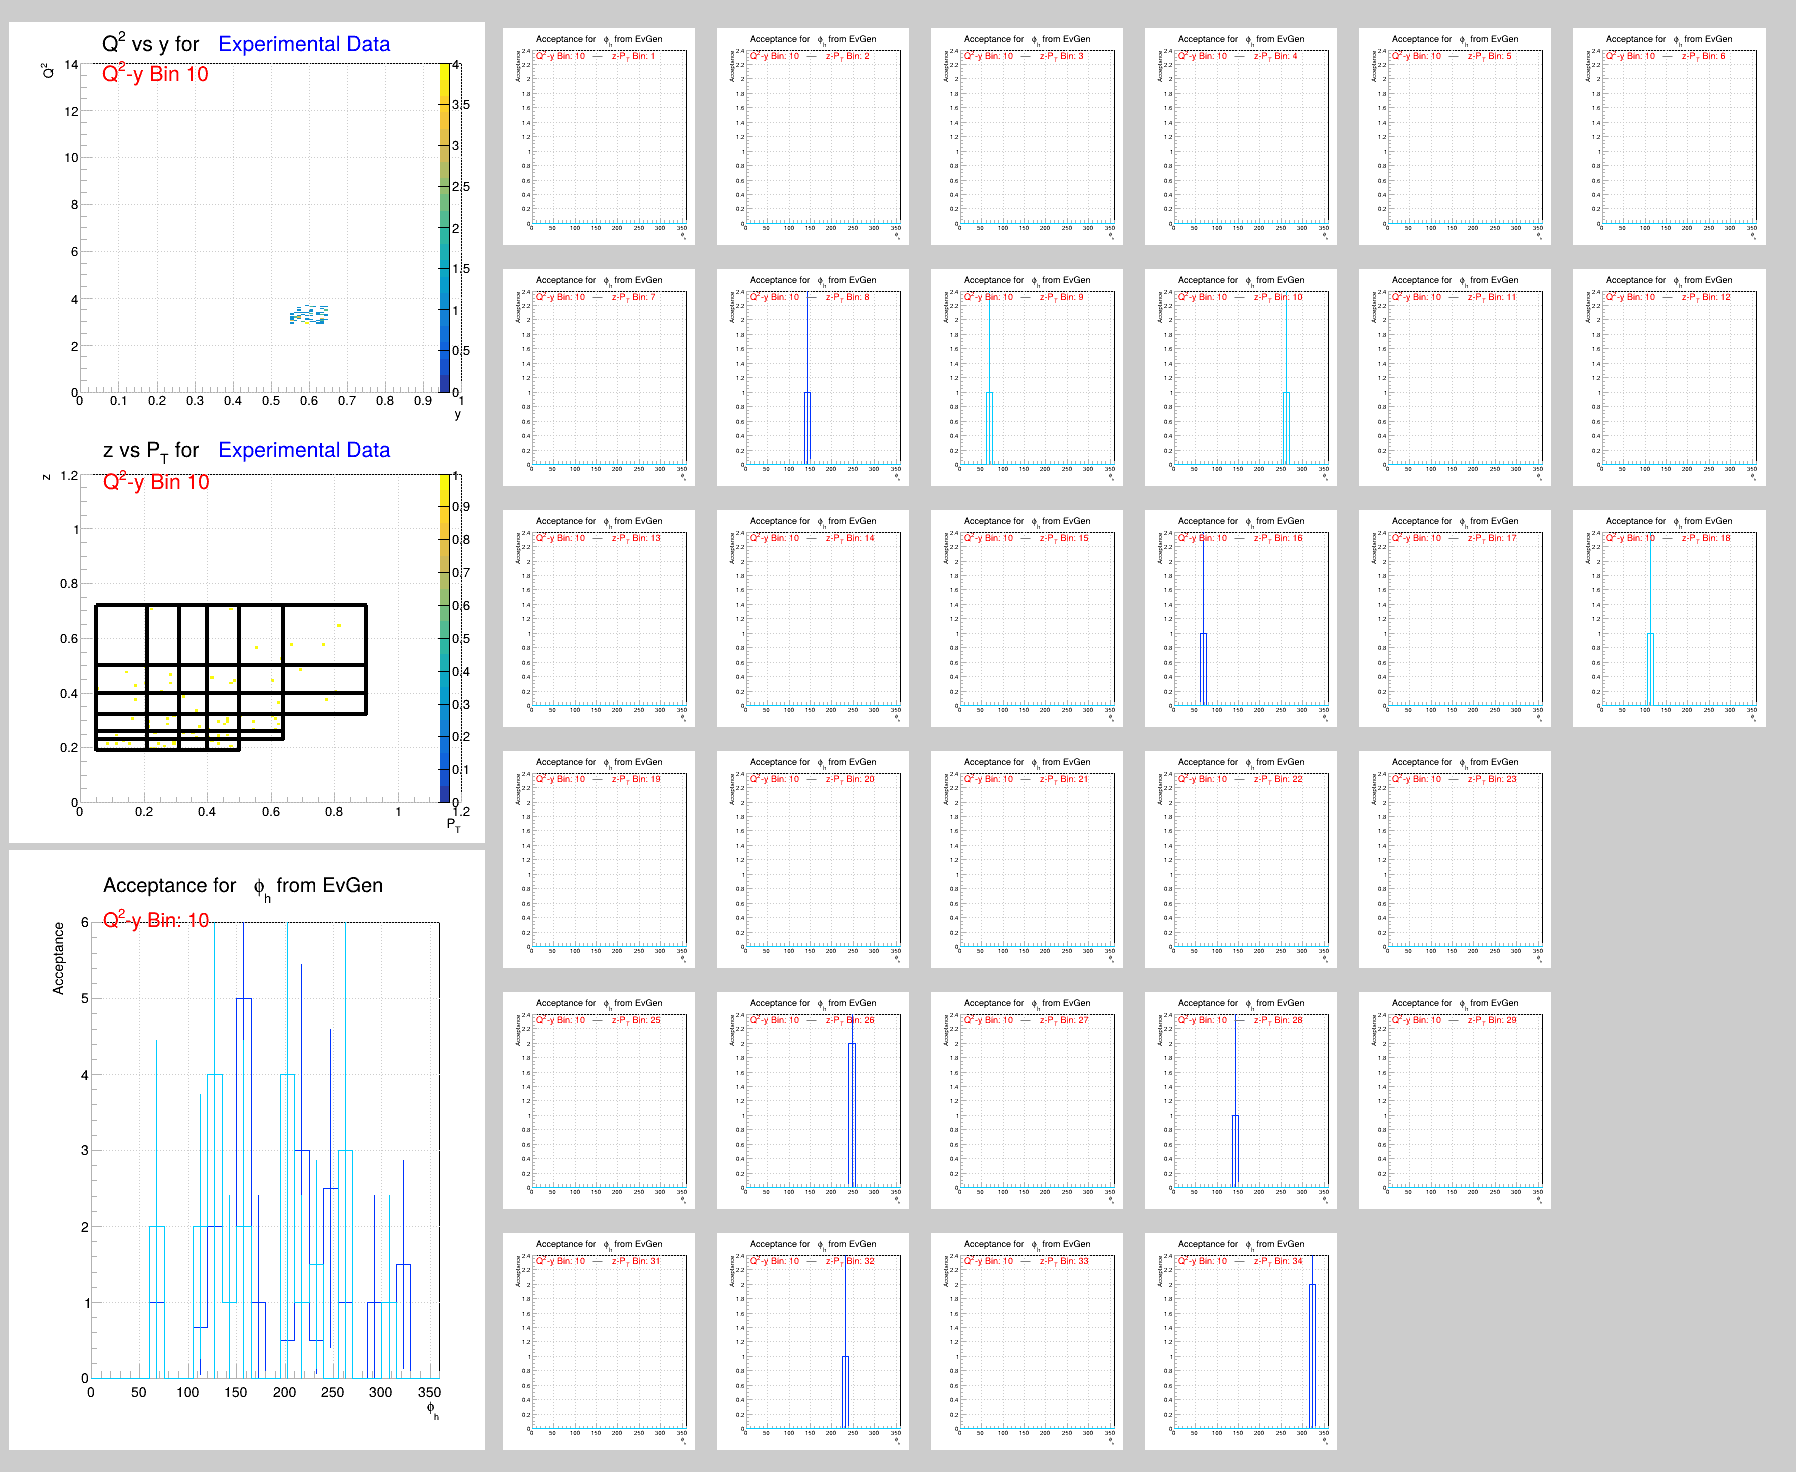

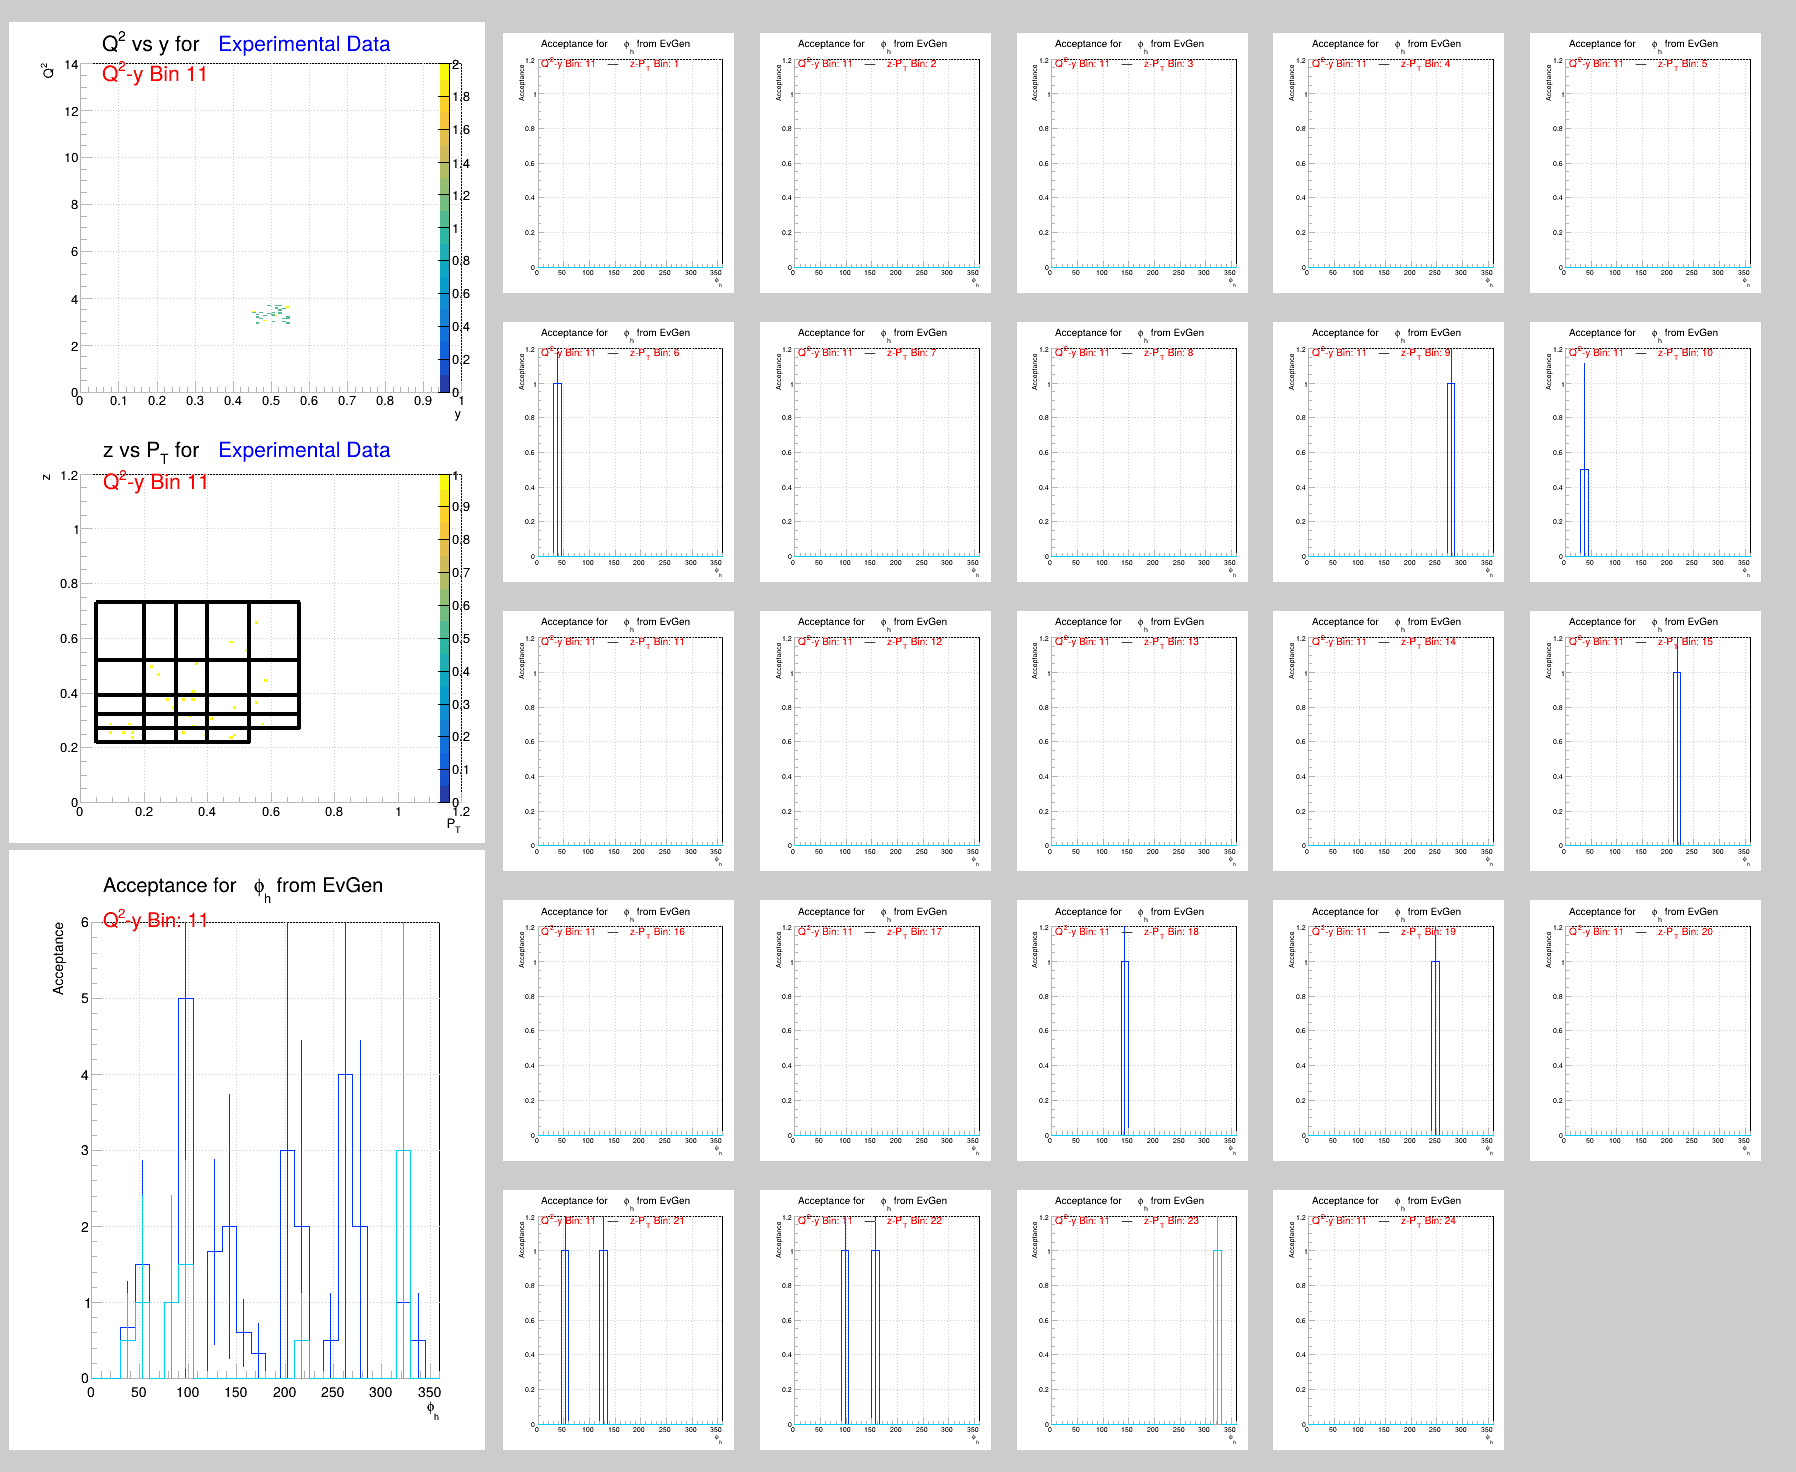

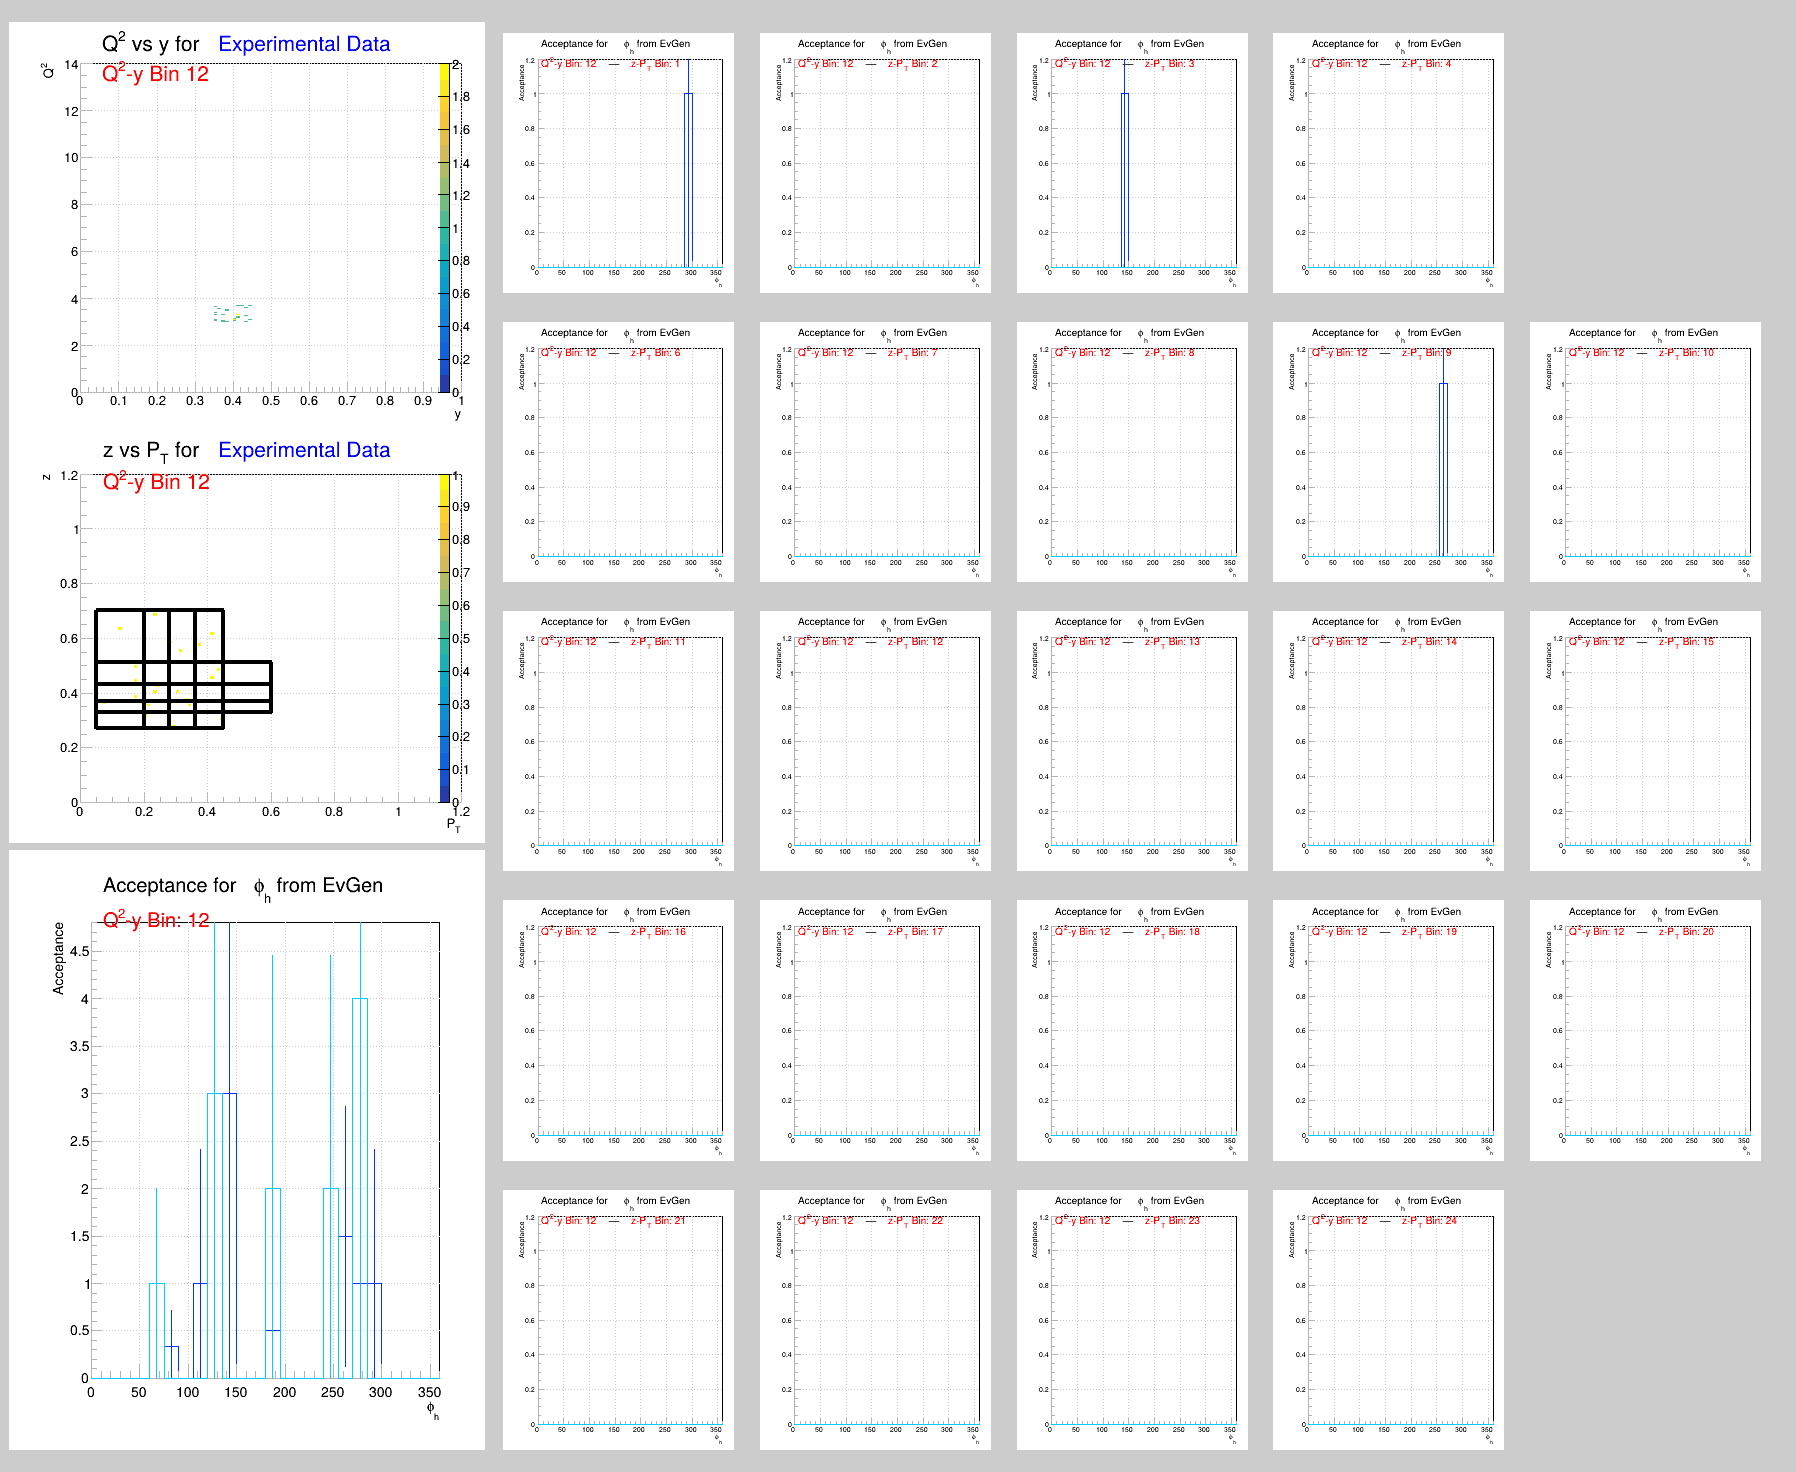

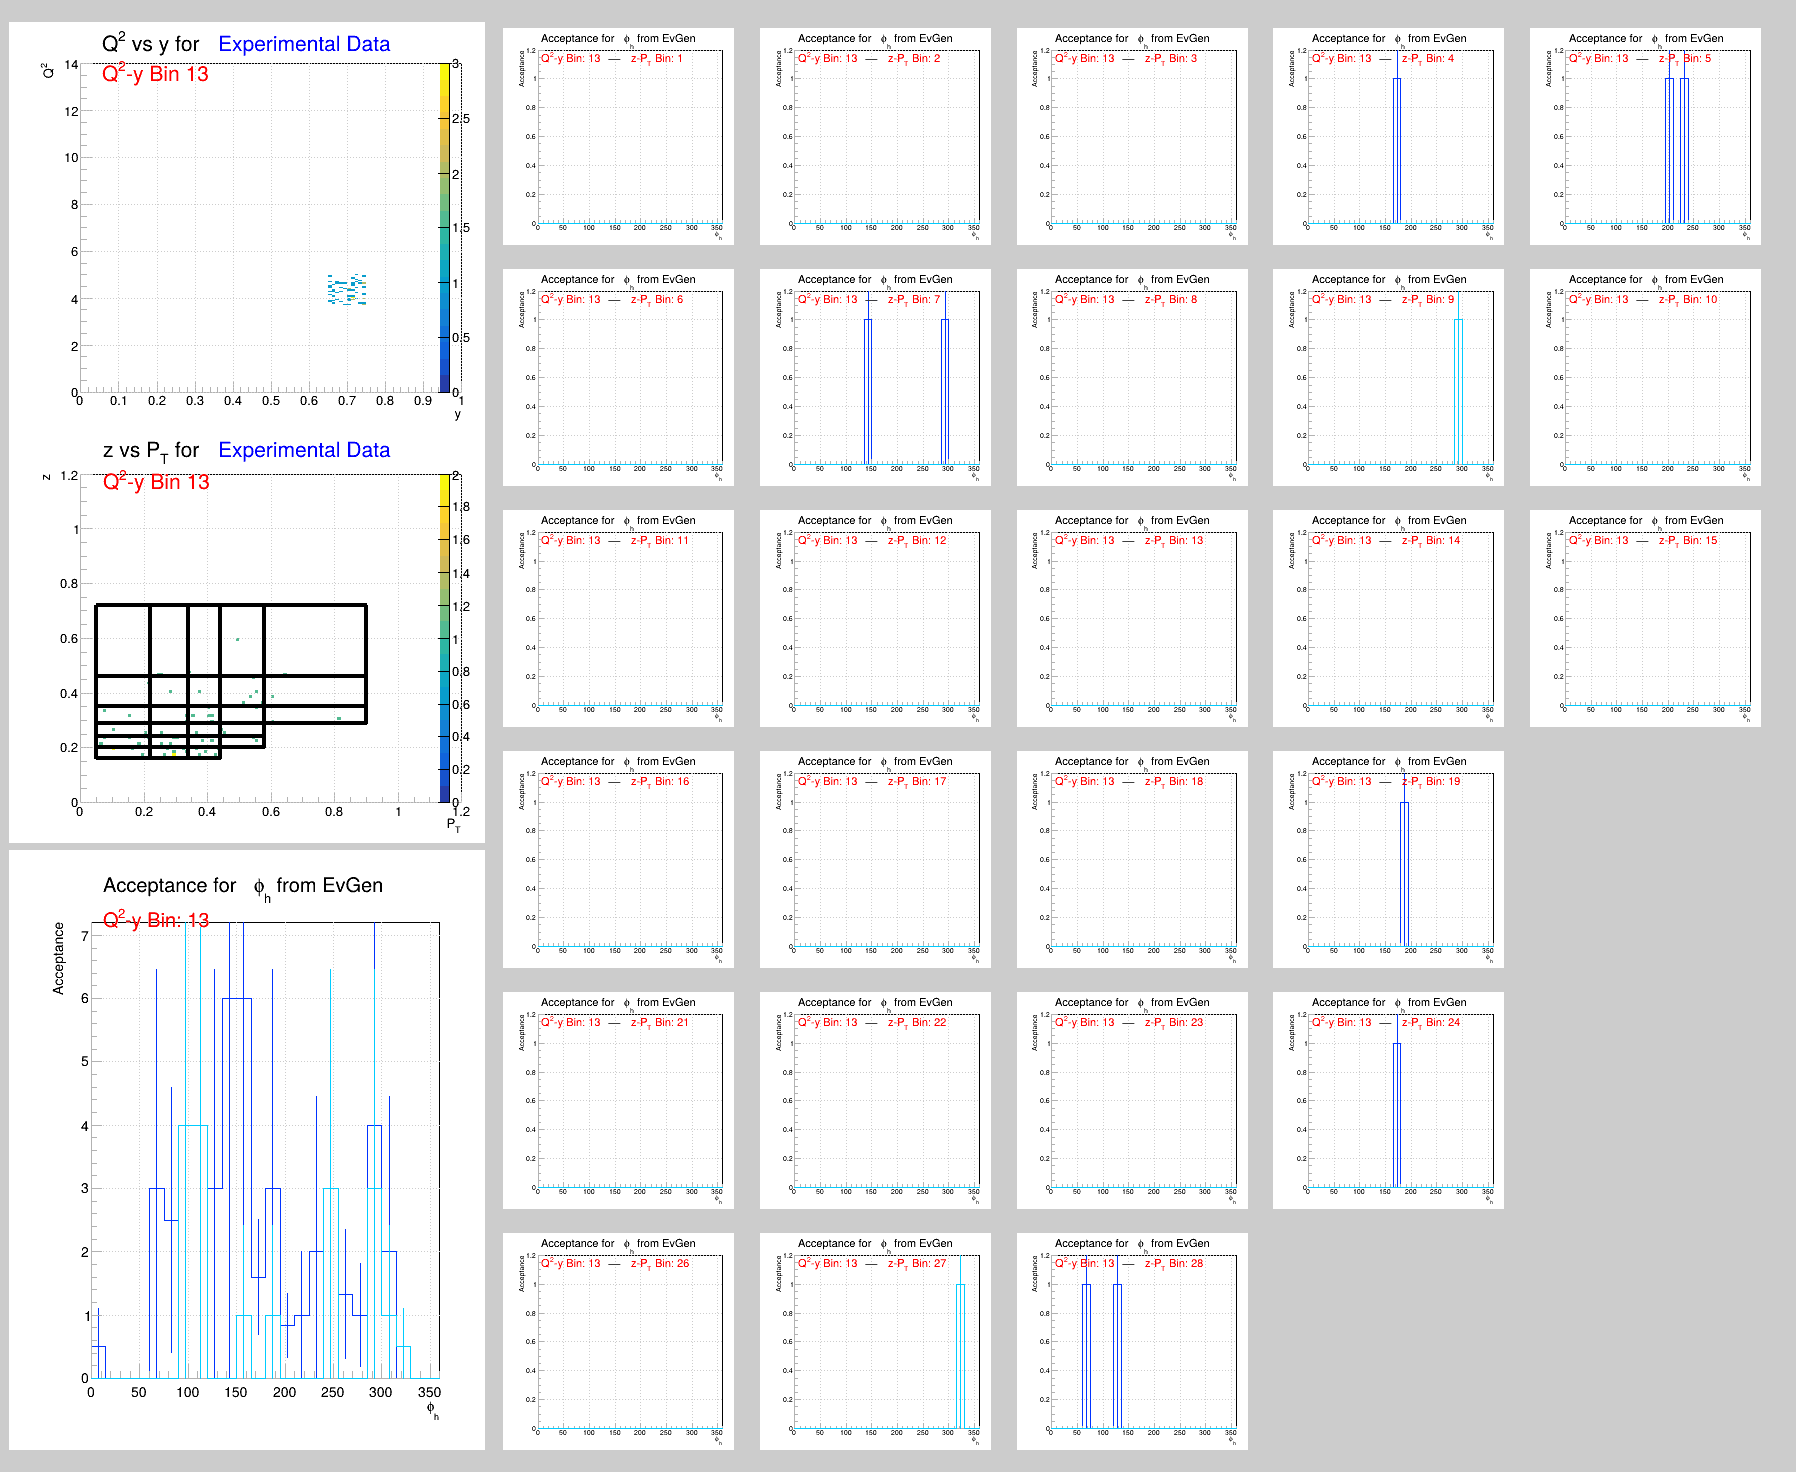

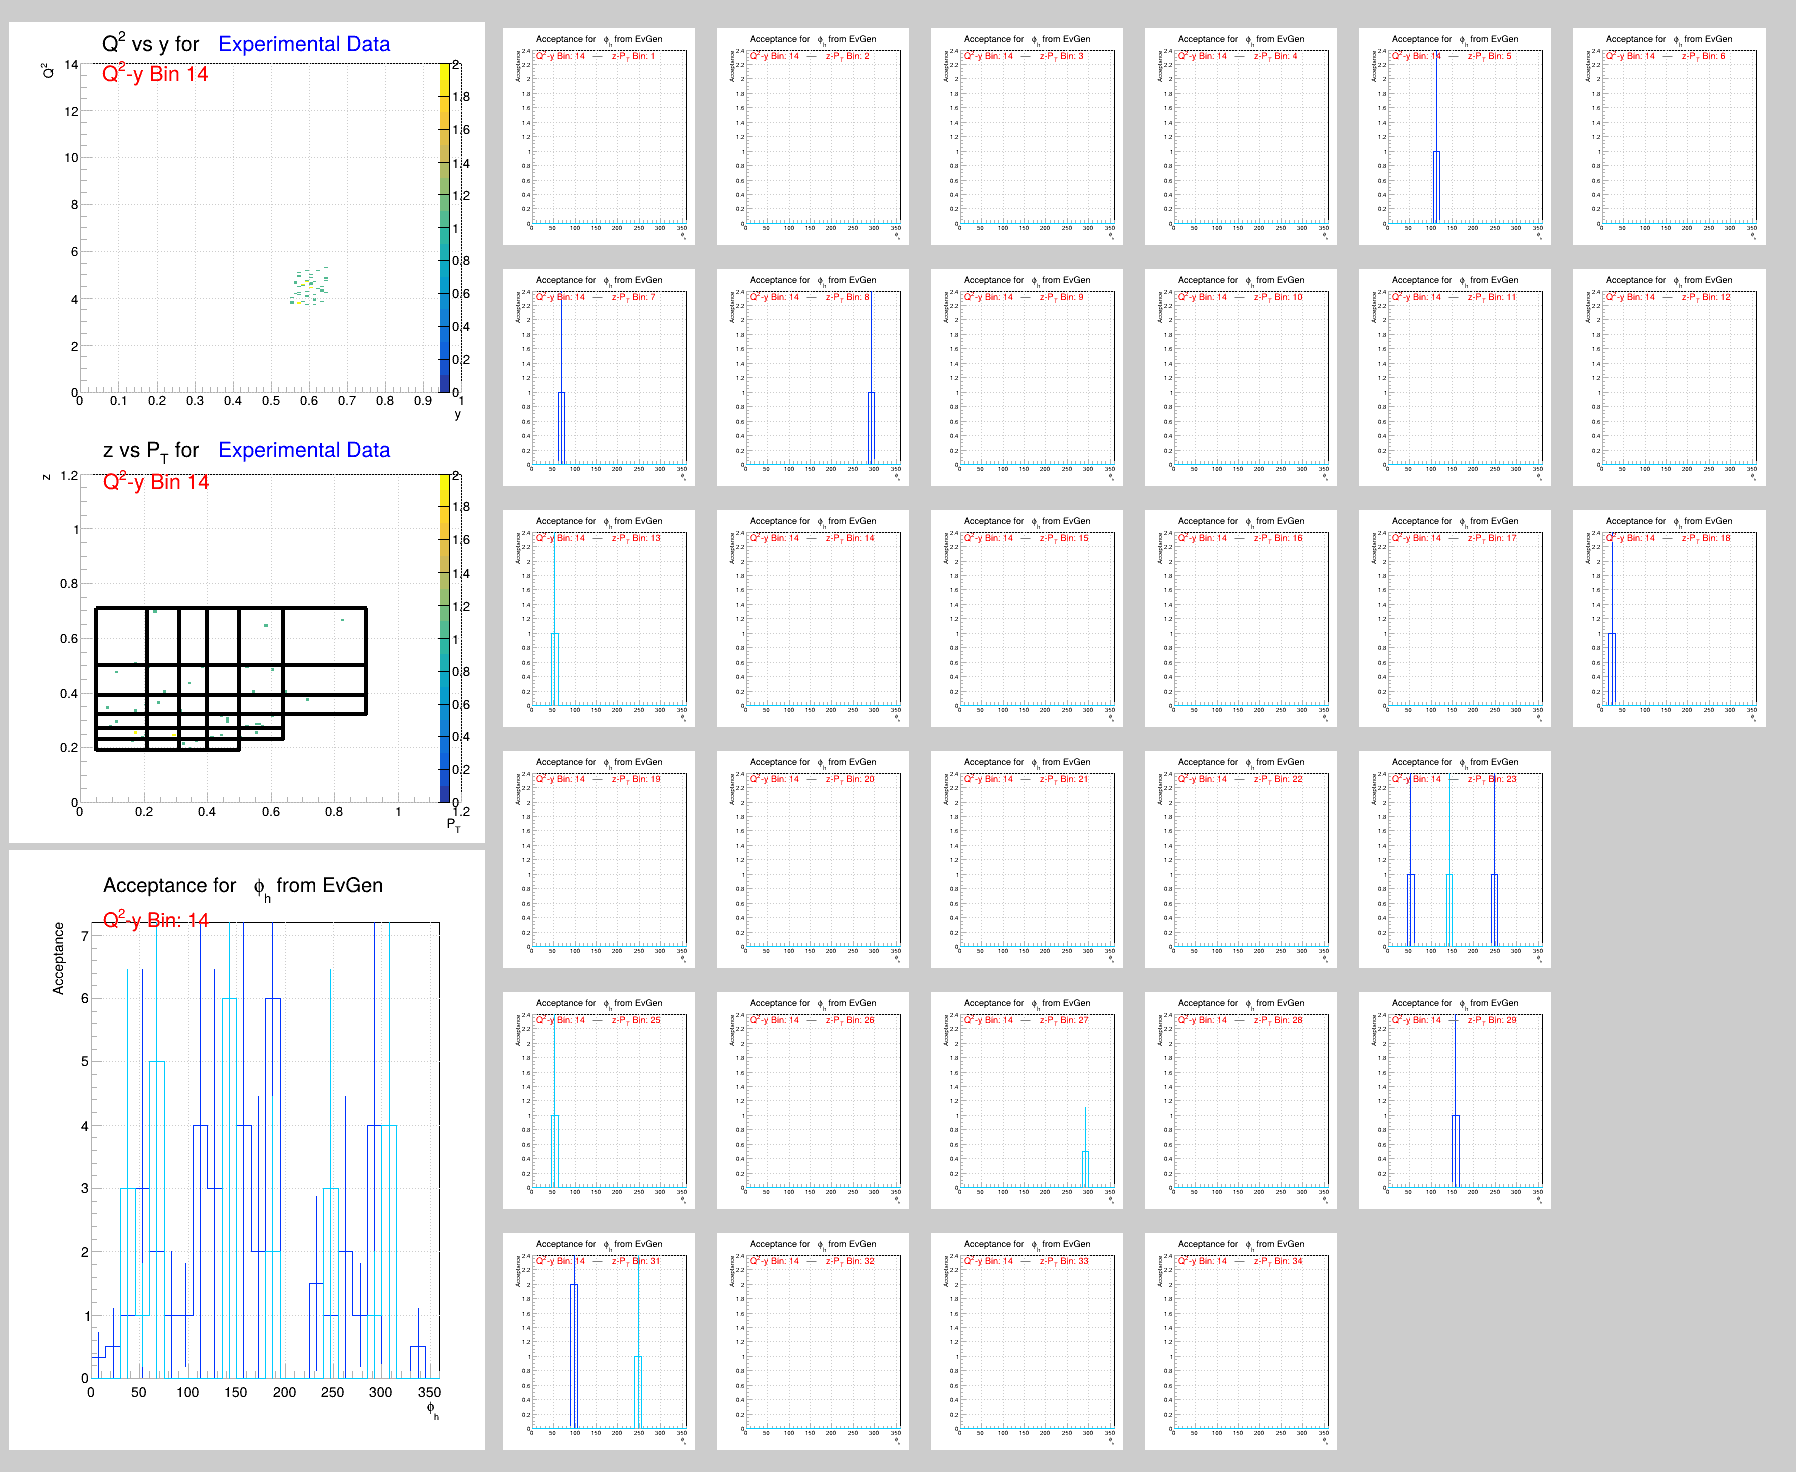

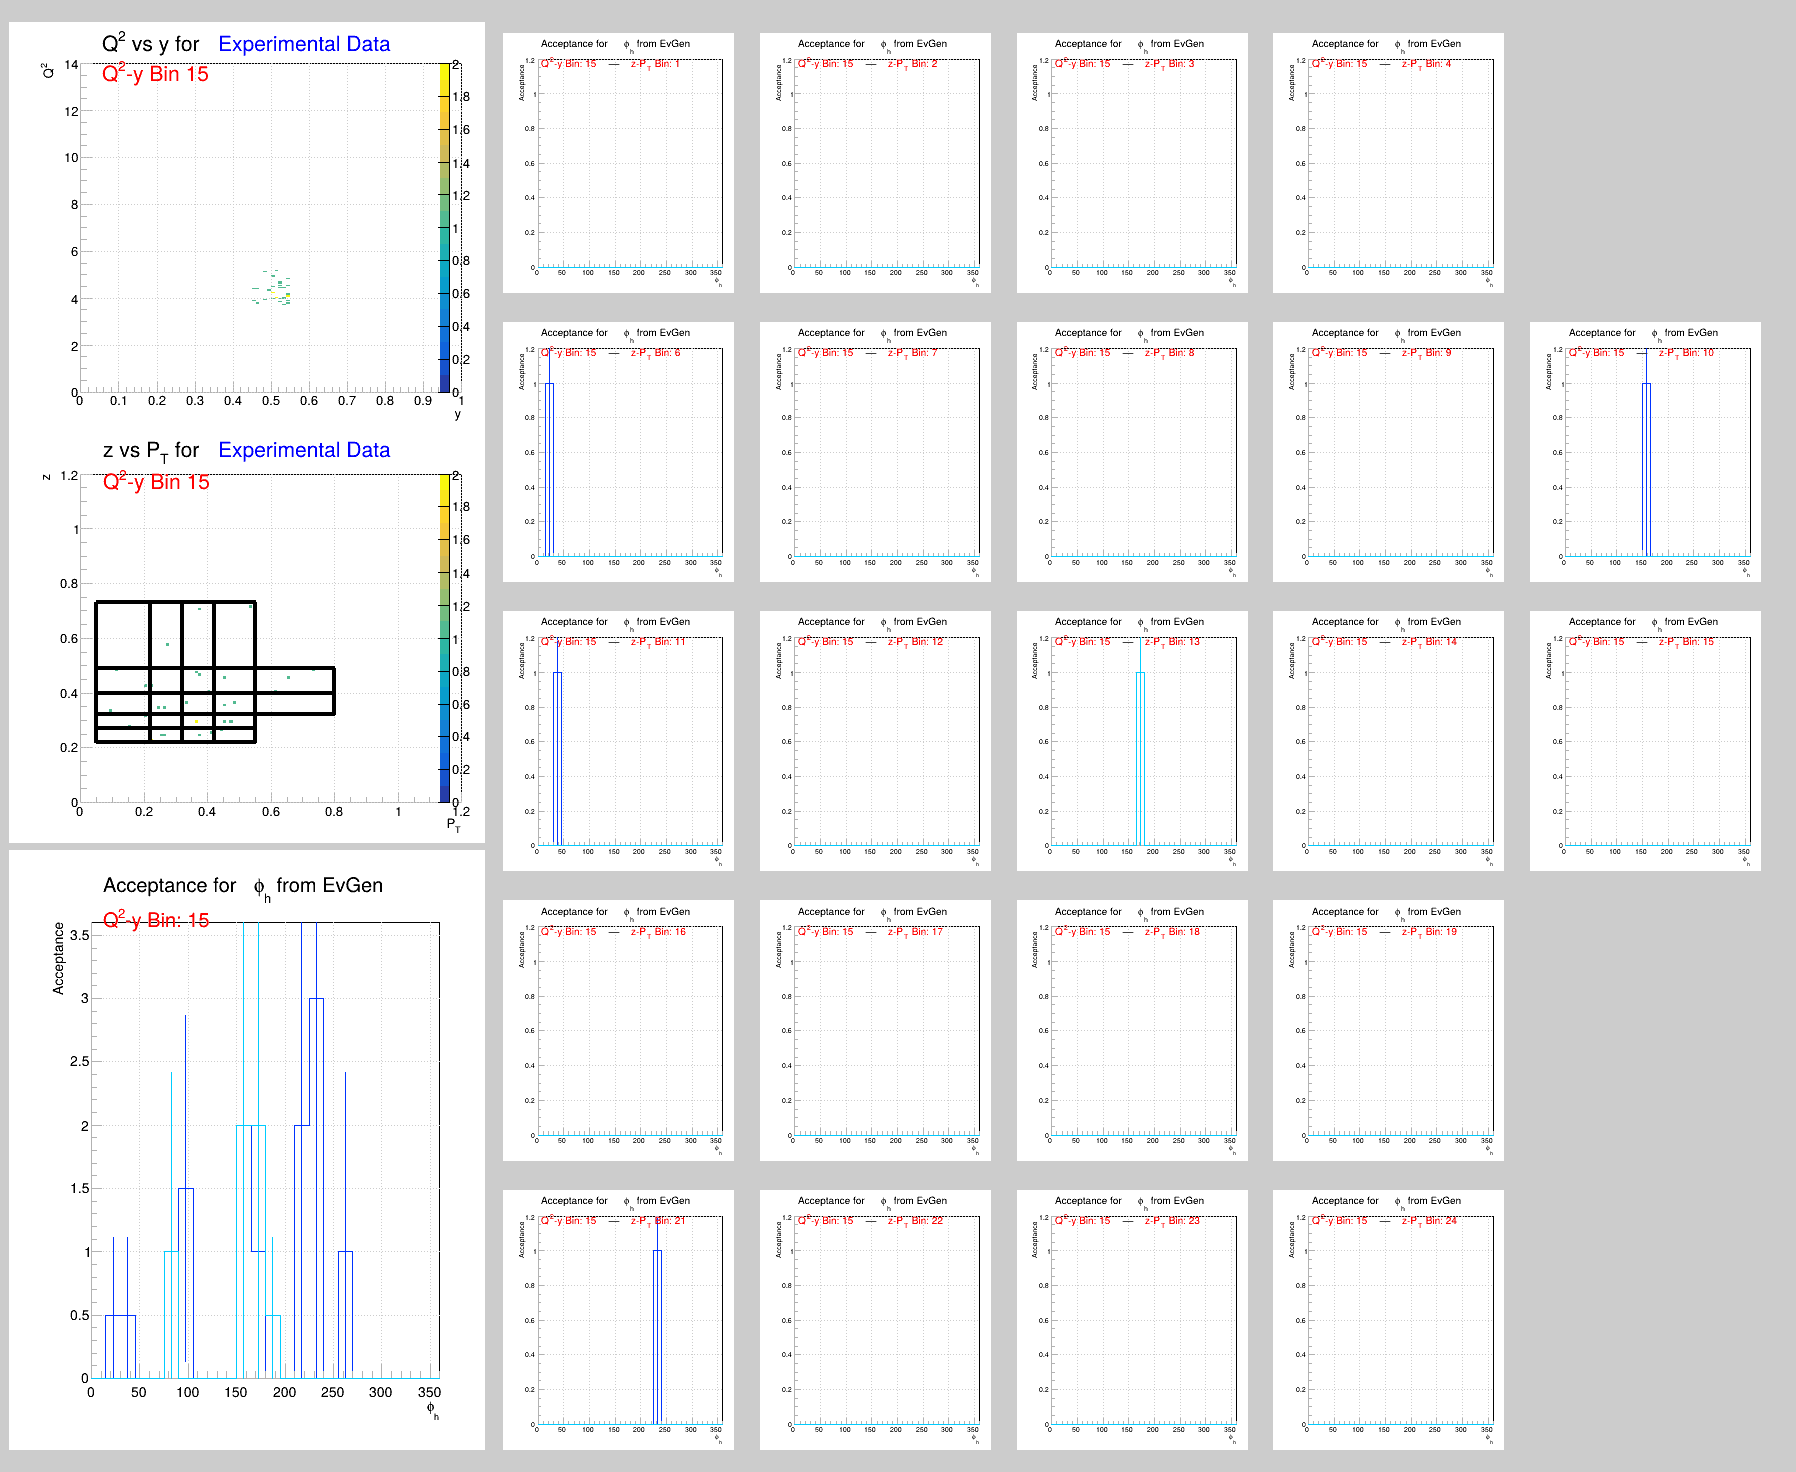

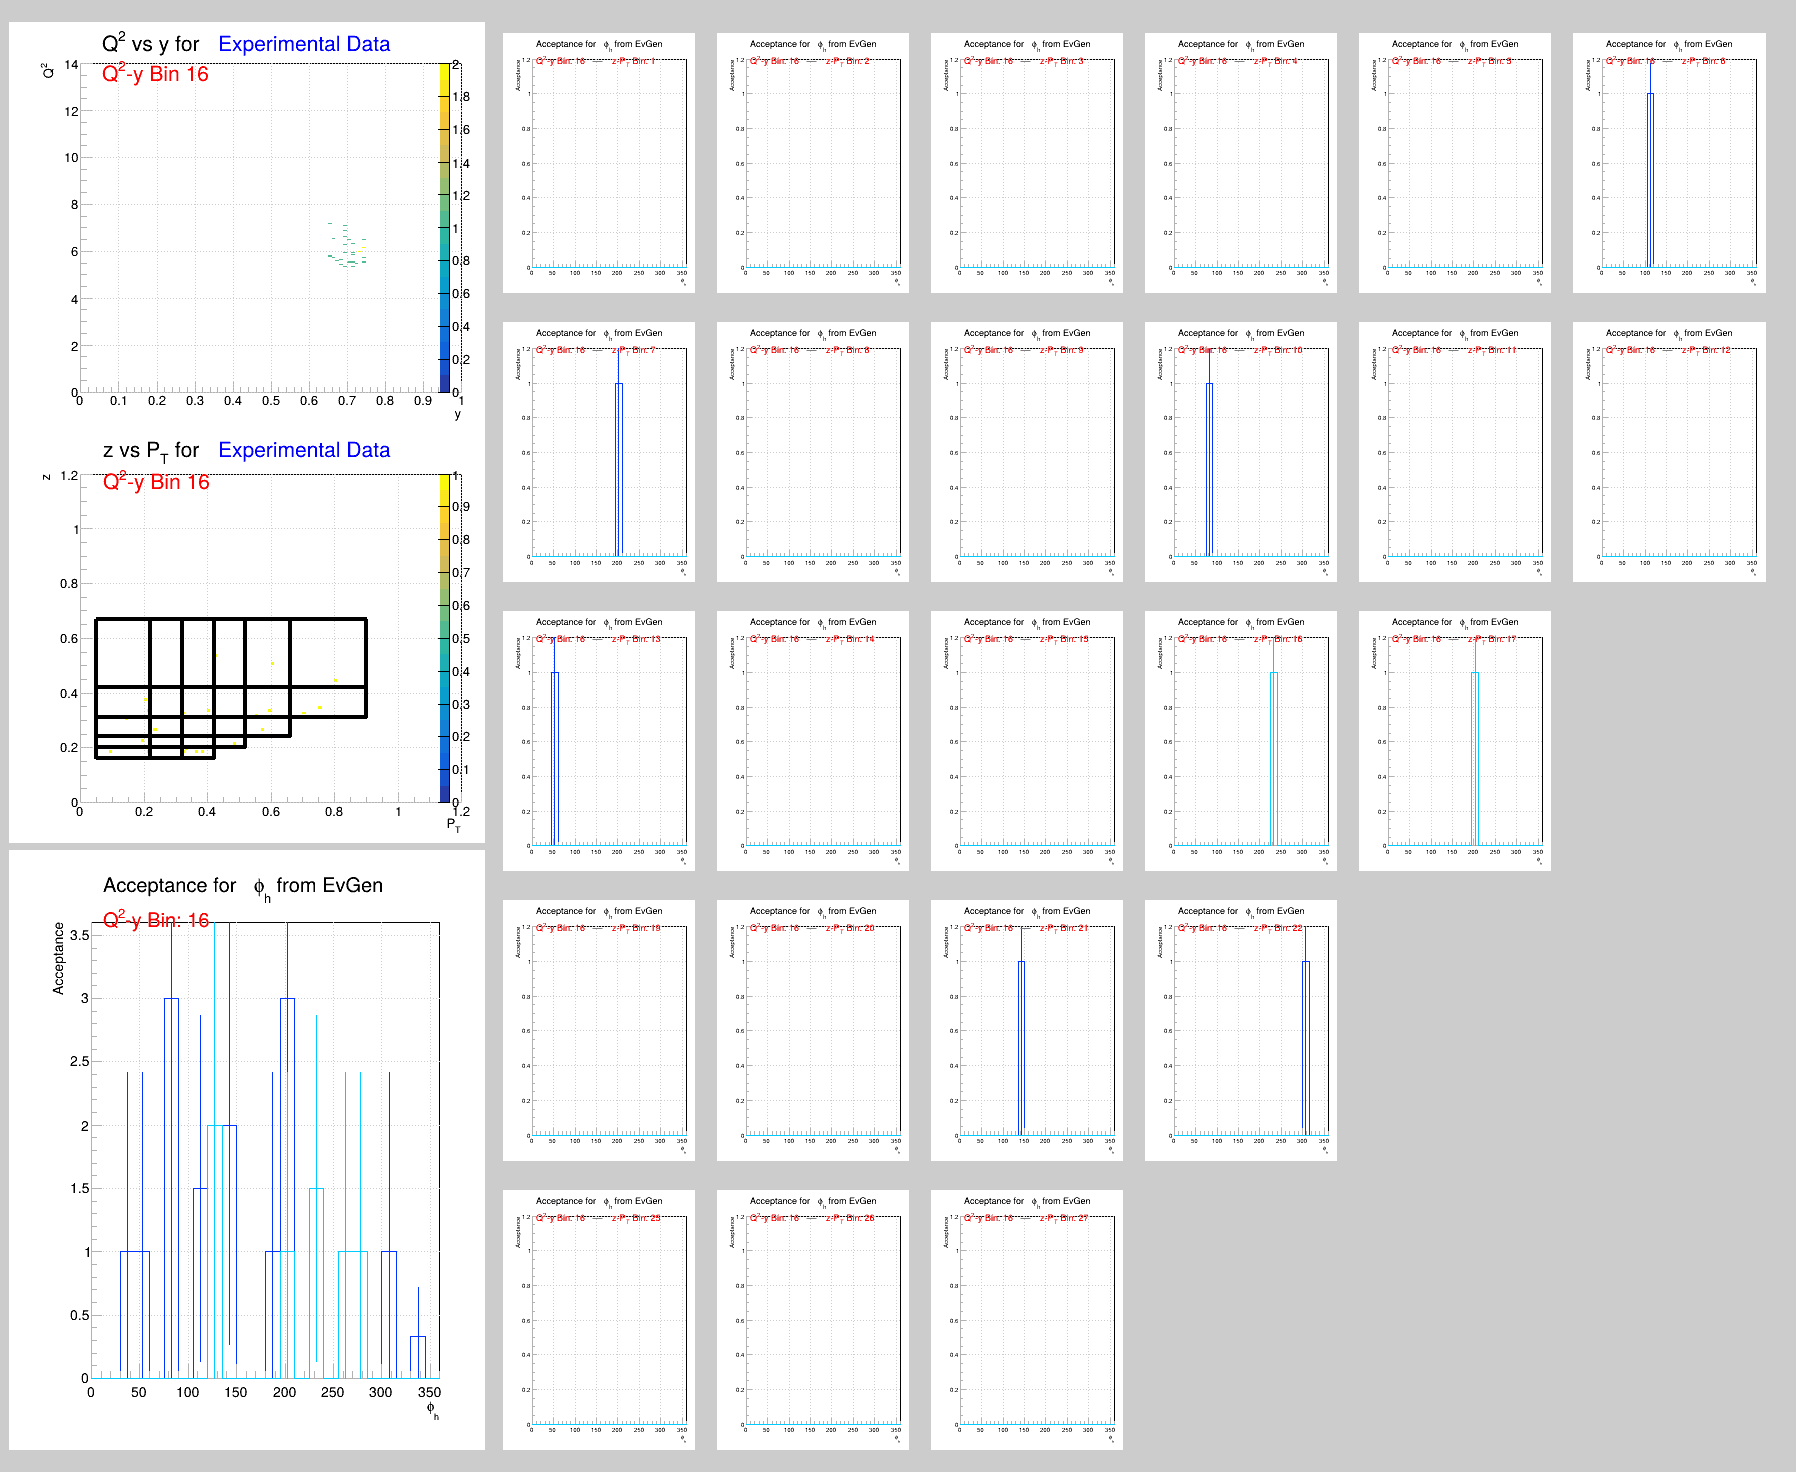

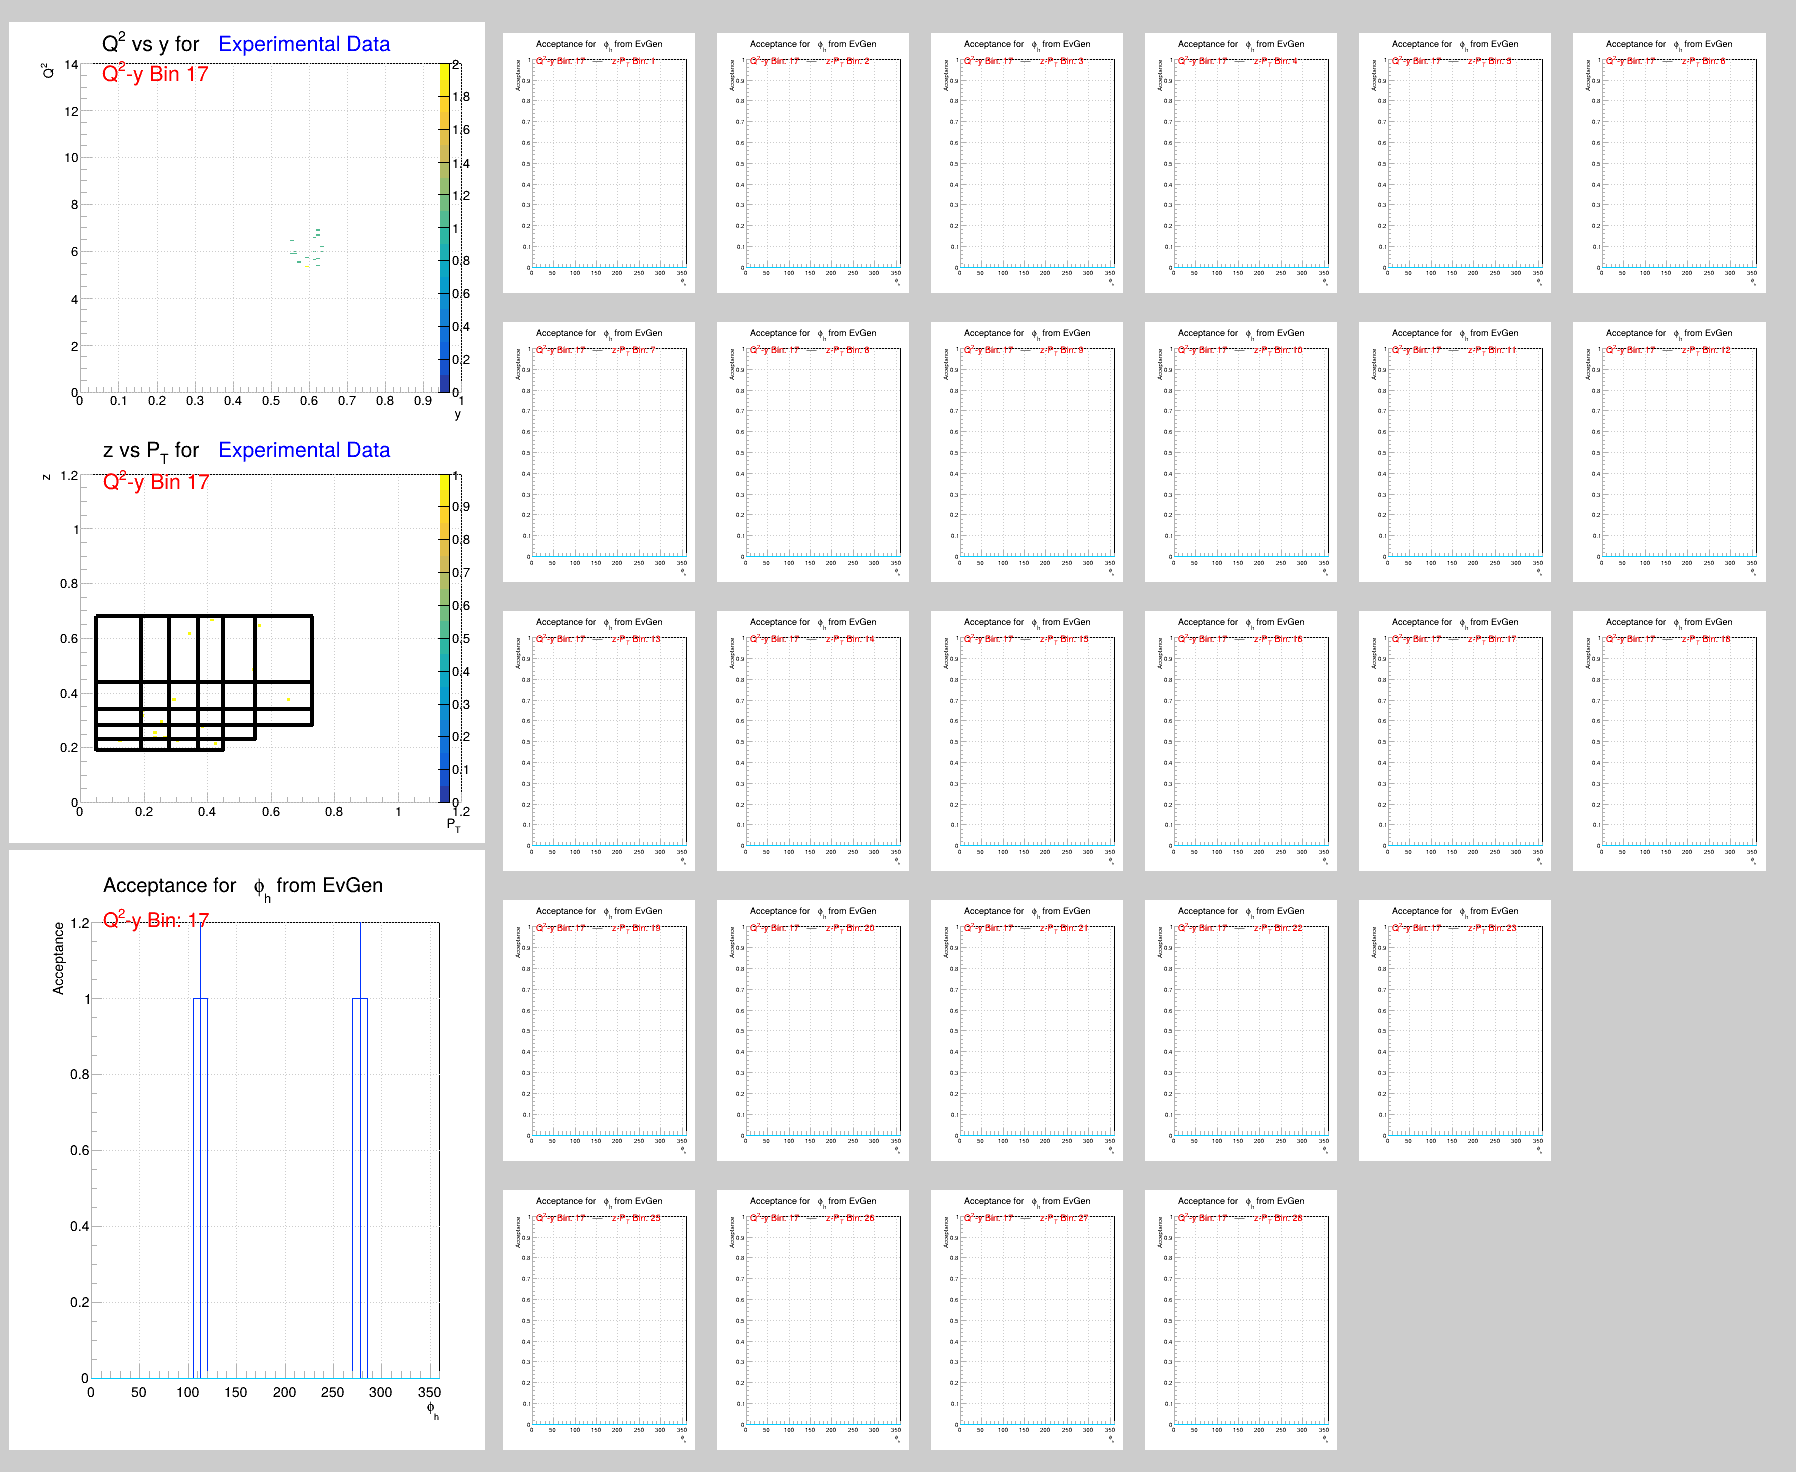

In [14]:
print(f"\n{color.BOLD}DRAWING ACCEPTANCE AS FUNCTION OF phi_h FOR ALL KINEMATIC BINS\n{color.END}")

phi_t_Binning = ['phi_t',  0,   360,    24]
Q2_Binning    = ['Q2',     0,    14,   280]
y_Binning     = ['y',      0,     1,   100]
z_Binning     = ['z',      0,  1.20,   120]
pT_Binning    = ['pT',     0,  1.50,   150]

rdf_binned         =         rdf.Filter("(Q2_Y_Bin > 0) && (z_pT_Bin_Y_bin > 0)")
mdf_clasdis_binned = mdf_clasdis.Filter("(Q2_Y_Bin > 0) && (z_pT_Bin_Y_bin > 0)")
mdf_EvGen_binned   =   mdf_EvGen.Filter("(Q2_Y_Bin > 0) && (z_pT_Bin_Y_bin > 0)")
gdf_clasdis_binned = gdf_clasdis.Filter("(Q2_Y_Bin > 0) && (z_pT_Bin_Y_bin > 0)")
gdf_EvGen_binned   =   gdf_EvGen.Filter("(Q2_Y_Bin > 0) && (z_pT_Bin_Y_bin > 0)")


# Histos_1D, Histos_2D, Max_Y_Range = {}, {}, {}
Histogram_List_All, Acceptance_Canvases = {}, {}
# count = 0
for     Q2_y_Bin in range(1, 18):
    Histogram_List_All[f"Q2-y Bin ({Q2_y_Bin}-All)"] = (rdf_binned.Filter(f"Q2_Y_Bin == {Q2_y_Bin}")).Histo2D((f"Q2-y Bin ({Q2_y_Bin}-All)", f"#splitline{{Q^{{2}} vs y for #color[{ROOT.kBlue}]{{Experimental Data}}}}{{#color[{ROOT.kRed}]{{Q^{{2}}-y Bin {Q2_y_Bin}}}}}; y; Q^{{2}}",    y_Binning[3],  y_Binning[1],  y_Binning[2], Q2_Binning[3], Q2_Binning[1], Q2_Binning[2]),  y_Binning[0], Q2_Binning[0])
    Histogram_List_All[f"z-pT Bin ({Q2_y_Bin}-All)"] = (rdf_binned.Filter(f"Q2_Y_Bin == {Q2_y_Bin}")).Histo2D((f"z-pT Bin ({Q2_y_Bin}-All)", f"#splitline{{z vs P_{{T}} for #color[{ROOT.kBlue}]{{Experimental Data}}}}{{#color[{ROOT.kRed}]{{Q^{{2}}-y Bin {Q2_y_Bin}}}}}; P_{{T}}; z",   pT_Binning[3], pT_Binning[1], pT_Binning[2],  z_Binning[3],  z_Binning[1],  z_Binning[2]), pT_Binning[0],  z_Binning[0])
    _, _, Histogram_List_All[f"EvGen Acceptance Bin ({Q2_y_Bin}-All)"]   = Create_Binned_Acceptance_Hist(mdf_IN=mdf_EvGen_binned,   gdf_IN=gdf_EvGen_binned,   source="EvGen",   PHI_T_Binning=phi_t_Binning, Q2_Y_Bin=Q2_y_Bin, Z_PT_Bin=None)
    _, _, Histogram_List_All[f"clasdis Acceptance Bin ({Q2_y_Bin}-All)"] = Create_Binned_Acceptance_Hist(mdf_IN=mdf_clasdis_binned, gdf_IN=gdf_clasdis_binned, source="clasdis", PHI_T_Binning=phi_t_Binning, Q2_Y_Bin=Q2_y_Bin, Z_PT_Bin=None)
    # count += 8
    Histogram_List_All[f"Acceptance max for {Q2_y_Bin}"] = 0
    z_pT_Bin_Range = Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1]
    for z_pT_Bin in range(1, z_pT_Bin_Range + 1):
        if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD=Binning_Method, Common_z_pT_Range_Q=False)):
            continue
        # count += 6
        # print(f"{Q2_y_Bin:>2.0f} - {z_pT_Bin:>2.0f} (z-pT Total: {z_pT_Bin_Range}) -- Current Histo Total: {count}")
        _, _, Histogram_List_All[f"EvGen Acceptance Bin ({Q2_y_Bin}-{z_pT_Bin})"]   = Create_Binned_Acceptance_Hist(mdf_IN=mdf_EvGen_binned,   gdf_IN=gdf_EvGen_binned,   source="EvGen",   PHI_T_Binning=phi_t_Binning, Q2_Y_Bin=Q2_y_Bin, Z_PT_Bin=z_pT_Bin)
        _, _, Histogram_List_All[f"clasdis Acceptance Bin ({Q2_y_Bin}-{z_pT_Bin})"] = Create_Binned_Acceptance_Hist(mdf_IN=mdf_clasdis_binned, gdf_IN=gdf_clasdis_binned, source="clasdis", PHI_T_Binning=phi_t_Binning, Q2_Y_Bin=Q2_y_Bin, Z_PT_Bin=z_pT_Bin)
        Histogram_List_All[f"Acceptance max for {Q2_y_Bin}"] = max([find_max_bin(Histogram_List_All[f"EvGen Acceptance Bin ({Q2_y_Bin}-{z_pT_Bin})"]), find_max_bin(Histogram_List_All[f"clasdis Acceptance Bin ({Q2_y_Bin}-{z_pT_Bin})"]), Histogram_List_All[f"Acceptance max for {Q2_y_Bin}"]])
    Acceptance_Canvases[f"Acceptance for Q2_y_Bin = {Q2_y_Bin}"] = Acceptance_Compare_z_pT_Images_Together(Histogram_List_All=Histogram_List_All, Q2_Y_Bin=Q2_y_Bin, Plot_Orientation="z_pT", Saving_Q=True, File_Save_Format=".png")

print("Done")



DRAWING ALL AVAILABLE 'Acceptance_Canvases' TCanvas

Drawing: Acceptance for Q2_y_Bin = 1
Drawing: Acceptance for Q2_y_Bin = 2
Drawing: Acceptance for Q2_y_Bin = 3
Drawing: Acceptance for Q2_y_Bin = 4
Drawing: Acceptance for Q2_y_Bin = 5
Drawing: Acceptance for Q2_y_Bin = 6
Drawing: Acceptance for Q2_y_Bin = 7
Drawing: Acceptance for Q2_y_Bin = 8
Drawing: Acceptance for Q2_y_Bin = 9
Drawing: Acceptance for Q2_y_Bin = 10
Drawing: Acceptance for Q2_y_Bin = 11
Drawing: Acceptance for Q2_y_Bin = 12
Drawing: Acceptance for Q2_y_Bin = 13
Drawing: Acceptance for Q2_y_Bin = 14
Drawing: Acceptance for Q2_y_Bin = 15
Drawing: Acceptance for Q2_y_Bin = 16
Drawing: Acceptance for Q2_y_Bin = 17
Done


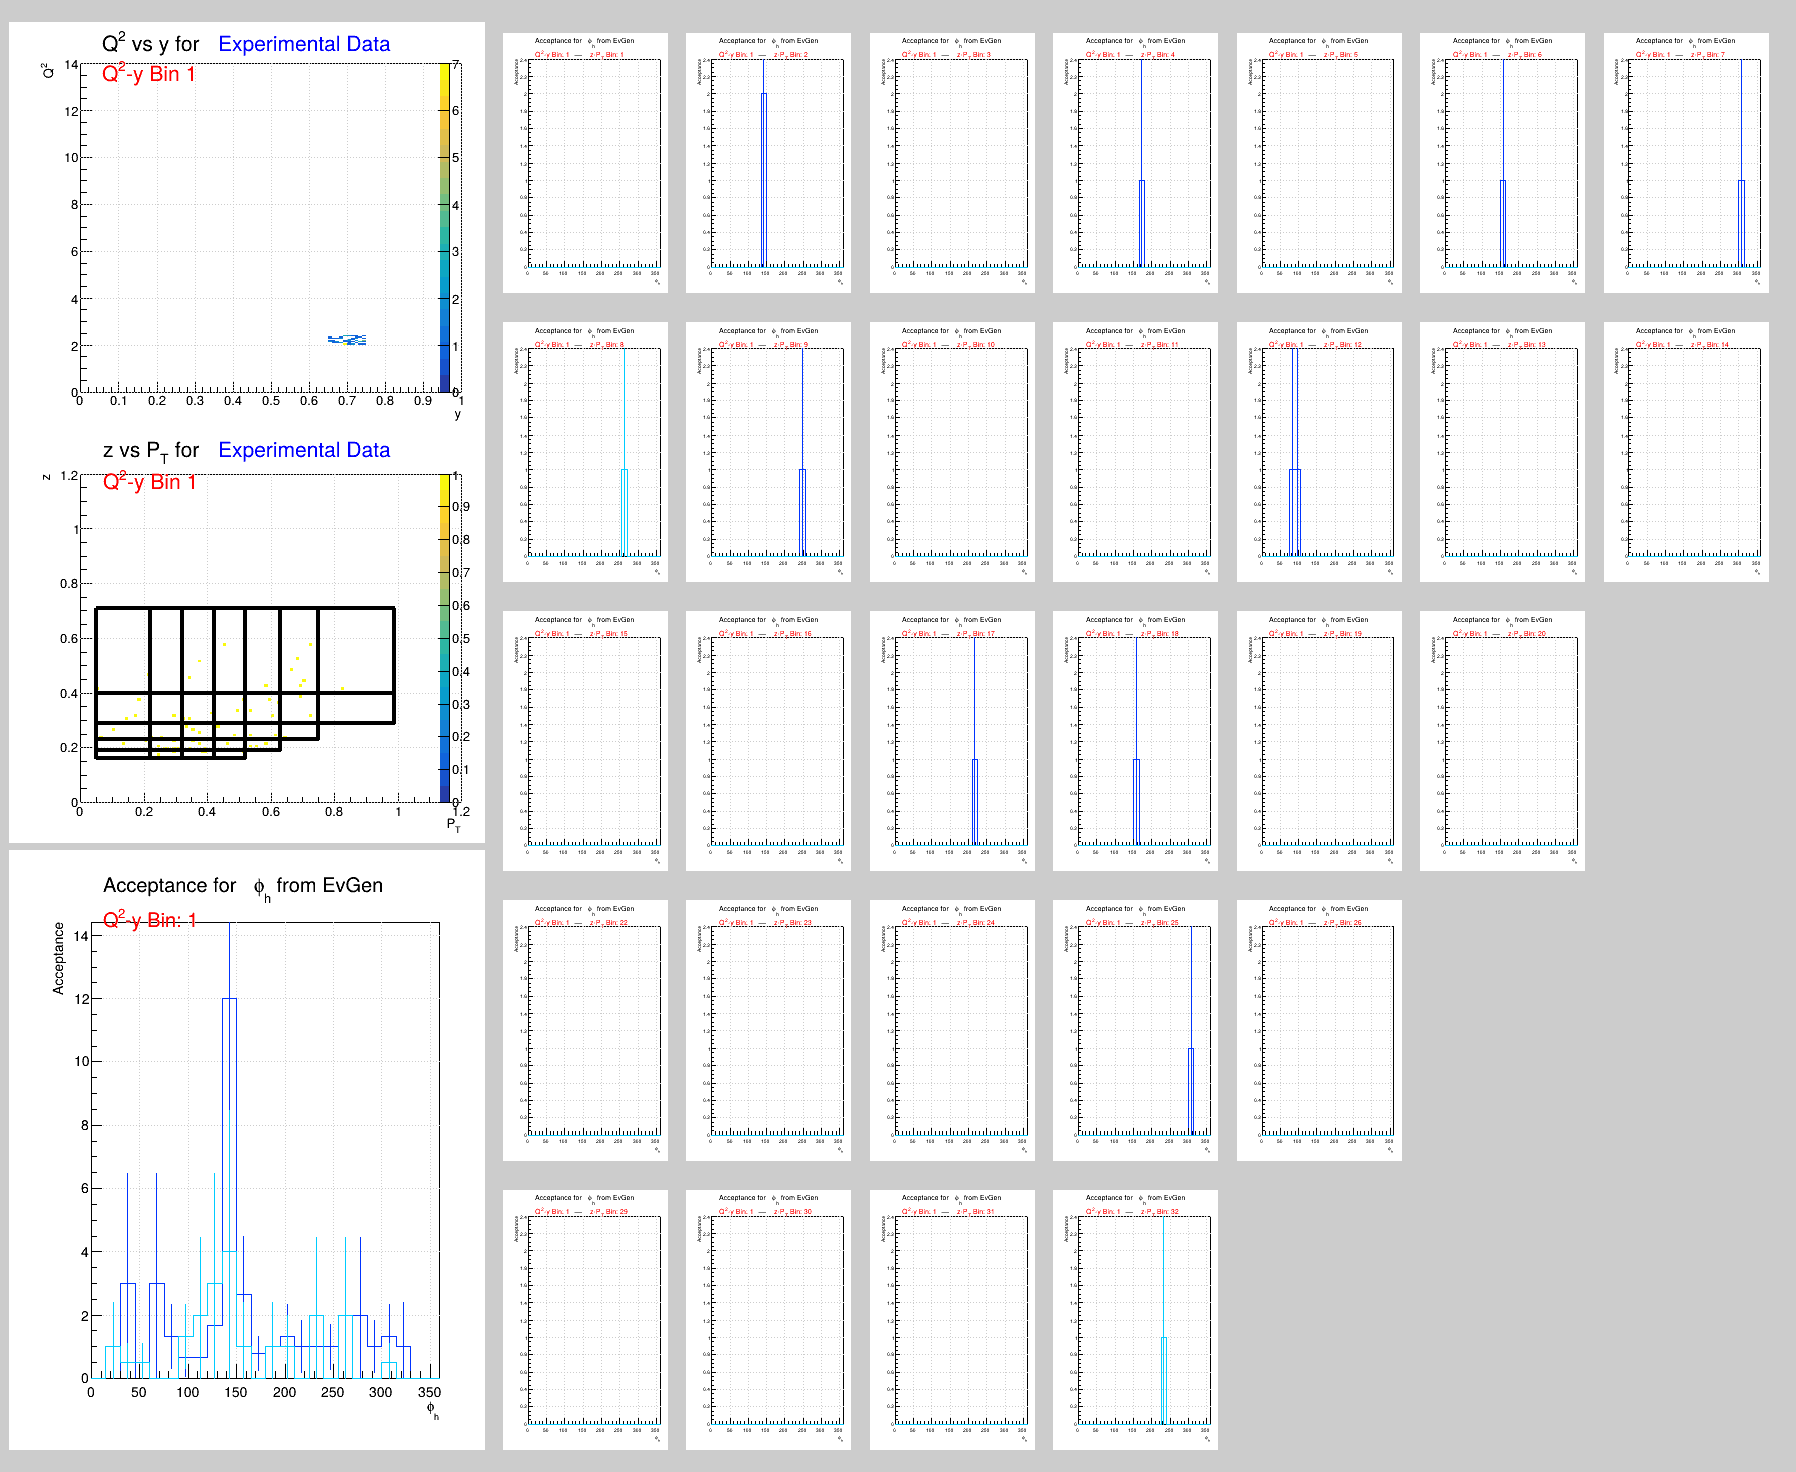

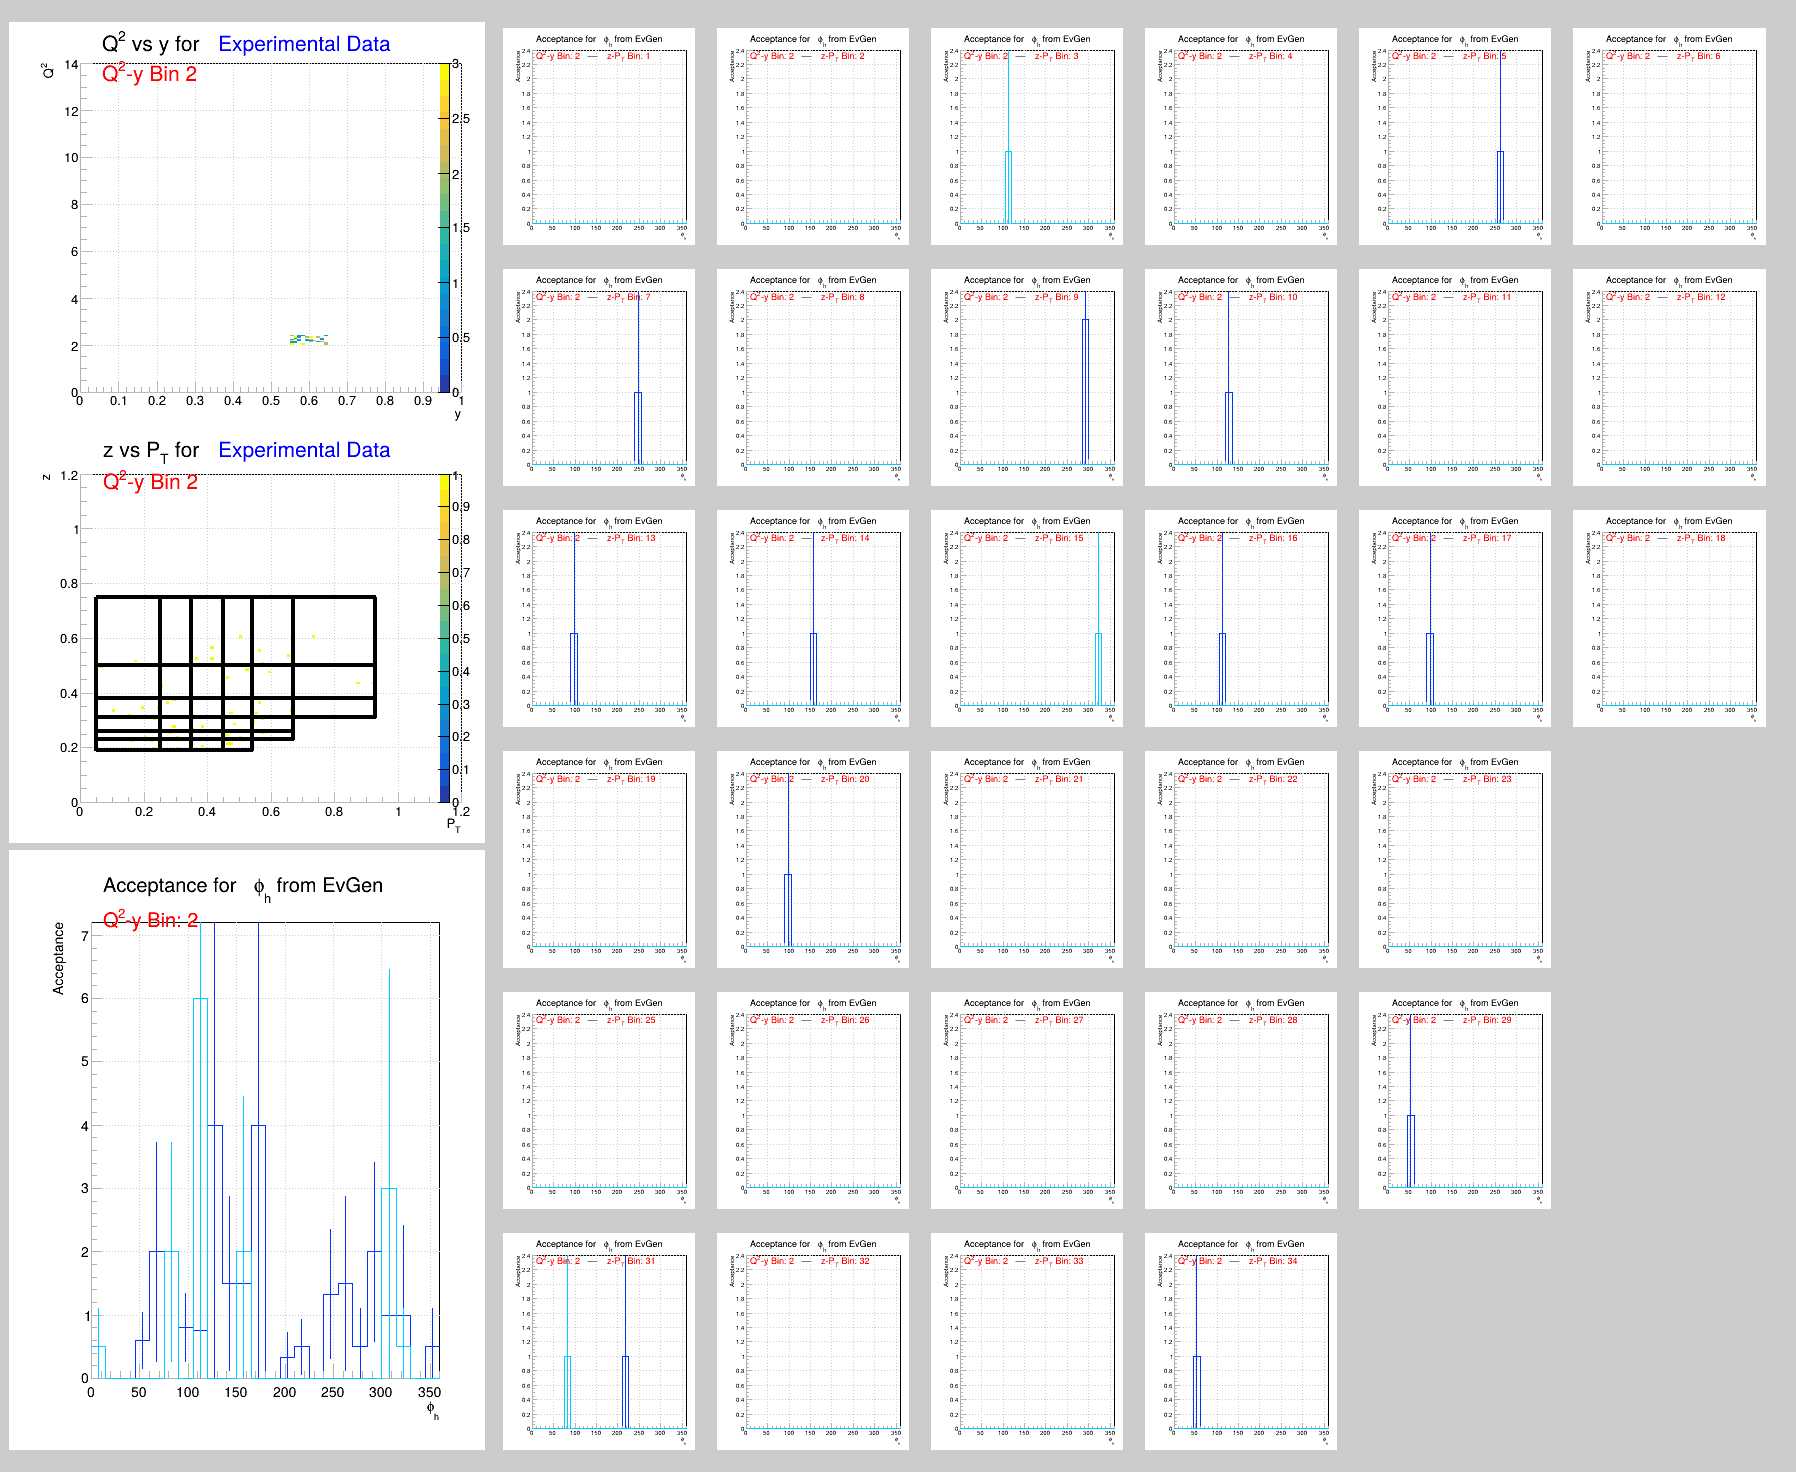

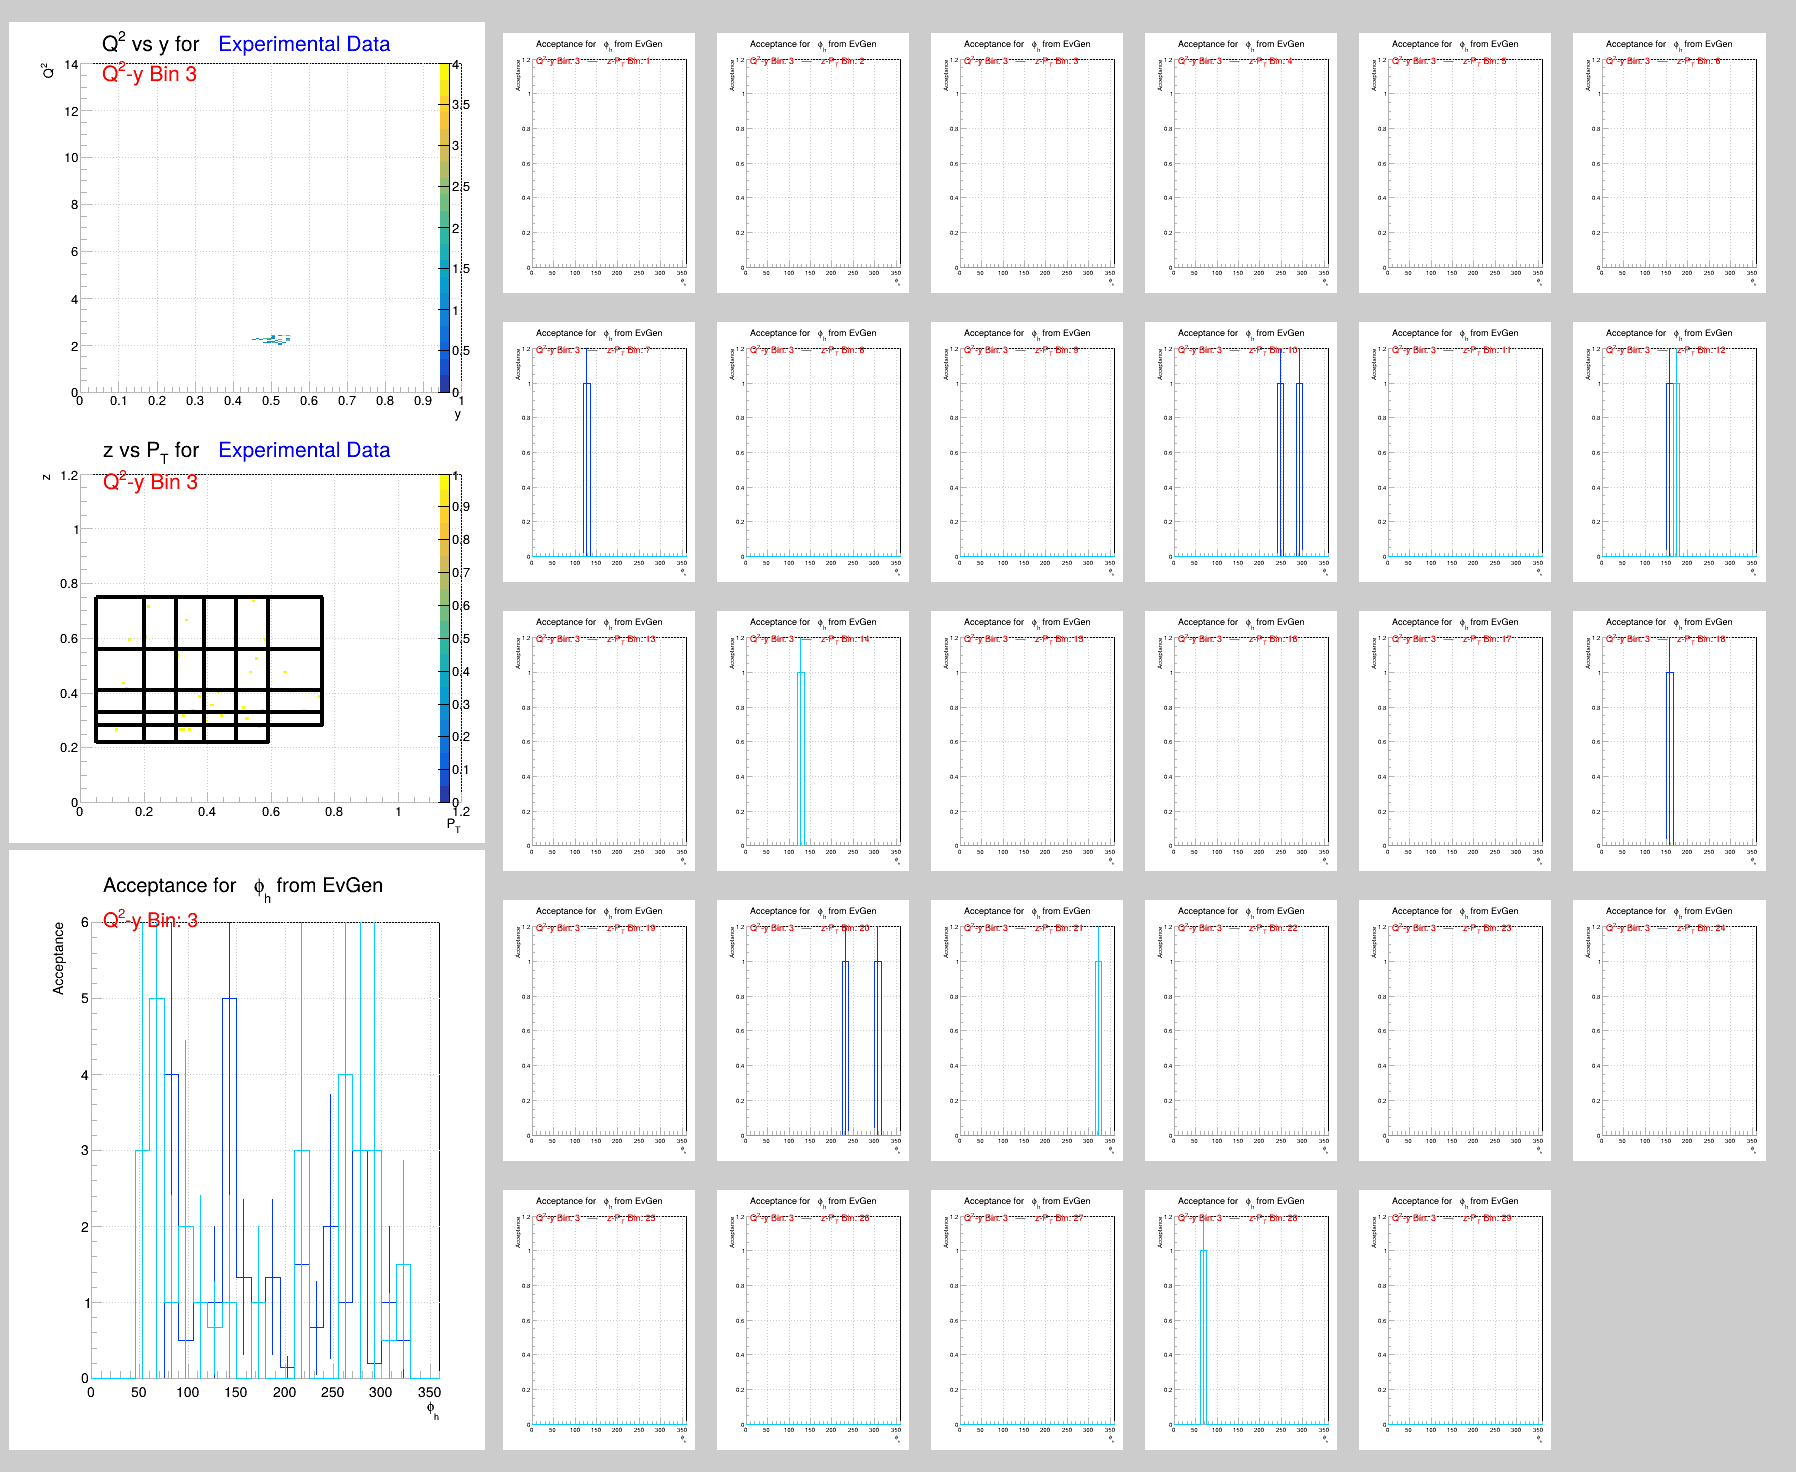

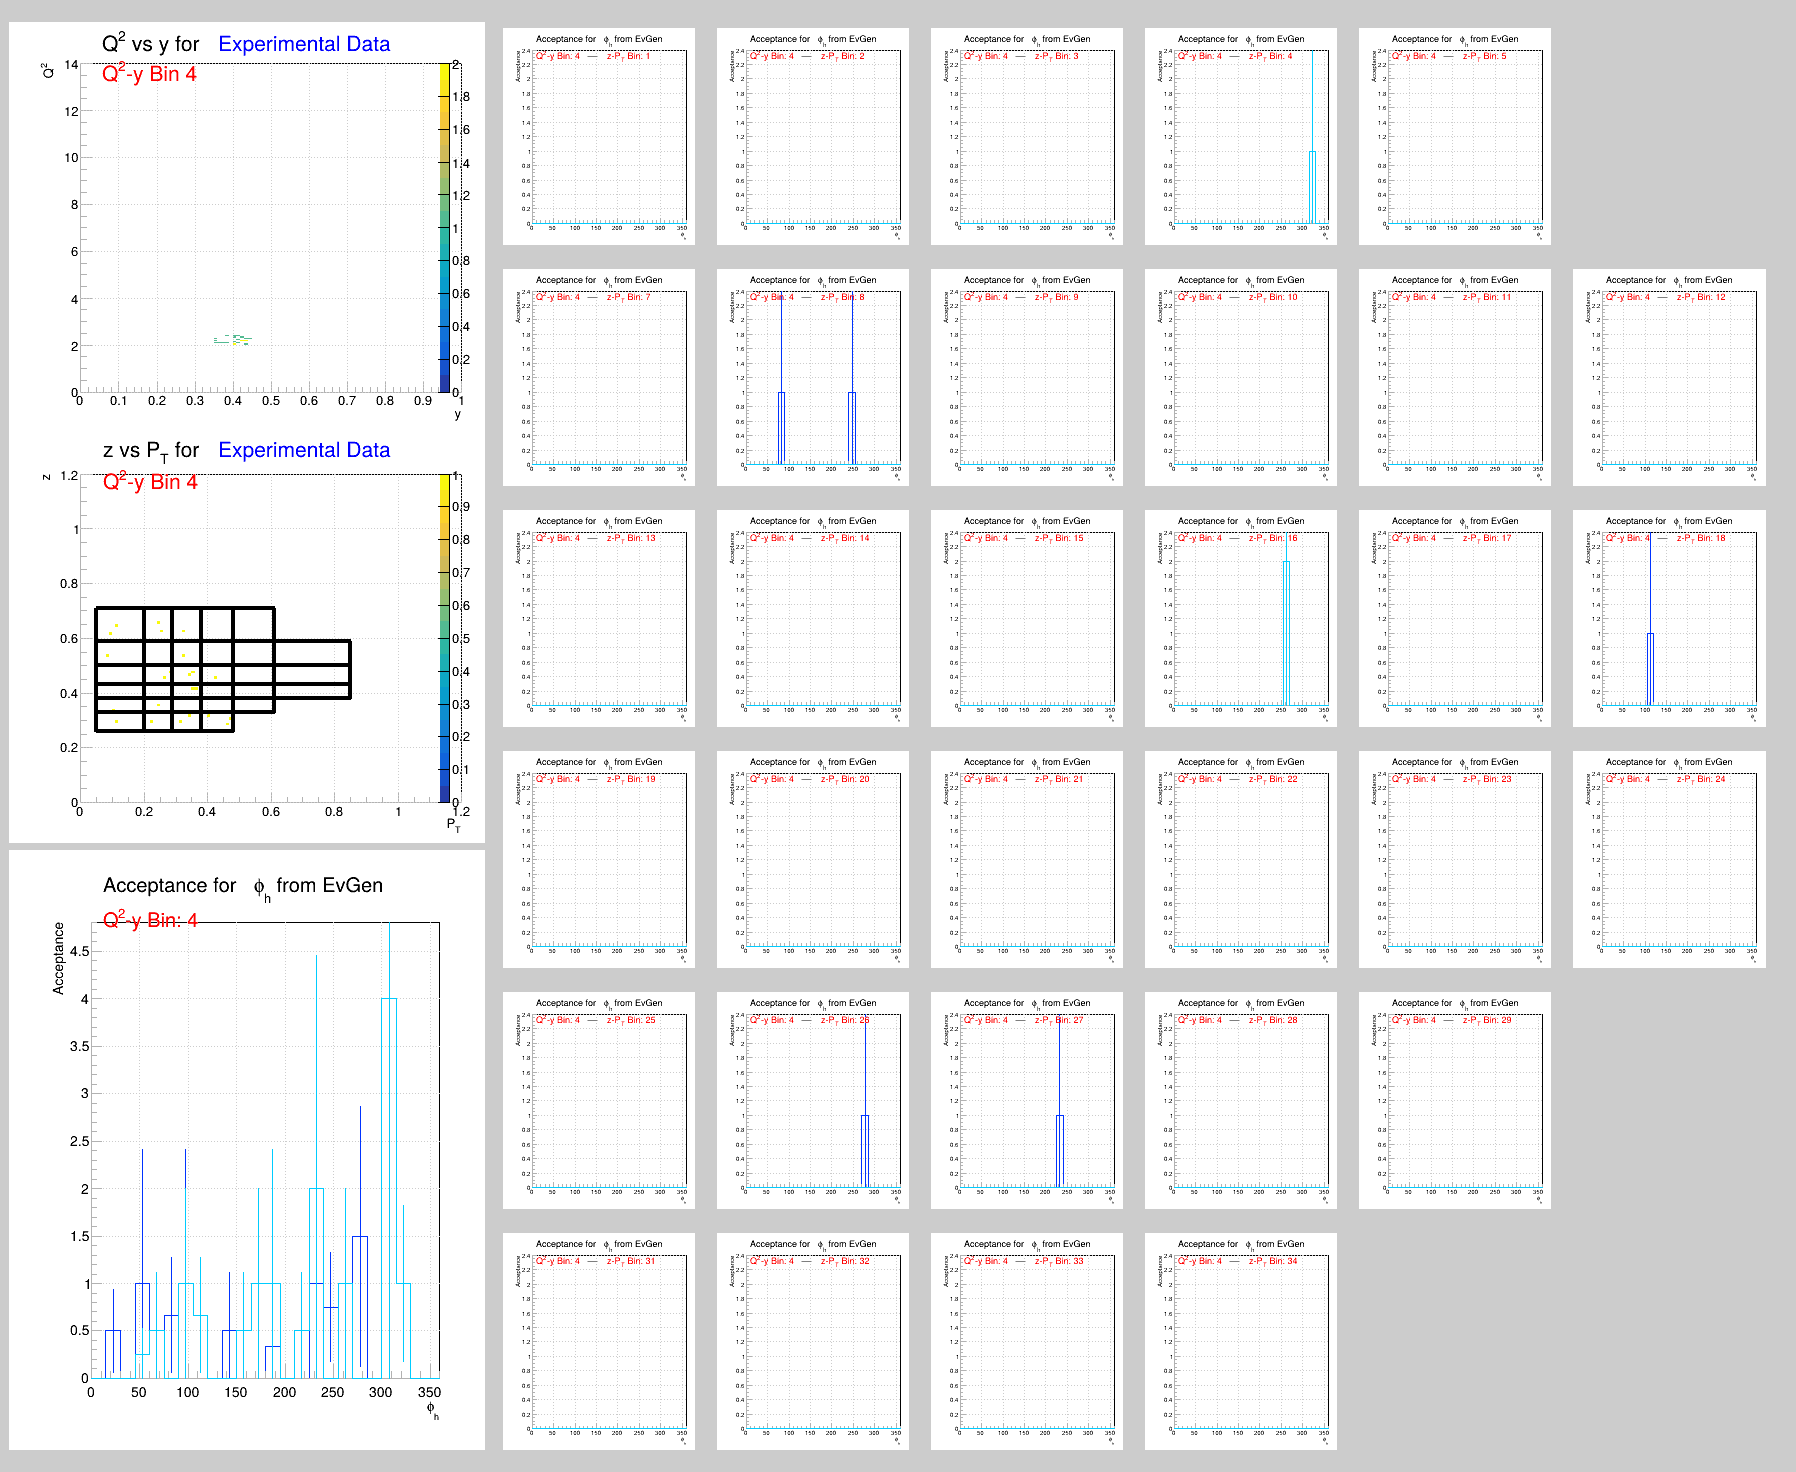

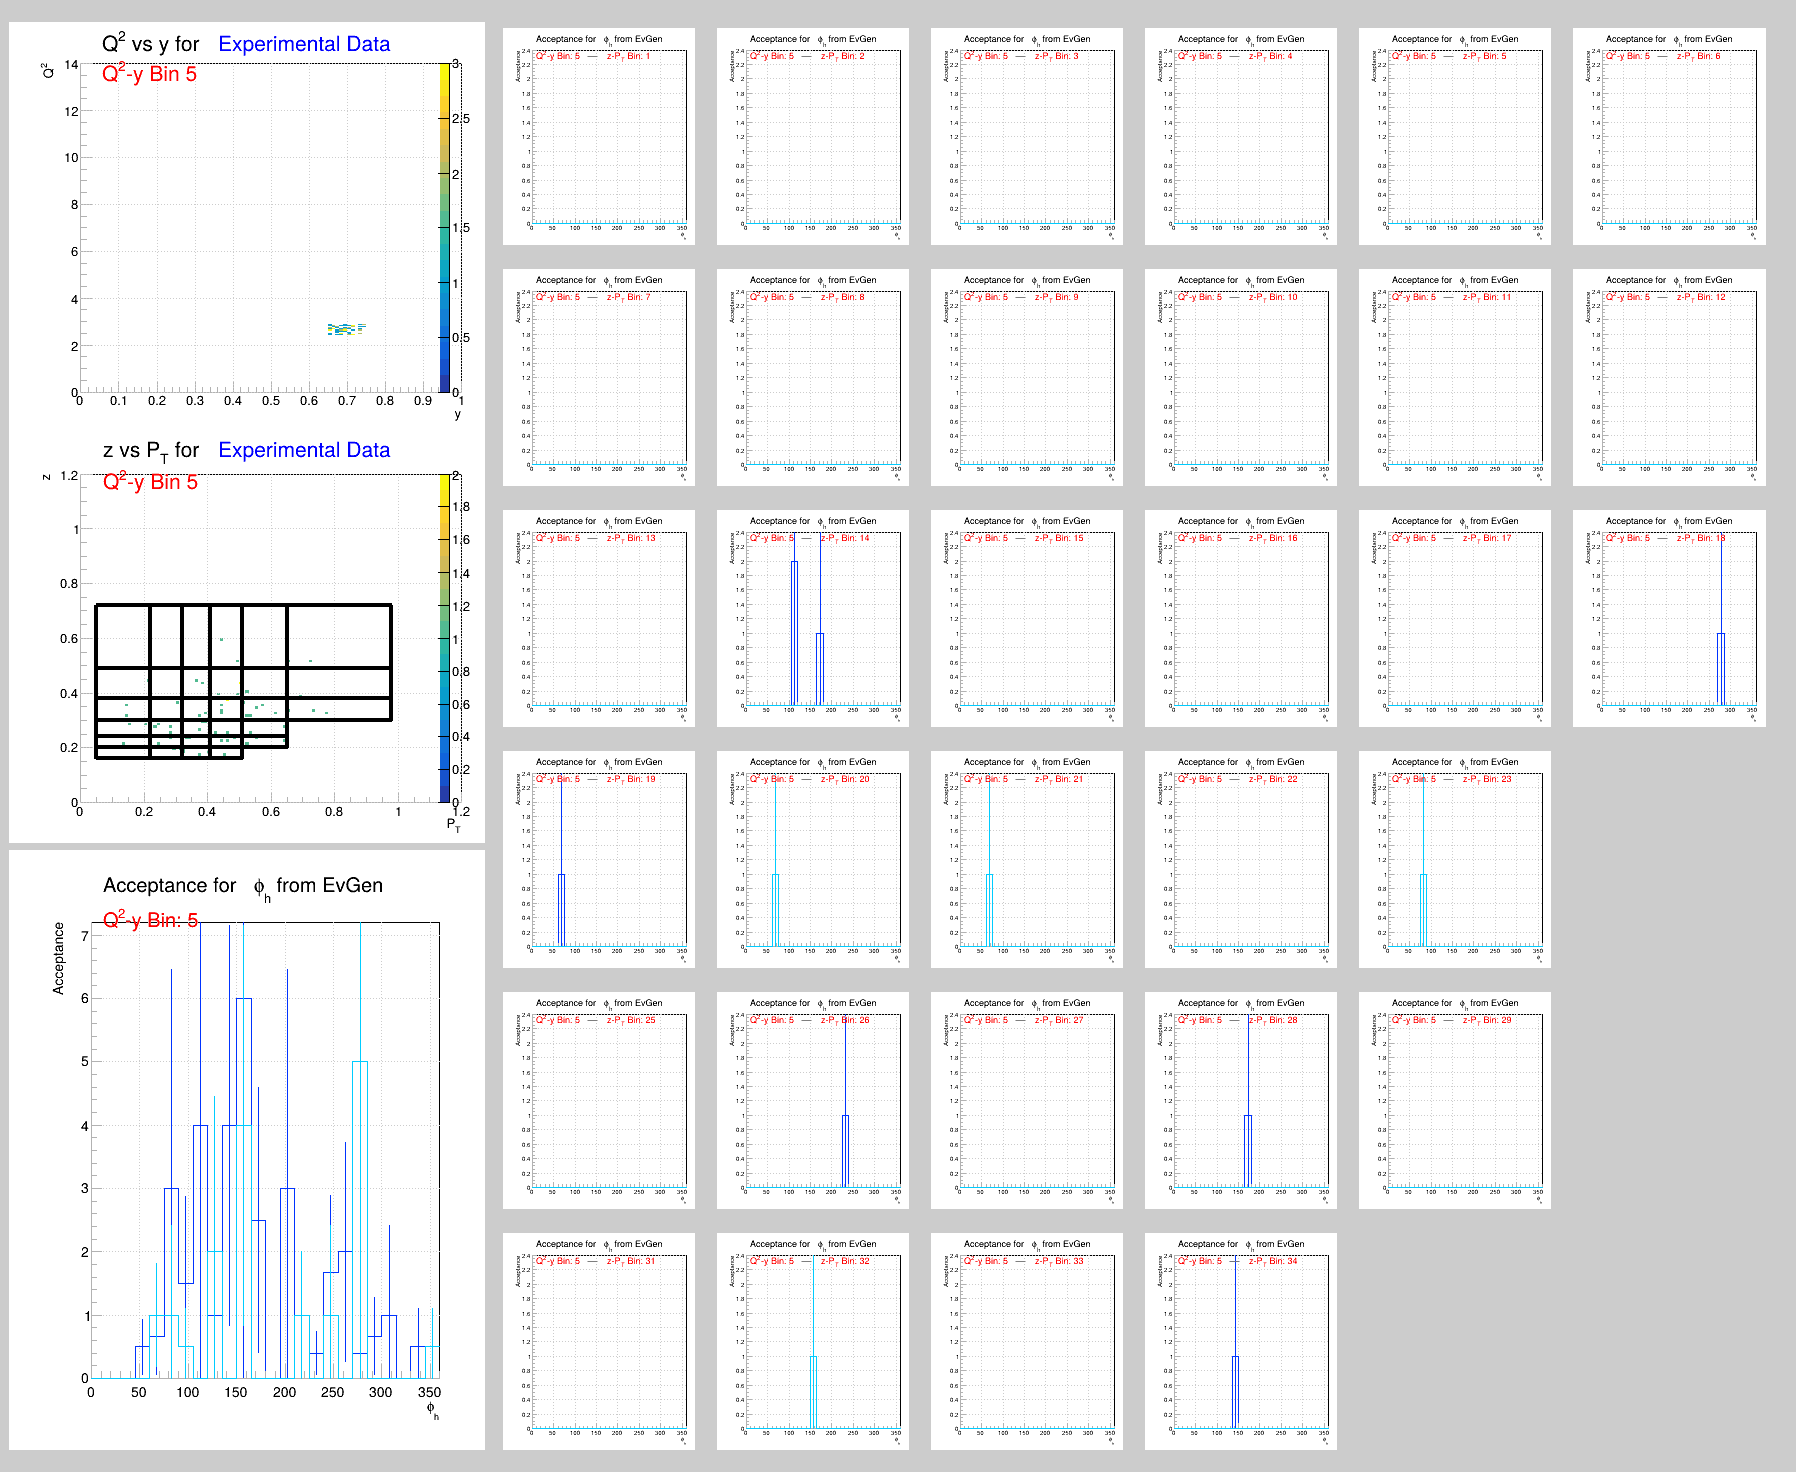

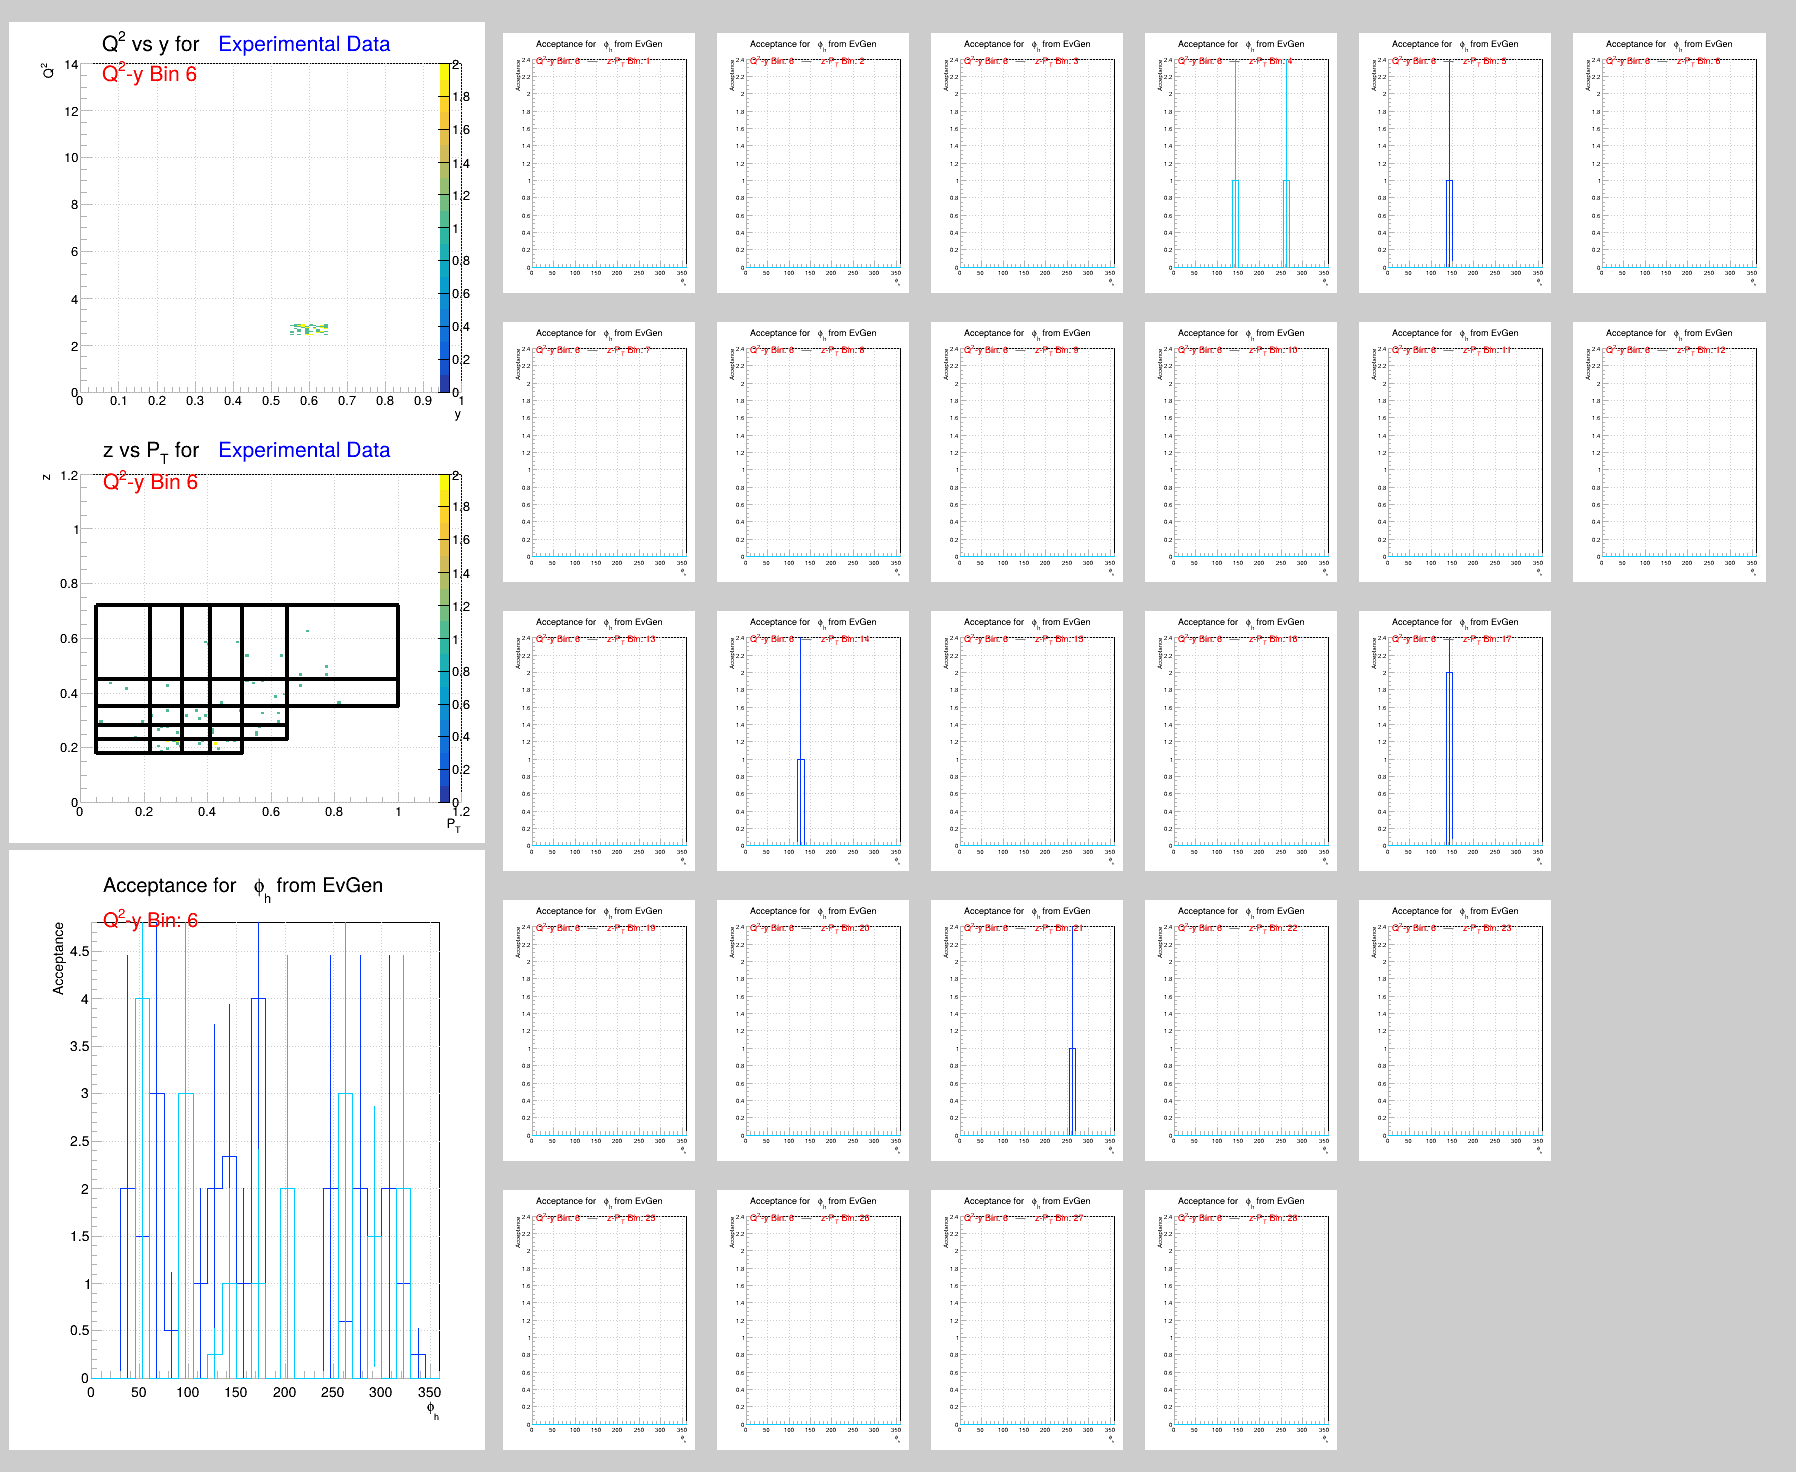

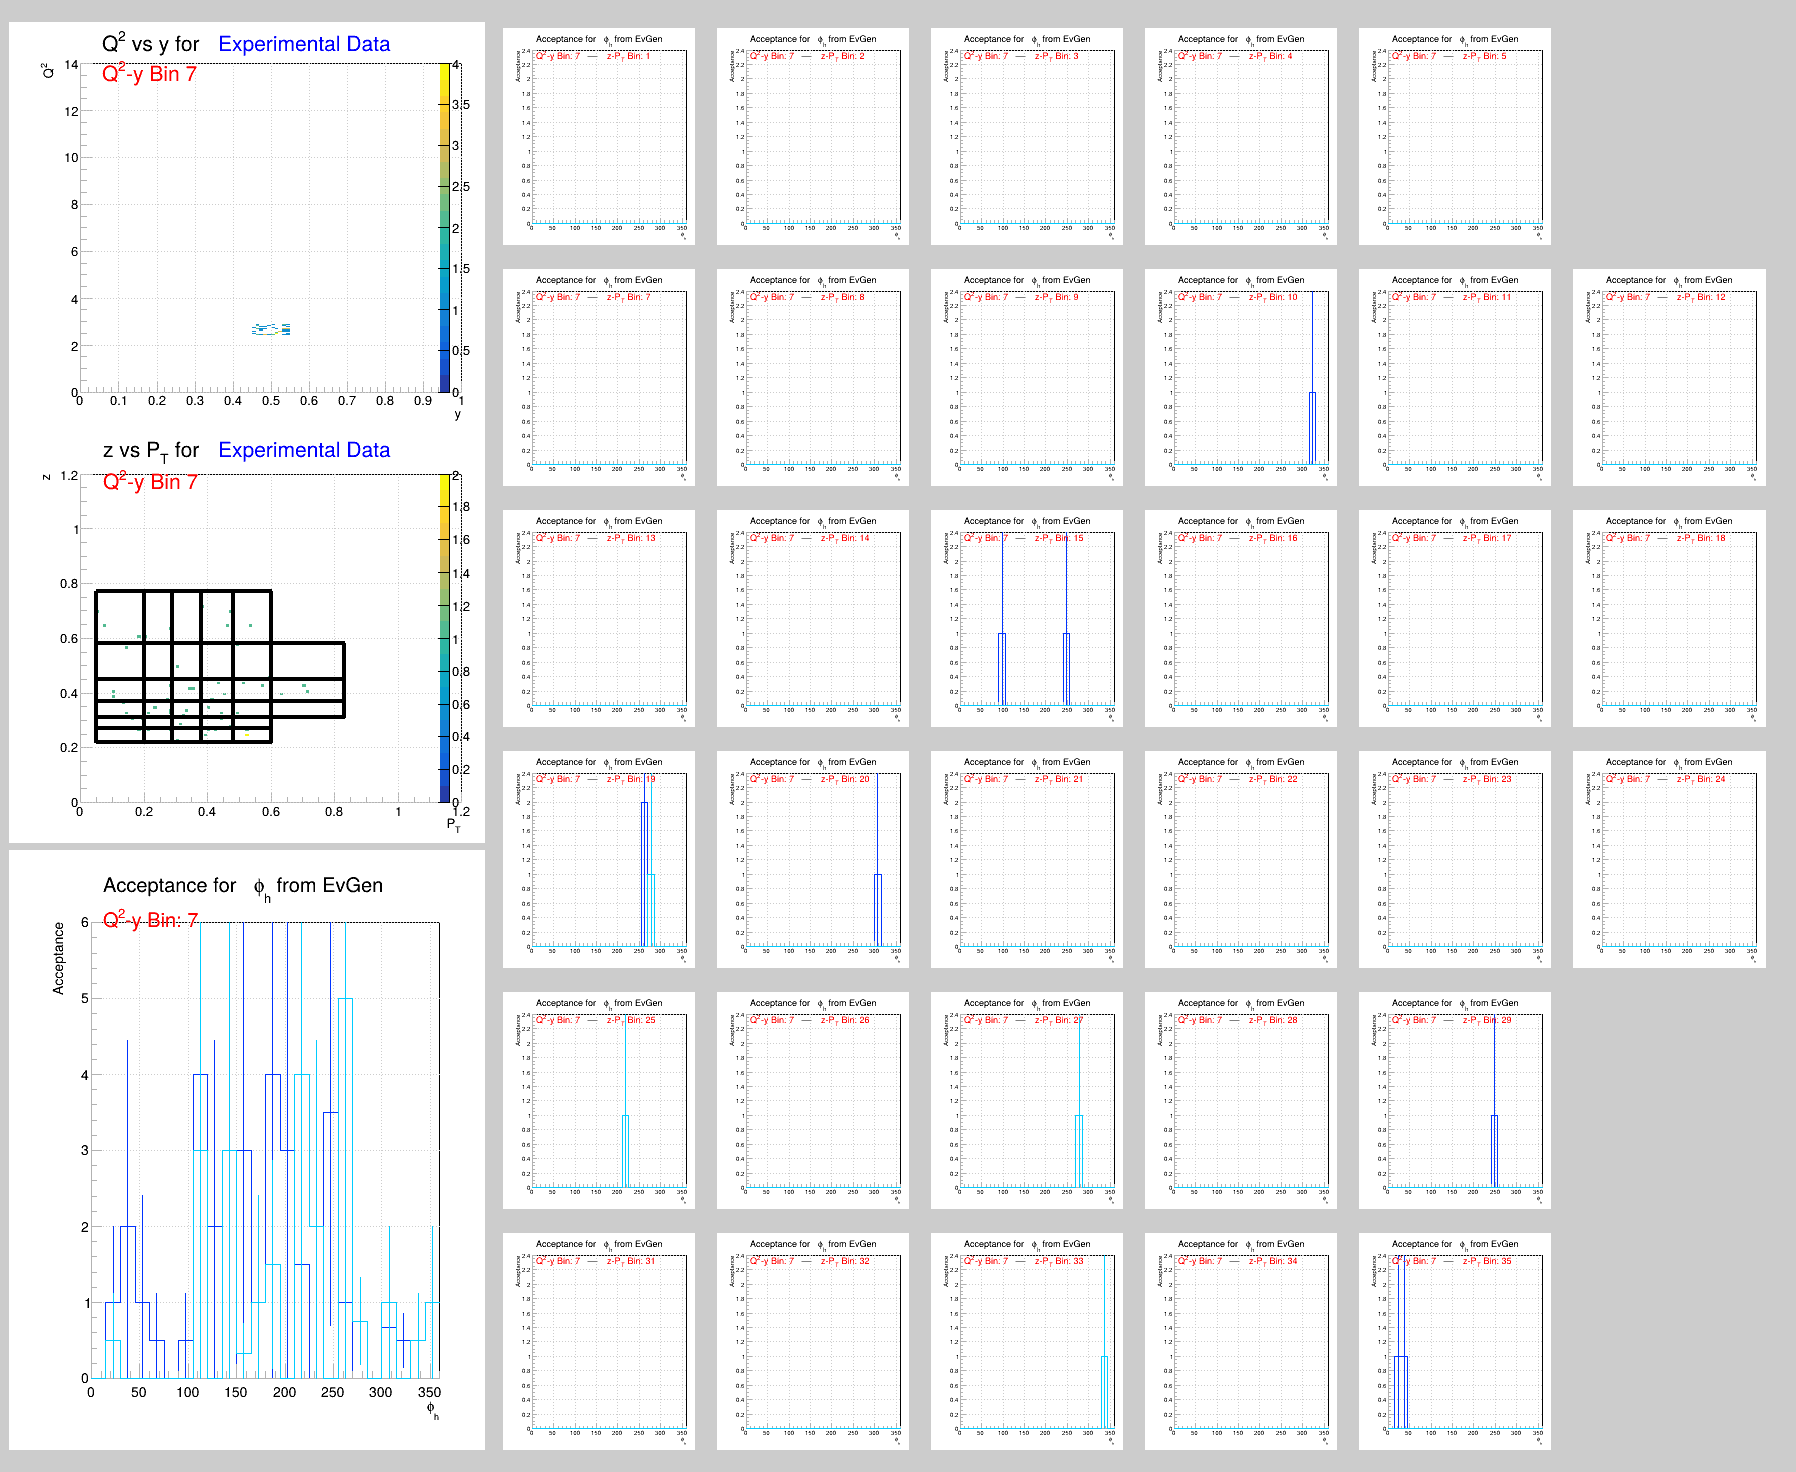

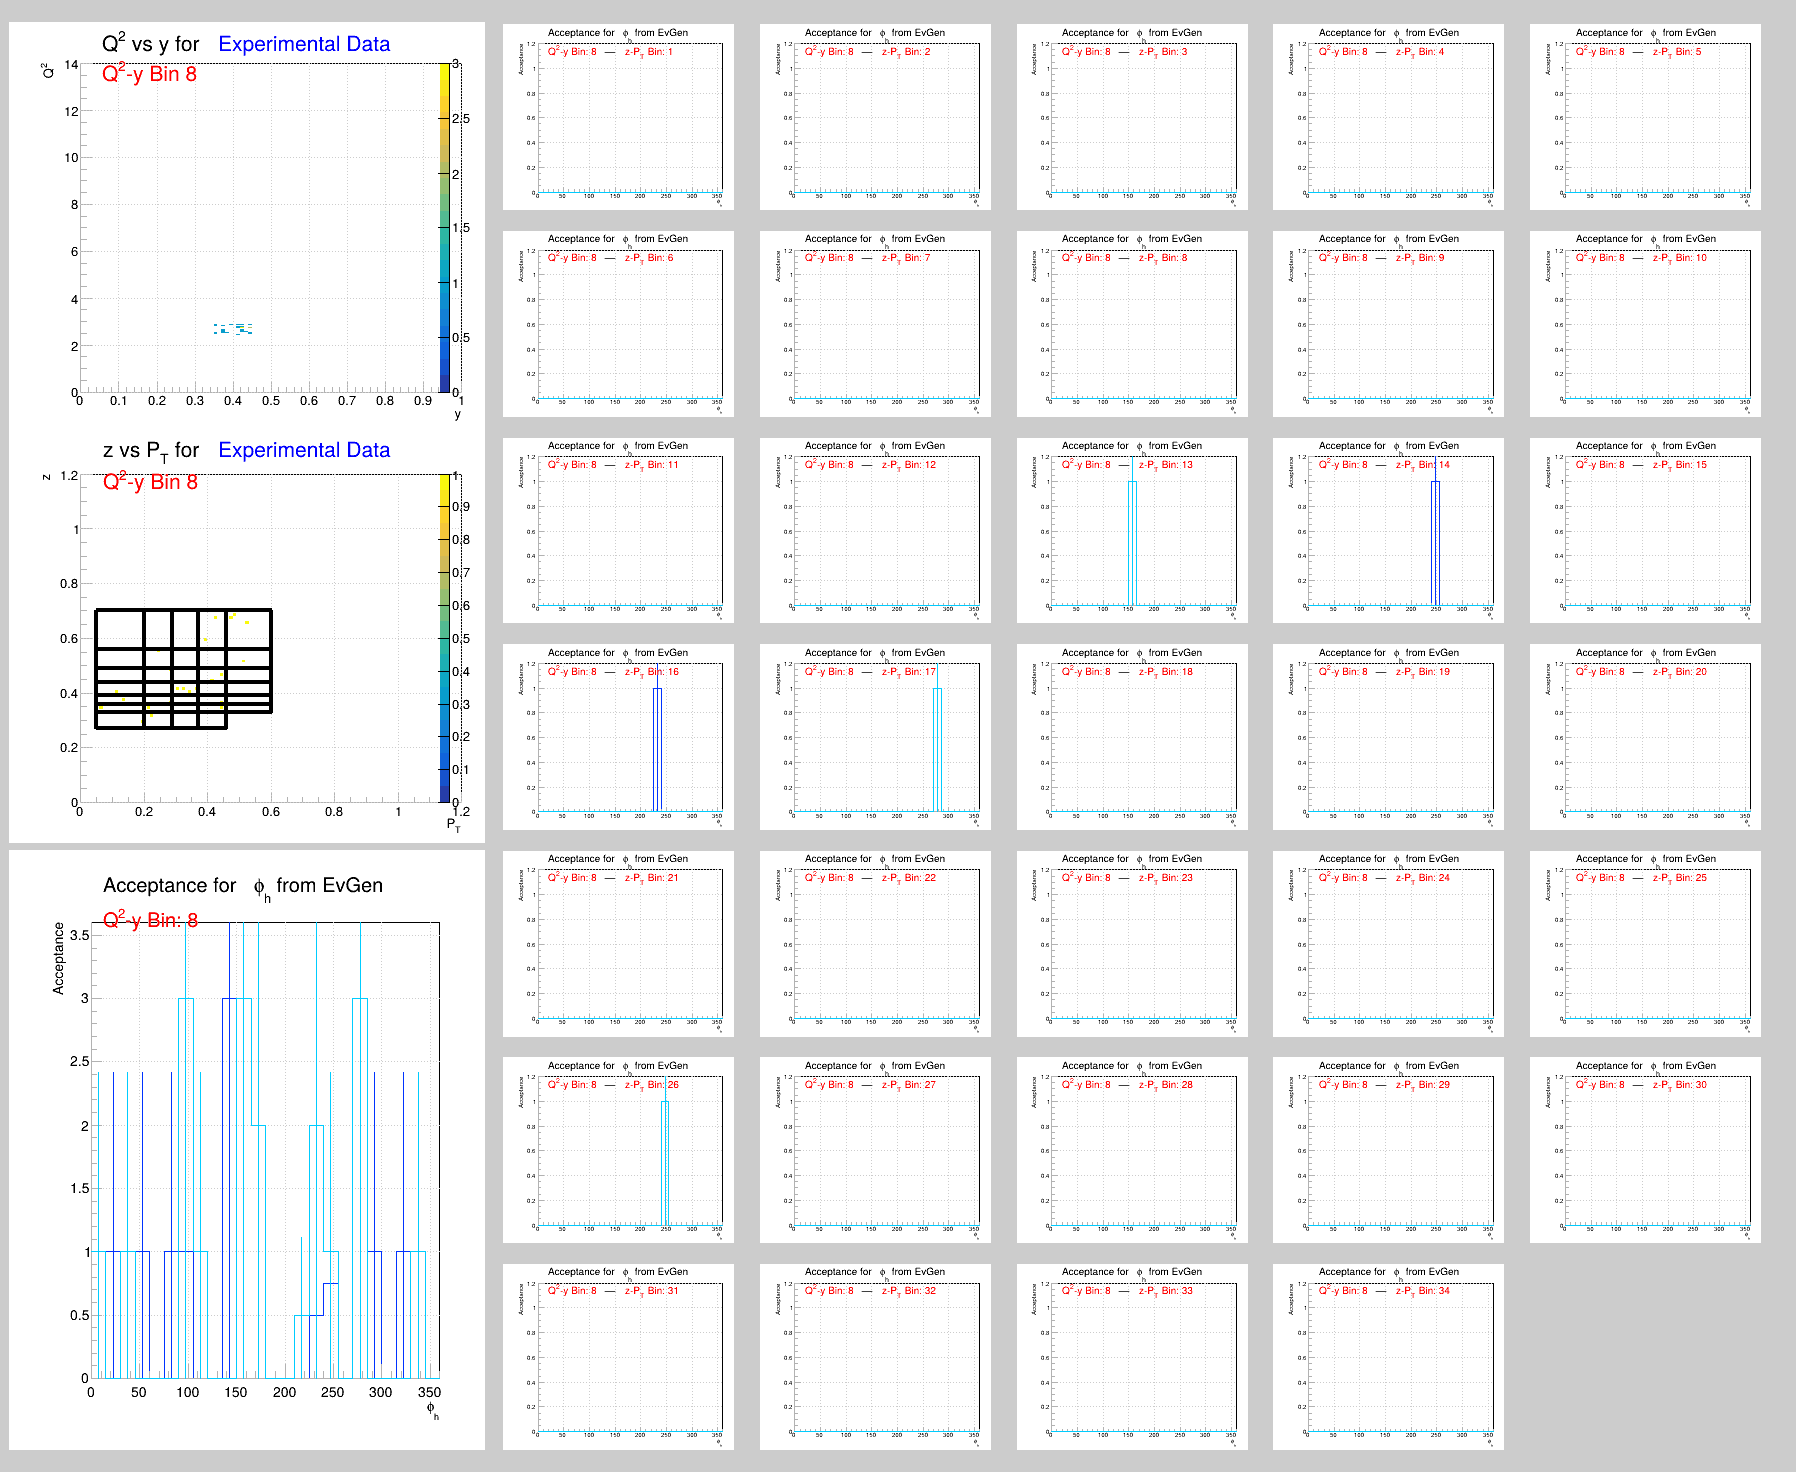

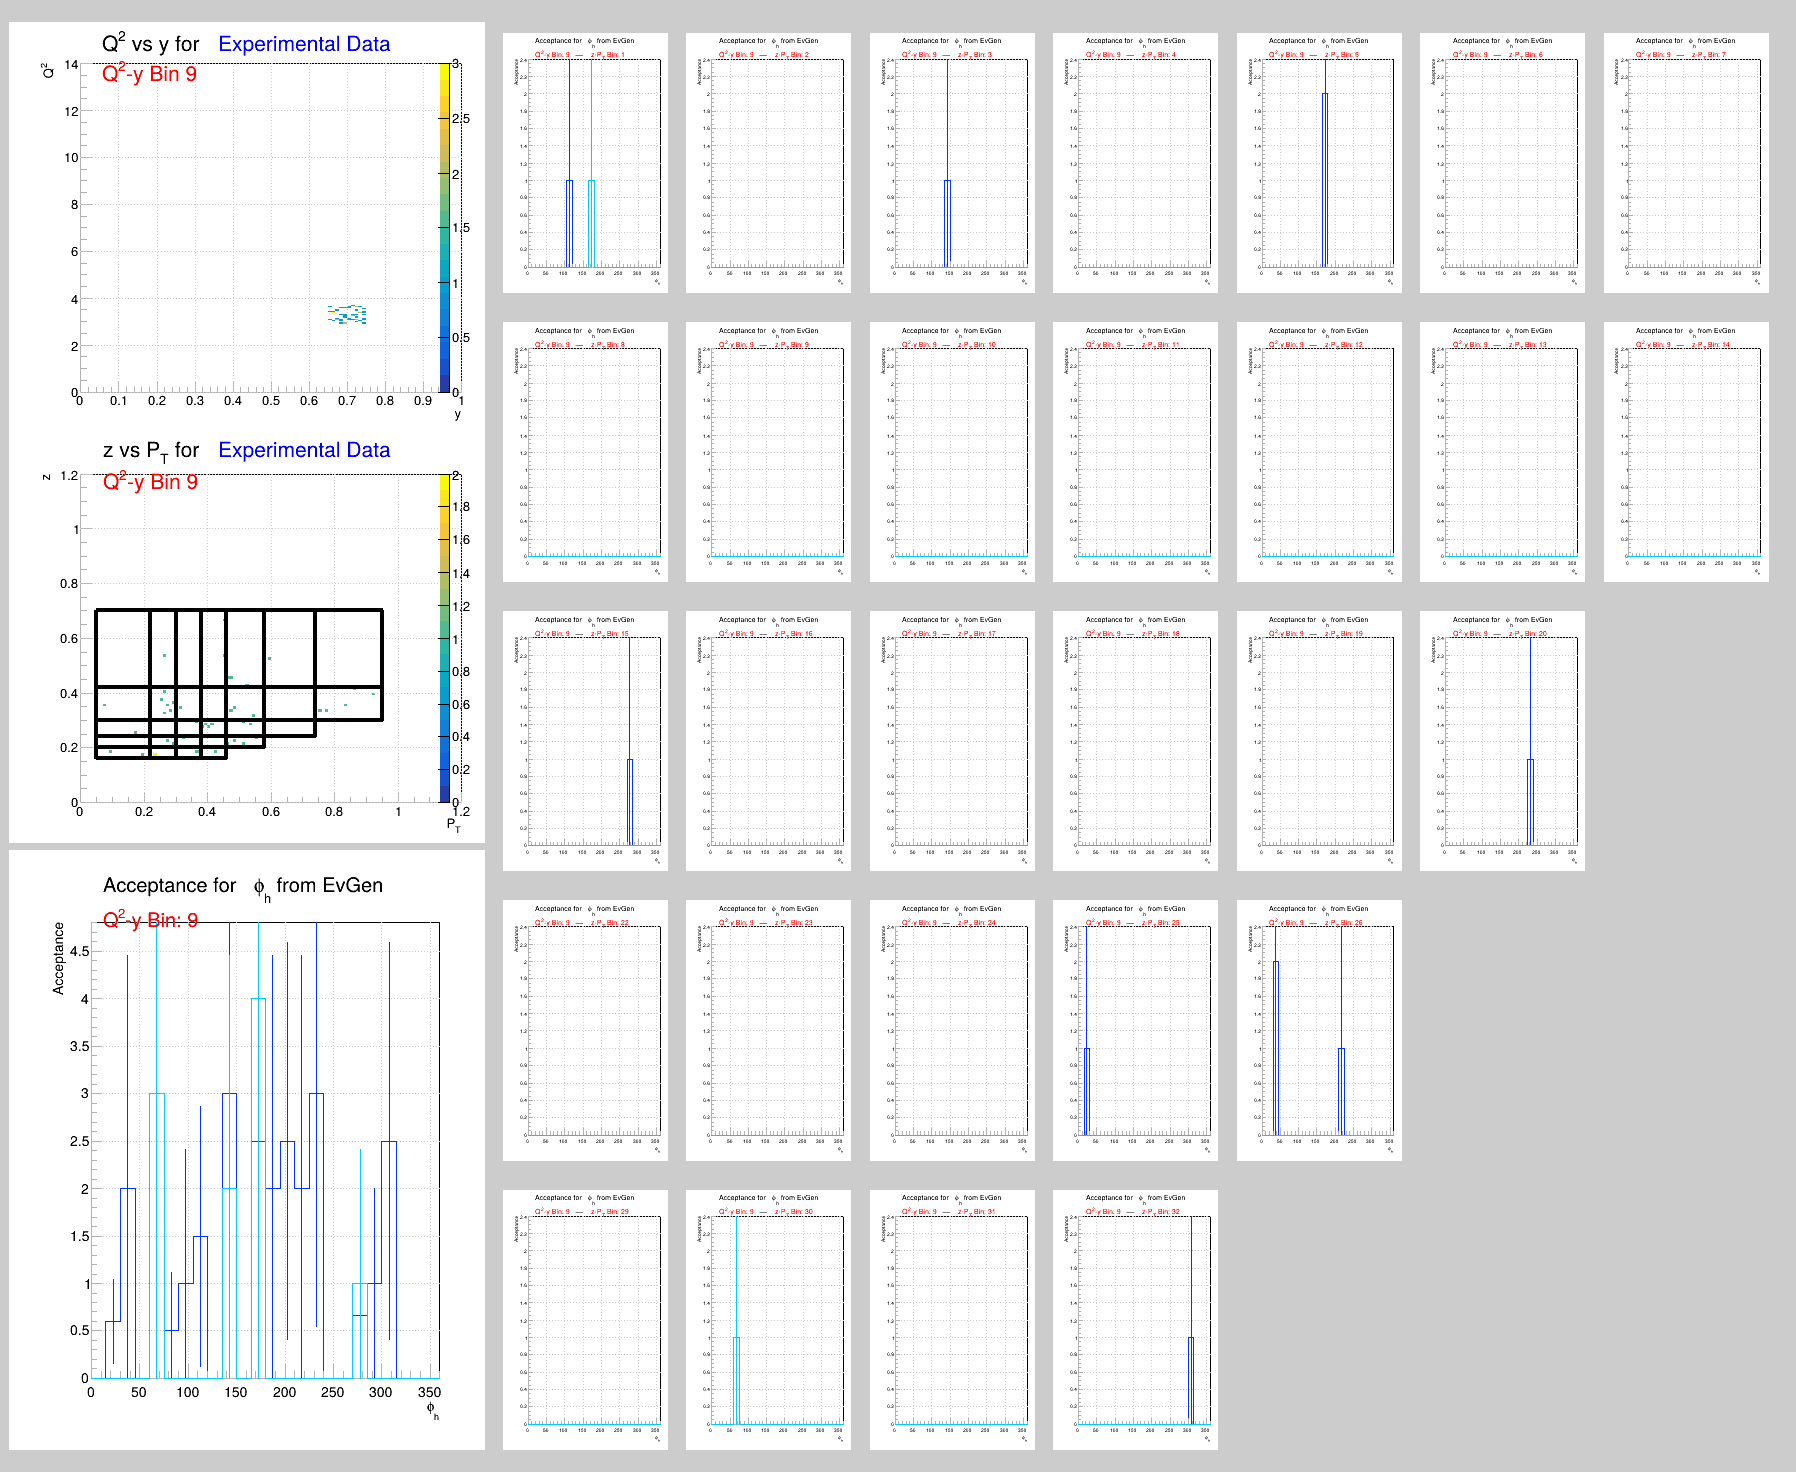

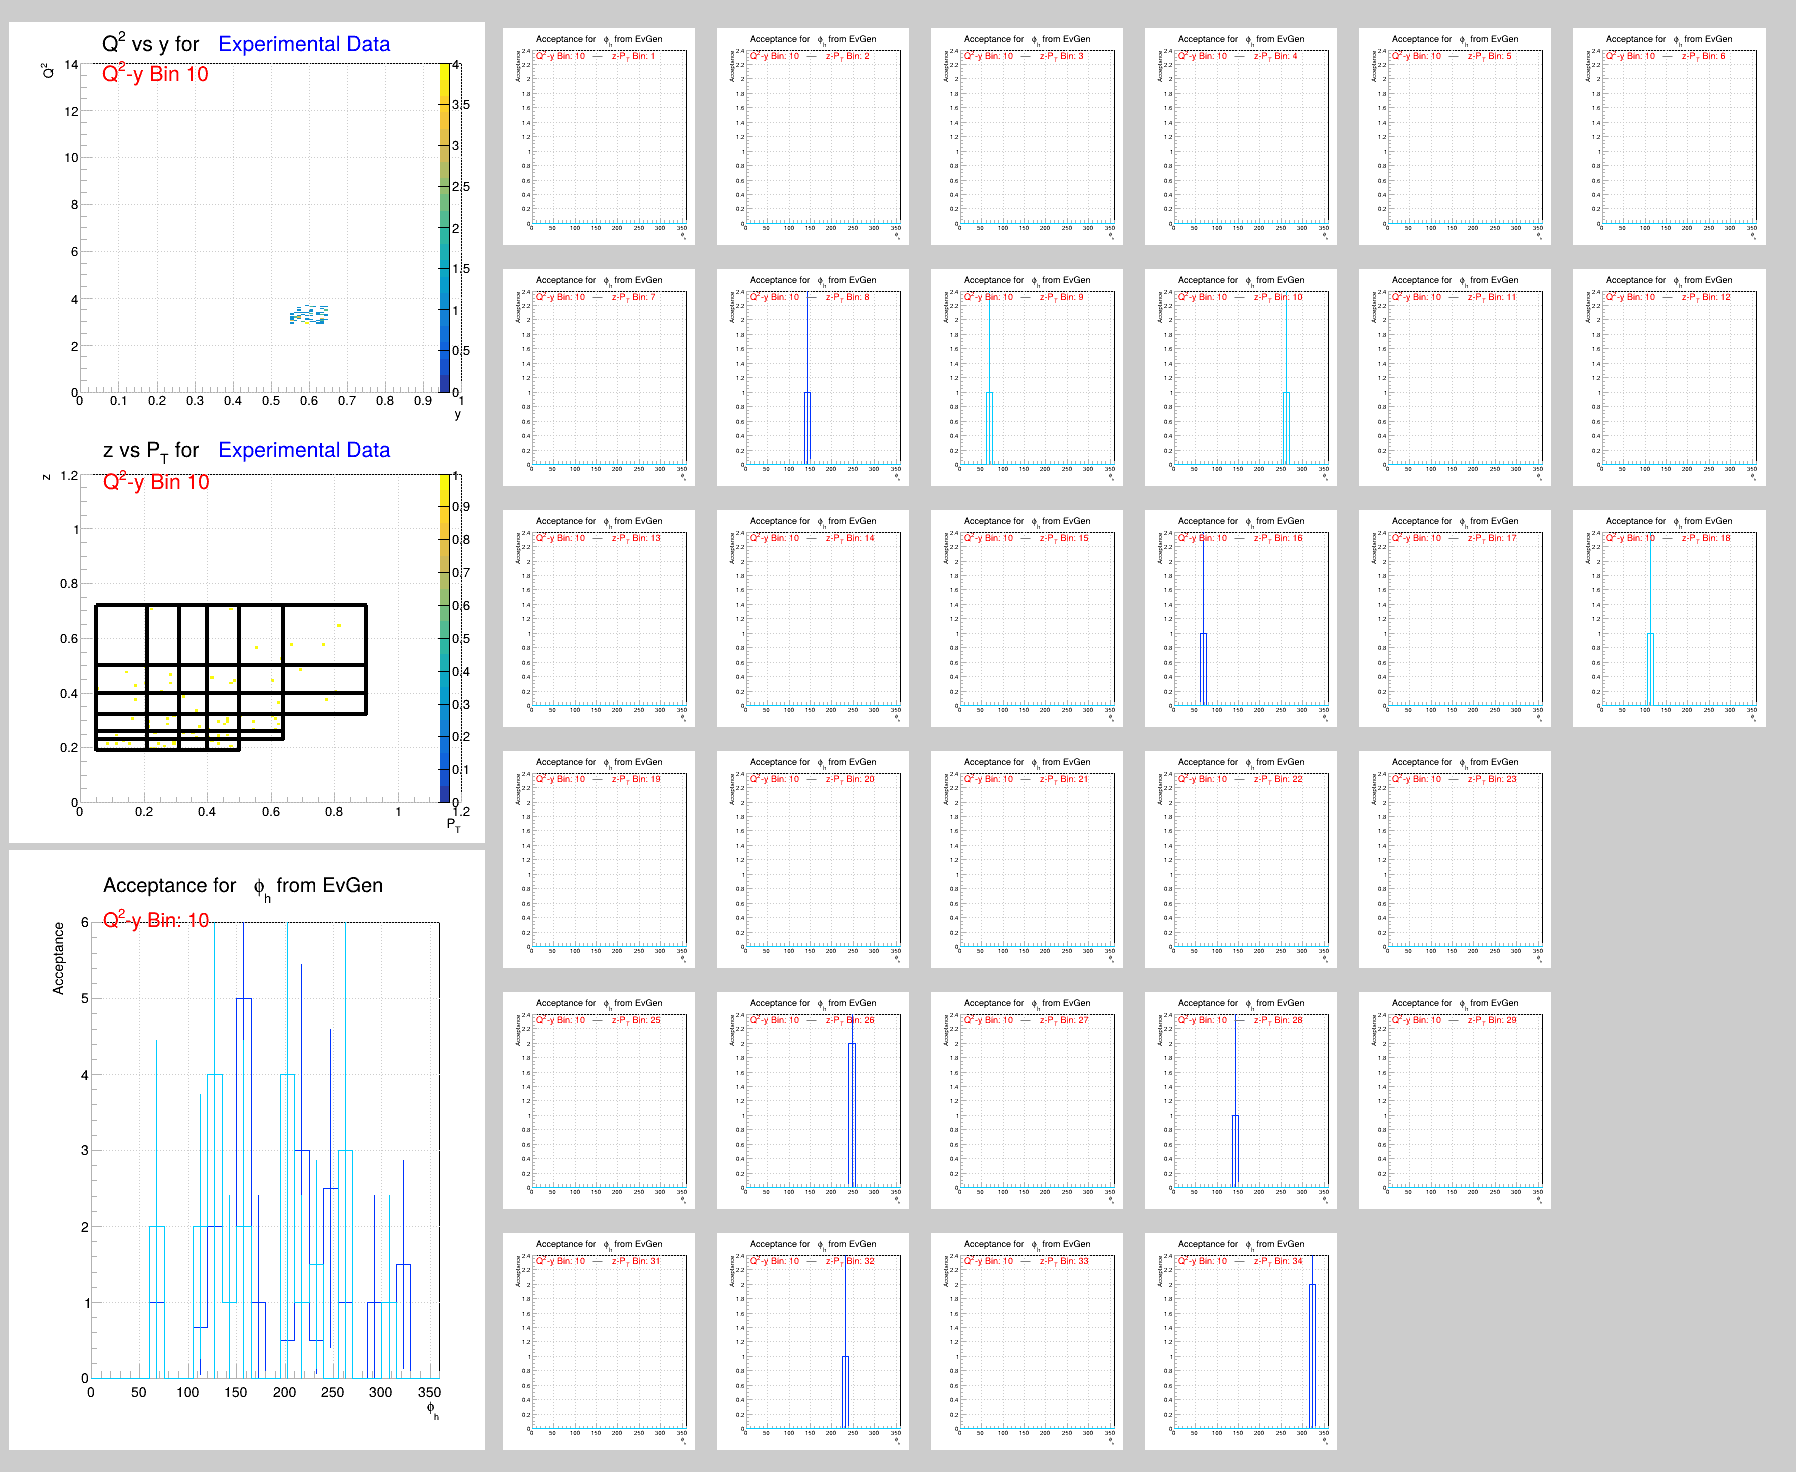

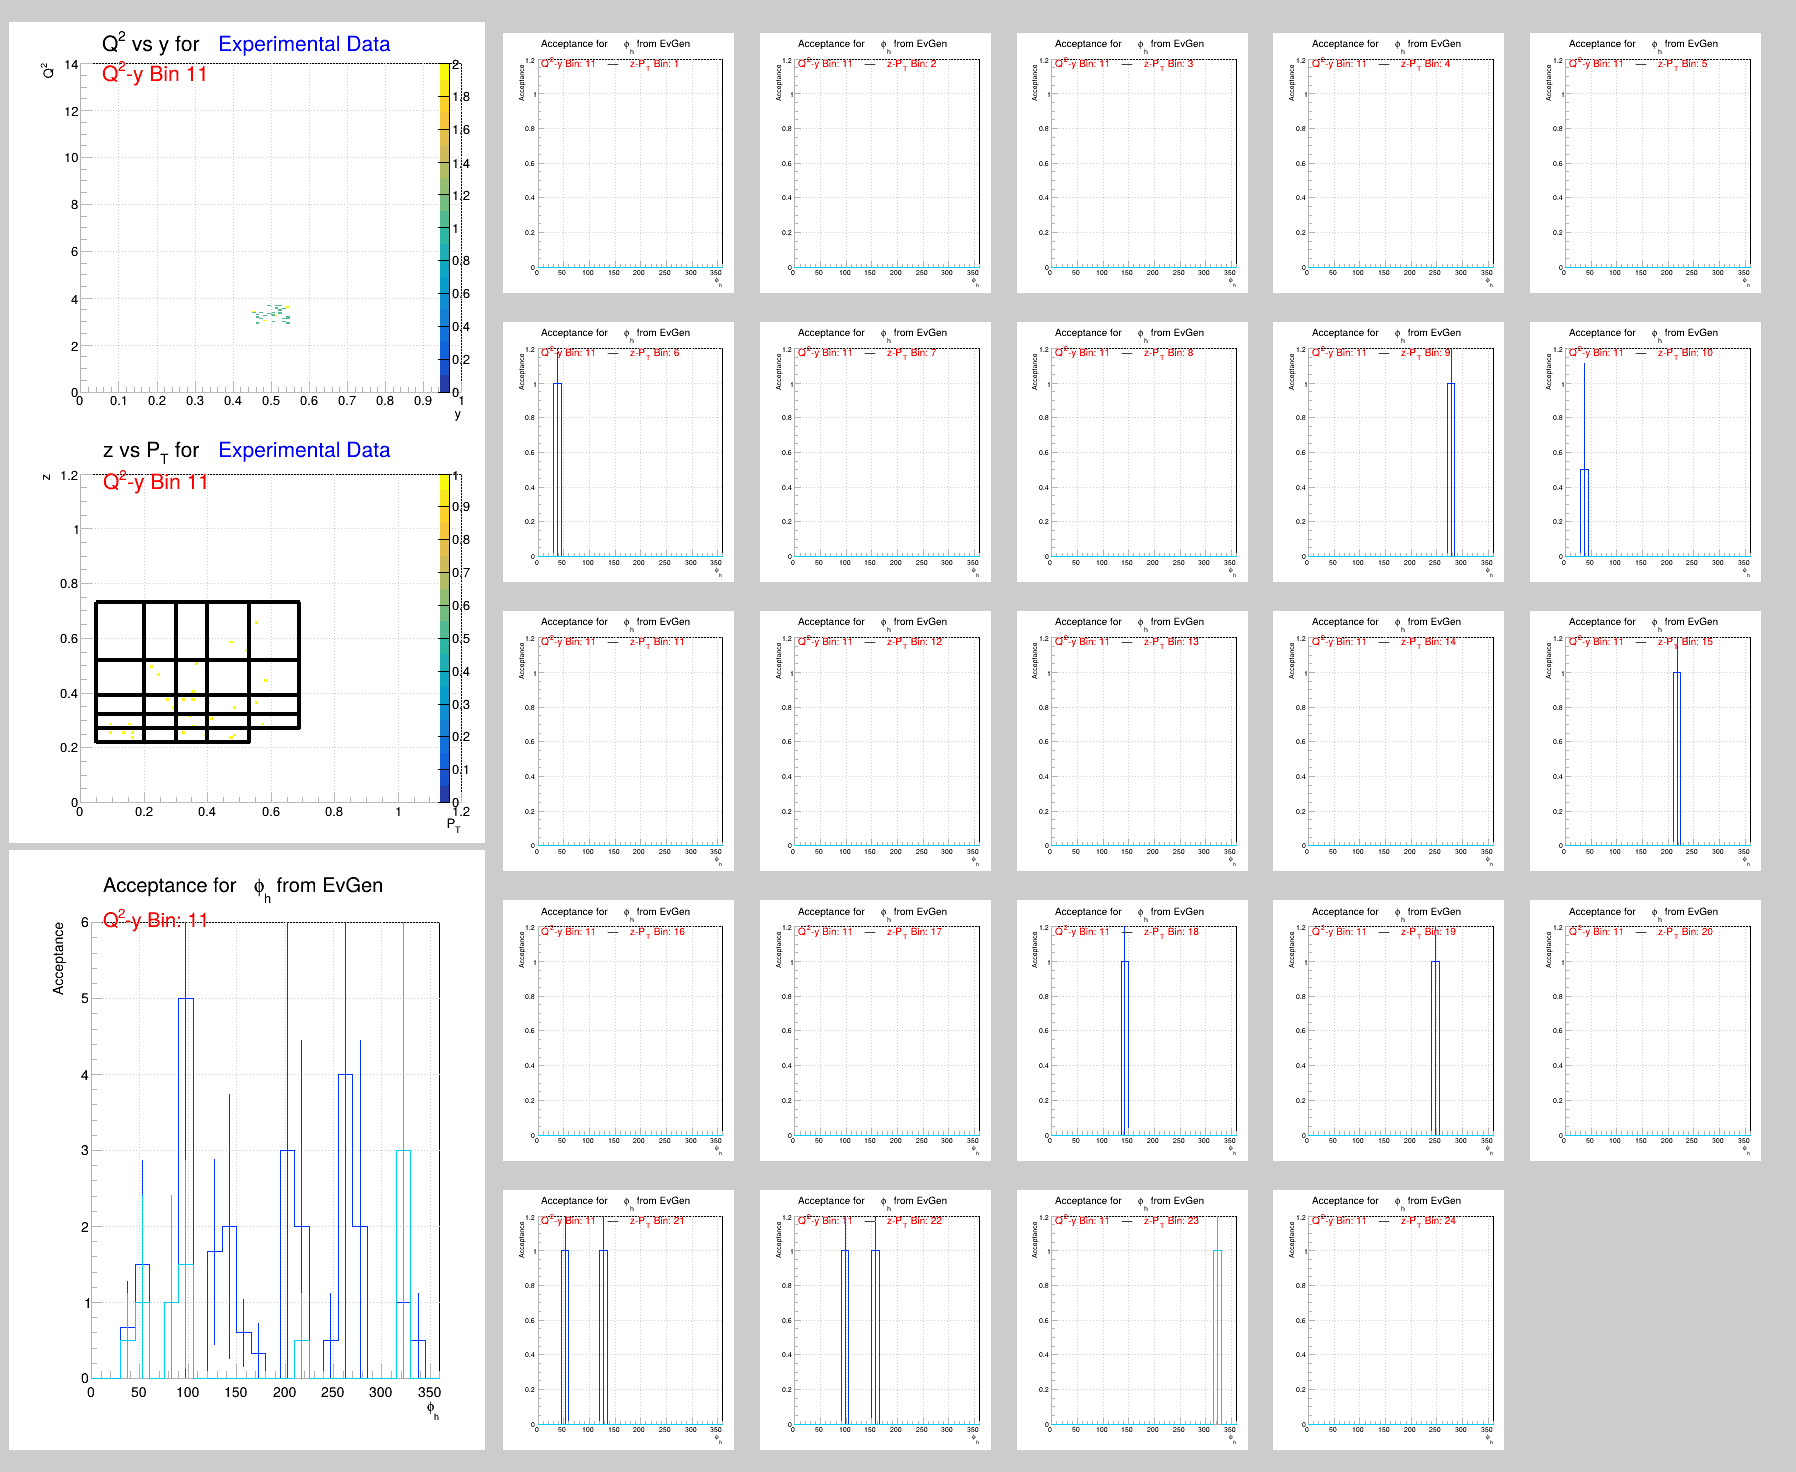

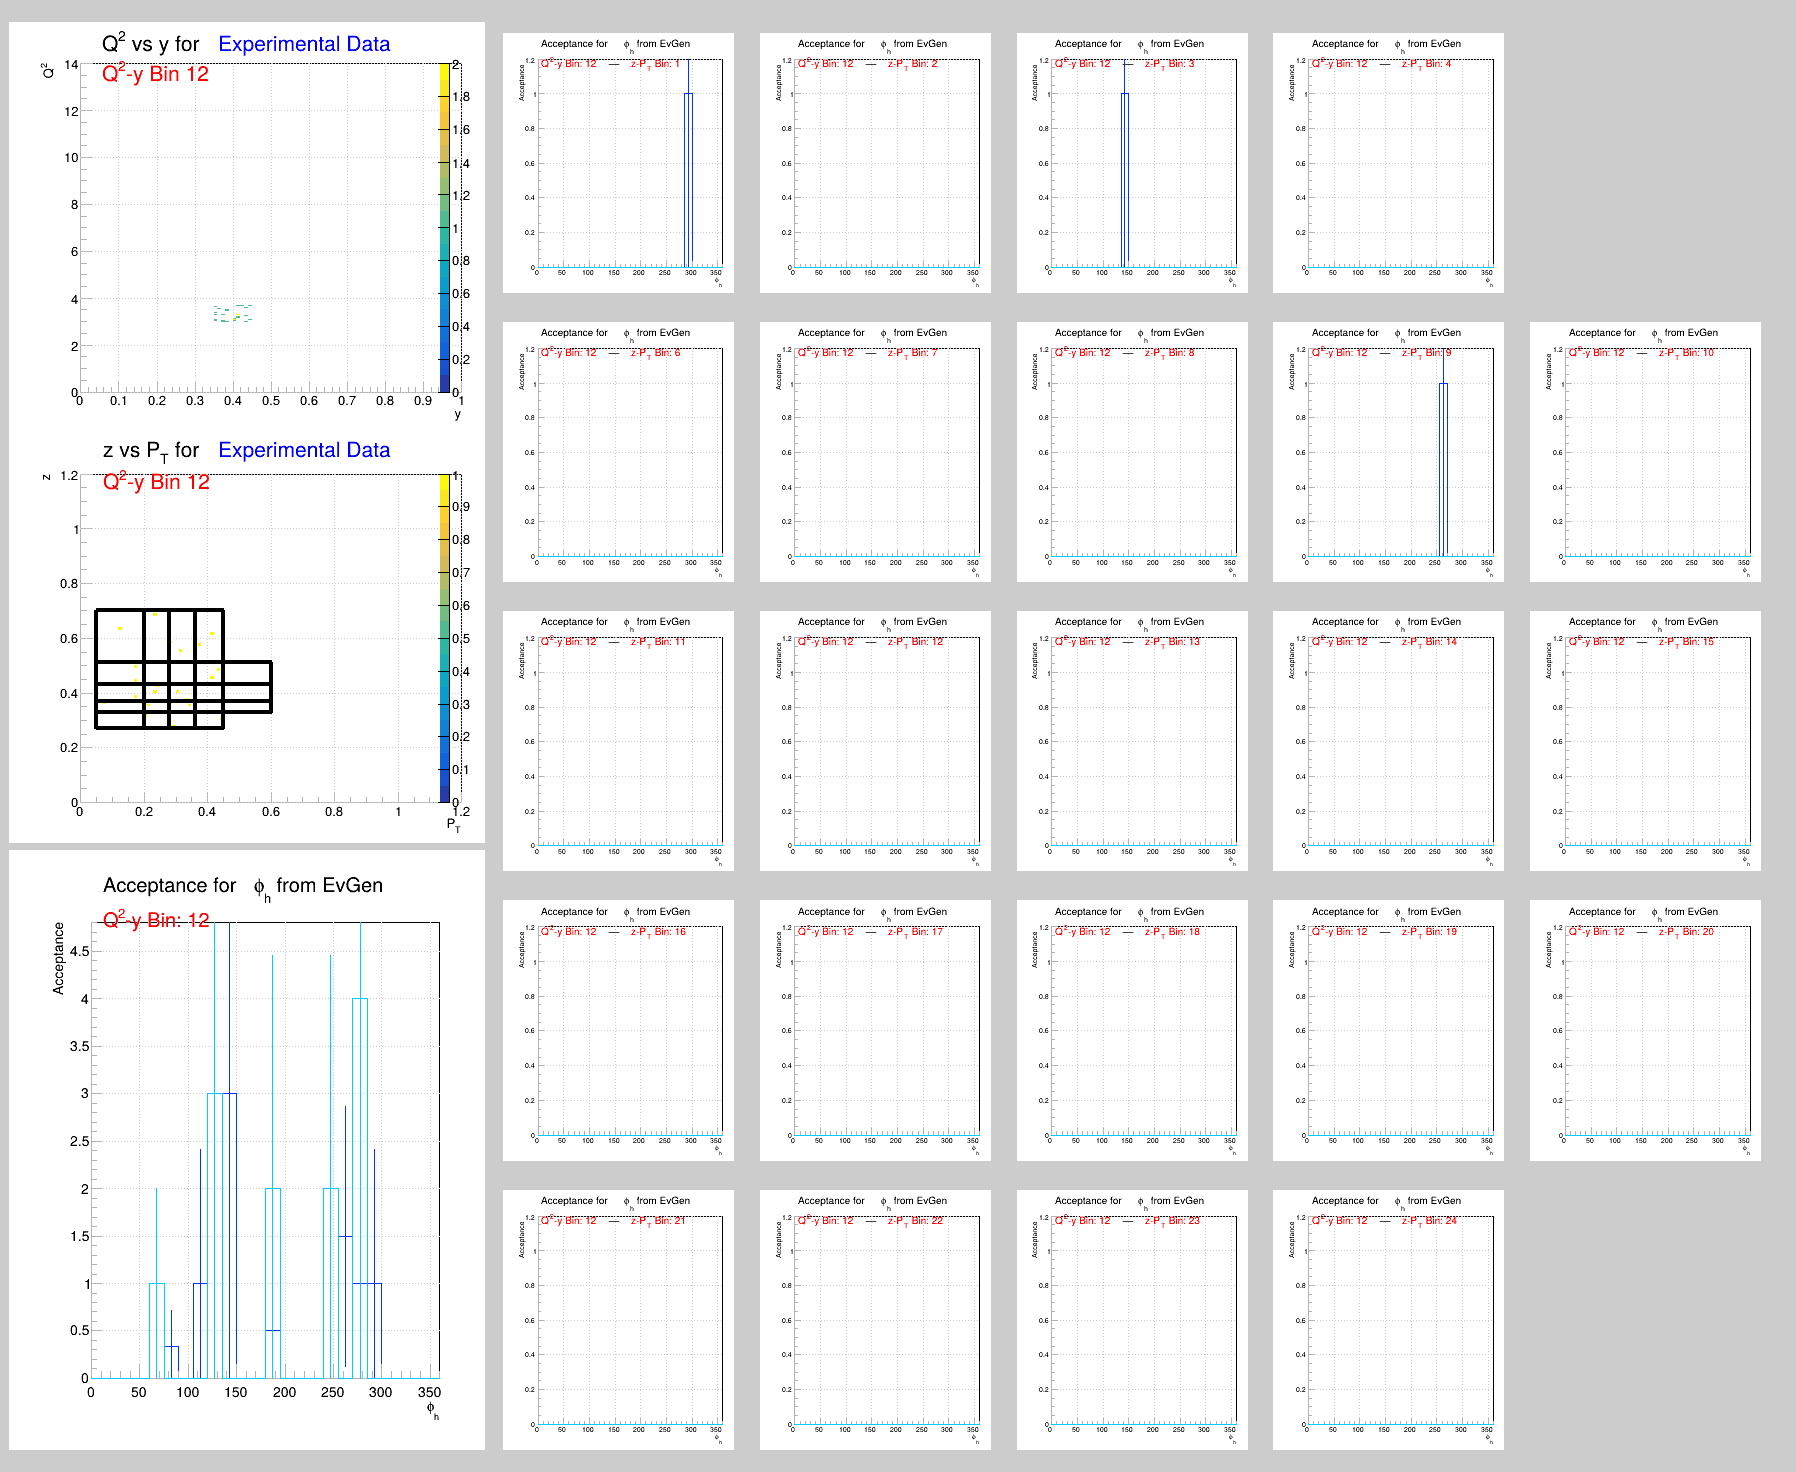

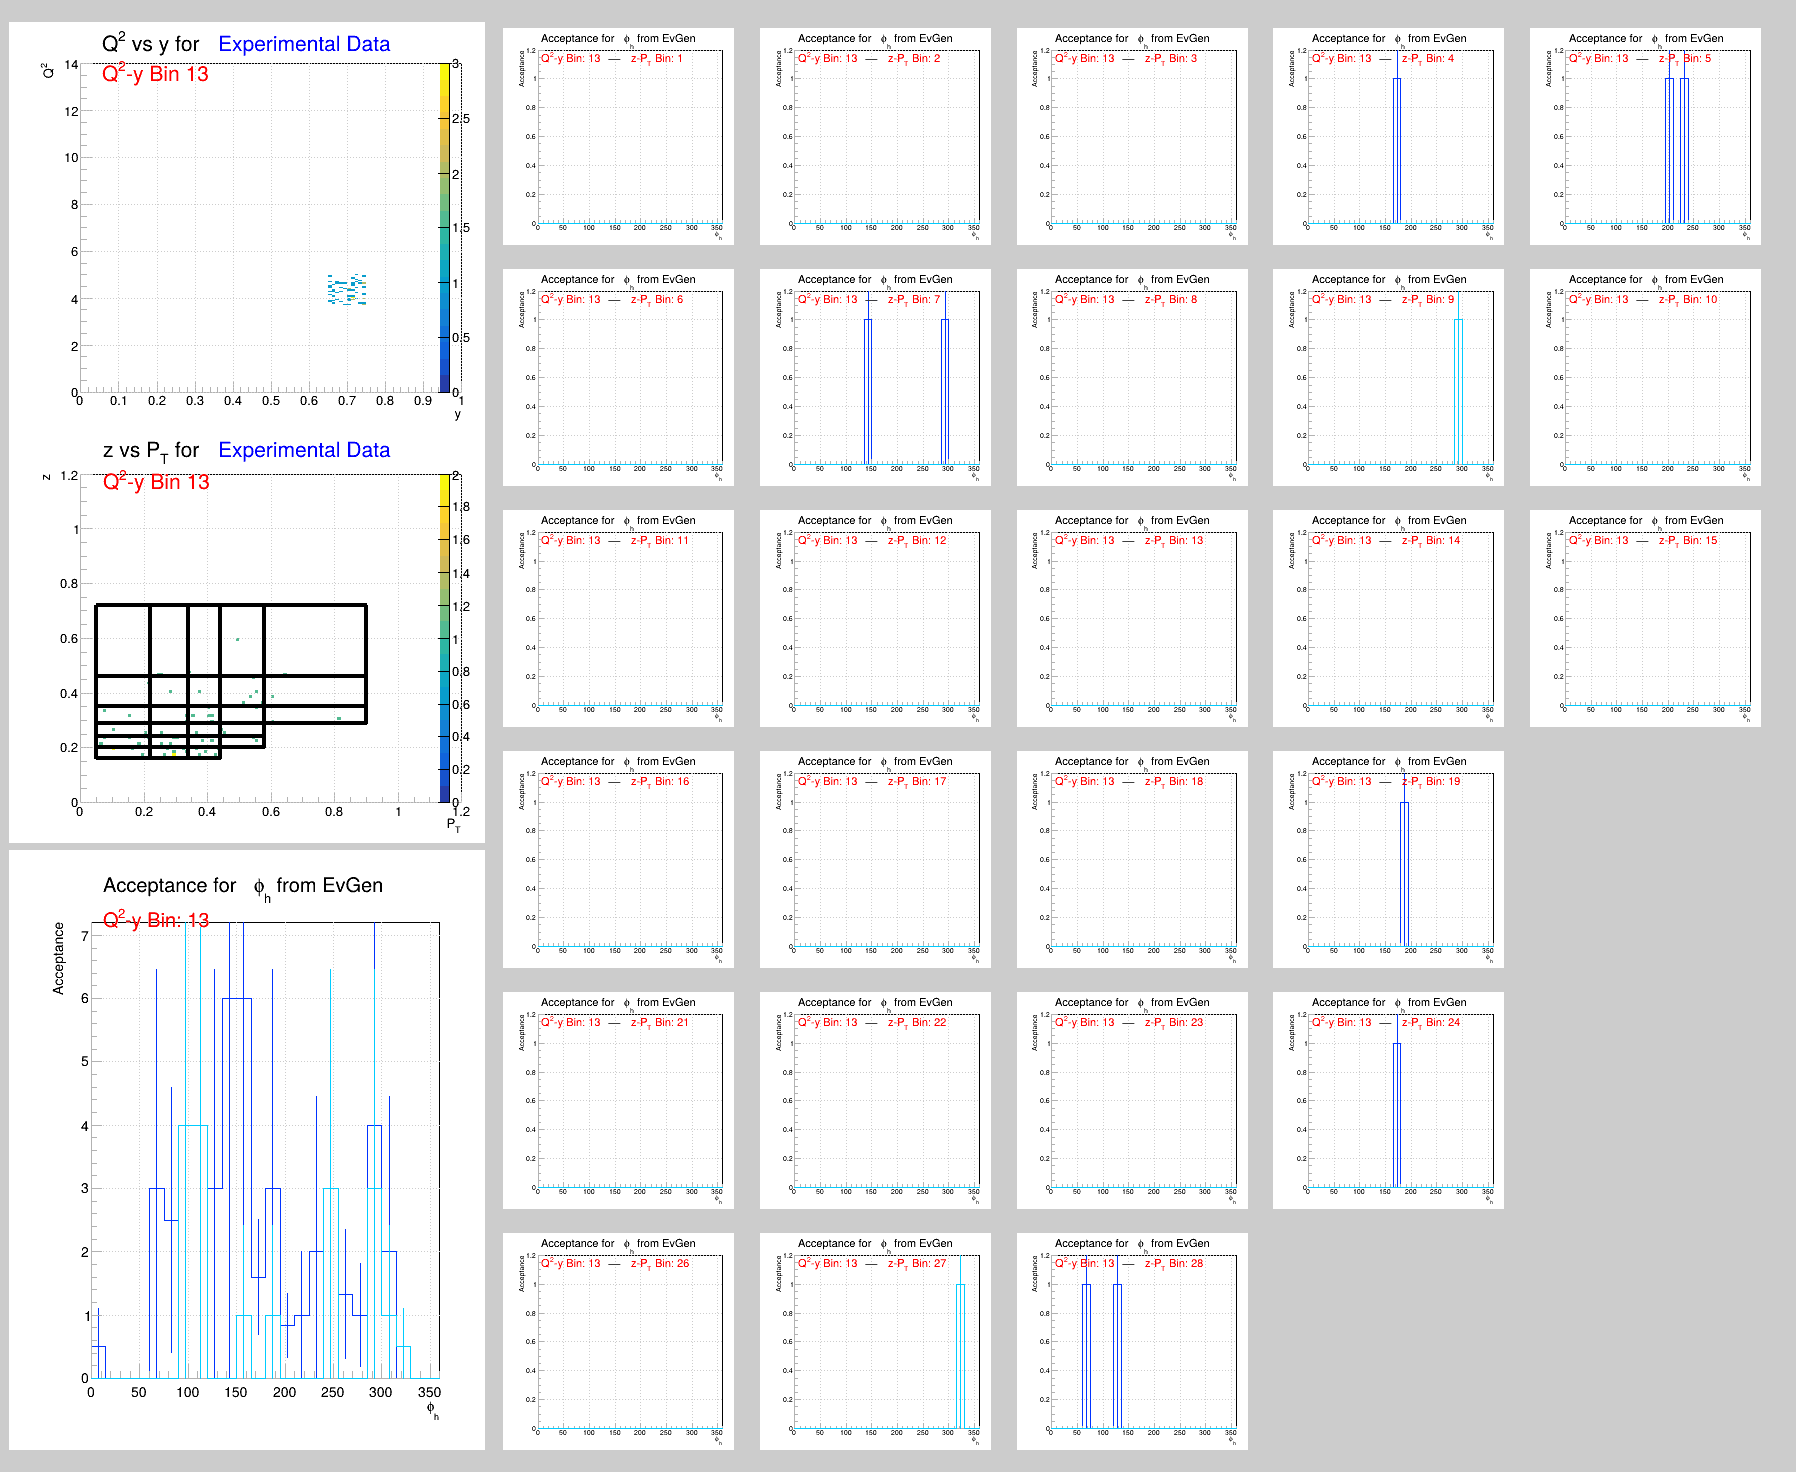

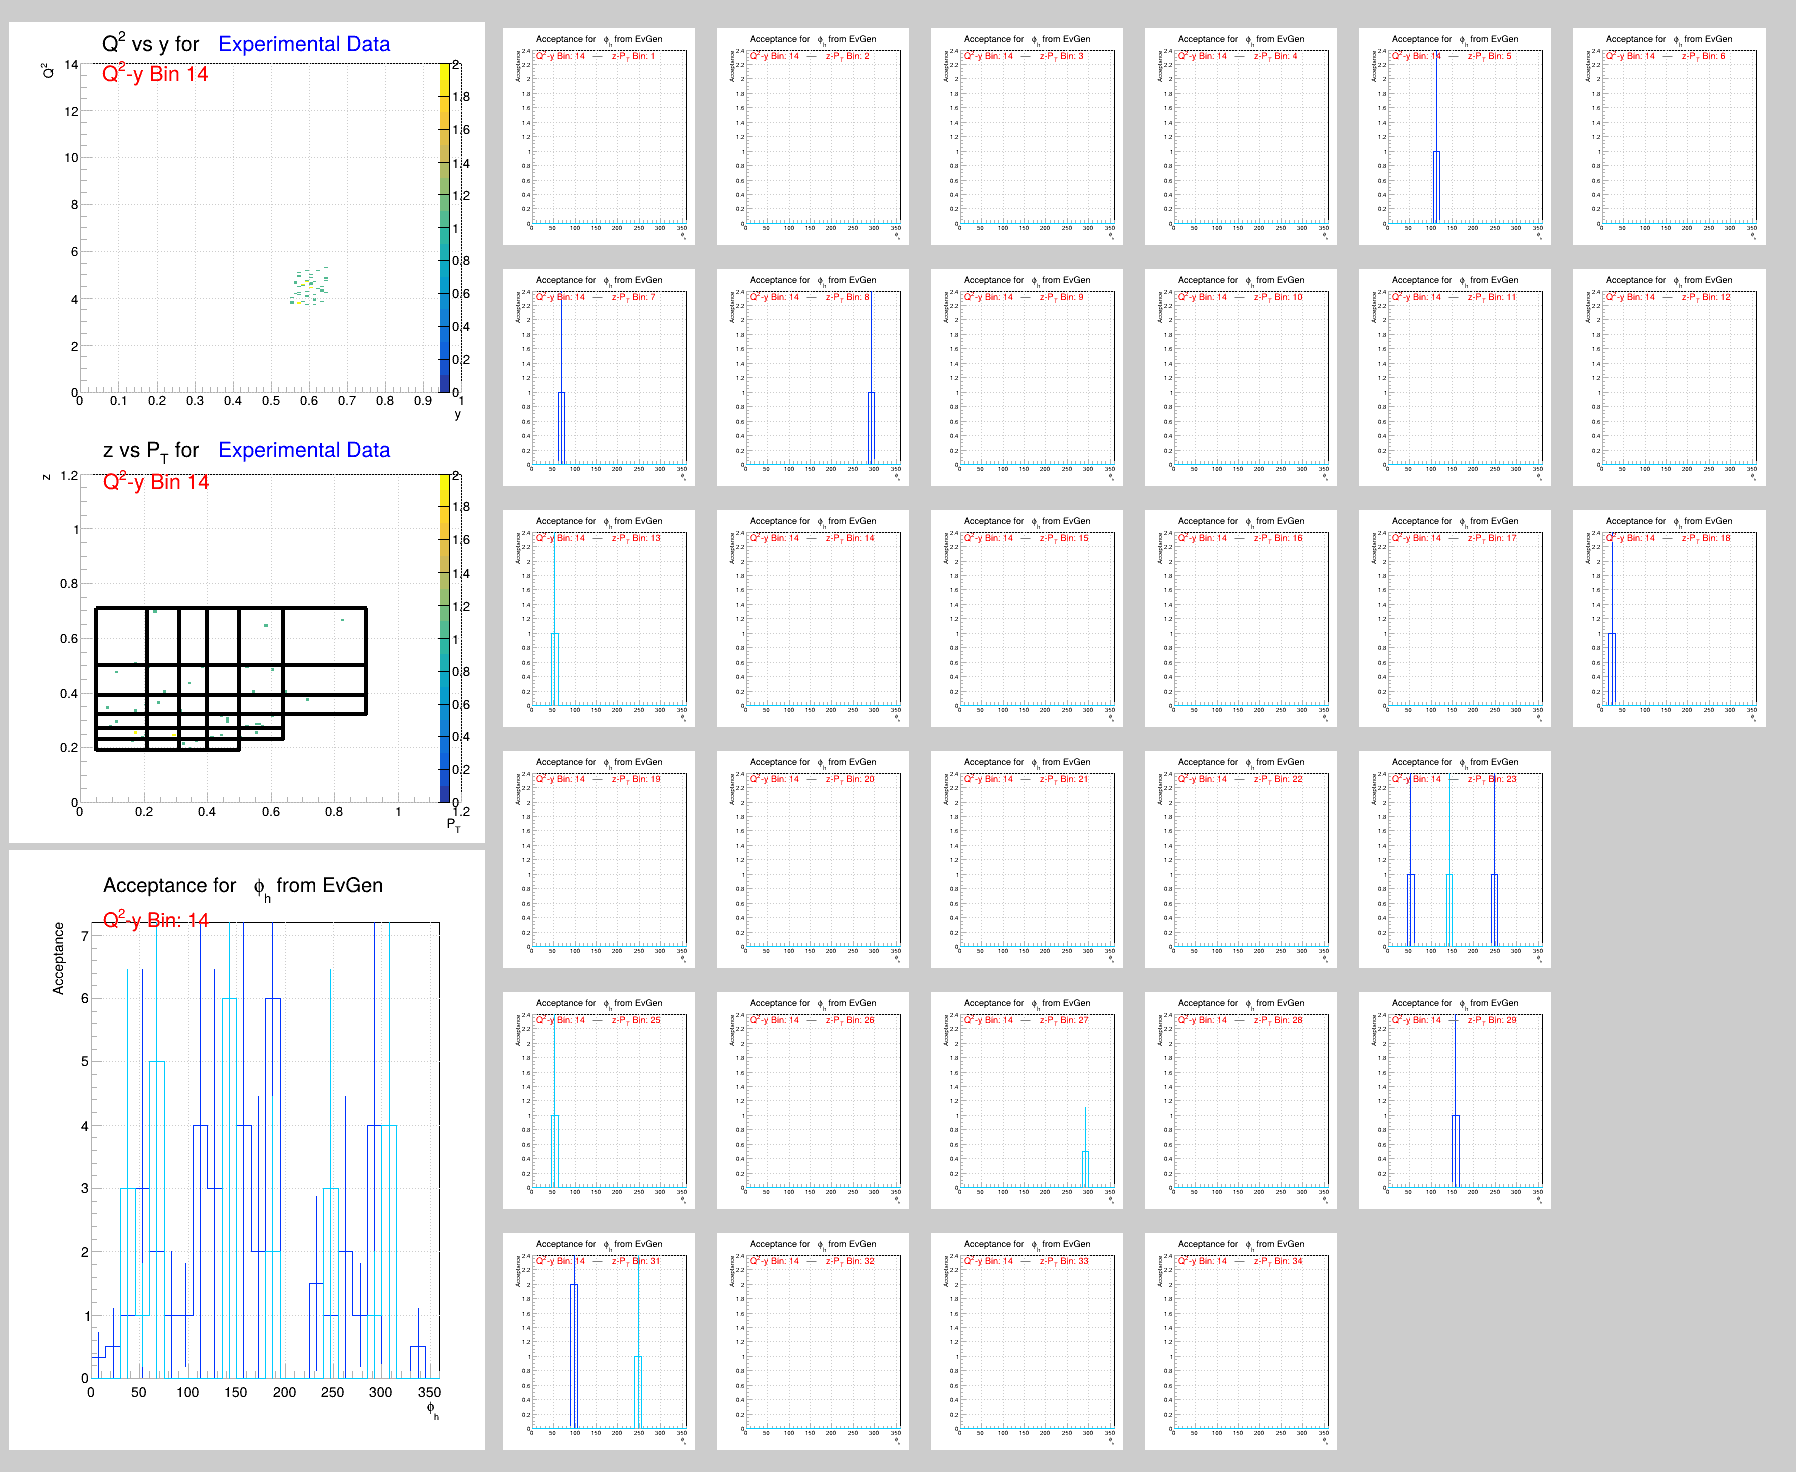

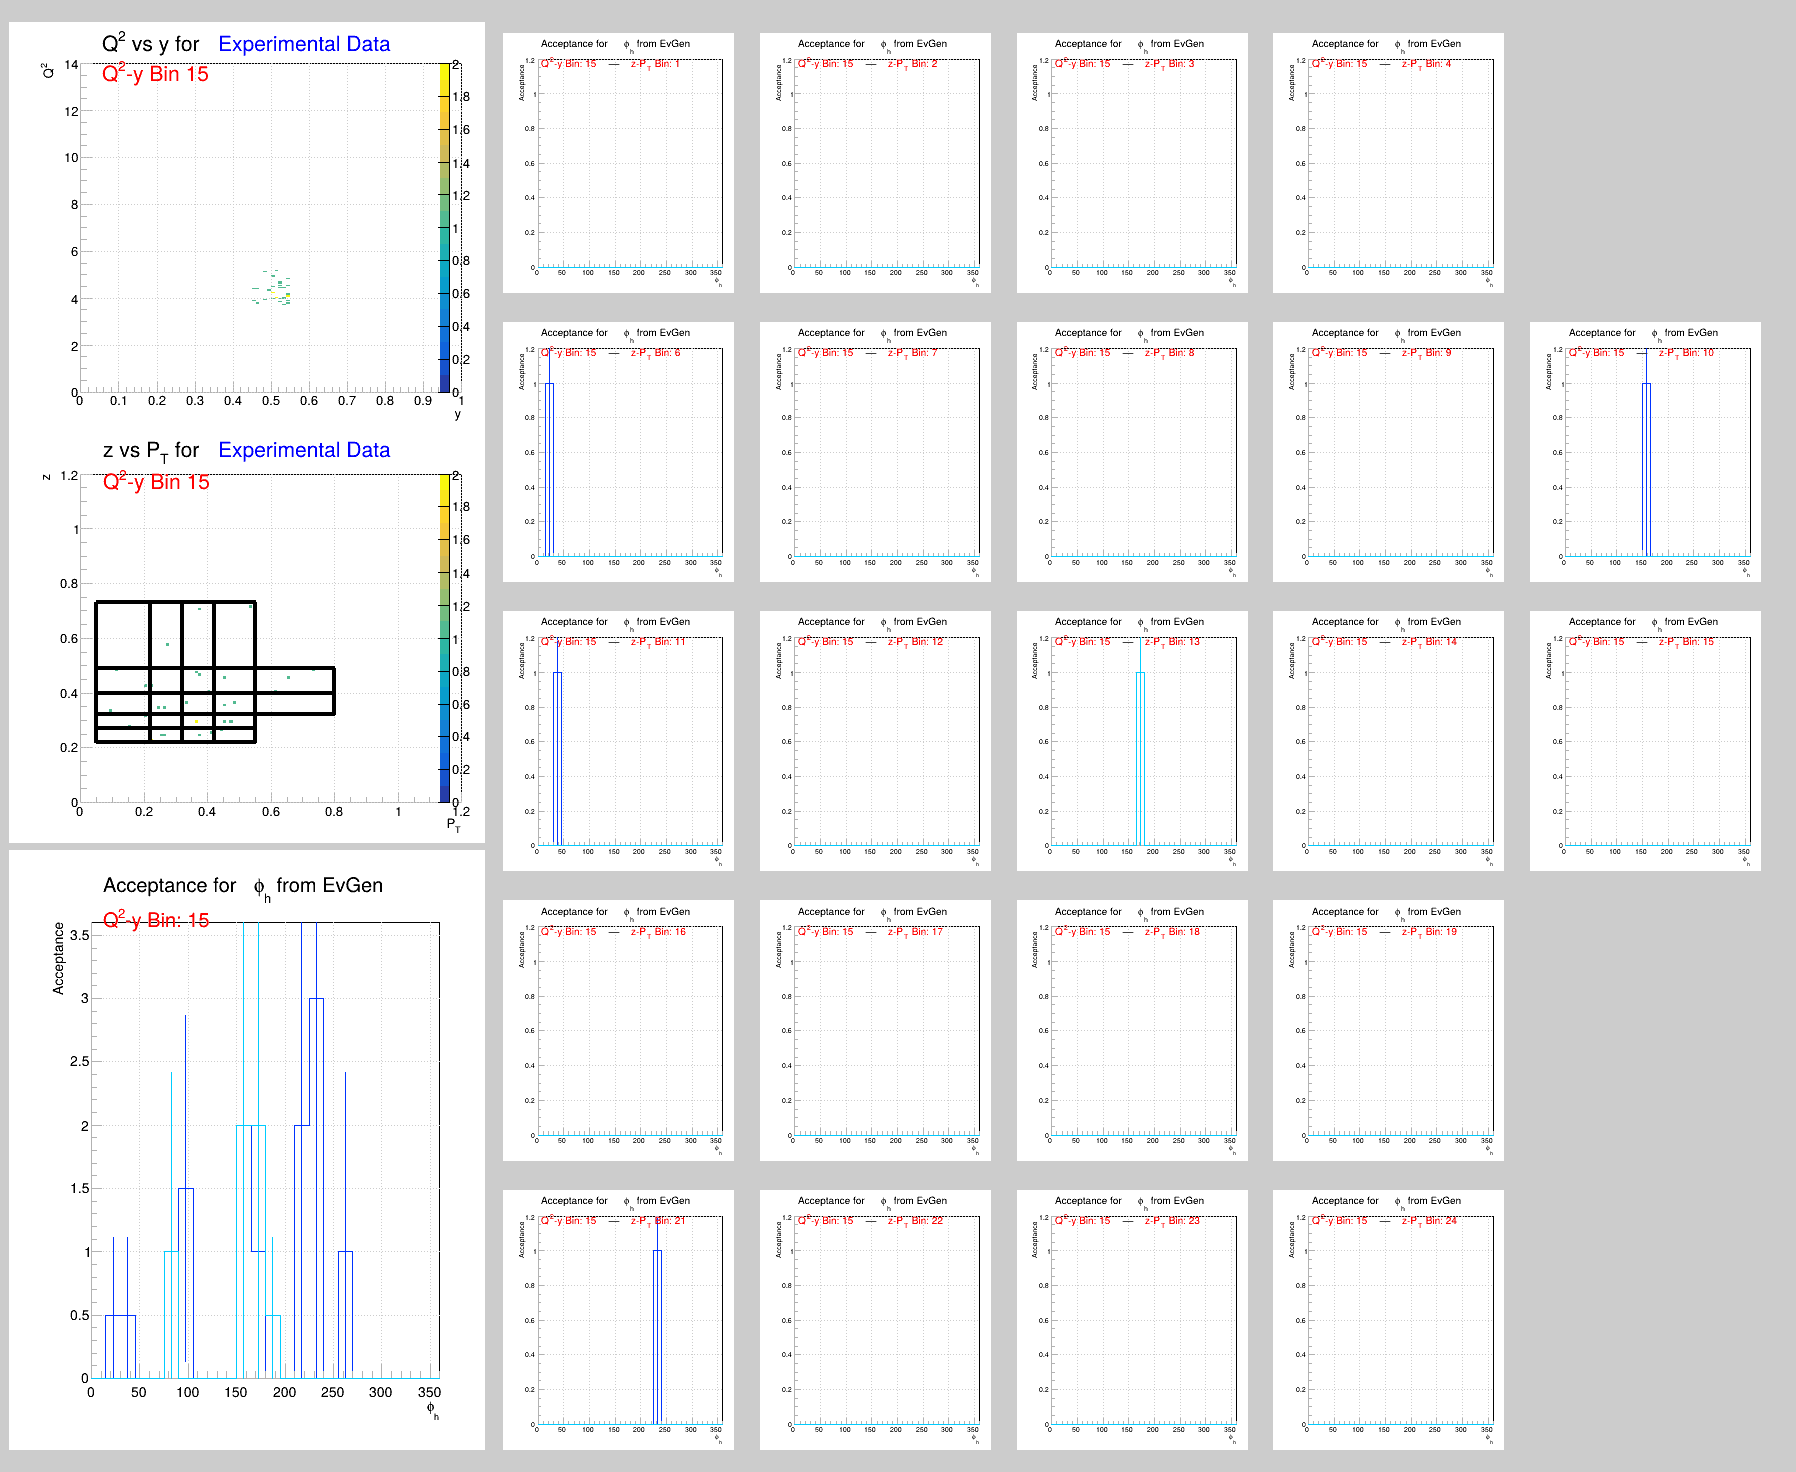

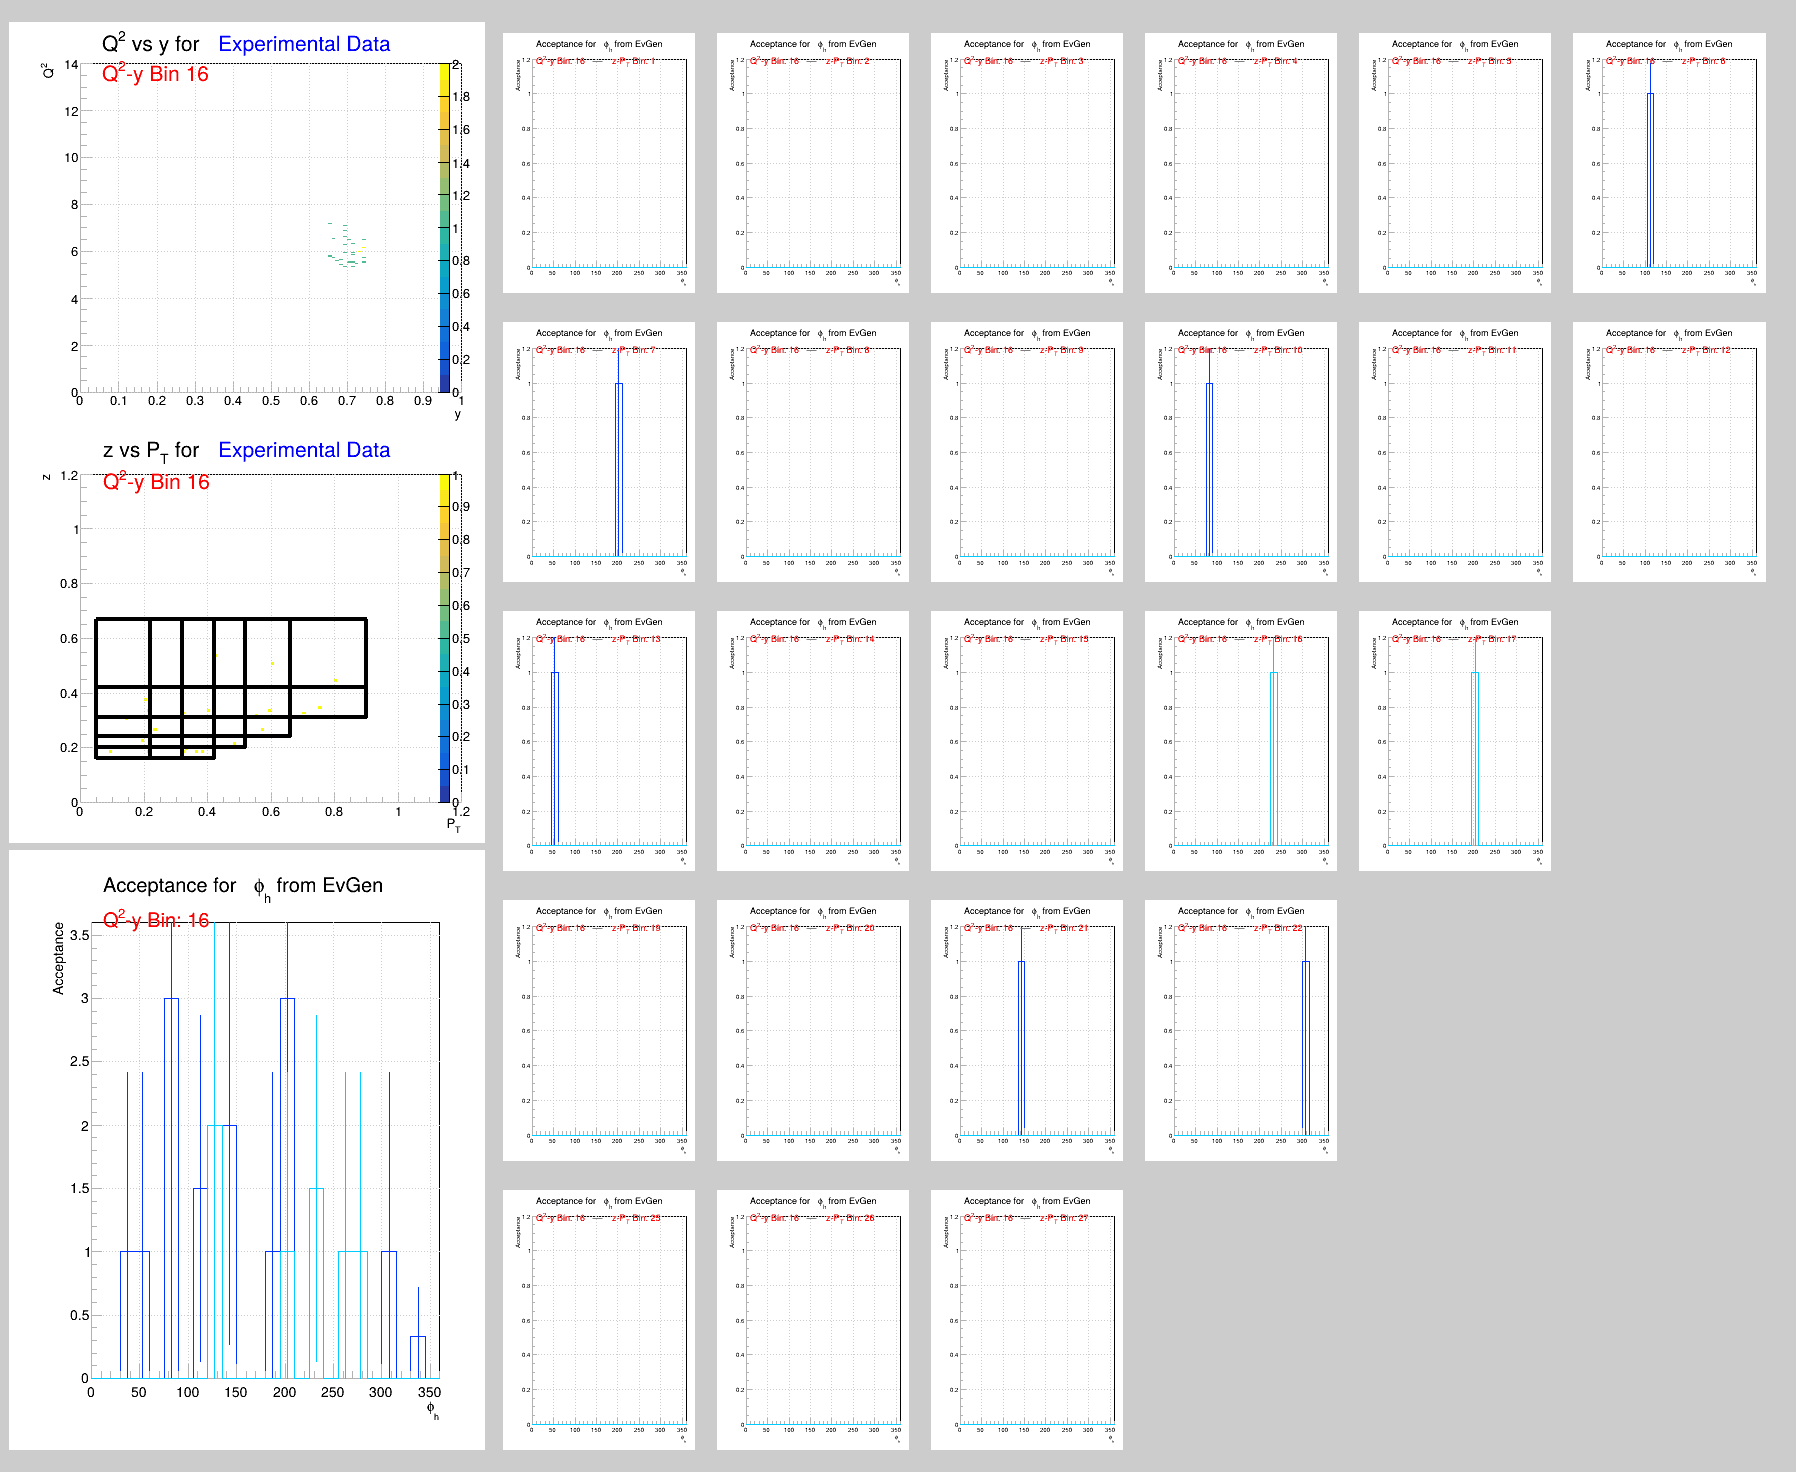

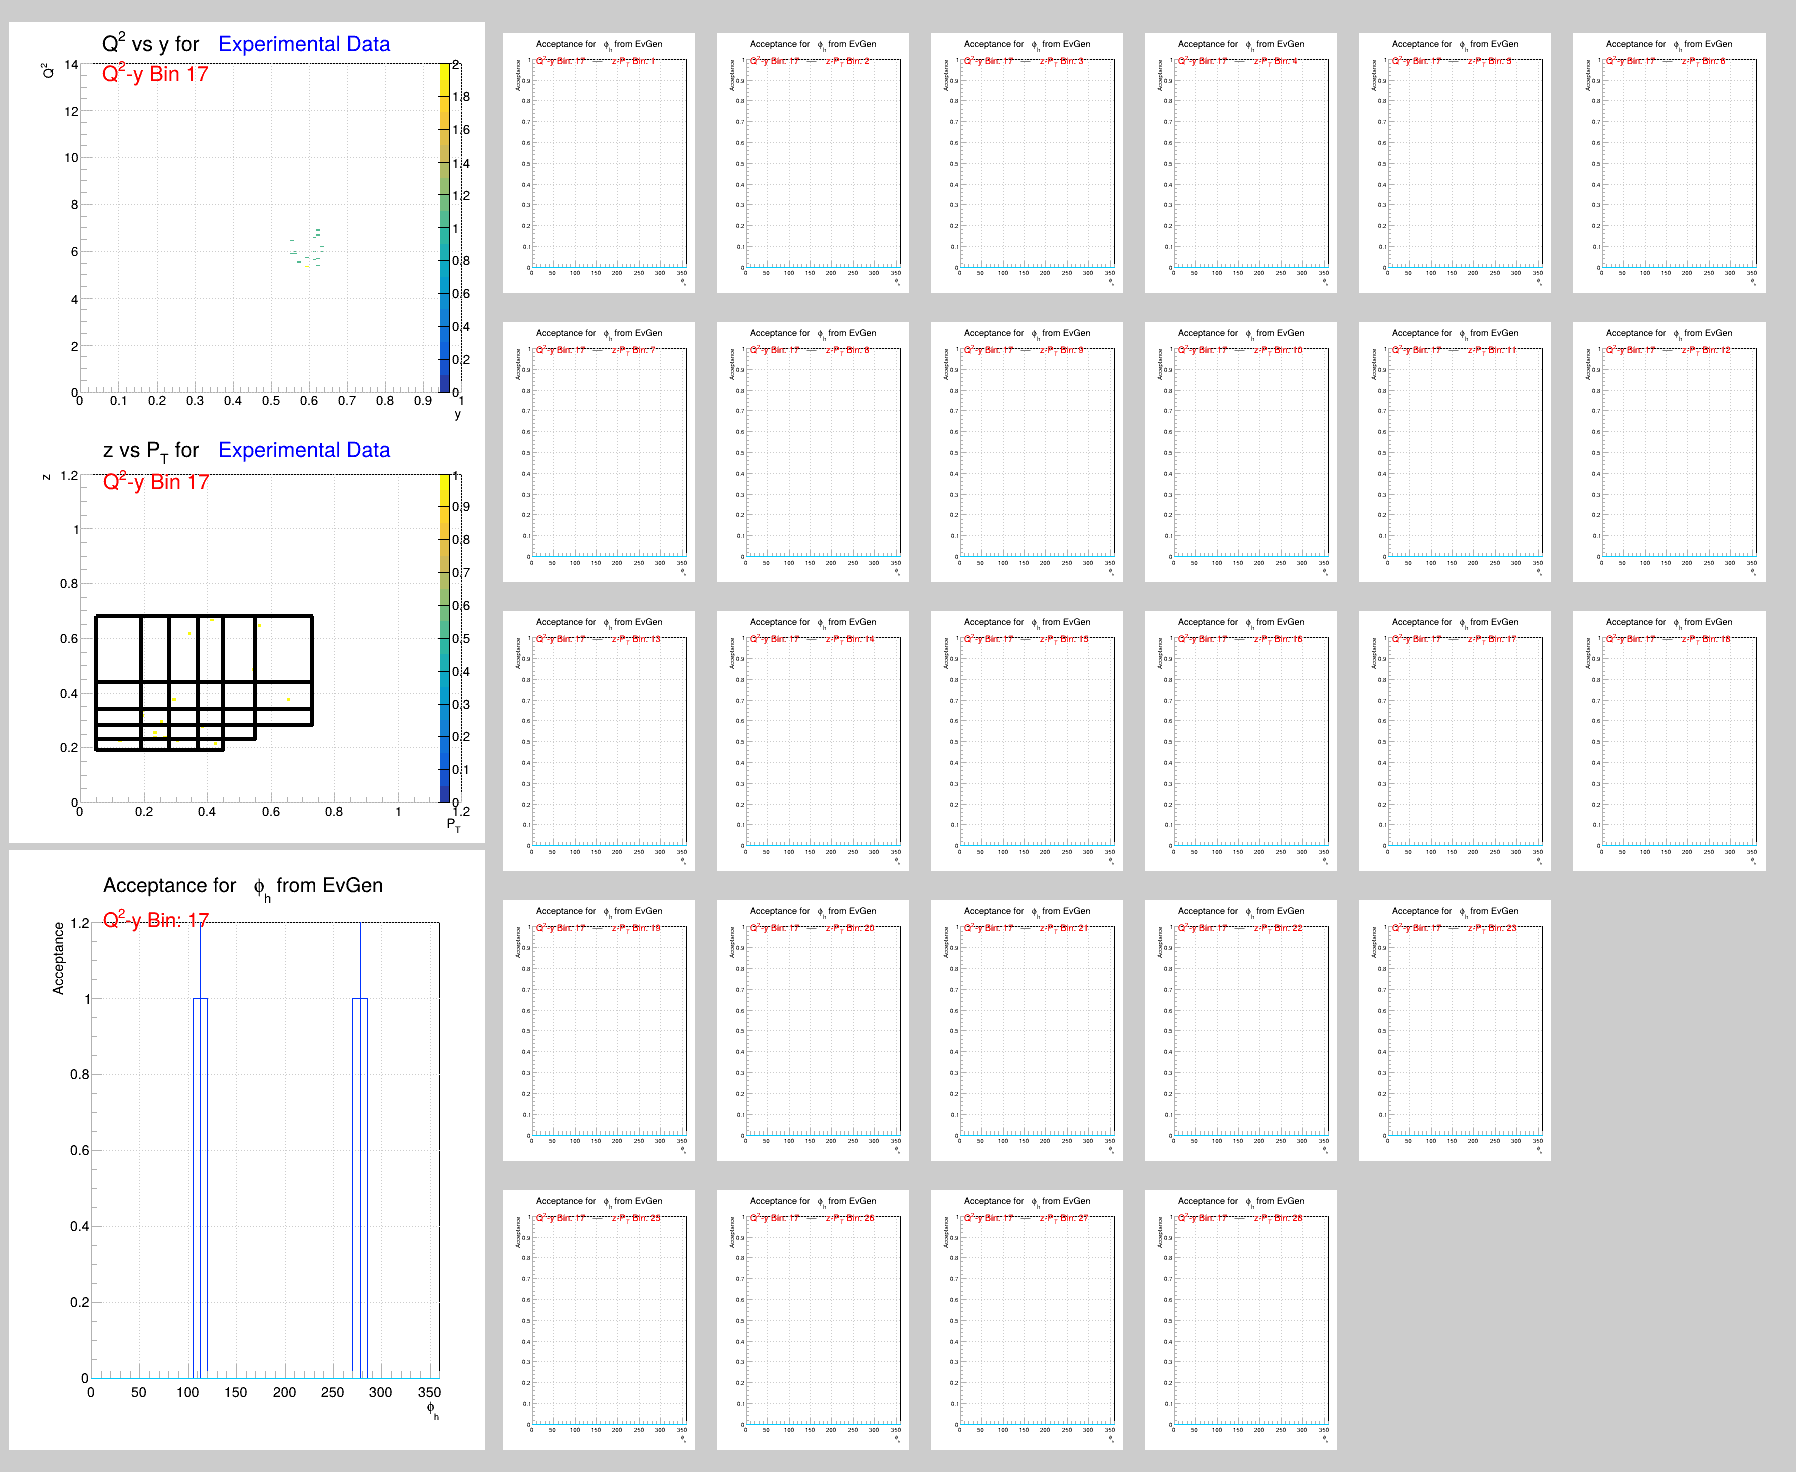

In [15]:
print(f"\n{color.BOLD}DRAWING ALL AVAILABLE 'Acceptance_Canvases' TCanvas\n{color.END}")
for ii in Acceptance_Canvases:
    print(f"Drawing: {ii}")
    Acceptance_Canvases[ii].Draw()
print("Done")

.

.

.


# Drawing Individual (2D) Plots






	Total entries in mdf_clasdis      files: 
            10213226
	Total entries in mdf_clasdis_test files: 
             1149918
	Total entries in mdf (Low Q2_gen) files: 
                 110 (is 0.0096% of the total events after applying the kinematic cuts and binning)







Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_Q2_vs_Q2gen


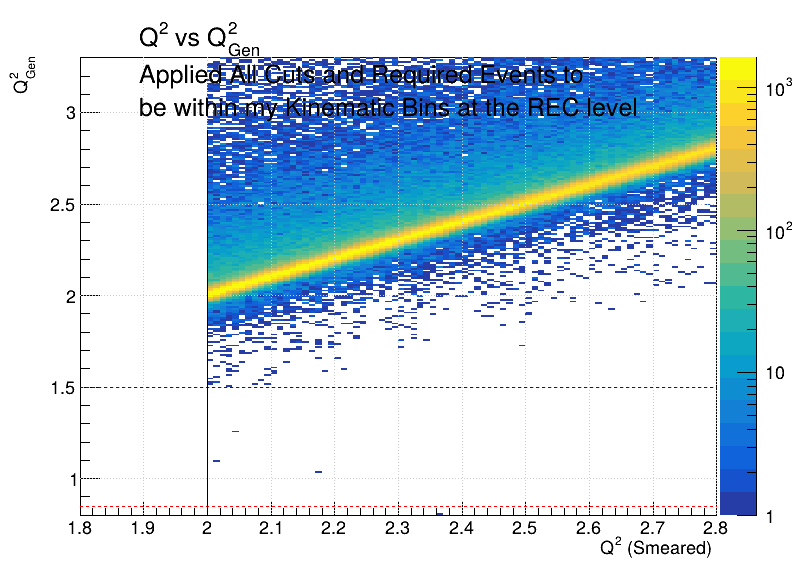

In [21]:
# Create a 2D histogram from the RDataFrame
hist_name = "h_Q2_vs_Q2gen"
hist_title = "#splitline{Q^{2} vs Q^{2}_{Gen}}{#splitline{Applied All Cuts and Required Events to}{be within my Kinematic Bins at the REC level}};Q^{2} (Smeared);Q^{2}_{Gen}"

print("\n\n\n\n")


mdf_clasdis_test = mdf_clasdis

# mdf_clasdis_test = mdf_clasdis_test.Range(50000)

print(f"\tTotal entries in {color.Error}mdf_clasdis{color.END}      files: \n{mdf_clasdis.Count().GetValue():>20.0f}")

mdf_clasdis_test = DF_Filter_Function_Full(DF_Out=mdf_clasdis_test, Titles_or_DF="DF", Data_Type="mdf", Cut_Choice="cut_Complete_SIDIS", Smearing_Q="smear")
mdf_clasdis_test = mdf_clasdis_test.Filter("z_pT_Bin_Y_bin_smeared > 0") # Requires the events to be within my kinematic binning scheme
count_after_cuts = mdf_clasdis_test.Count().GetValue()

print(f"\tTotal entries in {color.Error}mdf_clasdis_test{color.END} files: \n{count_after_cuts:>20.0f}")

mdf_clasdis_Low_Q2_gen = mdf_clasdis_test.Filter("Q2_gen < 1.5")
count_of_Low_Q2_gen = mdf_clasdis_Low_Q2_gen.Count().GetValue()

Precent_of_Low_Q2_gen = (count_of_Low_Q2_gen/count_after_cuts)*100

print(f"\tTotal entries in {color.Error}mdf (Low Q2_gen){color.END} files: \n{count_of_Low_Q2_gen:>20.0f} (is {Precent_of_Low_Q2_gen:3.4f}% of the total events after applying the kinematic cuts and binning)")


print("\n\n\n\n")

# Book the histogram: adjust binning as needed
h2 = mdf_clasdis_test.Histo2D((hist_name, hist_title, 100, 1.8, 2.8, 250, 0.8, 3.3), "Q2_smeared", "Q2_gen")

# Create a canvas and draw the histogram
canvas = ROOT.TCanvas("c_Q2_vs_Q2gen", "Q2 vs Q2_gen", 800, 600)
h2.Draw("COLZ")  # "COLZ" gives a color map with a Z-axis color bar

x_min = h2.GetXaxis().GetXmin()
x_max = h2.GetXaxis().GetXmax()
y_min = h2.GetYaxis().GetXmin()
y_max = h2.GetYaxis().GetXmax()

# --- Create TLine objects ---
# Horizontal lines
line_y1 = ROOT.TLine(x_min, 0.85, x_max, 0.85)
line_y2 = ROOT.TLine(x_min, 1.5,  x_max, 1.5)

# Vertical line
line_x = ROOT.TLine(2, y_min, 2, min([y_max, 2.9]))

line_y1.SetLineColor(ROOT.kRed)
line_y1.SetLineWidth(1)
line_y1.SetLineStyle(2)

line_y2.SetLineColor(ROOT.kBlue)
line_y2.SetLineWidth(1)
line_y2.SetLineStyle(2)

line_x.SetLineWidth(1)
line_x.SetLineStyle(1)

# Draw lines on top of histogram
line_y1.Draw("same")
line_y2.Draw("same")
line_x.Draw("same")

canvas.SetLogz(True)

canvas.Draw()


In [34]:
print(f"\tTotal entries in {color.Error}mdf (Low Q2_gen){color.END} files: \n{count_of_Low_Q2_gen:>20.0f} (is {Precent_of_Low_Q2_gen:3.4f}% of the total events after applying the kinematic cuts and binning)")
print(f"\tTotal entries in {color.Error}mdf (Low Q2_gen){color.END} files: \n{count_of_Low_Q2_gen:>20.0f} (is {Precent_of_Low_Q2_gen:3.5f}% of the total events after applying the kinematic cuts and binning)")


	Total entries in mdf (Low Q2_gen) files: 
                 110 (is 0.0096% of the total events after applying the kinematic cuts and binning)
	Total entries in mdf (Low Q2_gen) files: 
                 110 (is 0.00957% of the total events after applying the kinematic cuts and binning)


In [32]:
print(f"{3.50951e+07:.0f}")
print(f"{1.78071e+09:.0f}")
print(f"{8.90354e+09:.0f}")
print(f"{1.78071e+10:.0f}")

35095100
1780710000
8903540000
17807100000


In [31]:
data_statistics  = 3.50951e+07
EvGen_acceptance = 0.0197085

print(f"\n5:1 --> {(5*data_statistics)/EvGen_acceptance:.5e}\n")
print(f"{(5*data_statistics)/EvGen_acceptance:.0f}")


5:1 --> 8.90354e+09

8903544156


In [33]:
836181*5000

4180905000

# For Acceptance Weights
### Code design only — the following cell is not designed to work in this notebook

In [ ]:
    if(args.make_2D_weight):
        print(f"\n{color.BOLD}CREATING ACCEPTANCE WEIGHTS HISTOGRAMS/CODE{color.END}\n")
        El_Binning                 = ['el',     2.64, 7.88, 524]
        El_Th_Binning              = ['elth',      5,   35, 300]
        El_Phi_Binning             = ['elPhi',     0,  360, 720]
        Pip_Binning                = ['pip',    1.25,    5, 375]
        Pip_Th_Binning             = ['pipth',     5,   35, 300]
        Pip_Phi_Binning            = ['pipPhi',    0,  360, 720]
        # z_pT_Bin_Y_Binning         = ['z_pT_Bin_Y_bin',  -2.5,     41.5,    44]
        
        List_of_Quantities_2D = []
        List_of_Quantities_2D.append([El_Phi_Binning, Pip_Phi_Binning])
        List_of_Quantities_2D.append([El_Th_Binning,  Pip_Th_Binning])
        List_of_Quantities_2D.append([El_Binning,     Pip_Binning])
        
        histos_data_match = {}

        canvas_data_match = ROOT.TCanvas("canvas_data_match", "My Canvas", int(912*1.55), int(547*1.55))
        canvas_data_match.Divide(len(List_of_Quantities_2D), 3)
        
        for num, (x_vars, y_vars) in enumerate(List_of_Quantities_2D):
            var_x, Min_range_x, Max_range_x, Num_of_Bins_x = x_vars
            var_y, Min_range_y, Max_range_y, Num_of_Bins_y = y_vars
            rdf_name = f"{var_x}_vs_{var_y}_rdf"
            mclasdis = f"{var_x}_vs_{var_y}_mdf"
            data_match_name = f"{var_x}_vs_{var_y}"
            Title = f"Plot of {variable_Title_name_new(var_x)} vs {variable_Title_name_new(var_y)} from SOURCE; {variable_Title_name_new(var_x)}; {variable_Title_name_new(var_y)}"
            if(args.title):
                Title = f"#splitline{{Plot of {variable_Title_name_new(var_x)} vs {variable_Title_name_new(var_y)} from SOURCE}}{{{args.title}}}; {variable_Title_name_new(var_x)}; {variable_Title_name_new(var_y)}"
            histos_data_match[rdf_name] =         rdf.Histo2D((rdf_name, Title.replace("SOURCE", f"#color[{ROOT.kBlue   }]{{Experimental Data}}"),         Num_of_Bins_x, Min_range_x, Max_range_x, Num_of_Bins_y, Min_range_y, Max_range_y),    var_x,              var_y)
            histos_data_match[mclasdis] = mdf_clasdis.Histo2D((mclasdis, Title.replace("SOURCE", f"#color[{ROOT.kRed    }]{{Smeared MC REC (clasdis)}}"),  Num_of_Bins_x, Min_range_x, Max_range_x, Num_of_Bins_y, Min_range_y, Max_range_y), f"{var_x}_smeared", f"{var_y}_smeared")
            histos_data_match[mclasdis].GetXaxis().SetTitle(f"{variable_Title_name_new(var_x)} (Smeared)")
            histos_data_match[mclasdis].GetYaxis().SetTitle(f"{variable_Title_name_new(var_y)} (Smeared)")
            
            histos_data_match[rdf_name].SetLineColor(ROOT.kBlue)
            histos_data_match[mclasdis].SetLineColor(ROOT.kRed)

            rdf_name_norm_factor = histos_data_match[rdf_name].Integral()
            mclasdis_norm_factor = histos_data_match[mclasdis].Integral()
                
            histos_data_match[f"norm_{rdf_name}"] = histos_data_match[rdf_name].Clone(f"norm_{rdf_name}")
            histos_data_match[f"norm_{mclasdis}"] = histos_data_match[mclasdis].Clone(f"norm_{mclasdis}")
        
            histos_data_match[f"norm_{rdf_name}"].Scale((1/rdf_name_norm_factor) if(rdf_name_norm_factor != 0) else 1)
            histos_data_match[f"norm_{mclasdis}"].Scale((1/mclasdis_norm_factor) if(mclasdis_norm_factor != 0) else 1)            

            histos_data_match[data_match_name] = histos_data_match[f"norm_{rdf_name}"].Clone(data_match_name)
            histos_data_match[data_match_name].Divide(histos_data_match[f"norm_{mclasdis}"])
            if(args.title):
                histos_data_match[data_match_name].SetTitle(f"#splitline{{Ratio of #frac{{Data}}{{MC-REC}} for {variable_Title_name_new(var_x)} vs {variable_Title_name_new(var_y)}}}{{{args.title}}}")
            else:
                histos_data_match[data_match_name].SetTitle(f"Ratio of #frac{{Data}}{{MC-REC}} for {variable_Title_name_new(var_x)} vs {variable_Title_name_new(var_y)}")

            cd_num = num + 1
            canvas_data_match.cd(cd_num)
            histos_data_match[data_match_name].Draw("colz")
            canvas_data_match.cd(cd_num +   len(List_of_Quantities_2D))
            histos_data_match[f"norm_{rdf_name}"].Draw("colz")
            canvas_data_match.cd(cd_num + 2*len(List_of_Quantities_2D))
            histos_data_match[f"norm_{mclasdis}"].Draw("colz")

        save_name = f"Data_to_MC_Acceptance_Weights{args.File_Save_Format}" if(not args.name) else f"Data_to_MC_Acceptance_Weights_{args.name}{args.File_Save_Format}"
        canvas_data_match.SaveAs(save_name)
        print(f"{color.BOLD}Saved: {color.BBLUE}{save_name}{color.END}")
        timer.time_elapsed()
        print(f"\n{color.BOLD}DONE CREATING ACCEPTANCE WEIGHTS HISTOGRAMS/CODE{color.END}\n")
    else:
        print(f"\n{color.Error}Skipping Acceptance Weight Histograms{color.END}")

In [ ]:
    if(args.make_2D_weight):
        print(f"\n{color.BOLD}CREATING ACCEPTANCE WEIGHTS HISTOGRAMS/CODE{color.END}\n")
        El_Binning                 = ['el',     2.64, 7.88, 524]
        El_Th_Binning              = ['elth',      5,   35, 300]
        El_Phi_Binning             = ['elPhi',     0,  360, 720]
        Pip_Binning                = ['pip',    1.25,    5, 375]
        Pip_Th_Binning             = ['pipth',     5,   35, 300]
        Pip_Phi_Binning            = ['pipPhi',    0,  360, 720]

        El_Binning                 = ['el',      2.6,  7.9, 53]
        El_Th_Binning              = ['elth',      5,   35, 30]
        El_Phi_Binning             = ['elPhi',     0,  360, 72]
        Pip_Binning                = ['pip',     1.2,    5, 38]
        Pip_Th_Binning             = ['pipth',     5,   35, 30]
        Pip_Phi_Binning            = ['pipPhi',    0,  360, 72]
        
        List_of_Quantities_2D = []
        List_of_Quantities_2D.append([El_Phi_Binning, Pip_Phi_Binning])
        List_of_Quantities_2D.append([El_Th_Binning,  Pip_Th_Binning])
        List_of_Quantities_2D.append([El_Binning,     Pip_Binning])
        
        histos_data_match = {}

        canvas_data_match = ROOT.TCanvas("canvas_data_match", "My Canvas", int(912*1.55), int(547*1.55))
        canvas_data_match.Divide(len(List_of_Quantities_2D), 4)

        # -----------------------------
        # 1) One-time C++ helpers
        # -----------------------------
        One_Time_Cpp_Helpers = r"""
        #include <vector>
        #include <algorithm>
        #include <cmath>
        #include <string>

        int accw_findBin(const double value, const std::vector<double>& edges){
            if((value < edges.front()) or (value >= edges.back())){
                return -1;
            }
            auto it = std::upper_bound(edges.begin(), edges.end(), value);
            int idx = int(it - edges.begin()) - 1;
            if((idx < 0) or (idx >= int(edges.size()) - 1)){
                return -1;
            }
            return idx;
        }

        double accw_lookup2D(const double x, const double y,
                             const std::vector<double>& ex,
                             const std::vector<double>& ey,
                             const std::vector<double>& grid){
            const int nx = int(ex.size()) - 1;
            const int ny = int(ey.size()) - 1;

            int ix = accw_findBin(x, ex);
            int iy = accw_findBin(y, ey);

            if((ix < 0) or (iy < 0)){
                return 1.0; // under/overflow policy
            }

            const int idx = ix + nx*iy; // row-major (iy outer, ix inner)
            double w = grid[idx];
            if(!(w >= 0.0) or (!std::isfinite(w))){
                return 1.0;
            }
            return w;
        }
        """
        ROOT.gInterpreter.Declare(One_Time_Cpp_Helpers)

        # Accumulate generated wrappers to save for later use
        generated_wrappers_code = []
        generated_wrappers_code.append("// Auto-generated acceptance weight functions\n")
        generated_wrappers_code.append("// Includes\n#include <vector>\n#include <algorithm>\n#include <cmath>\n\n")
        generated_wrappers_code.append("// Helper declarations (duplicate-safe if header is included alone)\n")
        generated_wrappers_code.append(
            "int accw_findBin(const double value, const std::vector<double>& edges);\n"
            "double accw_lookup2D(const double x, const double y,\n"
            "                     const std::vector<double>& ex,\n"
            "                     const std::vector<double>& ey,\n"
            "                     const std::vector<double>& grid);\n\n"
        )

        def _cpp_list(vals):
            return "{" + ", ".join(f"{v:.16g}" for v in vals) + "}"

        # Optional: combined product of all acceptance weights applied to MC
        wdf = mdf_clasdis.Define("ACC_Weight_Product", "1.0")

        for num, (x_vars, y_vars) in enumerate(List_of_Quantities_2D):
            var_x, Min_range_x, Max_range_x, Num_of_Bins_x = x_vars
            var_y, Min_range_y, Max_range_y, Num_of_Bins_y = y_vars

            rdf_name        = f"{var_x}_vs_{var_y}_rdf"
            mclasdis        = f"{var_x}_vs_{var_y}_mdf"
            data_match_name = f"{var_x}_vs_{var_y}"

            Title = f"Plot of {variable_Title_name_new(var_x)} vs {variable_Title_name_new(var_y)} from SOURCE; {variable_Title_name_new(var_x)}; {variable_Title_name_new(var_y)}"
            if(args.title):
                Title = f"#splitline{{Plot of {variable_Title_name_new(var_x)} vs {variable_Title_name_new(var_y)} from SOURCE}}{{{args.title}}}; {variable_Title_name_new(var_x)}; {variable_Title_name_new(var_y)}"

            # -----------------------------
            # 2) Build 2D histos (your original)
            # -----------------------------
            histos_data_match[rdf_name] = rdf.Histo2D((rdf_name, Title.replace("SOURCE", f"#color[{ROOT.kBlue}]{{Experimental Data}}"),        Num_of_Bins_x, Min_range_x, Max_range_x, Num_of_Bins_y, Min_range_y, Max_range_y),    var_x,              var_y)
            histos_data_match[mclasdis] = wdf.Histo2D((mclasdis, Title.replace("SOURCE", f"#color[{ROOT.kRed}]{{Smeared MC REC (clasdis)}}"),  Num_of_Bins_x, Min_range_x, Max_range_x, Num_of_Bins_y, Min_range_y, Max_range_y), f"{var_x}_smeared", f"{var_y}_smeared", "ACC_Weight_Product")

            histos_data_match[mclasdis].GetXaxis().SetTitle(f"{variable_Title_name_new(var_x)} (Smeared)")
            histos_data_match[mclasdis].GetYaxis().SetTitle(f"{variable_Title_name_new(var_y)} (Smeared)")

            rdf_name_norm_factor = histos_data_match[rdf_name].Integral()
            mclasdis_norm_factor = histos_data_match[mclasdis].Integral()

            histos_data_match[f"norm_{rdf_name}"] = histos_data_match[rdf_name].Clone(f"norm_{rdf_name}")
            histos_data_match[f"norm_{mclasdis}"] = histos_data_match[mclasdis].Clone(f"norm_{mclasdis}")

            histos_data_match[f"norm_{rdf_name}"].Scale((1/rdf_name_norm_factor) if(rdf_name_norm_factor != 0) else 1)
            histos_data_match[f"norm_{mclasdis}"].Scale((1/mclasdis_norm_factor) if(mclasdis_norm_factor != 0) else 1)

            histos_data_match[data_match_name] = histos_data_match[f"norm_{rdf_name}"].Clone(data_match_name)
            histos_data_match[data_match_name].Divide(histos_data_match[f"norm_{mclasdis}"])

            if(args.title):
                histos_data_match[data_match_name].SetTitle(f"#splitline{{Ratio of #frac{{Data}}{{MC-REC}} for {variable_Title_name_new(var_x)} vs {variable_Title_name_new(var_y)}}}{{{args.title}}}")
            else:
                histos_data_match[data_match_name].SetTitle(f"Ratio of #frac{{Data}}{{MC-REC}} for {variable_Title_name_new(var_x)} vs {variable_Title_name_new(var_y)}")

            # -----------------------------
            # 3) Extract edges + row-major weights from the ratio
            # -----------------------------
            H_w = histos_data_match[data_match_name]

            nx = H_w.GetXaxis().GetNbins()
            ny = H_w.GetYaxis().GetNbins()

            edges_x = [H_w.GetXaxis().GetBinLowEdge(i) for i in range(1, nx+1)]
            edges_x.append(H_w.GetXaxis().GetBinUpEdge(nx))

            edges_y = [H_w.GetYaxis().GetBinLowEdge(j) for j in range(1, ny+1)]
            edges_y.append(H_w.GetYaxis().GetBinUpEdge(ny))

            weights = []
            for iy in range(1, ny+1):
                for ix in range(1, nx+1):
                    val = H_w.GetBinContent(ix, iy)
                    if((val < 0.0) or (not math.isfinite(val))):
                        val = 1.0
                    weights.append(val)

            cpp_edges_x = _cpp_list(edges_x)
            cpp_edges_y = _cpp_list(edges_y)
            cpp_weights = _cpp_list(weights)

            # Pick a stable function name for this pair
            func_name = f"accw_{var_x}_vs_{var_y}"

            # -----------------------------
            # 4) Generate + declare the concrete C++ wrapper
            # -----------------------------
            wrapper_code = f"""
double {func_name}(const double x, const double y){{
    static const std::vector<double> EX = {cpp_edges_x};
    static const std::vector<double> EY = {cpp_edges_y};
    static const std::vector<double> GRID = {cpp_weights};
    return accw_lookup2D(x, y, EX, EY, GRID);
}}
"""
            ROOT.gInterpreter.Declare(wrapper_code)
            generated_wrappers_code.append(wrapper_code)

            # -----------------------------
            # 5) Apply weight to MC (using smeared cols) to draw the next weighted MC histo
            # -----------------------------
            weight_col = f"W_{var_x}_vs_{var_y}"
            wdf = wdf.Define(weight_col, f"{func_name}({var_x}_smeared, {var_y}_smeared)").Redefine("ACC_Weight_Product", f"(ACC_Weight_Product) * ({weight_col})")

            # -----------------------------
            # 6) Draw panels (ratio / data / MC)
            # -----------------------------
            cd_num = num + 1
            canvas_data_match.cd(cd_num)
            ROOT.gPad.SetLogz(1)
            histos_data_match[data_match_name].Draw("colz")
            canvas_data_match.cd(cd_num +   len(List_of_Quantities_2D))
            ROOT.gPad.SetLogz(1)
            histos_data_match[f"norm_{rdf_name}"].Draw("colz")
            canvas_data_match.cd(cd_num + 2*len(List_of_Quantities_2D))
            ROOT.gPad.SetLogz(1)
            histos_data_match[f"norm_{mclasdis}"].Draw("colz")
            histos_data_match[f"norm_{mclasdis}"].SetTitle(f"#splitline{{{histos_data_match[f'norm_{mclasdis}'].GetTitle()}}}{{{root_color.Bold}{{#splitline{{Before Applying the Weights in this column}}{{Applied the weights from the columns to the left}}}}}}")

        for num, (x_vars, y_vars) in enumerate(List_of_Quantities_2D):
            var_x, _, _, _ = x_vars
            var_y, _, _, _ = y_vars
            mclasdis       = f"{var_x}_vs_{var_y}_mdf_Final"
            Title          = f"Plot of {variable_Title_name_new(var_x)} vs {variable_Title_name_new(var_y)} from SOURCE; {variable_Title_name_new(var_x)}; {variable_Title_name_new(var_y)}"
            if(args.title):
                Title      = f"#splitline{{Plot of {variable_Title_name_new(var_x)} vs {variable_Title_name_new(var_y)} from SOURCE}}{{{args.title}}}; {variable_Title_name_new(var_x)}; {variable_Title_name_new(var_y)}"
            histos_data_match[mclasdis] = wdf.Histo2D((mclasdis, Title.replace("SOURCE", f"#color[{ROOT.kRed}]{{Smeared MC REC (clasdis)}}"),  Num_of_Bins_x, Min_range_x, Max_range_x, Num_of_Bins_y, Min_range_y, Max_range_y), f"{var_x}_smeared", f"{var_y}_smeared", "ACC_Weight_Product")
            histos_data_match[mclasdis].GetXaxis().SetTitle(f"{variable_Title_name_new(var_x)} (Smeared)")
            histos_data_match[mclasdis].GetYaxis().SetTitle(f"{variable_Title_name_new(var_y)} (Smeared)")
            mclasdis_norm_factor = histos_data_match[mclasdis].Integral()
            histos_data_match[f"norm_{mclasdis}"] = histos_data_match[mclasdis].Clone(f"norm_{mclasdis}")
            histos_data_match[f"norm_{mclasdis}"].Scale((1/mclasdis_norm_factor) if(mclasdis_norm_factor != 0) else 1)
            canvas_data_match.cd((num + 1) + 3*len(List_of_Quantities_2D))
            ROOT.gPad.SetLogz(1)
            histos_data_match[f"norm_{mclasdis}"].Draw("colz")
            histos_data_match[f"norm_{mclasdis}"].SetTitle(f"#splitline{{{histos_data_match[f'norm_{mclasdis}'].GetTitle()}}}{{{root_color.Bold}{{After Applying ALL Weights in this column}}}}")
        # -----------------------------
        # 7) Save the canvas (ratio / data / weighted-MC)
        # -----------------------------
        save_name = f"Data_to_MC_Acceptance_Weights{args.File_Save_Format}" if(not args.name) else f"Data_to_MC_Acceptance_Weights_{args.name}{args.File_Save_Format}"
        canvas_data_match.SaveAs(save_name)
        print(f"{color.BOLD}Saved: {color.BBLUE}{save_name}{color.END}")

        # -----------------------------
        # 8) Emit a reusable header with all functions
        # -----------------------------
        header_body = "".join(generated_wrappers_code)
        header_path = "generated_acceptance_weights.hpp" if(not args.name) else f"generated_acceptance_weights_{args.name}.hpp"

        with open(header_path, "w") as hf:
            hf.write("// This file was auto-generated by your acceptance-weight script.\n")
            hf.write("// It contains concrete lookup functions accw_<x>_vs_<y>(x, y).\n\n")
            hf.write("#pragma once\n\n")
            hf.write("// Forward declarations for helper symbols (supply your own defs or include where declared):\n")
            hf.write("int accw_findBin(const double value, const std::vector<double>& edges);\n")
            hf.write("double accw_lookup2D(const double x, const double y,\n")
            hf.write("                     const std::vector<double>& ex,\n")
            hf.write("                     const std::vector<double>& ey,\n")
            hf.write("                     const std::vector<double>& grid);\n\n")
            hf.write(header_body)

        print(f"{color.BOLD}Wrote weight functions to: {color.BBLUE}{header_path}{color.END}")
        print(f"\n{color.BOLD}===== BEGIN GENERATED ACCEPTANCE-WEIGHT CODE ====={color.END}\n")
        print(header_body)
        print(f"\n{color.BOLD}=====  END GENERATED ACCEPTANCE-WEIGHT CODE  ====={color.END}\n")
        timer.time_elapsed()
        print(f"\n{color.BOLD}DONE CREATING ACCEPTANCE WEIGHTS HISTOGRAMS/CODE{color.END}\n")
    else:
        print(f"\n{color.Error}Skipping Acceptance Weight Histograms{color.END}")

In [ ]:
    if(args.make_2D_weight_check):
        print(f"\n{color.BOLD}TESTING (5D) ACCEPTANCE WEIGHTED HISTOGRAMS (MultiDim_Q2_y_z_pT_phi_h){color.END}\n")

        # 0) Load the self-contained, generated header (helpers + accw_* functions)
        ROOT.gInterpreter.Declare('#include "/w/hallb-scshelf2102/clas12/richcap/SIDIS_Analysis/Histo_Files_ROOT/DataFrames/generated_acceptance_weights.hpp"')
        
        # 1) Define Event_Weight on MC (mdf)
        if(args.json_weights):
            # With the Modulation weights option, apply the modulations to both gdf and mdf before adding the acceptance weights to mdf
            import json
            print(f"\n{color.BBLUE}Using phi_h Modulation Weights from the JSON file.{color.END}\n")
            with open(JSON_WEIGHT_FILE) as f:
                Fit_Pars = json.load(f)
                # Build the C++ initialization string
                cpp_map_str = "{"
                for key, val in Fit_Pars.items():
                    cpp_map_str += f'{{"{key}", {val}}},'
                cpp_map_str += "}"
                
                ROOT.gInterpreter.Declare(f"""
                #include <map>
                #include <string>
                #include <cmath>
                
                std::map<std::string, double> Fit_Pars = {cpp_map_str};
                
                double ComputeWeight(int Q2_y_Bin, int z_pT_Bin, double phi_h) {{
                    // build the keys dynamically
                    // std::string keyA = "A_" + std::to_string(Q2_y_Bin) + "_" + std::to_string(z_pT_Bin);
                    std::string keyB = "B_" + std::to_string(Q2_y_Bin) + "_" + std::to_string(z_pT_Bin);
                    std::string keyC = "C_" + std::to_string(Q2_y_Bin) + "_" + std::to_string(z_pT_Bin);
                
                    // safely retrieve parameters (default = 0)
                    // double Par_A = Fit_Pars.count(keyA) ? Fit_Pars[keyA] : 0.0;
                    double Par_B = Fit_Pars.count(keyB) ? Fit_Pars[keyB] : 0.0;
                    double Par_C = Fit_Pars.count(keyC) ? Fit_Pars[keyC] : 0.0;
                
                    // calculate weight
                    double phi_rad = phi_h * TMath::DegToRad();
                    double weight  = (1.0 + Par_B * std::cos(phi_rad) + Par_C * std::cos(2.0 * phi_rad));
                
                    return weight;
                }}
                """)
            mdf_clasdis = mdf_clasdis.Define("Event_Weight", "ComputeWeight(Q2_Y_Bin_gen, z_pT_Bin_Y_bin_gen, phi_t_gen) * (accw_elPhi_vs_pipPhi(elPhi_smeared, pipPhi_smeared)) * (accw_elth_vs_pipth(elth_smeared, pipth_smeared)) * (accw_el_vs_pip(el_smeared, pip_smeared))")
            gdf_clasdis = gdf_clasdis.Define("Event_Weight", "ComputeWeight(Q2_Y_Bin,     z_pT_Bin_Y_bin,     phi_t)")
        else:
            mdf_clasdis = mdf_clasdis.Define("Event_Weight", "(accw_elPhi_vs_pipPhi(elPhi_smeared, pipPhi_smeared)) * (accw_elth_vs_pipth(elth_smeared, pipth_smeared)) * (accw_el_vs_pip(el_smeared, pip_smeared))")
            gdf_clasdis = gdf_clasdis.Define("Event_Weight", "1.0")
            
        
        # 2) Book TH1D histograms for phi_t (-0.5...11815.5, 11816 bins)
        var_name = variable_Title_name_new("MultiDim_Q2_y_z_pT_phi_h")
        Title = f"Comparisons of {var_name}"
        Q2_y_z_pT_phi_h_5D_Binning = ['MultiDim_Q2_y_z_pT_phi_h', -0.5, 11814 + 1.5, 11814 + 2]
        if(args.title):
            Title = f"#splitline{{{Title}}}{{{args.title}}}"
        h_rdf =         rdf.Histo1D(("h_5D_rdf", f"{Title}; {var_name}; Normalized",                                                          11816, -0.5, 11815.5), "MultiDim_Q2_y_z_pT_phi_h")
        h_mdf = mdf_clasdis.Histo1D(("h_5D_mdf", f"#splitline{{Comparisons of {var_name}}}{{Without Reweighted MC}}; {var_name}; Normalized", 11816, -0.5, 11815.5), "MultiDim_Q2_y_z_pT_phi_h_smeared")
        h_gdf = gdf_clasdis.Histo1D(("h_5D_gdf", f"#splitline{{Comparisons of {var_name}}}{{Without Reweighted MC}}; {var_name}; Normalized", 11816, -0.5, 11815.5), "MultiDim_Q2_y_z_pT_phi_h")
        w_mdf = mdf_clasdis.Histo1D(("w_5D_mdf", f"{Title}; {var_name}; Normalized",                                                          11816, -0.5, 11815.5), "MultiDim_Q2_y_z_pT_phi_h_smeared", "Event_Weight")
        w_gdf = gdf_clasdis.Histo1D(("w_5D_gdf", f"{Title}; {var_name}; Normalized",                                                          11816, -0.5, 11815.5), "MultiDim_Q2_y_z_pT_phi_h",         "Event_Weight")
        
        # 3) Set line colors (on the actual TH1 objects)
        h_rdf.GetValue().SetLineColor(ROOT.kBlue)
        h_mdf.GetValue().SetLineColor(ROOT.kRed)
        h_gdf.GetValue().SetLineColor(ROOT.kGreen)

        w_mdf.GetValue().SetLineColor(ROOT.kPink + 10)
        w_gdf.GetValue().SetLineColor(ROOT.kCyan)
        
        # 4) Make normalized clones for maxima AND drawing
        def _make_norm_clone(hptr, name):
            h = hptr.GetValue().Clone(name)
            integral = h.Integral()
            if((integral != 0.0)):
                h.Scale(1.0/integral)
            return h
        
        h_rdf_n = _make_norm_clone(h_rdf, "h_5D_rdf_norm")
        h_mdf_n = _make_norm_clone(h_mdf, "h_5D_mdf_norm")
        h_gdf_n = _make_norm_clone(h_gdf, "h_5D_gdf_norm")
        w_mdf_n = _make_norm_clone(w_mdf, "w_5D_mdf_norm")
        w_gdf_n = _make_norm_clone(w_gdf, "w_5D_gdf_norm")
        
        comp_wW = w_mdf_n.Clone("w_5D_Compare")
        comp_nW = h_mdf_n.Clone("h_5D_Compare")

        comp_wW.Divide(h_rdf_n)
        comp_nW.Divide(h_rdf_n)

        comp_wW.SetLineColor(ROOT.kBlack)
        comp_nW.SetLineColor(ROOT.kBlack)

        comp_wW.SetTitle("#scale[1.25]{#splitline{Comparisons of Data and MC}{WITH Reweighted MC}}; #phi_{h}; #frac{MC REC}{Data}")
        comp_nW.SetTitle("#scale[1.25]{#splitline{Comparisons of Data and MC}{WITHOUT Reweighted MC}}; #phi_{h}; #frac{MC REC}{Data}")
        comp_wW.GetXaxis().SetTitle(var_name)
        comp_nW.GetXaxis().SetTitle(var_name)
        

        CwW_max, CwW_min = comp_wW.GetMaximum(), comp_wW.GetMinimum()
        CnW_max, CnW_min = comp_nW.GetMaximum(), comp_nW.GetMinimum()

        Comp_Max = max([1.3*CwW_max, 1.3*CnW_max, 0.5*CwW_max, 0.5*CnW_max, 1.3])
        Comp_Min = min([1.3*CwW_max, 1.3*CnW_max, 0.5*CwW_max, 0.5*CnW_max, 0.7])
        
        rdf_max = h_rdf_n.GetMaximum()
        mdf_max = w_mdf_n.GetMaximum()
        gdf_max = w_gdf_n.GetMaximum()
        global_max = max([rdf_max, mdf_max, gdf_max, 1e-5])
        
        # 5) Draw overlay on one canvas (first drawn sets axes)
        # c_phi = ROOT.TCanvas("c_phi_t_overlay", "phi_t overlays", 900, 600)
        c_phi = ROOT.TCanvas("c_phi_t_overlay", "phi_t overlays", int(912*1.55*25), int(547*1.55*25))
        c_phi.Divide(2, 2)
        
        # ----- Pad 1: Data vs Reweighted MC -----
        c_phi.cd(1)
        h_rdf_n.GetYaxis().SetRangeUser(0.0, 1.2*global_max)
        h_rdf_n.Draw("H P E0")
        w_mdf_n.Draw("H P E0 same")
        w_gdf_n.Draw("H P E0 same")
        
        # Legend for pad 1
        # leg1 = ROOT.TLegend(0.62, 0.70, 0.88, 0.88)  # top-right; adjust if needed
        leg1 = ROOT.TLegend(0.38, 0.12, 0.62, 0.3)  # bottom-center
        leg1.SetBorderSize(0)
        leg1.SetFillStyle(0)
        leg1.SetTextSize(0.04)
        leg1.AddEntry(h_rdf_n, "Experimental Data", "l")
        leg1.AddEntry(w_mdf_n, "MC REC (Reweighted)", "l")
        leg1.AddEntry(w_gdf_n, "MC GEN (Modulated)", "l")
        leg1.Draw()
        
        # ----- Pad 2: Data vs Default MC -----
        c_phi.cd(2)
        h_gdf_n.GetYaxis().SetRangeUser(0.0, 1.2*global_max)
        h_gdf_n.Draw("H P E0")
        h_rdf_n.Draw("H P E0 same")
        h_mdf_n.Draw("H P E0 same")
        
        # Legend for pad 2
        leg2 = ROOT.TLegend(0.38, 0.12, 0.62, 0.3)  # bottom-center
        leg2.SetBorderSize(0)
        leg2.SetFillStyle(0)
        leg2.SetTextSize(0.04)
        leg2.AddEntry(h_rdf_n, "Experimental Data", "l")
        leg2.AddEntry(h_gdf_n, "MC GEN (Default)", "l")
        leg2.AddEntry(h_mdf_n, "MC REC (Default)", "l")
        leg2.Draw()
        
        # ----- Pad 3: Ratio WITH reweighting -----
        c_phi.cd(3)
        comp_wW.GetYaxis().SetRangeUser(Comp_Min, Comp_Max)
        comp_wW.Draw("H P E0")
        l_w = ROOT.TLine(0, 1.0, 360, 1.0)
        l_w.SetLineStyle(2)
        l_w.SetLineWidth(2)
        l_w.SetLineColor(ROOT.kGray)
        l_w.Draw("same")

        # Compute average bin content (exclude under/overflow)
        def _avg_bin_content(h):
            nb = h.GetNbinsX()
            s = 0.0
            for i in range(1, nb + 1):
                s += h.GetBinContent(i)
            return (s / nb) if(nb > 0) else 0.0
        
        avg_w = _avg_bin_content(comp_wW)
        # Add a small NDC stat box
        pt3 = ROOT.TPaveText(0.38, 0.6, 0.62, 0.65, "NDC")
        pt3.SetFillStyle(0)
        pt3.SetBorderSize(0)
        pt3.SetTextAlign(12)  # left-adjust text inside box
        pt3.SetTextSize(0.04)
        pt3.AddText(f"Average = {avg_w:.4f}")
        pt3.Draw()
        
        # ----- Pad 4: Ratio WITHOUT reweighting -----
        c_phi.cd(4)
        comp_nW.GetYaxis().SetRangeUser(Comp_Min, Comp_Max)
        comp_nW.Draw("H P E0")
        l_h = ROOT.TLine(0, 1.0, 360, 1.0)
        l_h.SetLineStyle(2)
        l_h.SetLineWidth(2)
        l_h.SetLineColor(ROOT.kGray)
        l_h.Draw("same")
        
        avg_nw = _avg_bin_content(comp_nW)
        # pt4 = ROOT.TPaveText(0.68, 0.80, 0.94, 0.92, "NDC")
        pt4 = ROOT.TPaveText(0.38, 0.6, 0.62, 0.65, "NDC")
        pt4.SetFillStyle(0)
        pt4.SetBorderSize(0)
        pt4.SetTextAlign(12)
        pt4.SetTextSize(0.04)
        pt4.AddText(f"Average = {avg_nw:.4f}")
        pt4.Draw()
        
        c_phi.Update()

        
        # save_name = f"phi_h_Comparison_with_Acceptance_Weights{args.File_Save_Format}" if(not args.name) else f"phi_h_Comparison_with_Acceptance_Weights_{args.name}{args.File_Save_Format}"
        save_name = f"Comparison_of_5D_Bins_with_and_without_Acceptance_Weights{args.File_Save_Format}" if(not args.name) else f"Comparison_of_5D_Bins_with_and_without_Acceptance_Weights_{args.name}{args.File_Save_Format}"
        c_phi.SaveAs(save_name)
        print(f"{color.BOLD}Saved: {color.BBLUE}{save_name}{color.END}")

In [ ]:
import ROOT

def DrawNormalizedHistos(histos_in, TPad_draw, Normalize_Q=True):
    # Draws a list of TH1 histograms normalized to unit area and automatically 
    # adjusts the y-axis to go from 0 to 1.2 × the maximum normalized bin height.
    if(not histos):
        print(f"{color.Error}Warning: empty histogram list passed to DrawNormalizedHistos(){color.END}")
        return

    if(not TPad_draw):
        print(f"{color.Error}Warning: Did not pass a TPad to DrawNormalizedHistos() to draw in{color.END}")
        return

    # Compute the largest normalized bin content among all histograms
    max_val = 0.0
    for h in histos:
        if(Normalize_Q):
            if(h and (h.Integral() != 0)):
                norm_max = h.GetMaximum() / h.Integral()
                if(norm_max > max_val):
                    max_val = norm_max
        else:
            max_val = max([max_val, h.GetMaximum()])

    y_max = (1.2 * max_val) if(max_val > 0) else 1.0
    
    Draw_Canvas(TPad_draw, 1, 0.15)
    # Draw all histograms normalized
    first = True
    for h in histos:
        if((not h) or (h.Integral() == 0)):
            continue
        h.GetYaxis().SetRangeUser(0, y_max)
        if(Normalize_Q):
            h.DrawNormalized("H P E0" if(first) else "H P E0 same")
        else:
            h.Draw("H P E0" if(first) else "H P E0 same")
        first = False


def z_pT_Images_Together_For_Comparisons(rdf_in=None, mdf_in=None, gdf_in=None, Q2_Y_Bin_List=range(1, 18), Plot_Orientation="z_pT"):
    Saved_Histos, All_z_pT_Canvas, All_z_pT_Canvas_cd_1, All_z_pT_Canvas_cd_1_Upper, All_z_pT_Canvas_cd_1_Lower, All_z_pT_Canvas_cd_2, All_z_pT_Canvas_cd_2_cols, legend = {}, {}, {}, {}, {}, {}, {}, {}
    for Q2_Y_Bin in Q2_Y_Bin_List:
        Canvases_to_Make = [f"Uncorrected_Modulation_Comparisons_Q2_y_Bin_{Q2_Y_Bin}", f"Bin_by_Bin_Comparisons_of_Weights_Q2_y_Bin_{Q2_Y_Bin}", f"Weighed_Acceptance_Comparisons_Q2_y_Bin_{Q2_Y_Bin}"]
        ##############################################################################################################################################################################################################################################################################################################################################################################################################
        ####  Histogram Creations     #########################################################################################################################################################################
        z_pT_Bin_Range = range(0, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_Y_Bin)[1] + 1)
        for z_PT_BIN_NUM  in z_pT_Bin_Range:
            if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_Y_Bin, Z_PT_BIN=z_PT_BIN_NUM, BINNING_METHOD=Binning_Method, Common_z_pT_Range_Q=False)):
                continue
            Binning_Title = f"{root_color.Bold}{{Q^{{2}}-y Bin {Q2_Y_Bin} #topbar z-P_{{T}} Bin {z_PT_BIN_NUM if(z_PT_BIN_NUM != 0) else 'All'}}}"
            if(args.title):
                Binning_Title = f"#splitline{{{Binning_Title}}}{{{args.title}}}"
            Saved_Histos[f"rdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})"]     = (rdf_in.Filter(f"(Q2_Y_Bin == {Q2_Y_Bin}) && (z_pT_Bin_Y_bin {'==' if(z_PT_BIN_NUM != 0) else '!='} {z_PT_BIN_NUM})")).Histo1D((f"rdf_(z_pT_Bin_{z_PT_BIN_NUM})",         f"#splitline{{Experimental Distribution of #phi_{{h}}}}{{{Binning_Title}}}; #phi_{{h}}", 24, 0.0, 360.0), "phi_t")
            Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_NoW"] = (mdf_in.Filter(f"(Q2_Y_Bin == {Q2_Y_Bin}) && (z_pT_Bin_Y_bin {'==' if(z_PT_BIN_NUM != 0) else '!='} {z_PT_BIN_NUM})")).Histo1D((f"mdf_(z_pT_Bin_{z_PT_BIN_NUM})_NoW", f"#splitline{{Unweighed MC REC Distribution of #phi_{{h}}}}{{{Binning_Title}}}; #phi_{{h}}", 24, 0.0, 360.0), "phi_t_smeared")
            Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_NoW"] = (gdf_in.Filter(f"(Q2_Y_Bin == {Q2_Y_Bin}) && (z_pT_Bin_Y_bin {'==' if(z_PT_BIN_NUM != 0) else '!='} {z_PT_BIN_NUM})")).Histo1D((f"gdf_(z_pT_Bin_{z_PT_BIN_NUM})_NoW", f"#splitline{{Unweighed MC GEN Distribution of #phi_{{h}}}}{{{Binning_Title}}}; #phi_{{h}}", 24, 0.0, 360.0), "phi_t")
            Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_AcW"] = (mdf_in.Filter(f"(Q2_Y_Bin == {Q2_Y_Bin}) && (z_pT_Bin_Y_bin {'==' if(z_PT_BIN_NUM != 0) else '!='} {z_PT_BIN_NUM})")).Histo1D((f"mdf_(z_pT_Bin_{z_PT_BIN_NUM})_AcW",   f"#splitline{{Weighed MC REC Distribution of #phi_{{h}}}}{{{Binning_Title}}}; #phi_{{h}}", 24, 0.0, 360.0), "phi_t_smeared", "Event_Weight")
            Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_AcW"] = (gdf_in.Filter(f"(Q2_Y_Bin == {Q2_Y_Bin}) && (z_pT_Bin_Y_bin {'==' if(z_PT_BIN_NUM != 0) else '!='} {z_PT_BIN_NUM})")).Histo1D((f"gdf_(z_pT_Bin_{z_PT_BIN_NUM})_AcW",   f"#splitline{{Weighed MC GEN Distribution of #phi_{{h}}}}{{{Binning_Title}}}; #phi_{{h}}", 24, 0.0, 360.0), "phi_t",         "Event_Weight")
    
            Saved_Histos[f"rdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})"].SetLineColor(ROOT.kRed)
            Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_NoW"].SetLineColor(ROOT.kBlue)
            Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_NoW"].SetLineColor(ROOT.kGreen)
            Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_AcW"].SetLineColor(ROOT.kViolet)
            Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_AcW"].SetLineColor(ROOT.kTeal)
            for cor_W in ["_NoW", "_AcW"]:
                Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"] = Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"].Clone(f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}")
                Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"].Divide(Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"])
                Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"].SetTitle(f"#splitline{{{'Unweighed' if(cor_W == '_NoW') else 'Weighed'} MC Acceptance}}{{{Binning_Title}}}")
                Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"].SetLineColor(ROOT.kBlack if(cor_W == '_NoW') else (ROOT.kGray + 2))
                
                Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"] = Saved_Histos[f"rdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})"].Clone(f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}")
                Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"].Divide(Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"])
                Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"].SetTitle(f"#splitline{{Bin-by-Bin Corrected Data (Using {'Unweighed' if(cor_W == '_NoW') else 'Weighed'} MC Acceptance)}}{{{Binning_Title}}}")
                Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"].SetLineColor(28 if(cor_W == '_NoW') else (ROOT.kOrange + 1))
    
            Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_Synthetic"] = Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_AcW"].Clone(f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_Synthetic")
            Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_Synthetic"].Divide(Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_NoW"])
            Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_Synthetic"].SetTitle(f"#splitline{{Bin-by-Bin Corrected Synthetic Data (Using Unweighed MC to Correct the Weighed MC)}}{{{Binning_Title}}}")
            Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_Synthetic"].SetLineColor(ROOT.kOrange - 1)
                
        ####  Histogram Creations     #########################################################################################################################################################################
        #######################################################################################################################################################################################################
        ####  Canvas (Main) Creation  #########################################################################################################################################################################
        for canvas_num, Canvas_Name in enumerate(Canvases_to_Make):
            All_z_pT_Canvas[Canvas_Name] = Canvas_Create(Name=Canvas_Name, Num_Columns=2, Num_Rows=1, Size_X=3900, Size_Y=2175, cd_Space=0.01)
            All_z_pT_Canvas[Canvas_Name].SetFillColor(root_color.LGrey)
            All_z_pT_Canvas_cd_1[Canvas_Name]       = All_z_pT_Canvas[Canvas_Name].cd(1)
            All_z_pT_Canvas_cd_1[Canvas_Name].SetFillColor(root_color.LGrey)
            All_z_pT_Canvas_cd_1[Canvas_Name].SetPad(xlow=0.005, ylow=0.015, xup=0.27, yup=0.985)
            All_z_pT_Canvas_cd_1[Canvas_Name].Divide(1, 2, 0, 0)
            All_z_pT_Canvas_cd_1_Upper[Canvas_Name] = All_z_pT_Canvas_cd_1[Canvas_Name].cd(1)
            All_z_pT_Canvas_cd_1_Upper[Canvas_Name].SetPad(xlow=0, ylow=0.425, xup=1, yup=1)
            All_z_pT_Canvas_cd_1_Upper[Canvas_Name].Divide(1, 1, 0, 0)
            All_z_pT_Canvas_cd_1_Lower[Canvas_Name] = All_z_pT_Canvas_cd_1[Canvas_Name].cd(2)
            All_z_pT_Canvas_cd_1_Lower[Canvas_Name].SetPad(xlow=0, ylow=0, xup=1, yup=0.42)
            All_z_pT_Canvas_cd_1_Lower[Canvas_Name].Divide(1, 1, 0, 0)
            All_z_pT_Canvas_cd_1_Lower[Canvas_Name].cd(1).SetPad(xlow=0.035, ylow=0.025, xup=0.95, yup=0.975)
            All_z_pT_Canvas_cd_2[Canvas_Name]       = All_z_pT_Canvas[Canvas_Name].cd(2)
            All_z_pT_Canvas_cd_2[Canvas_Name].SetPad(xlow=0.28, ylow=0.015, xup=0.995, yup=0.9975)
            All_z_pT_Canvas_cd_2[Canvas_Name].SetFillColor(root_color.LGrey)
            if(Plot_Orientation in ["z_pT"]):
                number_of_rows, number_of_cols = Get_Num_of_z_pT_Rows_and_Columns(Q2_Y_Bin_Input=Q2_Y_Bin)
                All_z_pT_Canvas_cd_2[Canvas_Name].Divide(number_of_cols, number_of_rows, 0.0001, 0.0001)
            else:
                number_of_rows, number_of_cols = Get_Num_of_z_pT_Rows_and_Columns(Q2_Y_Bin_Input=Q2_Y_Bin)
                All_z_pT_Canvas_cd_2[Canvas_Name].Divide(1, number_of_cols, 0.0001, 0.0001)
                for ii in range(1, number_of_cols + 1, 1):
                    All_z_pT_Canvas_cd_2_cols[Canvas_Name] = All_z_pT_Canvas_cd_2[Canvas_Name].cd(ii)
                    All_z_pT_Canvas_cd_2_cols[Canvas_Name].Divide(number_of_rows, 1, 0.0001, 0.0001)
        ####  Canvas (Main) Creation End ######################################################################################################################################################################
        #######################################################################################################################################################################################################
            legend[Canvas_Name] = ROOT.TLegend(0.01, 0.01, 0.99, 0.99)
            Legend_Header = f"#splitline{{#scale[2]{{Q^{{2}}-y Bin {Q2_Y_Bin}}}}}{{#scale[1.5]{{Plots Shown}}}}"
            if("Uncorrected_Modulation_Comparisons"  in Canvas_Name):
                legend[Canvas_Name].SetHeader(f"#splitline{{Uncorrected Distributions for}}{{{Legend_Header}}}", "C")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"rdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)"],         "Experimental Distribution", "lep")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"], "Unweighed MC REC Distribution", "lep")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"], "Unweighed MC GEN Distribution", "lep")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_AcW"],   "Weighed MC REC Distribution", "lep")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_AcW"],   "Weighed MC GEN Distribution", "lep")
            elif("Bin_by_Bin_Comparisons_of_Weights" in Canvas_Name):
                legend[Canvas_Name].SetHeader(f"#splitline{{Bin-by-Bin Corrected Distributions for}}{{{Legend_Header}}}", "C")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"],                                                    "Data Corrected with Unweighed MC REC", "lep")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_AcW"],                                                      "Data Corrected with Weighed MC REC", "lep")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_Synthetic"], "#splitline{Corrected Synthetic Data}{Used Unweighed MC to Correct the Weighed MC}", "lep")
            elif("Weighed_Acceptance_Comparisons"    in Canvas_Name):
                legend[Canvas_Name].SetHeader(f"#splitline{{Bin-by-Bin Acceptances Distributions for}}{{{Legend_Header}}}", "C")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"], "Unweighed MC REC", "lep")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_AcW"],   "Weighed MC REC", "lep")
            else:
                legend[Canvas_Name].SetHeader("Unknown Option", "C")
                
            Draw_Canvas(All_z_pT_Canvas_cd_1_Upper[Canvas_Name], 1, 0.15)
            Blank = Saved_Histos[f"rdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)"].Clone("EMPTY")
            Blank.SetTitle("")
            Blank.Draw("H P E0")
            legend[Canvas_Name].DrawClone()
            ROOT.gPad.Update()
            All_z_pT_Canvas[Canvas_Name].Update()
            Binning_Title = f"{root_color.Bold}{{Q^{{2}}-y Bin {Q2_Y_Bin} #topbar z-P_{{T}} Bin All}}"
            if(args.title):
                Binning_Title = f"#splitline{{{Binning_Title}}}{{{args.title}}}"
            if("Uncorrected_Modulation_Comparisons"  in Canvas_Name):
                Saved_Histos[f"rdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)"].SetTitle(Binning_Title)
                DrawNormalizedHistos(histos_in=[Saved_Histos[f"rdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)"],     Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"], Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"], Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_AcW"], Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_AcW"]], TPad_draw=All_z_pT_Canvas_cd_1_Lower[Canvas_Name], Normalize_Q=True)
            elif("Bin_by_Bin_Comparisons_of_Weights" in Canvas_Name):
                Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"].SetTitle(Binning_Title)
                DrawNormalizedHistos(histos_in=[Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"], Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_AcW"], Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_Synthetic"]],                                                                                                                     TPad_draw=All_z_pT_Canvas_cd_1_Lower[Canvas_Name], Normalize_Q=False)
            elif("Weighed_Acceptance_Comparisons"    in Canvas_Name):
                Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"].SetTitle(Binning_Title)
                DrawNormalizedHistos(histos_in=[Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"], Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_AcW"]],                                                                                                                                                                                        TPad_draw=All_z_pT_Canvas_cd_1_Lower[Canvas_Name], Normalize_Q=False)
            All_z_pT_Canvas[Canvas_Name].Update()
    
            for z_pT in range(1, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=int(Q2_Y_Bin))[1]+1):
                if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_Y_Bin, Z_PT_BIN=z_pT, BINNING_METHOD=Binning_Method)):
                    continue
                cd_number_of_z_pT_all_together = z_pT
                if(Plot_Orientation in ["z_pT"]):
                    All_z_pT_Canvas_cd_2_z_pT_Bin = All_z_pT_Canvas_cd_2[Canvas_Name].cd(cd_number_of_z_pT_all_together)
                    All_z_pT_Canvas_cd_2_z_pT_Bin.SetFillColor(root_color.LGrey)
                    All_z_pT_Canvas_cd_2_z_pT_Bin.Divide(1, 1, 0, 0)
                else:
                    cd_row = int(cd_number_of_z_pT_all_together/number_of_cols) + 1
                    if(0  ==    (cd_number_of_z_pT_all_together%number_of_cols)):
                        cd_row += -1
                    cd_col =     cd_number_of_z_pT_all_together - ((cd_row - 1)*number_of_cols)
                    All_z_pT_Canvas_cd_2_z_pT_Bin_Row = All_z_pT_Canvas_cd_2[Canvas_Name].cd((number_of_cols - cd_col) + 1)
                    All_z_pT_Canvas_cd_2_z_pT_Bin     = All_z_pT_Canvas_cd_2_z_pT_Bin_Row.cd((number_of_rows + 1) - cd_row)
                    All_z_pT_Canvas_cd_2_z_pT_Bin.SetFillColor(root_color.LGrey)
                    All_z_pT_Canvas_cd_2_z_pT_Bin.Divide(1, 1, 0, 0)
    
                Binning_Title = f"{root_color.Bold}{{Q^{{2}}-y Bin {Q2_Y_Bin} #topbar z-P_{{T}} Bin {z_pT}}}"
                if(args.title):
                    Binning_Title = f"#splitline{{{Binning_Title}}}{{{args.title}}}"
                if("Uncorrected_Modulation_Comparisons"  in Canvas_Name):
                    Saved_Histos[f"rdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})"].SetTitle(Binning_Title)
                    DrawNormalizedHistos(histos_in=[Saved_Histos[f"rdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})"],     Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_NoW"], Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_NoW"], Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_AcW"], Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_AcW"]], TPad_draw=All_z_pT_Canvas_cd_2_z_pT_Bin, Normalize_Q=True)
                elif("Bin_by_Bin_Comparisons_of_Weights" in Canvas_Name):
                    Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_NoW"].SetTitle(Binning_Title)
                    DrawNormalizedHistos(histos_in=[Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_NoW"], Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_AcW"], Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_Synthetic"]],                                                                                                                               TPad_draw=All_z_pT_Canvas_cd_2_z_pT_Bin, Normalize_Q=False)
                elif("Weighed_Acceptance_Comparisons"    in Canvas_Name):
                    Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_NoW"].SetTitle(Binning_Title)
                    DrawNormalizedHistos(histos_in=[Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_NoW"], Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_AcW"]],                                                                                                                                                                                                       TPad_draw=All_z_pT_Canvas_cd_2_z_pT_Bin, Normalize_Q=False)
    
                ROOT.gPad.Update()
                All_z_pT_Canvas[Canvas_Name].Update()
                    
            ##################################################################### ################################################################ ################################################################
            #####==========#####        Saving Canvas        #####==========##### ################################################################ ################################################################
            ##################################################################### ################################################################ ################################################################
            Save_Name = f"{Canvas_Name}_{args.name}{args.File_Save_Format}"
            if(Plot_Orientation != "z_pT"):
                Save_Name = Save_Name.replace(f"{args.name}{args.File_Save_Format}", f"{args.name}_Flipped{args.File_Save_Format}")
            for replace in ["(", ")", "'", '"', "'"]:
                Save_Name = Save_Name.replace(replace, "")
            Save_Name = Save_Name.replace("__", "_")
            Save_Name = Save_Name.replace("_.", ".")
            All_z_pT_Canvas[Canvas_Name].SaveAs(Save_Name)
            print(f"{color.BGREEN}}Saved Image: {color.BBLUE}{Save_Name}{color.END}")
            ##################################################################### ################################################################ ################################################################
            #####==========#####        Saving Canvas        #####==========##### ################################################################ ################################################################
            ##################################################################### ################################################################ ################################################################


In [ ]:
JSON_WEIGHT_FILE = ""
def DrawNormalizedHistos(histos_in, TPad_draw, Normalize_Q=True):
    # Draws a list of TH1 histograms normalized to unit area and automatically 
    # adjusts the y-axis to go from 0 to 1.2 × the maximum normalized bin height.
    if(not histos):
        print(f"{color.Error}Warning: empty histogram list passed to DrawNormalizedHistos(){color.END}")
        return

    if(not TPad_draw):
        print(f"{color.Error}Warning: Did not pass a TPad to DrawNormalizedHistos() to draw in{color.END}")
        return

    # Compute the largest normalized bin content among all histograms
    max_val = 0.0
    for h in histos:
        if(Normalize_Q):
            if(h and (h.Integral() != 0)):
                norm_max = h.GetMaximum() / h.Integral()
                if(norm_max > max_val):
                    max_val = norm_max
        else:
            max_val = max([max_val, h.GetMaximum()])

    y_max = (1.2 * max_val) if(max_val > 0) else 1.0
    
    Draw_Canvas(TPad_draw, 1, 0.15)
    # Draw all histograms normalized
    first = True
    for h in histos:
        if((not h) or (h.Integral() == 0)):
            continue
        h.GetYaxis().SetRangeUser(0, y_max)
        if(Normalize_Q):
            h.DrawNormalized("H P E0" if(first) else "H P E0 same")
        else:
            h.Draw("H P E0" if(first) else "H P E0 same")
        first = False

import json
def z_pT_Images_Together_For_Comparisons(rdf_in=None, mdf_in=None, gdf_in=None, Q2_Y_Bin_List=range(1, 18), Plot_Orientation="z_pT", Nrdf="?", Nmdf="?"):
    import gc
    Saved_Histos, All_z_pT_Canvas, All_z_pT_Canvas_cd_1, All_z_pT_Canvas_cd_1_Upper, All_z_pT_Canvas_cd_1_Lower, All_z_pT_Canvas_cd_2, All_z_pT_Canvas_cd_2_cols, legend = {}, {}, {}, {}, {}, {}, {}, {}
    Uncertainty_Output = {}
    if(args.title):
        Uncertainty_Output["Info"] = f"""
JSON_WEIGHT_FILE = {JSON_WEIGHT_FILE}
Number of (requested) rdf Files (-nrdf) = {args.num_rdf_files}
    Number actually available: {Nrdf}
Number of (requested) mdf Files (-nMC)  = {args.num_MC_files}
    Number actually available: {Nmdf}
Extra Title(s):
{args.title}
"""
    else:
        Uncertainty_Output["Info"] = f"""
JSON_WEIGHT_FILE = {JSON_WEIGHT_FILE}
Number of (requested) rdf Files (-nrdf) = {args.num_rdf_files}
    Number actually available: {Nrdf}
Number of (requested) mdf Files (-nMC)  = {args.num_MC_files}
    Number actually available: {Nmdf}
Extra Title(s): N/A
"""
    for Q2_Y_Bin in Q2_Y_Bin_List:
        # --- Cache one dataset group at a time (so only one big table lives in RAM)
        rdf_cached = rdf_in.Filter(f"Q2_Y_Bin == {Q2_Y_Bin}").Cache()
        mdf_cached = mdf_in.Filter(f"Q2_Y_Bin == {Q2_Y_Bin}").Cache()
        gdf_cached = gdf_in.Filter(f"Q2_Y_Bin == {Q2_Y_Bin}").Cache()
        Canvases_to_Make = [f"Uncorrected_Modulation_Comparisons_Q2_y_Bin_{Q2_Y_Bin}", f"Bin_by_Bin_Comparisons_of_Weights_Q2_y_Bin_{Q2_Y_Bin}", f"Weighed_Acceptance_Comparisons_Q2_y_Bin_{Q2_Y_Bin}"]
        ##############################################################################################################################################################################################################################################################################################################################################################################################################
        ####  Histogram Creations     #########################################################################################################################################################################
        z_pT_Bin_Range = range(0, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_Y_Bin)[1] + 1)
        for z_PT_BIN_NUM  in z_pT_Bin_Range:
            if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_Y_Bin, Z_PT_BIN=z_PT_BIN_NUM, BINNING_METHOD=Binning_Method, Common_z_pT_Range_Q=False)):
                continue
            Binning_Title = f"{root_color.Bold}{{Q^{{2}}-y Bin {Q2_Y_Bin} #topbar z-P_{{T}} Bin {z_PT_BIN_NUM if(z_PT_BIN_NUM != 0) else 'All'}}}"
            if(args.title):
                Binning_Title = f"#splitline{{{Binning_Title}}}{{{args.title}}}"
            Saved_Histos[f"rdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})"]     = (rdf_cached.Filter(f"z_pT_Bin_Y_bin {'==' if(z_PT_BIN_NUM != 0) else '!='} {z_PT_BIN_NUM}")).Histo1D((f"rdf_(z_pT_Bin_{z_PT_BIN_NUM})",         f"#splitline{{Experimental Distribution of #phi_{{h}}}}{{{Binning_Title}}}; #phi_{{h}}", 24, 0.0, 360.0), "phi_t")
            Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_NoW"] = (mdf_cached.Filter(f"z_pT_Bin_Y_bin {'==' if(z_PT_BIN_NUM != 0) else '!='} {z_PT_BIN_NUM}")).Histo1D((f"mdf_(z_pT_Bin_{z_PT_BIN_NUM})_NoW", f"#splitline{{Unweighed MC REC Distribution of #phi_{{h}}}}{{{Binning_Title}}}; #phi_{{h}}", 24, 0.0, 360.0), "phi_t_smeared")
            Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_NoW"] = (gdf_cached.Filter(f"z_pT_Bin_Y_bin {'==' if(z_PT_BIN_NUM != 0) else '!='} {z_PT_BIN_NUM}")).Histo1D((f"gdf_(z_pT_Bin_{z_PT_BIN_NUM})_NoW", f"#splitline{{Unweighed MC GEN Distribution of #phi_{{h}}}}{{{Binning_Title}}}; #phi_{{h}}", 24, 0.0, 360.0), "phi_t")
            Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_AcW"] = (mdf_cached.Filter(f"z_pT_Bin_Y_bin {'==' if(z_PT_BIN_NUM != 0) else '!='} {z_PT_BIN_NUM}")).Histo1D((f"mdf_(z_pT_Bin_{z_PT_BIN_NUM})_AcW",   f"#splitline{{Weighed MC REC Distribution of #phi_{{h}}}}{{{Binning_Title}}}; #phi_{{h}}", 24, 0.0, 360.0), "phi_t_smeared", "Event_Weight")
            Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_AcW"] = (gdf_cached.Filter(f"z_pT_Bin_Y_bin {'==' if(z_PT_BIN_NUM != 0) else '!='} {z_PT_BIN_NUM}")).Histo1D((f"gdf_(z_pT_Bin_{z_PT_BIN_NUM})_AcW",   f"#splitline{{Weighed MC GEN Distribution of #phi_{{h}}}}{{{Binning_Title}}}; #phi_{{h}}", 24, 0.0, 360.0), "phi_t",         "Event_Weight")
    
            Saved_Histos[f"rdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})"].SetLineColor(ROOT.kRed)
            Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_NoW"].SetLineColor(ROOT.kBlue)
            Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_NoW"].SetLineColor(ROOT.kGreen)
            Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_AcW"].SetLineColor(ROOT.kViolet)
            Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_AcW"].SetLineColor(ROOT.kTeal)
            for cor_W in ["_NoW", "_AcW"]:
                Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"] = Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"].Clone(f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}")
                Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"].Divide(Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"])
                Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"].SetTitle(f"#splitline{{{'Unweighed' if(cor_W == '_NoW') else 'Weighed'} MC Acceptance}}{{{Binning_Title}}}")
                Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"].SetLineColor(ROOT.kBlack if(cor_W == '_NoW') else (ROOT.kGray + 2))
                
                Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"] = Saved_Histos[f"rdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})"].Clone(f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}")
                Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"].Divide(Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"])
                Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"].SetTitle(f"#splitline{{Bin-by-Bin Corrected Data (Using {'Unweighed' if(cor_W == '_NoW') else 'Weighed'} MC Acceptance)}}{{{Binning_Title}}}")
                Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM}){cor_W}"].SetLineColor(28 if(cor_W == '_NoW') else (ROOT.kOrange + 1))
    
            Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_Synthetic"] = Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_AcW"].Clone(f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_Synthetic")
            Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_Synthetic"].Divide(Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_NoW"])
            Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_Synthetic"].SetTitle(f"#splitline{{Bin-by-Bin Corrected Synthetic Data (Using Unweighed MC to Correct the Weighed MC)}}{{{Binning_Title}}}")
            Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_Synthetic"].SetLineColor(ROOT.kOrange - 1)

            for bin_idx in range(1, Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_NoW"].GetNbinsX() + 1):
                val1 = Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_NoW"].GetBinContent(bin_idx)
                err1 = Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_NoW"].GetBinError(bin_idx)
                val2 = Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_AcW"].GetBinContent(bin_idx)
                err2 = Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_AcW"].GetBinError(bin_idx)
                val3 = Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_Synthetic"].GetBinContent(bin_idx)
                err3 = Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_Synthetic"].GetBinError(bin_idx)
                val4 = Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_AcW"].GetBinContent(bin_idx)
                err4 = Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_PT_BIN_NUM})_AcW"].GetBinError(bin_idx)
                
                Uncertainty_Output[f"{Q2_Y_Bin}_{z_PT_BIN_NUM}_{bin_idx}"] = {}
                Uncertainty_Output[f"{Q2_Y_Bin}_{z_PT_BIN_NUM}_{bin_idx}"]["phi_bin"] = bin_idx
                # The 'normal_bbb' means that the experimental data (rdf) was corrected with the normal (unmodulated) MC
                Uncertainty_Output[f"{Q2_Y_Bin}_{z_PT_BIN_NUM}_{bin_idx}"]["content_normal_bbb"] = val1
                Uncertainty_Output[f"{Q2_Y_Bin}_{z_PT_BIN_NUM}_{bin_idx}"]["error_normal_bbb"]   = err1
                # The 'MOD_bbb' means that the experimental data (rdf) was corrected with the modulated MC
                Uncertainty_Output[f"{Q2_Y_Bin}_{z_PT_BIN_NUM}_{bin_idx}"]["content_MOD_bbb"]    = val2
                Uncertainty_Output[f"{Q2_Y_Bin}_{z_PT_BIN_NUM}_{bin_idx}"]["error_MOD_bbb"]      = err2
                # The 'SIM_bbb' means that the synthetic data (modulated MC) was corrected with the normal MC
                Uncertainty_Output[f"{Q2_Y_Bin}_{z_PT_BIN_NUM}_{bin_idx}"]["content_SIM_bbb"]    = val3
                Uncertainty_Output[f"{Q2_Y_Bin}_{z_PT_BIN_NUM}_{bin_idx}"]["error_SIM_bbb"]      = err3
                # The 'SIM_gdf' means that the 'true' generated distribution of the synthetic data (modulated MC) that should converge with 'SIM_bbb'
                Uncertainty_Output[f"{Q2_Y_Bin}_{z_PT_BIN_NUM}_{bin_idx}"]["content_SIM_gdf"]    = val4
                Uncertainty_Output[f"{Q2_Y_Bin}_{z_PT_BIN_NUM}_{bin_idx}"]["error_SIM_gdf"]      = err4
            
                
        ####  Histogram Creations     #########################################################################################################################################################################
        #######################################################################################################################################################################################################
        ####  Canvas (Main) Creation  #########################################################################################################################################################################
        for canvas_num, Canvas_Name in enumerate(Canvases_to_Make):
            All_z_pT_Canvas[Canvas_Name] = Canvas_Create(Name=Canvas_Name, Num_Columns=2, Num_Rows=1, Size_X=3900, Size_Y=2175, cd_Space=0.01)
            All_z_pT_Canvas[Canvas_Name].SetFillColor(root_color.LGrey)
            All_z_pT_Canvas_cd_1[Canvas_Name]       = All_z_pT_Canvas[Canvas_Name].cd(1)
            All_z_pT_Canvas_cd_1[Canvas_Name].SetFillColor(root_color.LGrey)
            All_z_pT_Canvas_cd_1[Canvas_Name].SetPad(xlow=0.005, ylow=0.015, xup=0.27, yup=0.985)
            All_z_pT_Canvas_cd_1[Canvas_Name].Divide(1, 2, 0, 0)
            All_z_pT_Canvas_cd_1_Upper[Canvas_Name] = All_z_pT_Canvas_cd_1[Canvas_Name].cd(1)
            All_z_pT_Canvas_cd_1_Upper[Canvas_Name].SetPad(xlow=0, ylow=0.425, xup=1, yup=1)
            All_z_pT_Canvas_cd_1_Upper[Canvas_Name].Divide(1, 1, 0, 0)
            All_z_pT_Canvas_cd_1_Lower[Canvas_Name] = All_z_pT_Canvas_cd_1[Canvas_Name].cd(2)
            All_z_pT_Canvas_cd_1_Lower[Canvas_Name].SetPad(xlow=0, ylow=0, xup=1, yup=0.42)
            All_z_pT_Canvas_cd_1_Lower[Canvas_Name].Divide(1, 1, 0, 0)
            All_z_pT_Canvas_cd_1_Lower[Canvas_Name].cd(1).SetPad(xlow=0.035, ylow=0.025, xup=0.95, yup=0.975)
            All_z_pT_Canvas_cd_2[Canvas_Name]       = All_z_pT_Canvas[Canvas_Name].cd(2)
            All_z_pT_Canvas_cd_2[Canvas_Name].SetPad(xlow=0.28, ylow=0.015, xup=0.995, yup=0.9975)
            All_z_pT_Canvas_cd_2[Canvas_Name].SetFillColor(root_color.LGrey)
            if(Plot_Orientation in ["z_pT"]):
                number_of_rows, number_of_cols = Get_Num_of_z_pT_Rows_and_Columns(Q2_Y_Bin_Input=Q2_Y_Bin)
                All_z_pT_Canvas_cd_2[Canvas_Name].Divide(number_of_cols, number_of_rows, 0.0001, 0.0001)
            else:
                number_of_rows, number_of_cols = Get_Num_of_z_pT_Rows_and_Columns(Q2_Y_Bin_Input=Q2_Y_Bin)
                All_z_pT_Canvas_cd_2[Canvas_Name].Divide(1, number_of_cols, 0.0001, 0.0001)
                for ii in range(1, number_of_cols + 1, 1):
                    All_z_pT_Canvas_cd_2_cols[Canvas_Name] = All_z_pT_Canvas_cd_2[Canvas_Name].cd(ii)
                    All_z_pT_Canvas_cd_2_cols[Canvas_Name].Divide(number_of_rows, 1, 0.0001, 0.0001)
        ####  Canvas (Main) Creation End ######################################################################################################################################################################
        #######################################################################################################################################################################################################
            legend[Canvas_Name] = ROOT.TLegend(0.01, 0.01, 0.99, 0.99)
            Legend_Header = f"#splitline{{#scale[2]{{Q^{{2}}-y Bin {Q2_Y_Bin}}}}}{{#scale[1.5]{{Plots Shown}}}}"
            if("Uncorrected_Modulation_Comparisons"  in Canvas_Name):
                legend[Canvas_Name].SetHeader(f"#splitline{{Uncorrected Distributions for}}{{{Legend_Header}}}", "C")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"rdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)"],         "Experimental Distribution", "lep")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"], "Unweighed MC REC Distribution", "lep")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"], "Unweighed MC GEN Distribution", "lep")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_AcW"],   "Weighed MC REC Distribution", "lep")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_AcW"],   "Weighed MC GEN Distribution", "lep")
            elif("Bin_by_Bin_Comparisons_of_Weights" in Canvas_Name):
                legend[Canvas_Name].SetHeader(f"#splitline{{Bin-by-Bin Corrected Distributions for}}{{{Legend_Header}}}", "C")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"],                                                    "Data Corrected with Unweighed MC REC", "lep")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_AcW"],                                                      "Data Corrected with Weighed MC REC", "lep")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_Synthetic"], "#splitline{Corrected Synthetic Data}{Used Unweighed MC to Correct the Weighed MC}", "lep")
            elif("Weighed_Acceptance_Comparisons"    in Canvas_Name):
                legend[Canvas_Name].SetHeader(f"#splitline{{Bin-by-Bin Acceptances Distributions for}}{{{Legend_Header}}}", "C")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"], "Unweighed MC REC", "lep")
                legend[Canvas_Name].AddEntry(Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_AcW"],   "Weighed MC REC", "lep")
            else:
                legend[Canvas_Name].SetHeader("Unknown Option", "C")
                
            Draw_Canvas(All_z_pT_Canvas_cd_1_Upper[Canvas_Name], 1, 0.15)
            Blank = Saved_Histos[f"rdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)"].Clone("EMPTY")
            Blank.SetTitle("")
            Blank.Draw("H P E0")
            legend[Canvas_Name].DrawClone()
            ROOT.gPad.Update()
            All_z_pT_Canvas[Canvas_Name].Update()
            Binning_Title = f"{root_color.Bold}{{Q^{{2}}-y Bin {Q2_Y_Bin} #topbar z-P_{{T}} Bin All}}"
            if(args.title):
                Binning_Title = f"#splitline{{{Binning_Title}}}{{{args.title}}}"
            if("Uncorrected_Modulation_Comparisons"  in Canvas_Name):
                Saved_Histos[f"rdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)"].SetTitle(Binning_Title)
                DrawNormalizedHistos(histos_in=[Saved_Histos[f"rdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)"],     Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"], Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"], Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_AcW"], Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_AcW"]], TPad_draw=All_z_pT_Canvas_cd_1_Lower[Canvas_Name], Normalize_Q=True)
            elif("Bin_by_Bin_Comparisons_of_Weights" in Canvas_Name):
                Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"].SetTitle(Binning_Title)
                DrawNormalizedHistos(histos_in=[Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"], Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_AcW"], Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_Synthetic"]],                                                                                                                     TPad_draw=All_z_pT_Canvas_cd_1_Lower[Canvas_Name], Normalize_Q=False)
            elif("Weighed_Acceptance_Comparisons"    in Canvas_Name):
                Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"].SetTitle(Binning_Title)
                DrawNormalizedHistos(histos_in=[Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_NoW"], Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_0)_AcW"]],                                                                                                                                                                                        TPad_draw=All_z_pT_Canvas_cd_1_Lower[Canvas_Name], Normalize_Q=False)
            All_z_pT_Canvas[Canvas_Name].Update()
    
            for z_pT in range(1, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=int(Q2_Y_Bin))[1]+1):
                if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_Y_Bin, Z_PT_BIN=z_pT, BINNING_METHOD=Binning_Method)):
                    continue
                cd_number_of_z_pT_all_together = z_pT
                if(Plot_Orientation in ["z_pT"]):
                    All_z_pT_Canvas_cd_2_z_pT_Bin = All_z_pT_Canvas_cd_2[Canvas_Name].cd(cd_number_of_z_pT_all_together)
                    All_z_pT_Canvas_cd_2_z_pT_Bin.SetFillColor(root_color.LGrey)
                    All_z_pT_Canvas_cd_2_z_pT_Bin.Divide(1, 1, 0, 0)
                else:
                    cd_row = int(cd_number_of_z_pT_all_together/number_of_cols) + 1
                    if(0  ==    (cd_number_of_z_pT_all_together%number_of_cols)):
                        cd_row += -1
                    cd_col =     cd_number_of_z_pT_all_together - ((cd_row - 1)*number_of_cols)
                    All_z_pT_Canvas_cd_2_z_pT_Bin_Row = All_z_pT_Canvas_cd_2[Canvas_Name].cd((number_of_cols - cd_col) + 1)
                    All_z_pT_Canvas_cd_2_z_pT_Bin     = All_z_pT_Canvas_cd_2_z_pT_Bin_Row.cd((number_of_rows + 1) - cd_row)
                    All_z_pT_Canvas_cd_2_z_pT_Bin.SetFillColor(root_color.LGrey)
                    All_z_pT_Canvas_cd_2_z_pT_Bin.Divide(1, 1, 0, 0)
    
                Binning_Title = f"{root_color.Bold}{{Q^{{2}}-y Bin {Q2_Y_Bin} #topbar z-P_{{T}} Bin {z_pT}}}"
                if(args.title):
                    Binning_Title = f"#splitline{{{Binning_Title}}}{{{args.title}}}"
                if("Uncorrected_Modulation_Comparisons"  in Canvas_Name):
                    Saved_Histos[f"rdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})"].SetTitle(Binning_Title)
                    DrawNormalizedHistos(histos_in=[Saved_Histos[f"rdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})"],     Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_NoW"], Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_NoW"], Saved_Histos[f"mdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_AcW"], Saved_Histos[f"gdf_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_AcW"]], TPad_draw=All_z_pT_Canvas_cd_2_z_pT_Bin, Normalize_Q=True)
                elif("Bin_by_Bin_Comparisons_of_Weights" in Canvas_Name):
                    Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_NoW"].SetTitle(Binning_Title)
                    DrawNormalizedHistos(histos_in=[Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_NoW"], Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_AcW"], Saved_Histos[f"bbb_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_Synthetic"]],                                                                                                                               TPad_draw=All_z_pT_Canvas_cd_2_z_pT_Bin, Normalize_Q=False)
                elif("Weighed_Acceptance_Comparisons"    in Canvas_Name):
                    Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_NoW"].SetTitle(Binning_Title)
                    DrawNormalizedHistos(histos_in=[Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_NoW"], Saved_Histos[f"acc_(Q2_y_Bin_{Q2_Y_Bin})_(z_pT_Bin_{z_pT})_AcW"]],                                                                                                                                                                                                       TPad_draw=All_z_pT_Canvas_cd_2_z_pT_Bin, Normalize_Q=False)
    
                ROOT.gPad.Update()
                All_z_pT_Canvas[Canvas_Name].Update()
                    
            ##################################################################### ################################################################ ################################################################
            #####==========#####        Saving Canvas        #####==========##### ################################################################ ################################################################
            ##################################################################### ################################################################ ################################################################
            Save_Name = f"{Canvas_Name}_{args.name}{args.File_Save_Format}"
            if(Plot_Orientation != "z_pT"):
                Save_Name = Save_Name.replace(f"{args.name}{args.File_Save_Format}", f"{args.name}_Flipped{args.File_Save_Format}")
            for replace in ["(", ")", "'", '"', "'"]:
                Save_Name = Save_Name.replace(replace, "")
            Save_Name = Save_Name.replace("__", "_")
            Save_Name = Save_Name.replace("_.", ".")
            All_z_pT_Canvas[Canvas_Name].SaveAs(Save_Name)
            print(f"{color.BGREEN}Saved Image: {color.BBLUE}{Save_Name}{color.END}")
            timer.time_elapsed()
            ##################################################################### ################################################################ ################################################################
            #####==========#####        Saving Canvas        #####==========##### ################################################################ ################################################################
            ##################################################################### ################################################################ ################################################################
        # After all canvases for this Q2_Y_Bin are saved:
        del rdf_cached, mdf_cached, gdf_cached
        gc.collect()  # explicitly release cached memory

    json_output_name = f"Bin_by_Bin_Acceptance_Weight_Uncertainty_Differences{f'_{args.name}' if(args.name not in ['']) else ''}.json"
    print(f"{color.BOLD}Saving new JSON file {color.END}({color.PINK}{json_output_name}{color.END})")
    # Save all differences to JSON for later uncertainty mapping
    with open(json_output_name, "w") as json_file:
        json.dump(Uncertainty_Output, json_file, indent=4)
    print(f"\n{color.BBLUE}Saved all bin-by-bin differences to: {color.BGREEN}{json_output_name}{color.END}\n")
    timer.time_elapsed()
    

In [1]:
import gc

In [1]:

echo "\nStarted running the './using_RDataFrames_python.py' Code\n" ; Start_at ; date ; echo '\n' ; set start_time_dataframes=`date` ; ./using_RDataFrames_python.py -2DwBC -nrdf 50 -nMC 25 -sf '.pdf' -jsw -n 'Very_Small_Updated_Files' -t '#splitline{With Inserted (Updated) #phi_{h} Modulations}{BUT Original Acceptance Weights (weighed with the sum equal to 1)}' ; set end_time_dataframes=`date` ; printf "Ran (Small Early) './using_RDataFrames_python.py -2DwBC -n Smaller_Files' starting at '%s' to test the 'generated_acceptance_weights.hpp' file in the individual Q2-y-z-pT bins\n\nThe Modulations were measured using files that were made WITH the Acceptance Cuts and unfolded the Bayesian plots with the covariance matrix with 500 toys, but the acceptance weights are older than those being made at the time this script was first launched.\nUsed fewer files than the total available to run faster (ran with -nMC 50 and -nrdf 50).\n\nFinished running at: %s\n" "$start_time_dataframes" "$end_time_dataframes" | mail -s "Finished running './using_RDataFrames_python.py -2DwBC -n Very_Small_Files'" 'richard.capobianco@uconn.edu' ; Done_at  

echo "\nStarted running the './using_RDataFrames_python.py' Code\n" ; Start_at ; date ; echo '\n' ; set start_time_dataframes=`date` ; ./using_RDataFrames_python.py -2DwBC -nrdf 5 -nMC 5 -sf '.pdf' -jsw -n 'Very_Small_Updated_Files' -t 'With (Updated) #phi_{h} Modulations and Acceptance Weights (weighed with the sum equal to 1)' ; set end_time_dataframes=`date` ; printf "Ran (Small Updated) './using_RDataFrames_python.py -2DwBC -n Very_Small_Updated_Files' starting at '%s' to test the 'generated_acceptance_weights.hpp' file in the individual Q2-y-z-pT bins\n\nThe Modulations were measured using files that were made WITH the Acceptance Cuts and unfolded the Bayesian plots with the covariance matrix with 500 toys, but the acceptance weights are older than those being made at the time this script was first launched.\nUsed fewer files than the total available to run faster (ran with -nMC 50 and -nrdf 50).\n\nFinished running at: %s\n" "$start_time_dataframes" "$end_time_dataframes" | mail -s "Finished running './using_RDataFrames_python.py -2DwBC -n Very_Small_Files'" 'richard.capobianco@uconn.edu' ; Done_at  


NameError: name 'color' is not defined